# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [15]:
# install package for displaying animation
!pip install JSAnimation
%load_ext memory_profiler

import torch
%matplotlib inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("using device: ",device)

using device:  cpu


In [2]:
# render ai gym environment
import gym

env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Environment wrapper
stack two frame together as a state to include temporal information.

In [16]:
from env_wrapper import PongDeterministic
import matplotlib.pyplot as plt

Text(0.5,1,'Processed')

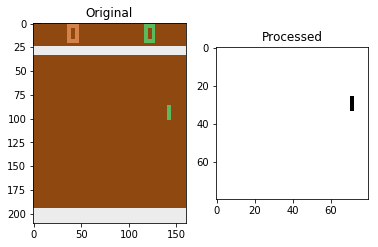

In [4]:
env.reset()
frame, reward, done, info = env.step(env.action_space.sample())
processed = PongDeterministic.preprocess(frame)

fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].imshow(frame)
axes[0].set_title("Original")

axes[1].imshow(processed, cmap='Greys')
axes[1].set_title("Processed")

In [5]:
env = PongDeterministic()
state, _ = env.reset()
state.shape

(2, 80, 80)

In [6]:
for _ in range(10):
    env.step(env.action_space.sample())

In [7]:
def show_state_frames(state):
    frame1 = state[0, :]
    frame2 = state[1, :]

    fig, axes = plt.subplots(nrows=1, ncols=2)

    axes[0].imshow(frame1, cmap='Greys')
    axes[0].set_title("State - frame 1")

    axes[1].imshow(frame2, cmap='Greys')
    axes[1].set_title("State - frame 2")

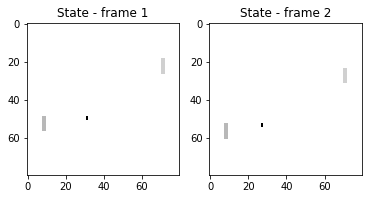

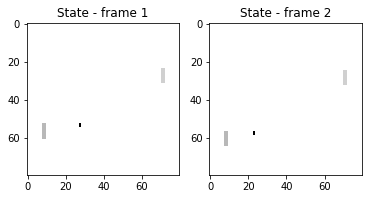

In [8]:
state, reward, done, info, frame = env.step(env.action_space.sample())
show_state_frames(state)
state, reward, done, info, frame = env.step(env.action_space.sample())
show_state_frames(state)

# Game visualization
play game randomly.

In [9]:
from env_wrapper import PongDeterministic
env = PongDeterministic()

In [10]:
class RandomAgent:
    def __init__(self, env):
        self.env = env
    
    def act(self, state):
        prob = 0.5
        return self.env.action_space.sample(), prob

In [17]:
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from IPython.display import display
# function to animate a list of frames
def animate_frames(frames):
    plt.axis('off')

    # color option for plotting
    # use Greys for greyscale
    cmap = None if len(frames[0].shape)==3 else 'Greys'
    patch = plt.imshow(frames[0], cmap=cmap)

    fanim = animation.FuncAnimation(plt.gcf(), \
                                    lambda x: patch.set_data(frames[x]), frames = len(frames), interval=30)

    display(display_animation(fanim, default_mode='once'))

def play(env, agent, t_max=1000):
    state, frame = env.reset()
    anim_frames = []
    score = 0
    for _ in range(t_max):
        action, prob = agent.act(state)
        next_state, reward, done, _, frame = env.step(int(action))
        state = next_state
        
        anim_frames.append(frame)
        score += reward
        if done:
            break

    env.close()

    animate_frames(anim_frames)
    return score

In [12]:
# agent = RandomAgent(env)
# score = play(env=env, agent=agent, t_max=1000)
# print(f"score: {score}")

# PPO
you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [13]:
from env_wrapper import PongDeterministic
from model import Actor, Critic
from ppo_agent import Agent
from train import train, plot_scores
from task import ParallelTask

In [14]:
def create_env():
    return PongDeterministic(skip_num_frames=1)
envs = ParallelTask(create_env=create_env, n_tasks=8)

env = create_env()
action_dim = env.action_space.n
seed = 0

def create_actor():
    return Actor(action_dim=action_dim, seed=seed)

def create_critic():
    return Critic(seed=seed)

optimization_epochs = 4
discount = 0.95
epsilon = 0.1
entropy_weight = 0.01
learning_rate = 1e-4

agent = Agent(
    create_actor=create_actor,
    create_critic=create_critic,
    num_parallels=envs.size,
    optimization_epochs=optimization_epochs,
    discount=discount,
    epsilon=epsilon,
    entropy_weight=entropy_weight,
    lr=learning_rate,
    device='cpu',
    seed=seed)

In [15]:
scores = train(envs=envs, agent=agent, episodes=1000, max_t=1500)

Episode 49/1000	 Score: [-16. -15. -21. -16. -21. -19. -19. -16.]	 Average Score: -18.25	 Max Score: -17.62	 Average steps: 399.90	 Current memory usage: 358.86MB

Episode 50/1000	 Score: [-19. -17. -21. -18. -19. -16. -15. -20.]	 Average Score: -18.18	 Max Score: -17.62	 Average steps: 398.30	 Current memory usage: 336.59MB
saving model at 50
Episode 99/1000	 Score: [-16. -19. -18. -14. -18. -21. -15. -20.]	 Average Score: -17.14	 Max Score: -14.62	 Average steps: 419.60	 Current memory usage: 376.48MB

Episode 100/1000	 Score: [-17. -21. -10. -12. -13. -14.  -8. -19.]	 Average Score: -16.75	 Max Score: -14.25	 Average steps: 420.80	 Current memory usage: 385.93MB
saving model at 100
Episode 149/1000	 Score: [-11.  -8.  -9. -13. -14.  -6.  -6. -20.]	 Average Score: -13.06	 Max Score: -10.12	 Average steps: 662.20	 Current memory usage: 415.41MB

Episode 150/1000	 Score: [-10.  -7. -14. -14. -11. -17. -10. -17.]	 Average Score: -12.95	 Max Score: -10.12	 Average steps: 672.00	 Current memory usage: 424.04MB
saving model at 150
Episode 199/1000	 Score: [ -5. -14.  -5. -10.  -8. -10. -16. -12.]	 Average Score: -9.34	 Max Score: -8.00	 Average steps: 1069.20	 Current memory usage: 490.33MBB

Episode 200/1000	 Score: [ -4.  -9.  -8.  -7.  -6. -11. -14.  -5.]	 Average Score: -9.34	 Max Score: -8.00	 Average steps: 1100.40	 Current memory usage: 474.21MB
saving model at 200
Episode 249/1000	 Score: [ -9.  -7.   0. -12.  -7.  -9.  -4.  -7.]	 Average Score: -11.11	 Max Score: -6.88	 Average steps: 1425.90	 Current memory usage: 463.77MBB

Episode 250/1000	 Score: [-11.  -6. -12.  -9.  -9. -13. -12. -13.]	 Average Score: -10.78	 Max Score: -6.88	 Average steps: 1409.20	 Current memory usage: 457.76MB
saving model at 250
Episode 299/1000	 Score: [-3. -9. -5.  0. -9.  5. -7. -2.]	 Average Score: -4.24	 Max Score: -2.38	 Average steps: 1500.00	 Current memory usage: 515.00MB545.96MBB

Episode 300/1000	 Score: [-8. -6. -7. -4. -6. -5. -9.  2.]	 Average Score: -4.28	 Max Score: -2.38	 Average steps: 1500.00	 Current memory usage: 516.70MB
saving model at 300
Episode 349/1000	 Score: [17.  6. 18. 18.  6. 16. 15. 18.]	 Average Score: 15.75	 Max Score: 16.88	 Average steps: 1500.00	 Current memory usage: 546.91MB534.44MB

Episode 350/1000	 Score: [18. 18. 18. 18. 18. 15. 18. 18.]	 Average Score: 15.82	 Max Score: 17.62	 Average steps: 1500.00	 Current memory usage: 549.35MB
saving model at 350
Episode 399/1000	 Score: [21. 21. 21. 18. 20. 21. 13.  4.]	 Average Score: 18.45	 Max Score: 20.38	 Average steps: 1424.20	 Current memory usage: 564.75MB582.19MB

Episode 400/1000	 Score: [21. 21. 21. 12. 21. 21. 21. 20.]	 Average Score: 18.43	 Max Score: 20.38	 Average steps: 1424.20	 Current memory usage: 586.45MB
saving model at 400
Episode 410/1000	 Score: [21. 21. 21. 21. 21. 21. 20. 21.]	 Average Score: 19.79	 Max Score: 20.88	 Average steps: 1428.00	 Current memory usage: 376.25MB

Episode 411/1000	 Score: [21. 21. 21. 21. 21. 21. 21. 21.]	 Average Score: 20.06	 Max Score: 21.00	 Average steps: 1428.00	 Current memory usage: 366.46MBEnvironment solved in 411 episodes!	 Average Score: 20.06


[-18.625,
 -16.375,
 -18.0,
 -17.875,
 -18.0,
 -18.125,
 -19.0,
 -19.125,
 -17.625,
 -18.25,
 -17.625,
 -18.5,
 -18.375,
 -19.0,
 -15.5,
 -19.0,
 -19.0,
 -17.25,
 -18.375,
 -18.125,
 -18.875,
 -19.25,
 -19.25,
 -18.125,
 -18.5,
 -17.0,
 -16.25,
 -17.875,
 -16.625,
 -17.375,
 -17.5,
 -17.375,
 -17.75,
 -18.375,
 -16.125,
 -18.75,
 -18.25,
 -19.0,
 -18.625,
 -18.875,
 -18.5,
 -17.75,
 -18.25,
 -18.125,
 -19.5,
 -18.125,
 -17.625,
 -17.875,
 -17.875,
 -18.125,
 -18.5,
 -18.0,
 -18.375,
 -18.375,
 -17.25,
 -18.5,
 -18.25,
 -16.375,
 -18.625,
 -17.625,
 -15.875,
 -16.5,
 -17.0,
 -19.375,
 -18.5,
 -17.875,
 -17.5,
 -17.375,
 -17.125,
 -19.375,
 -17.375,
 -19.125,
 -17.375,
 -18.75,
 -18.25,
 -17.125,
 -17.5,
 -17.875,
 -17.375,
 -18.0,
 -16.25,
 -16.875,
 -17.75,
 -18.5,
 -16.75,
 -16.125,
 -16.625,
 -17.875,
 -16.75,
 -18.125,
 -16.5,
 -16.0,
 -18.0,
 -18.125,
 -14.625,
 -16.75,
 -17.75,
 -17.875,
 -17.625,
 -14.25,
 -15.625,
 -17.75,
 -17.25,
 -17.625,
 -17.875,
 -16.5,
 -17.5,
 -17.75,
 -

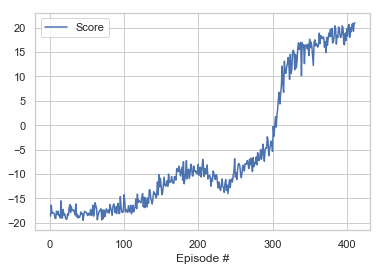

In [17]:
plot_scores(scores)

# Watch Smart Agent

In [18]:
from env_wrapper import PongDeterministic
from model import Actor, Critic
from ppo_agent import Agent
from train import train, plot_scores
from task import ParallelTask
import torch

env = PongDeterministic(skip_num_frames=1)
state_dim = env.observation_space.shape
action_dim = env.action_space.n
seed = 0

def create_actor():
    return Actor(action_dim=action_dim, seed=seed)

def create_critic():
    return Critic(seed=seed)

optimization_epochs = 4
discount = 0.95
epsilon = 0.1
entropy_weight = 0.01
learning_rate = 1e-4

In [19]:
agent = Agent(
    create_actor=create_actor,
    create_critic=create_critic,
    state_dim=state_dim,
    num_parallels=1,
    optimization_epochs=optimization_epochs,
    discount=discount,
    epsilon=epsilon,
    entropy_weight=entropy_weight,
    lr=learning_rate,
    device='cpu',
    seed=seed)

In [20]:
agent.actor.load_state_dict(torch.load(f"checkpoint_actor.pth"))
agent.critic.load_state_dict(torch.load(f"checkpoint_critic.pth"))


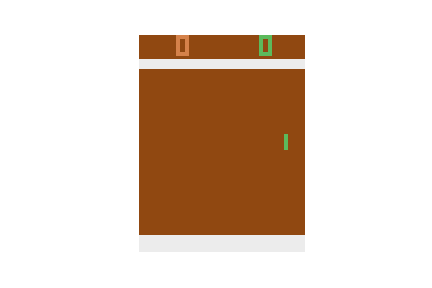
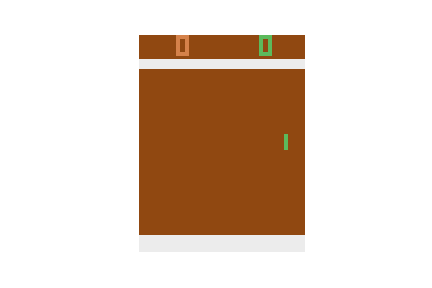
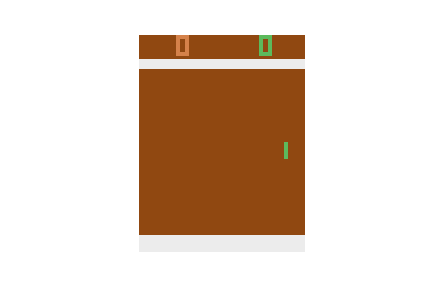
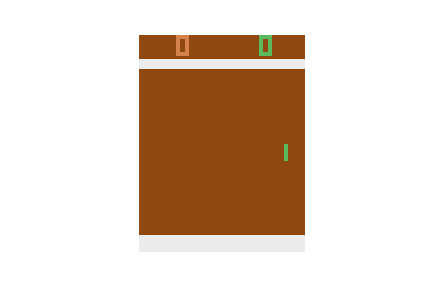
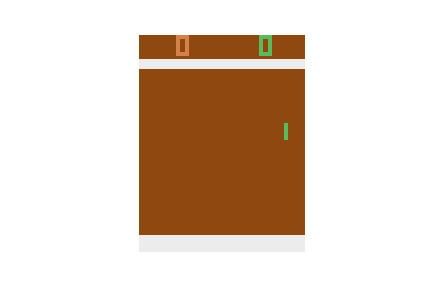
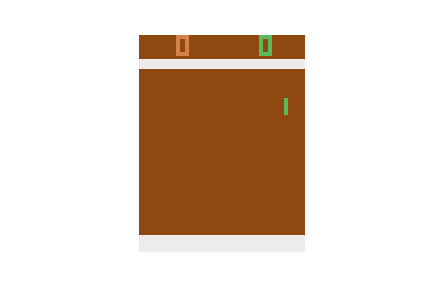
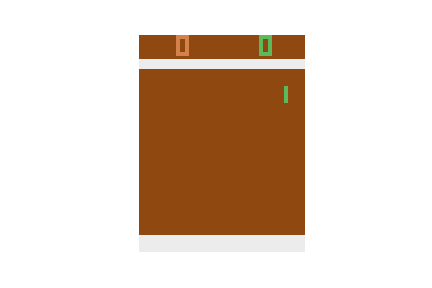
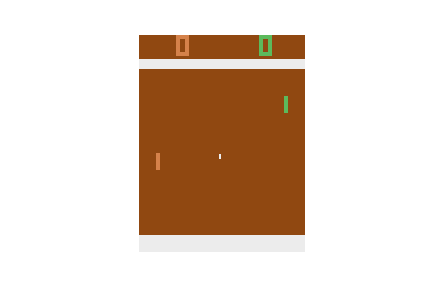
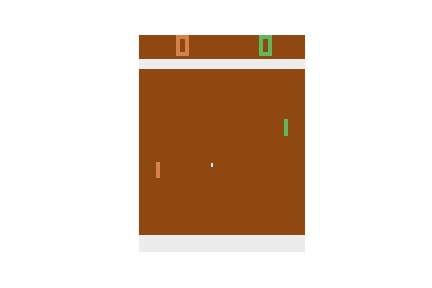
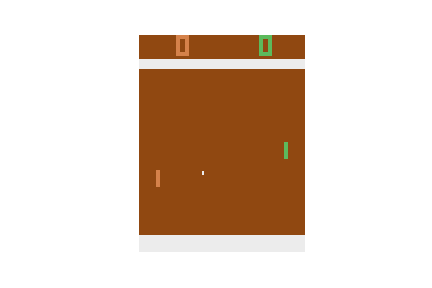
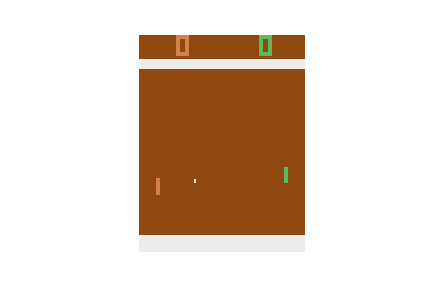
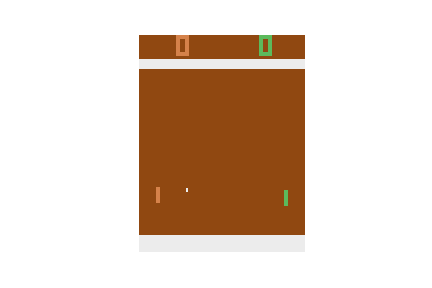
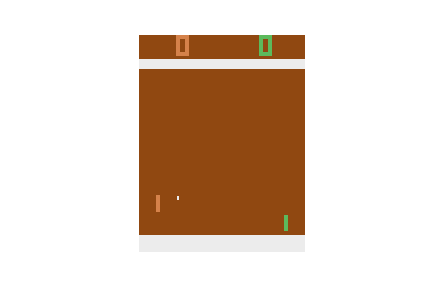
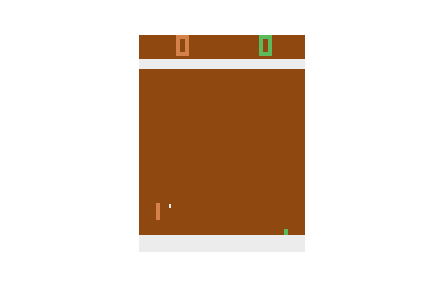
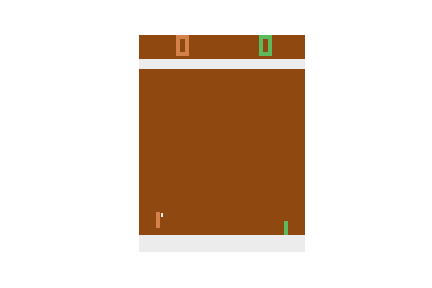
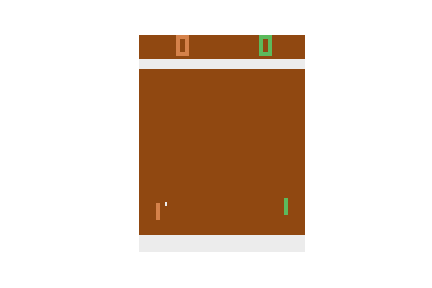
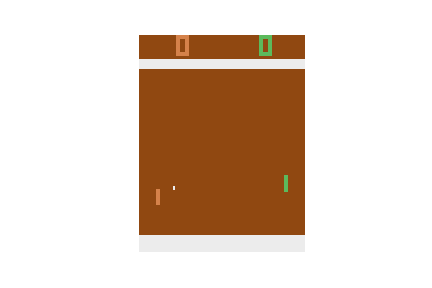
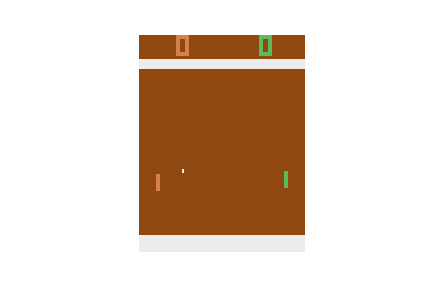
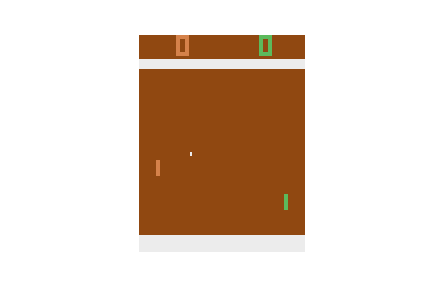
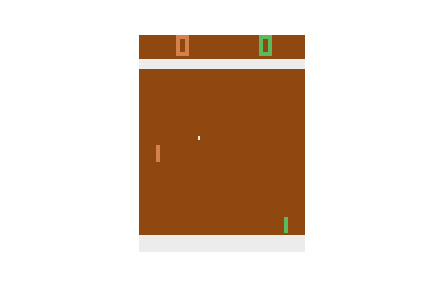
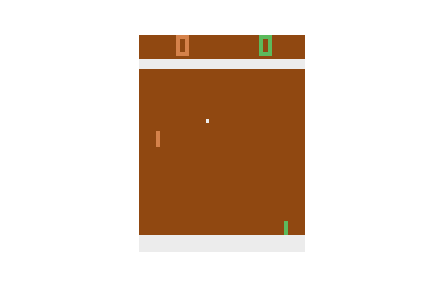
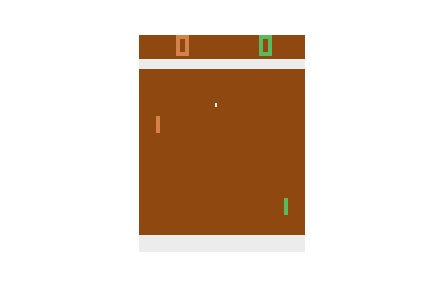
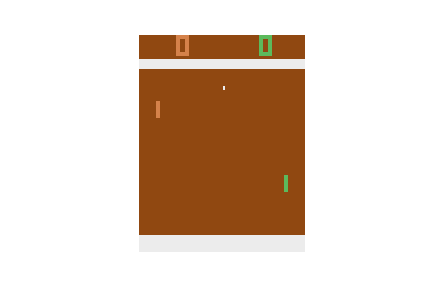
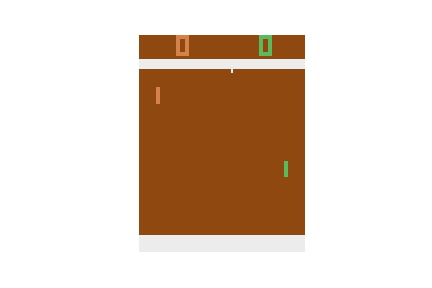
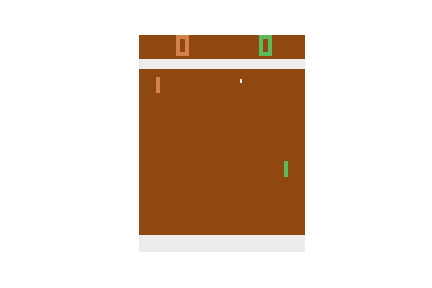
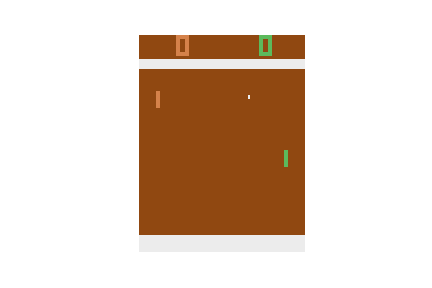
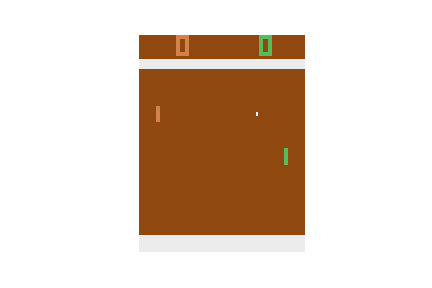
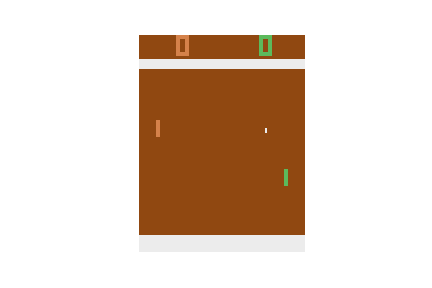
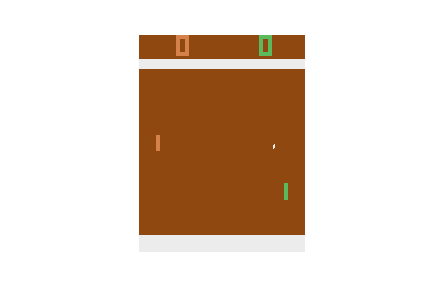
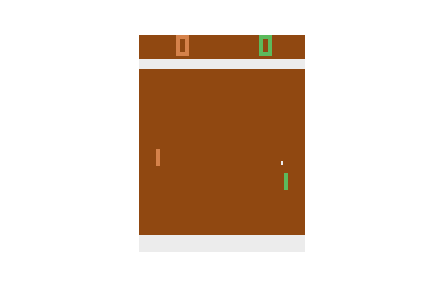
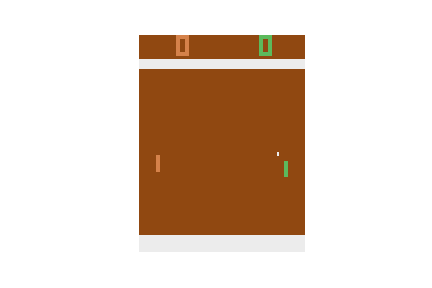
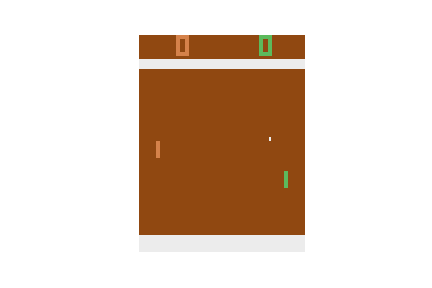
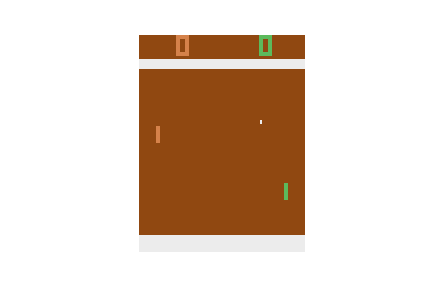
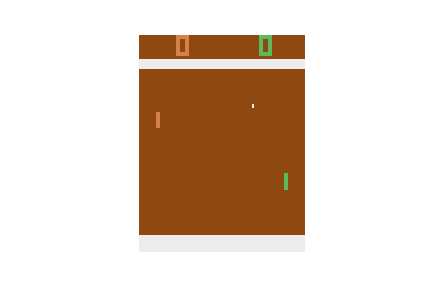
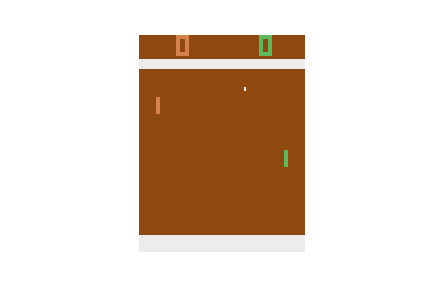
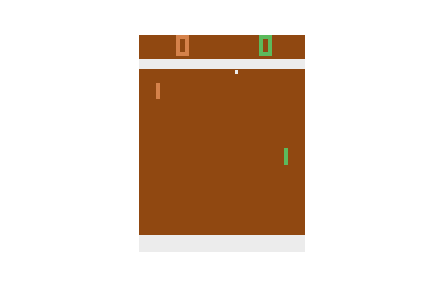
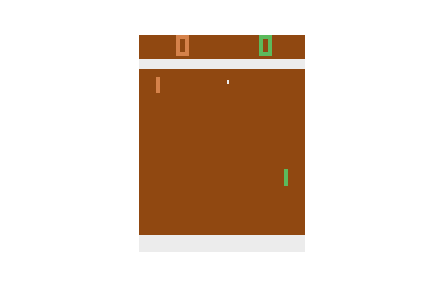
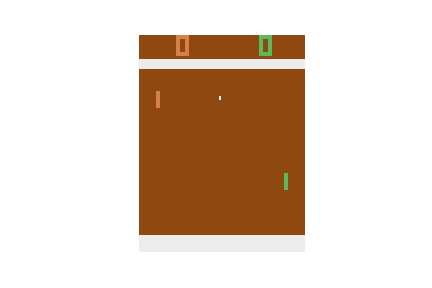
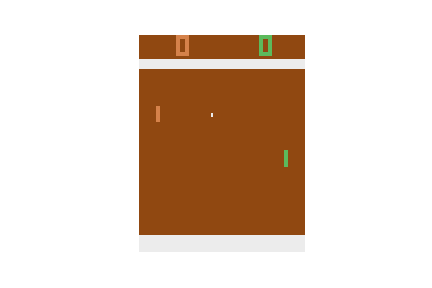
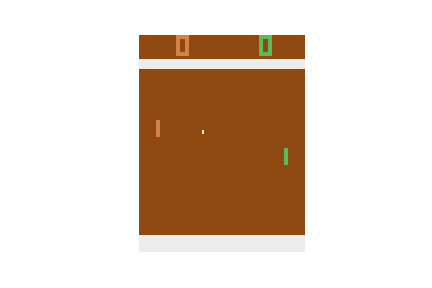
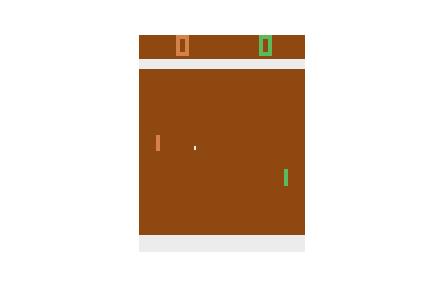
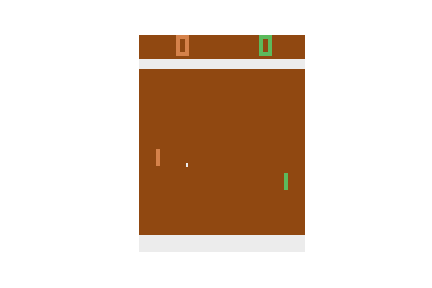
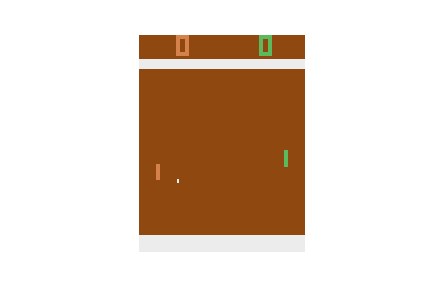
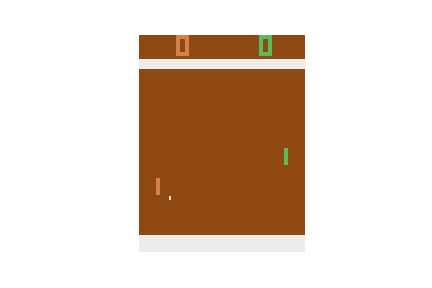
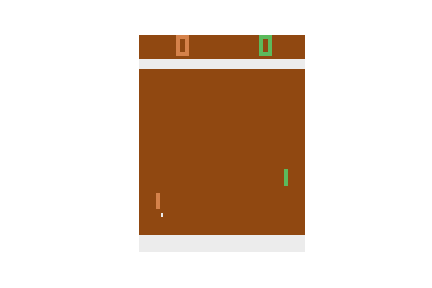
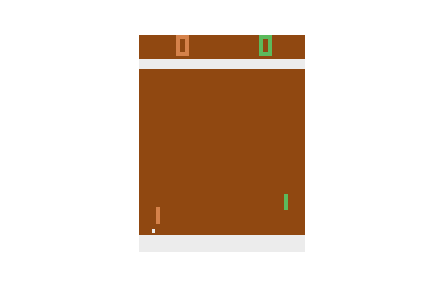
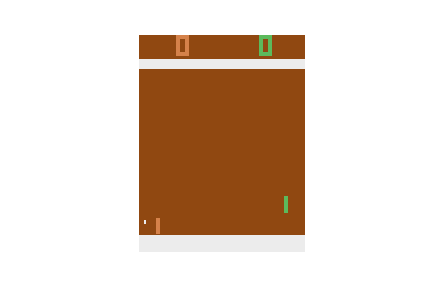
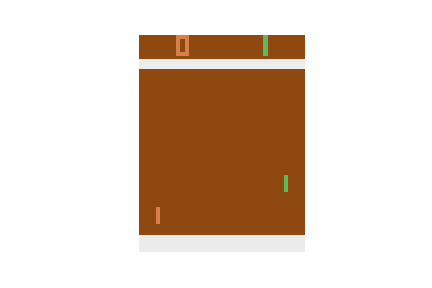
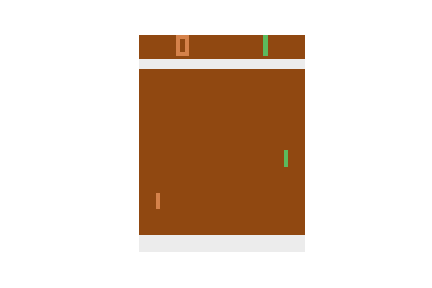
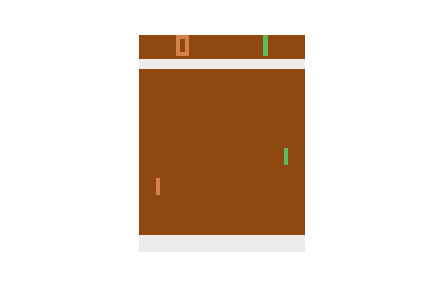
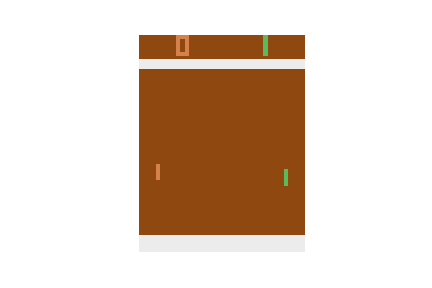
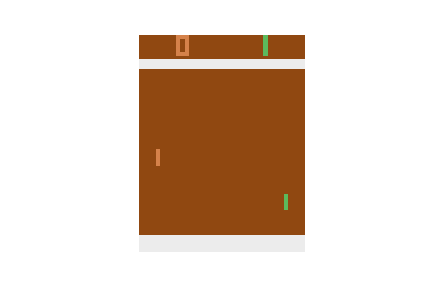
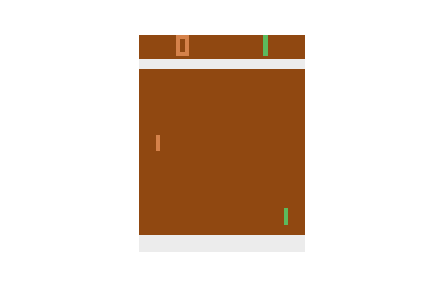
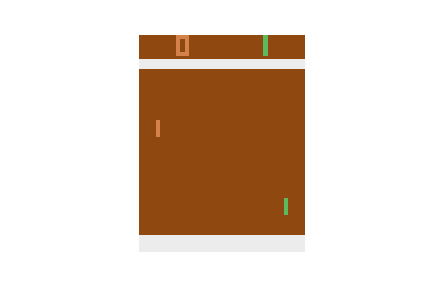
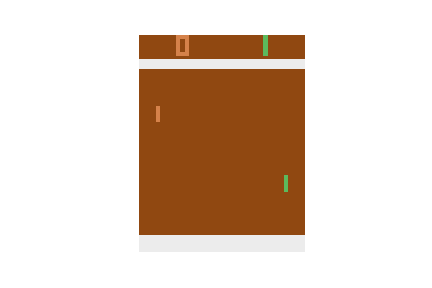
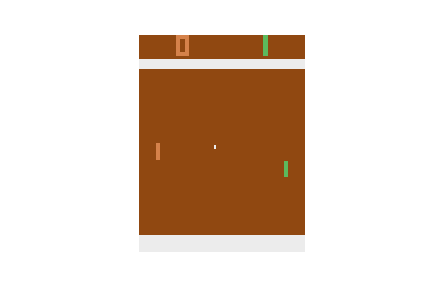
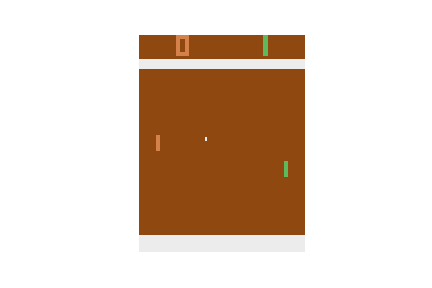
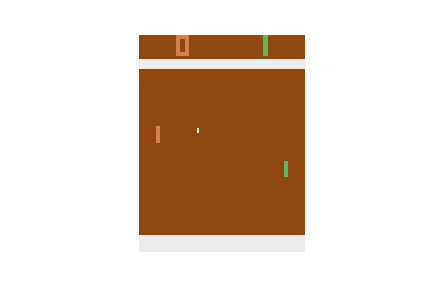
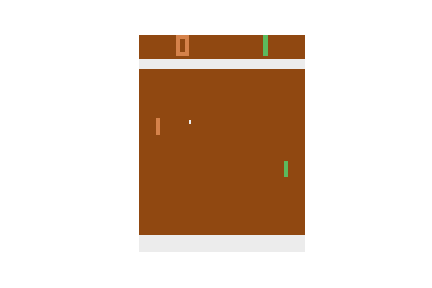
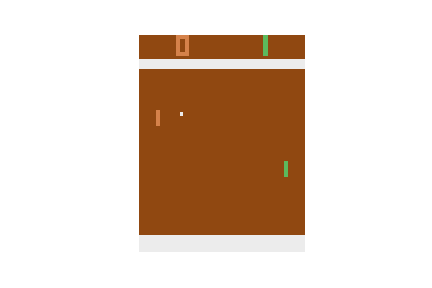
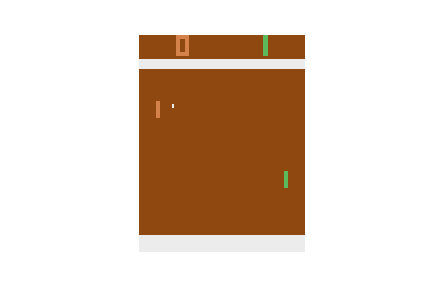
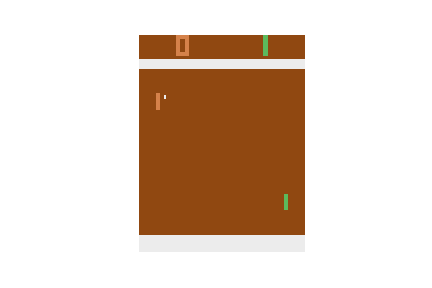
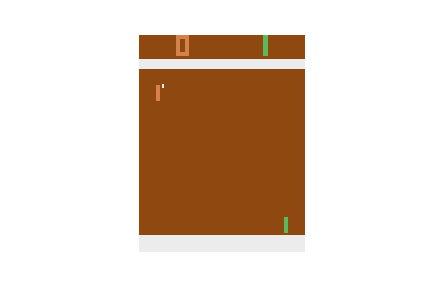
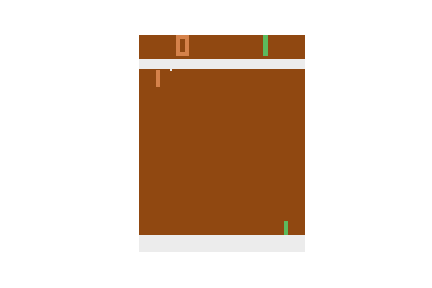
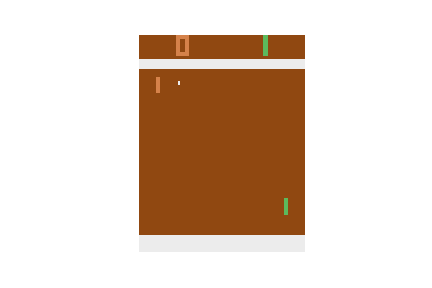
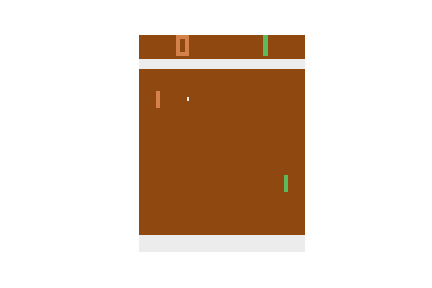
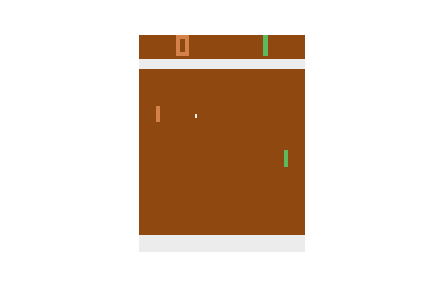
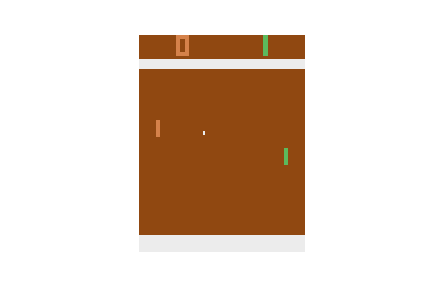
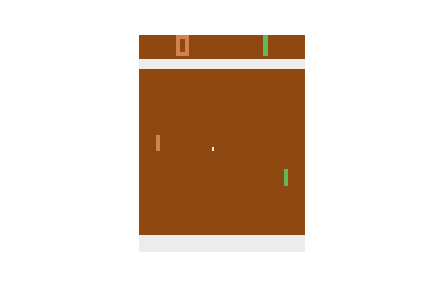
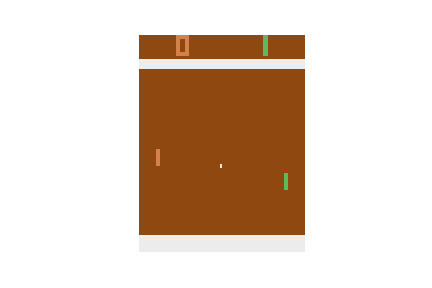
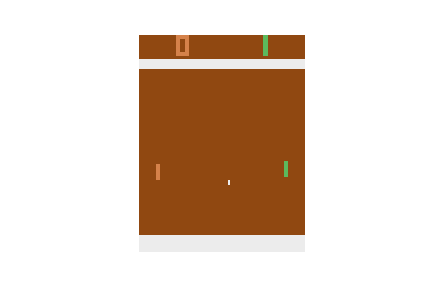
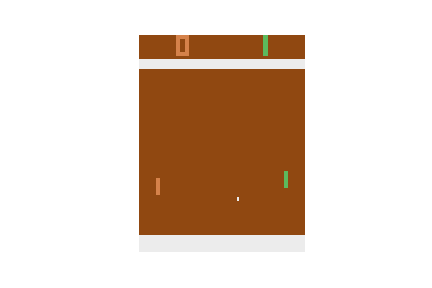
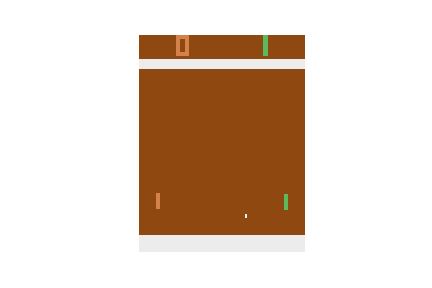
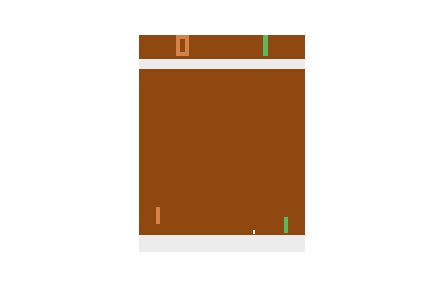
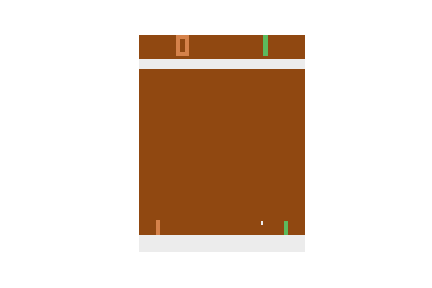
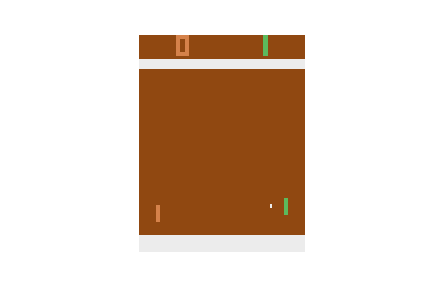
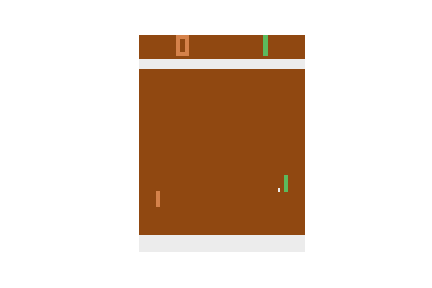
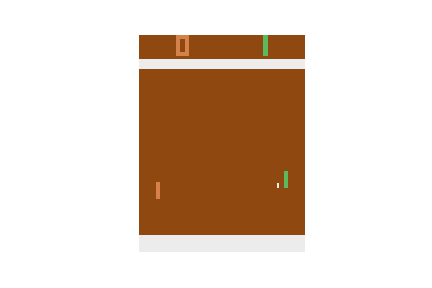
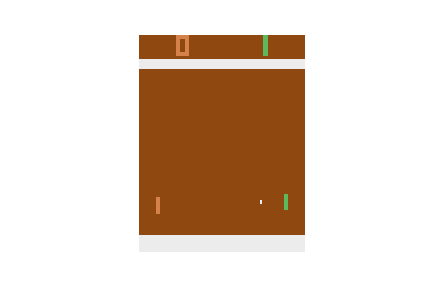
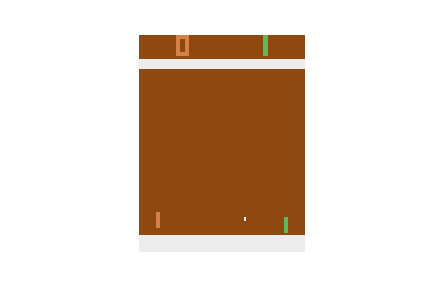
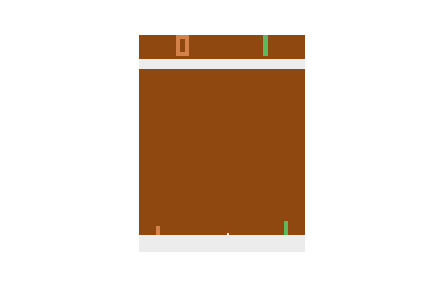
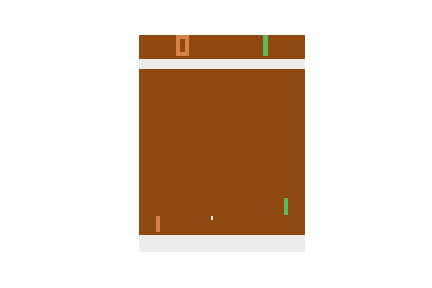
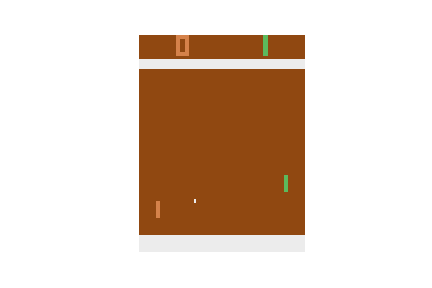
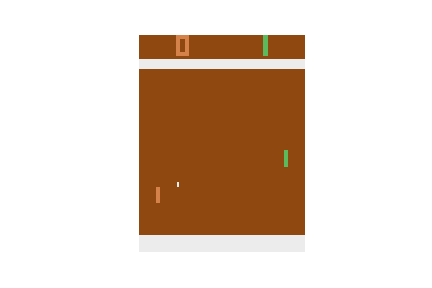
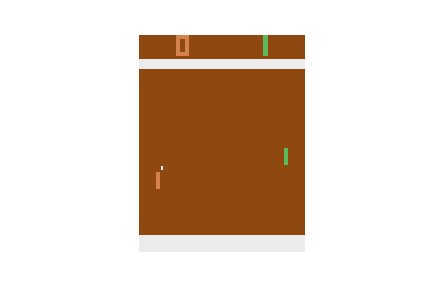
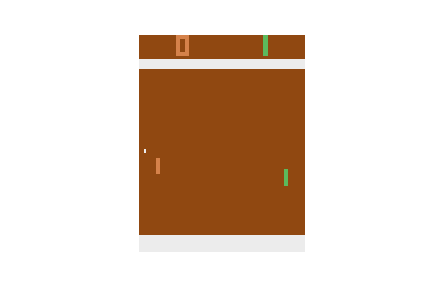
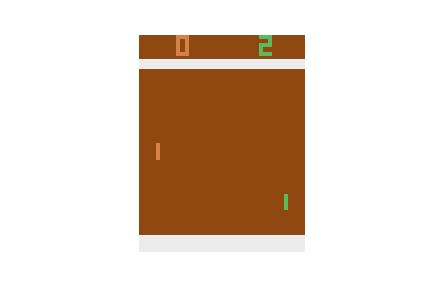
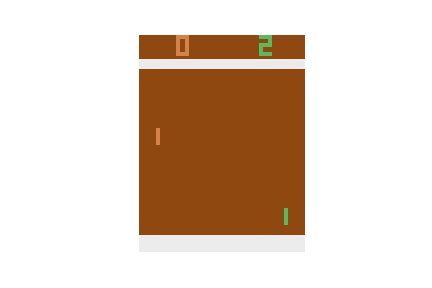
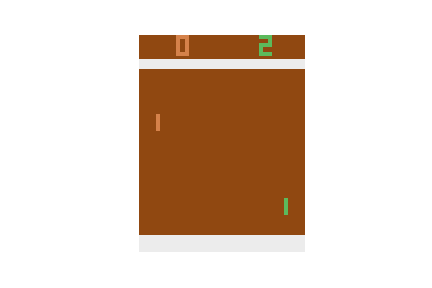
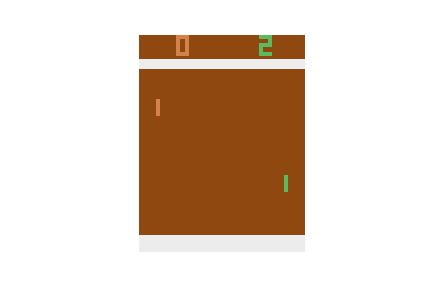
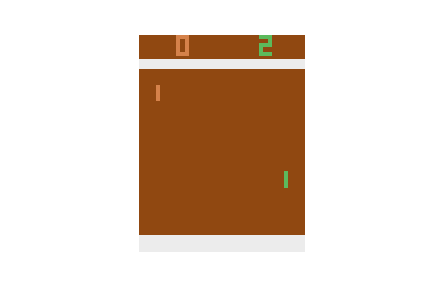
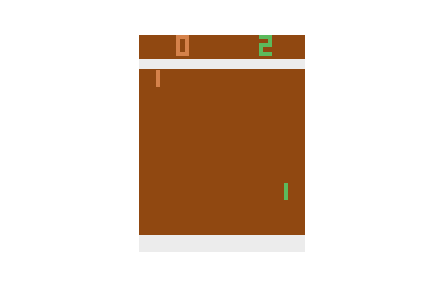
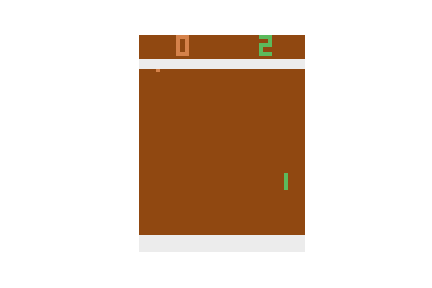
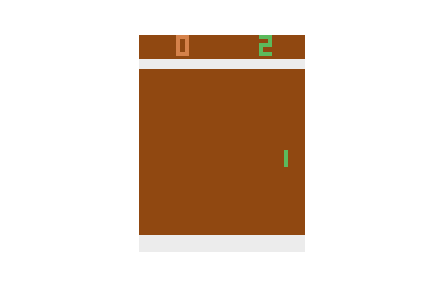
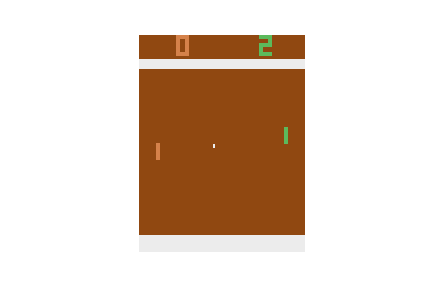
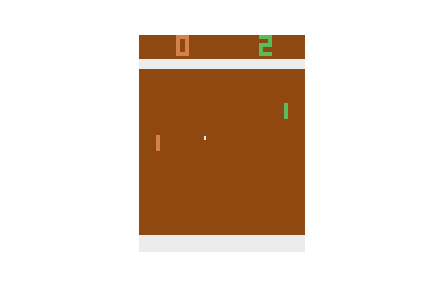
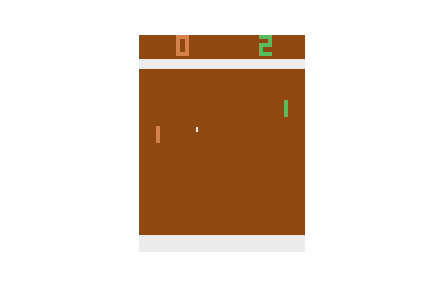
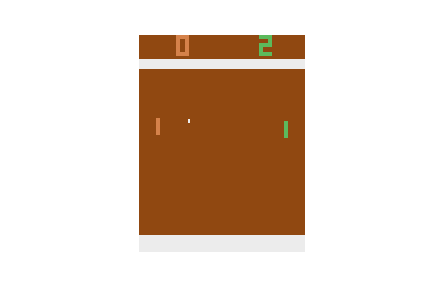
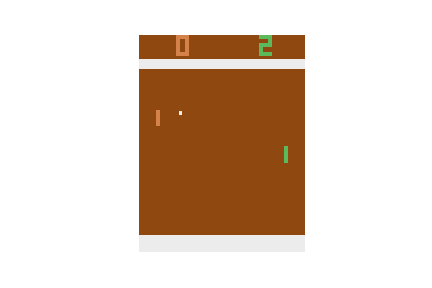
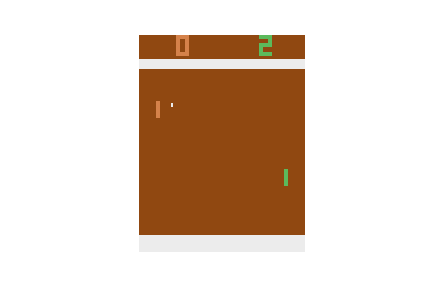
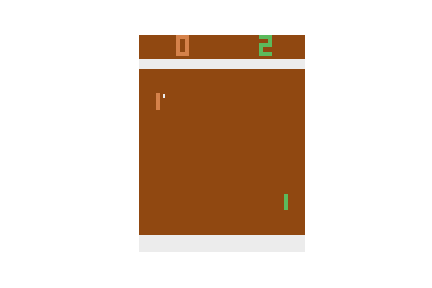
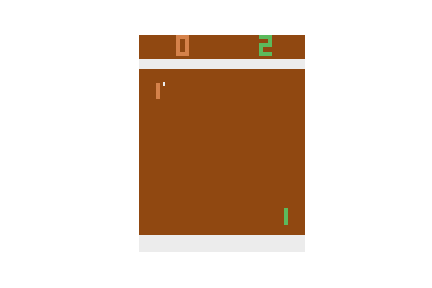
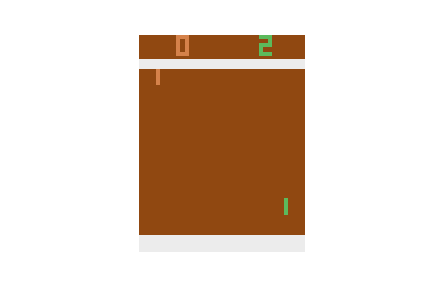
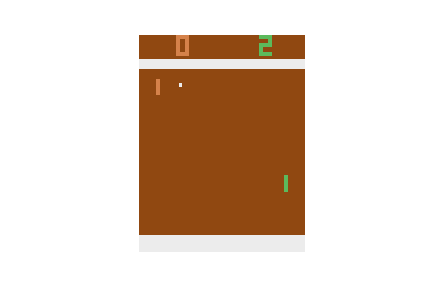
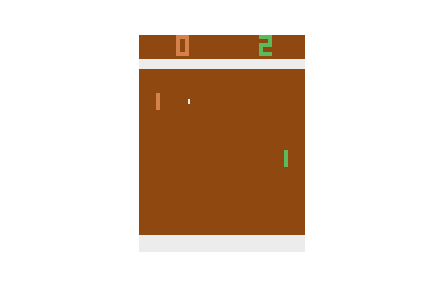
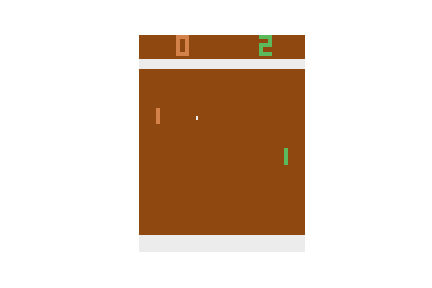
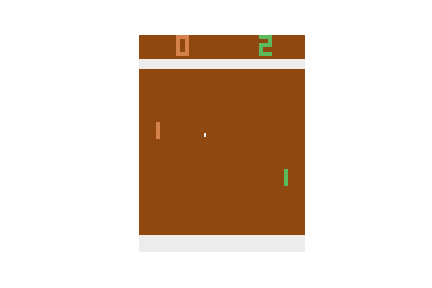
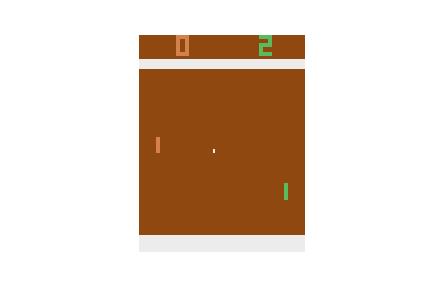
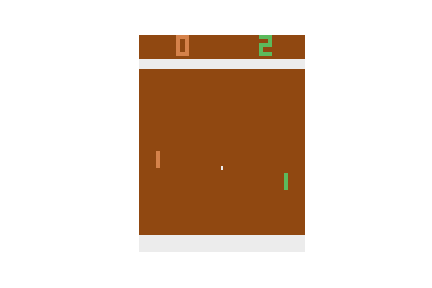
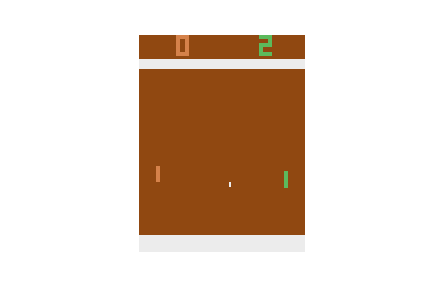
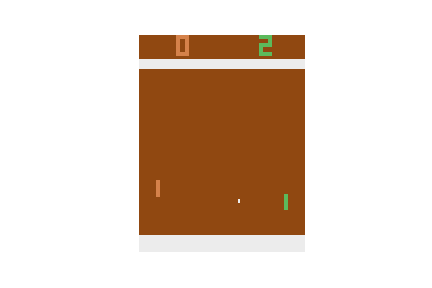
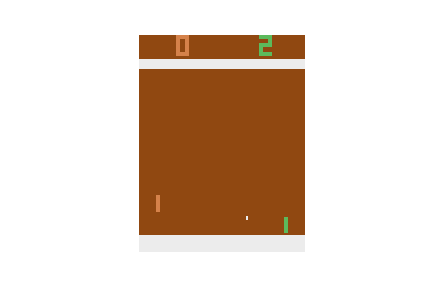
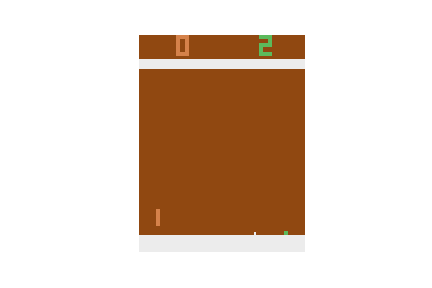
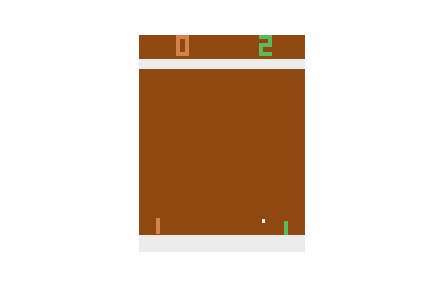
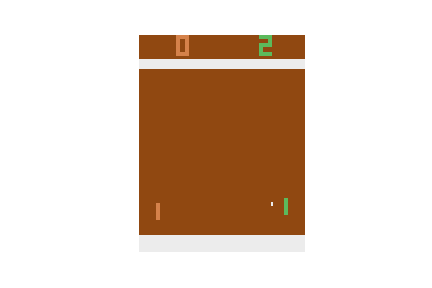
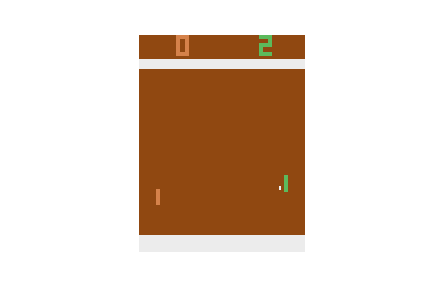
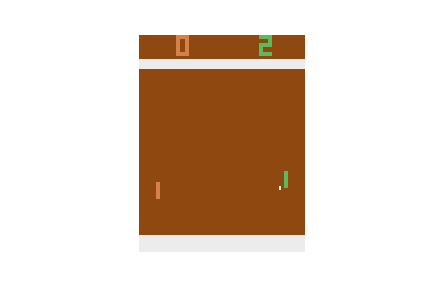
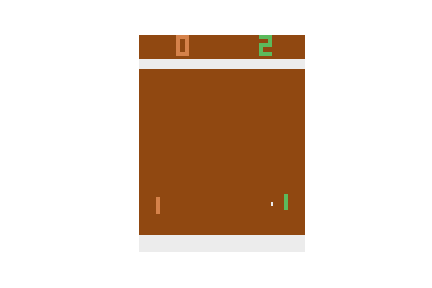
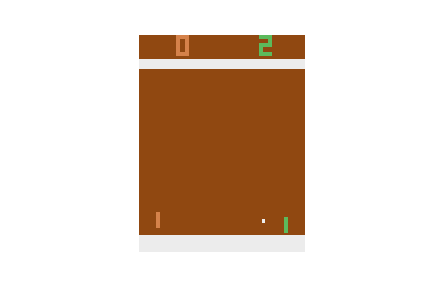
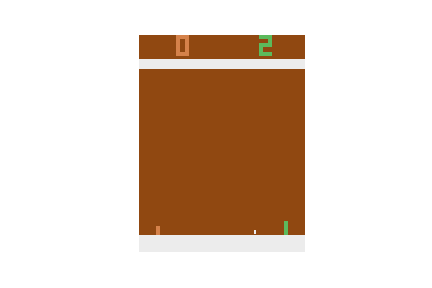
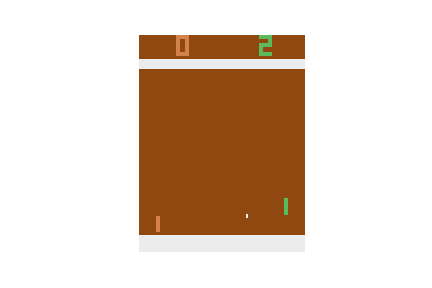
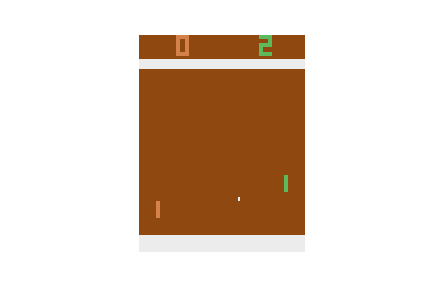
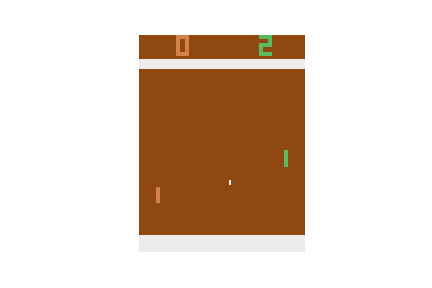
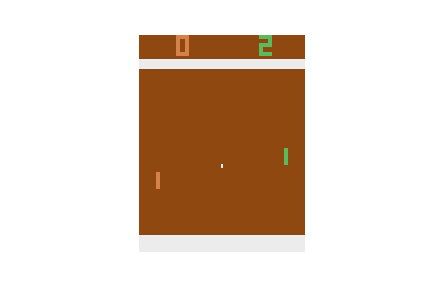
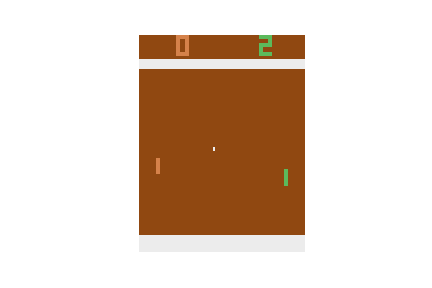
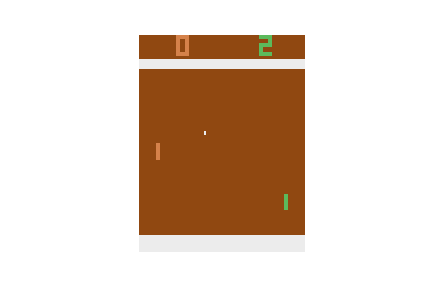
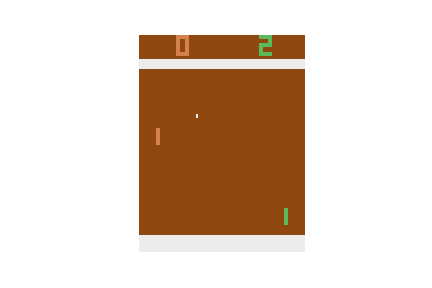
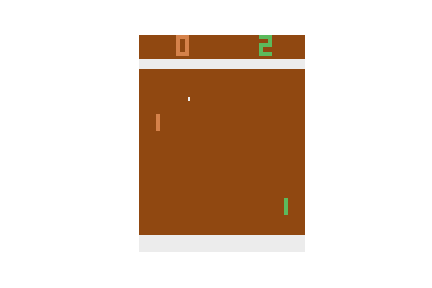
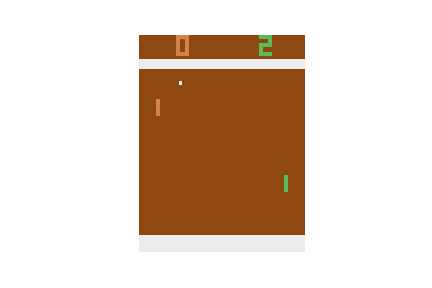
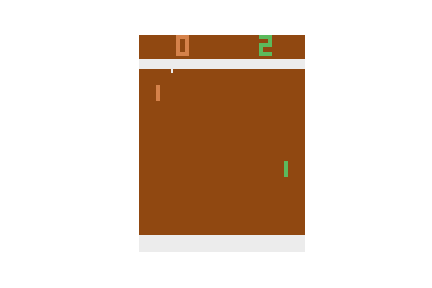
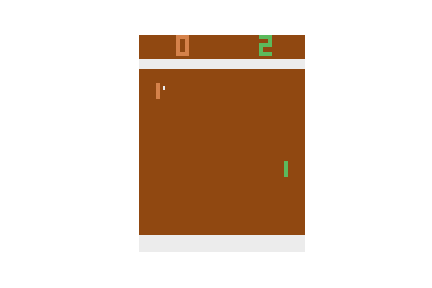
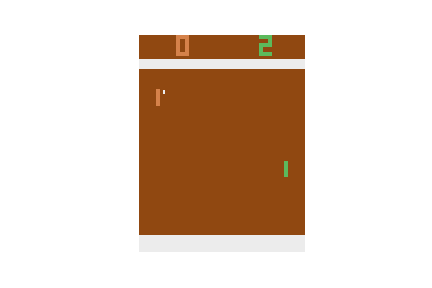
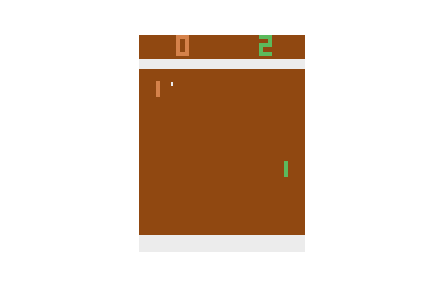
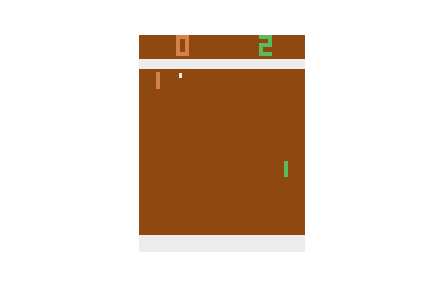
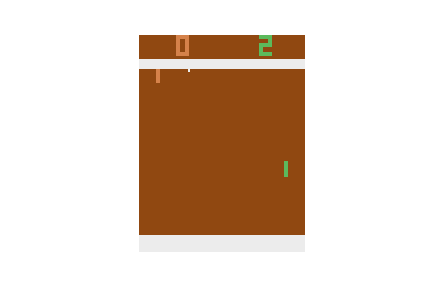
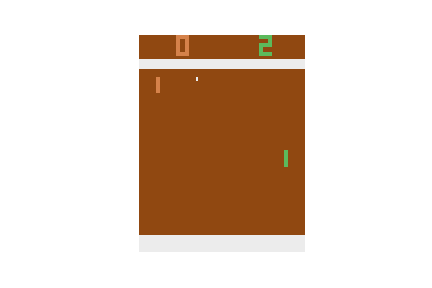
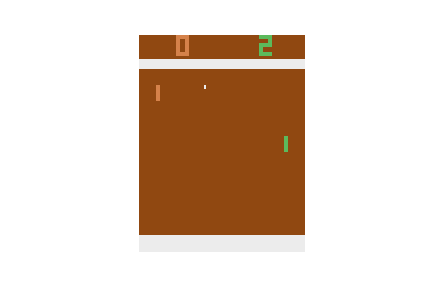
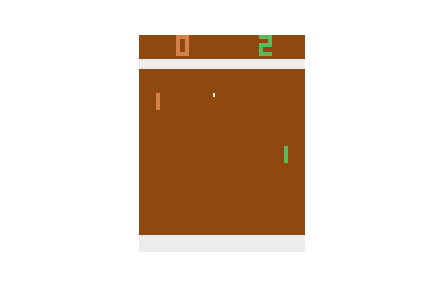
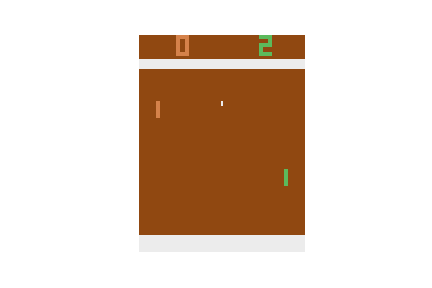
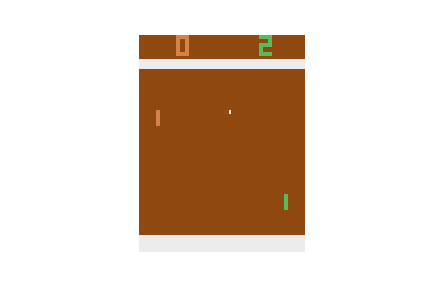
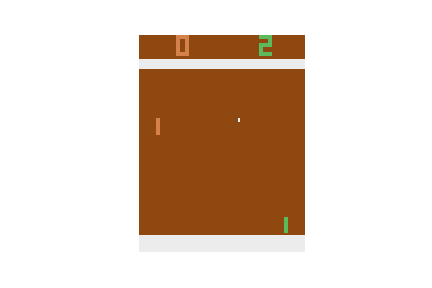
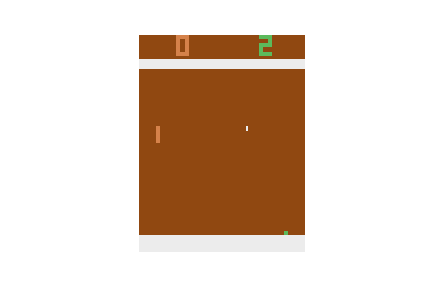
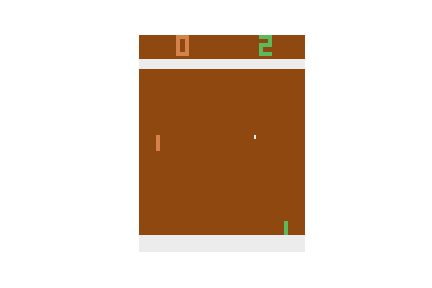
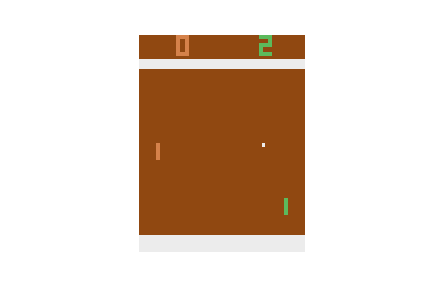
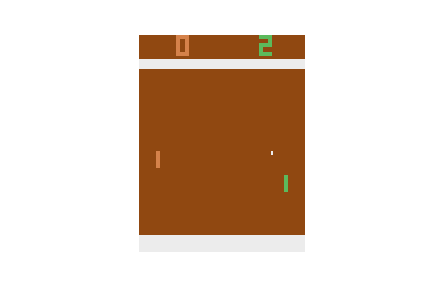
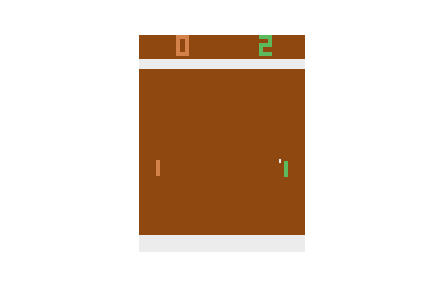
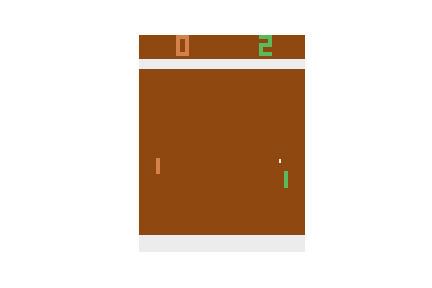
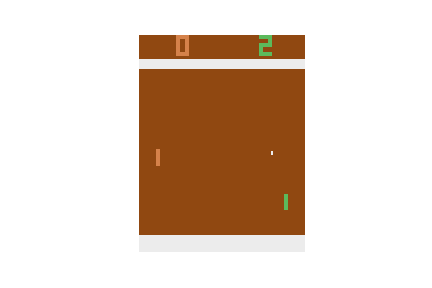
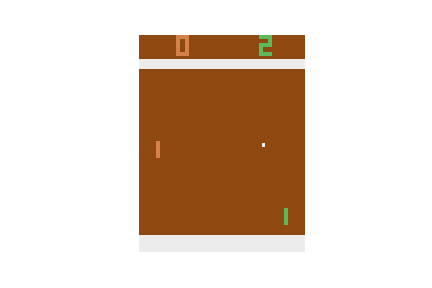
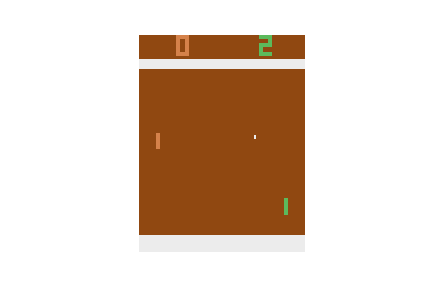
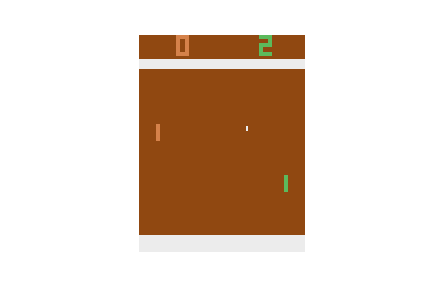
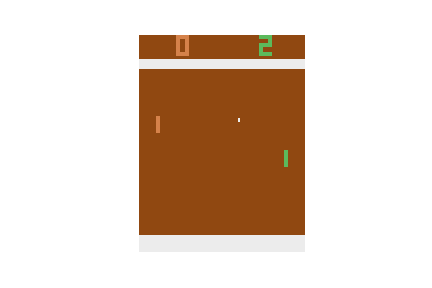
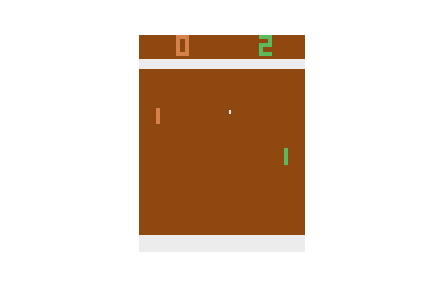
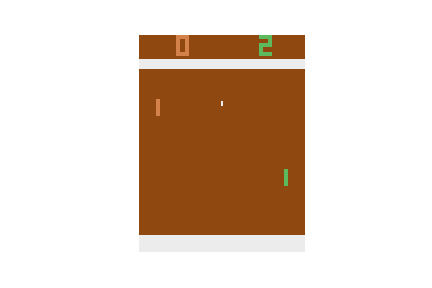
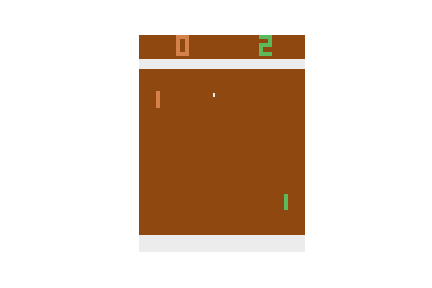
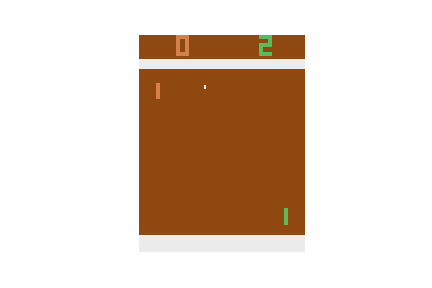
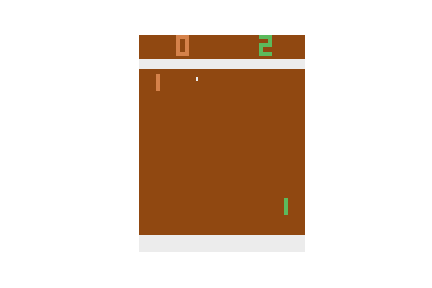
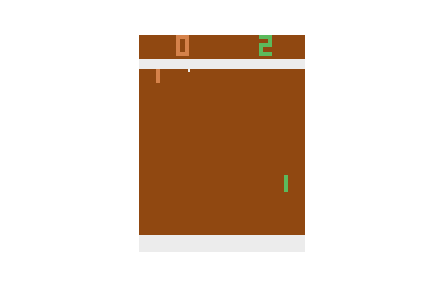
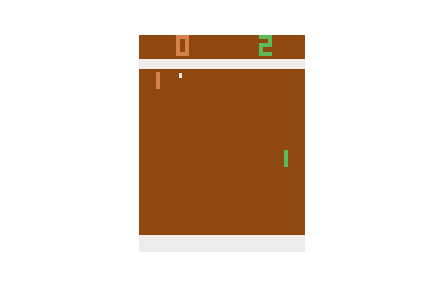
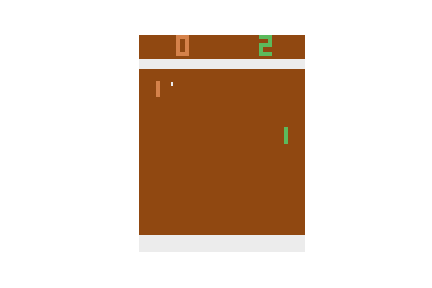
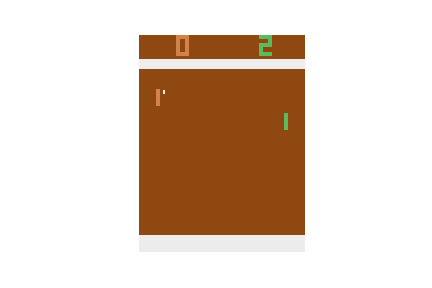
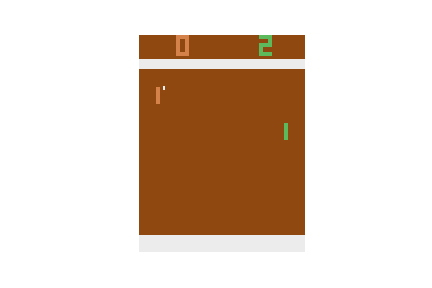
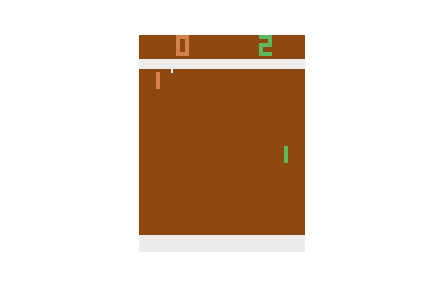
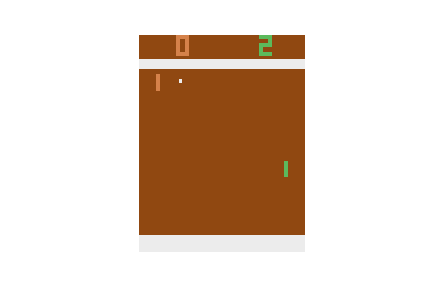
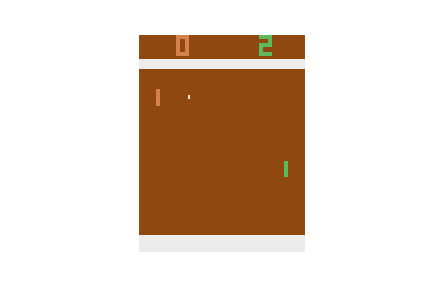
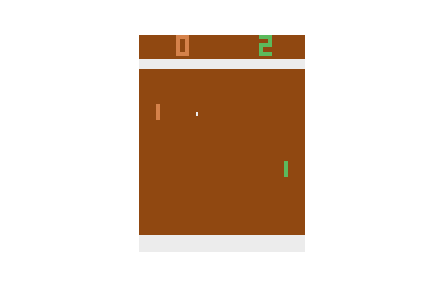
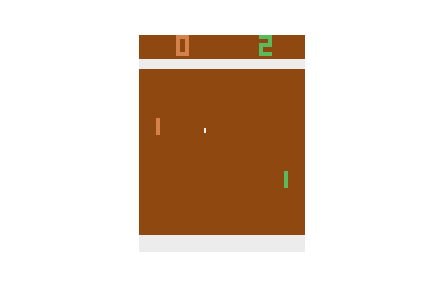
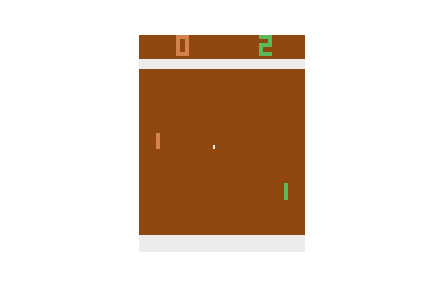
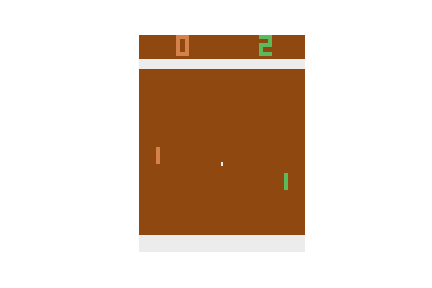
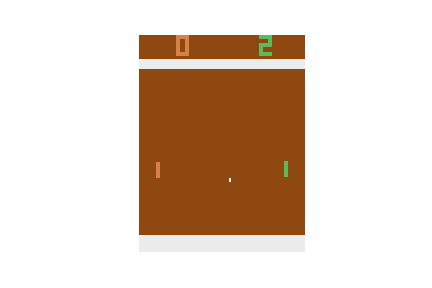
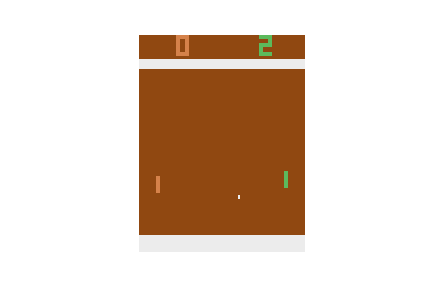
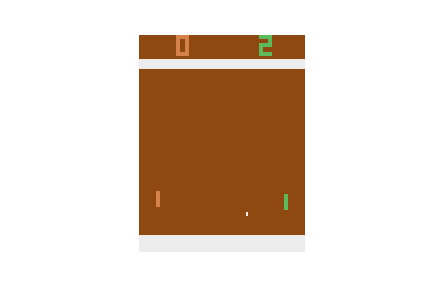
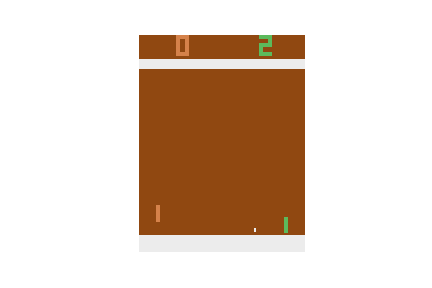
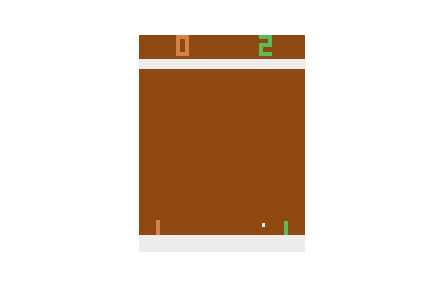
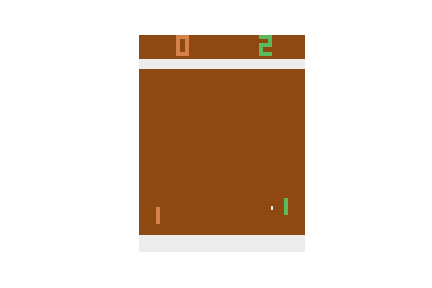
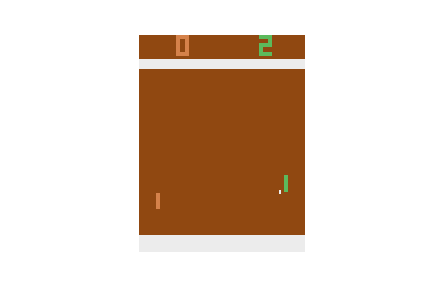
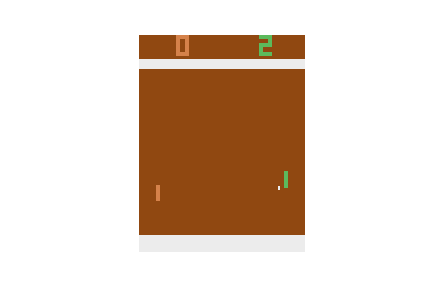
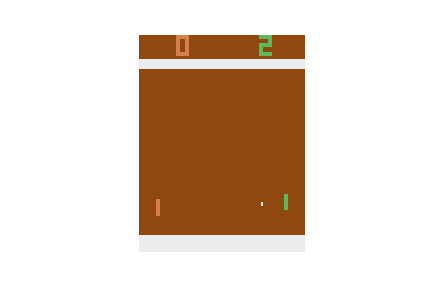
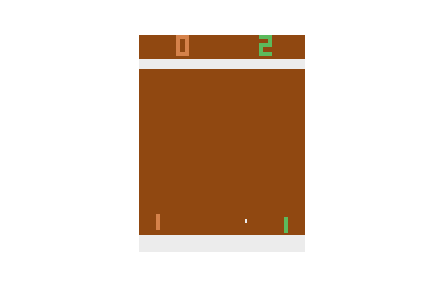
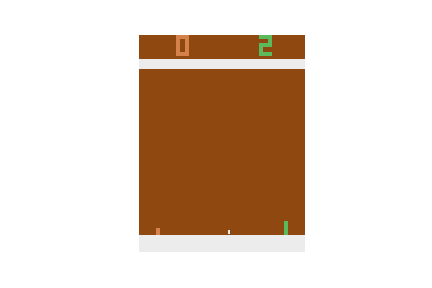
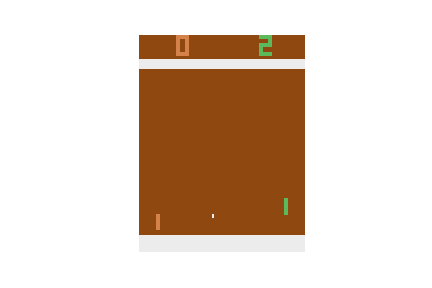
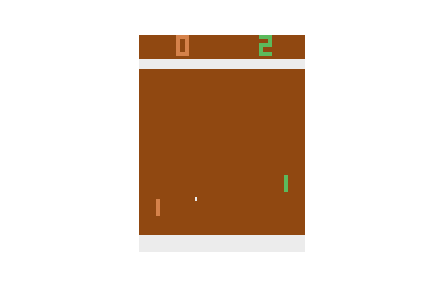
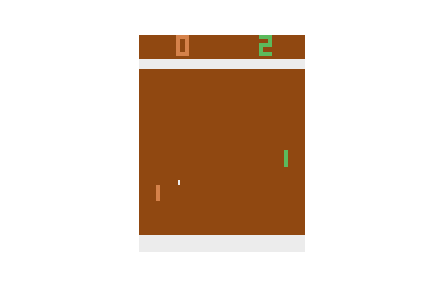
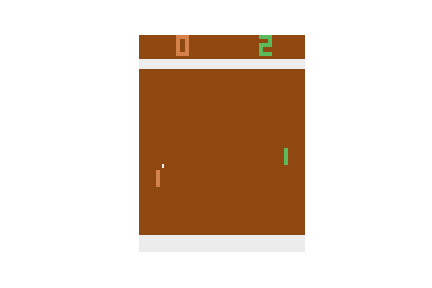
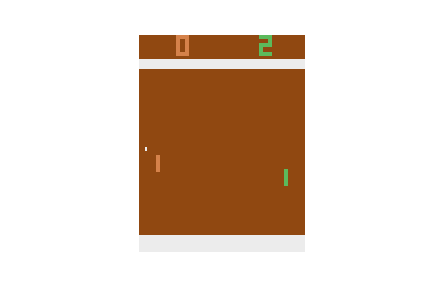
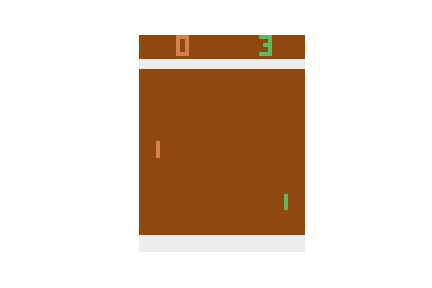
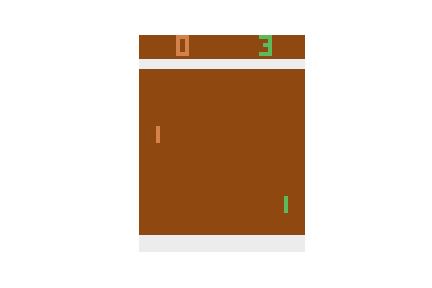
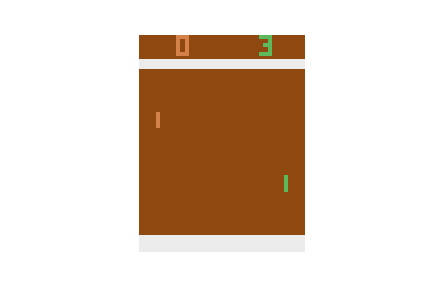
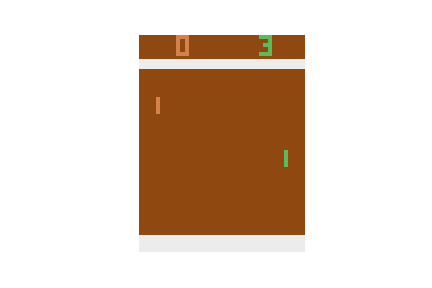
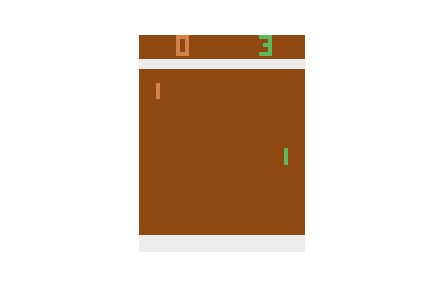
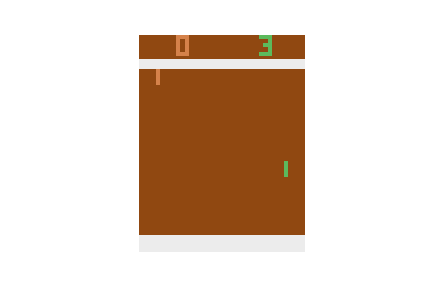
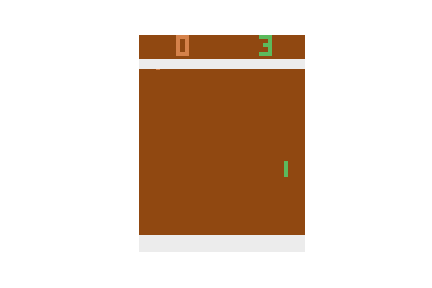
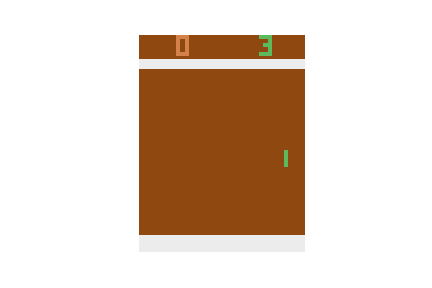
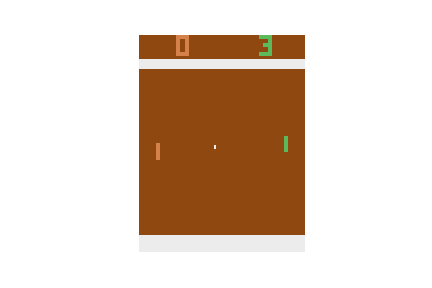
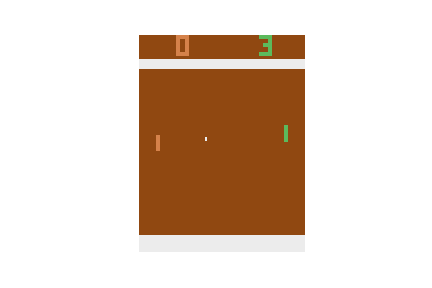
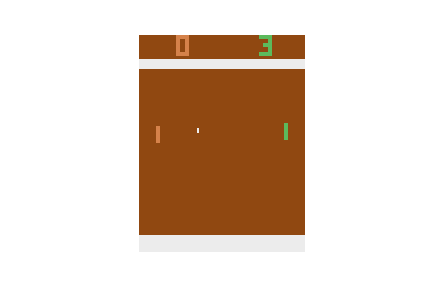
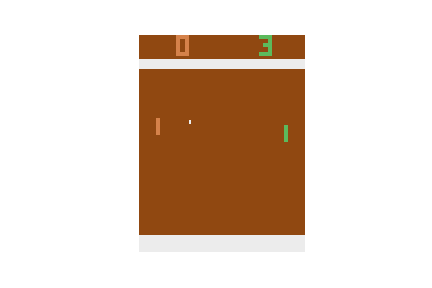
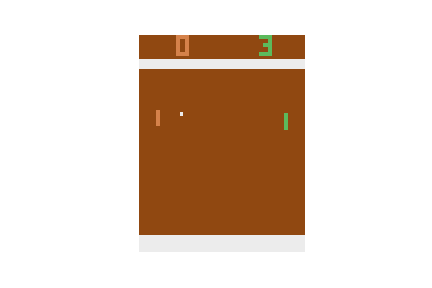
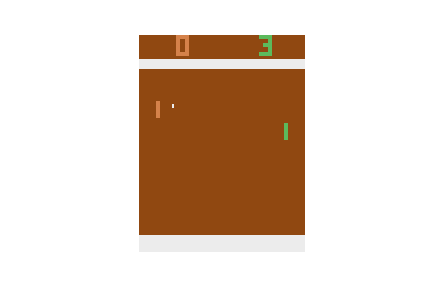
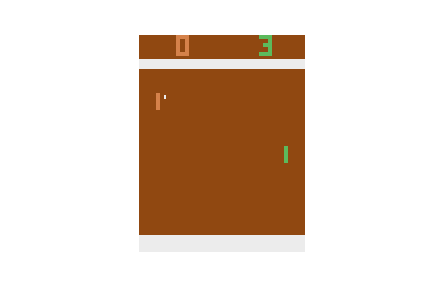
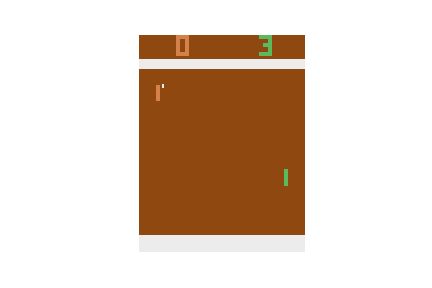
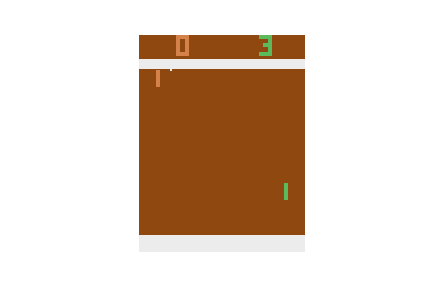
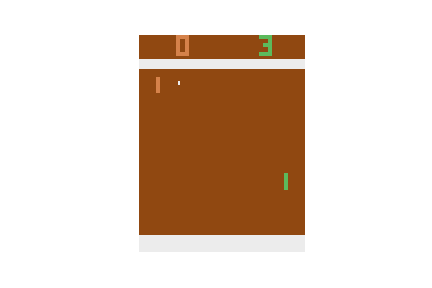
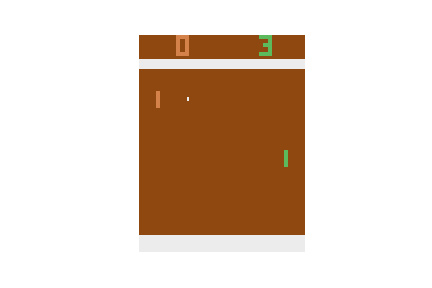
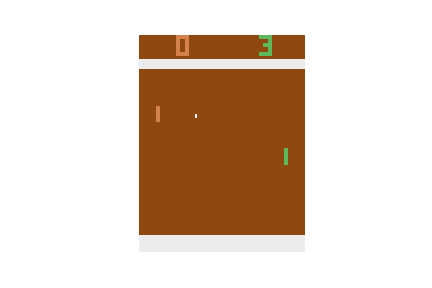
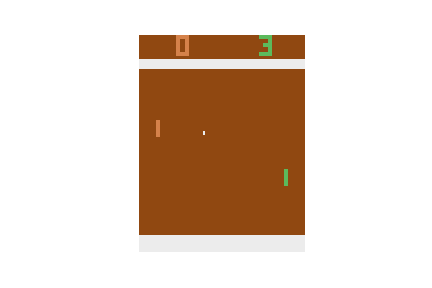
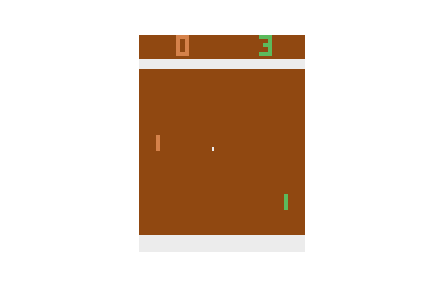
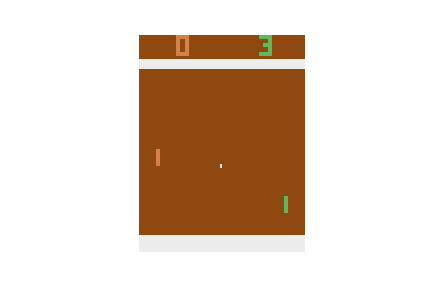
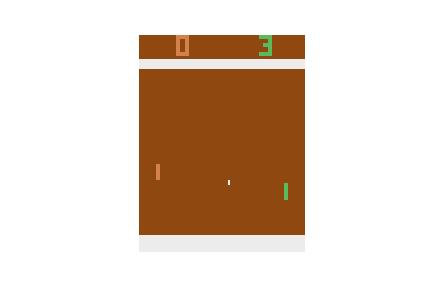
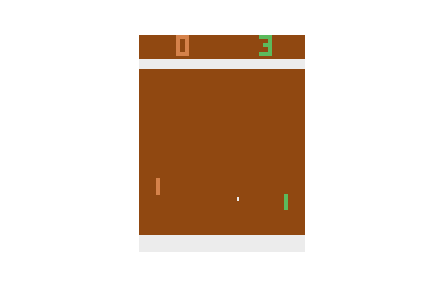
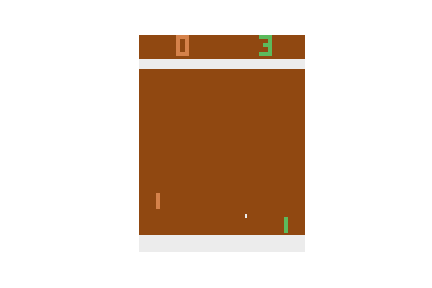
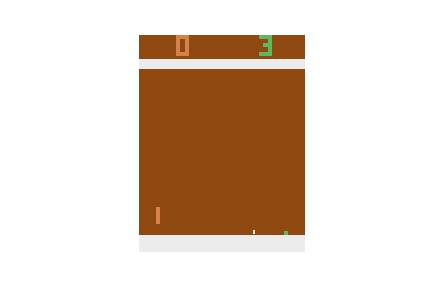
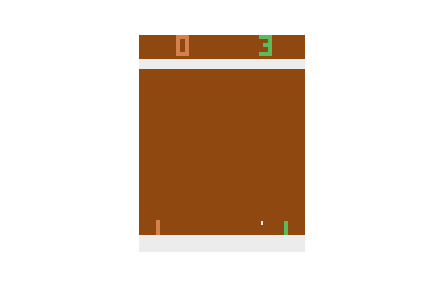
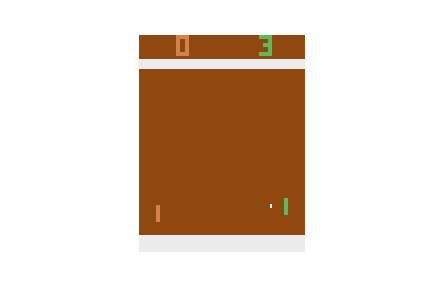
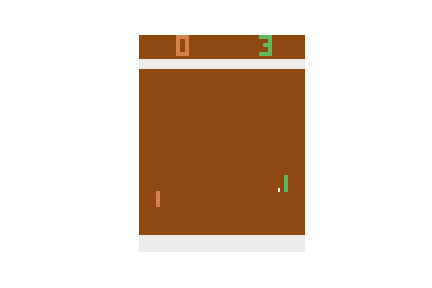
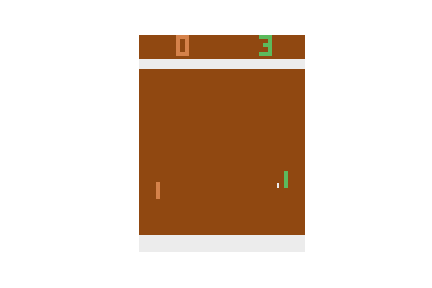
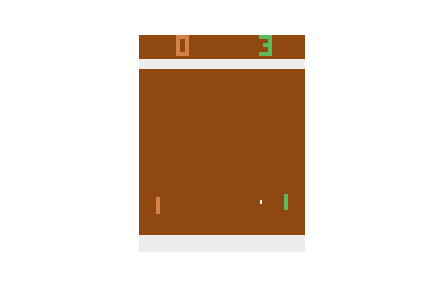
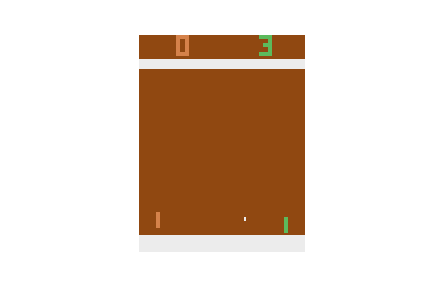
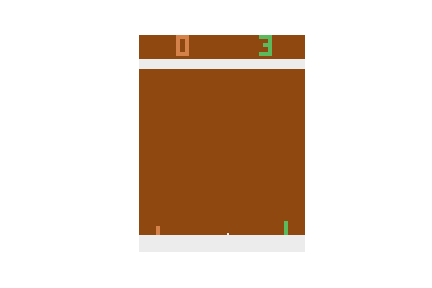
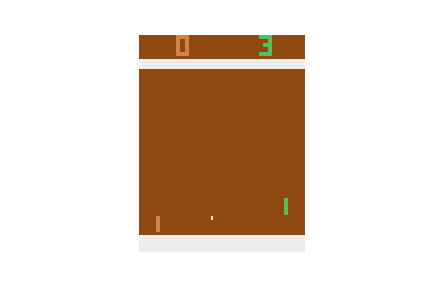
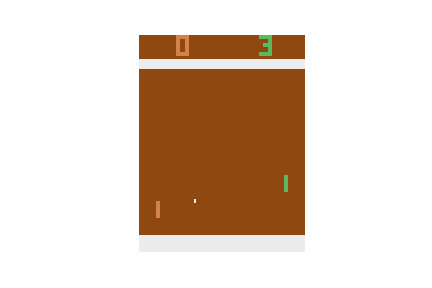
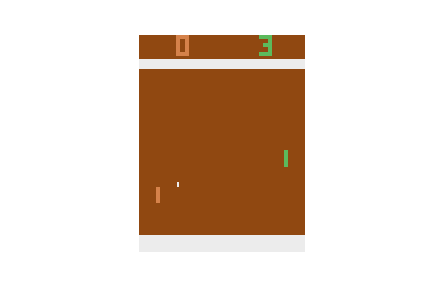
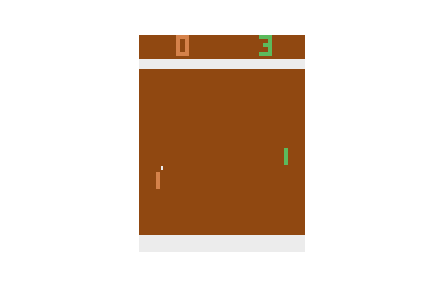
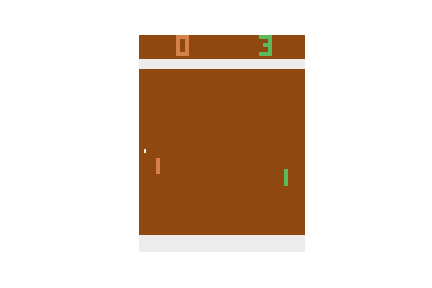
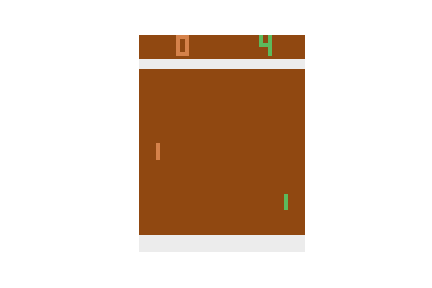
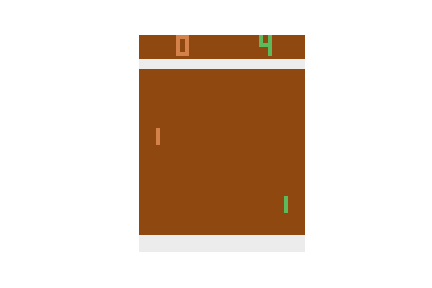
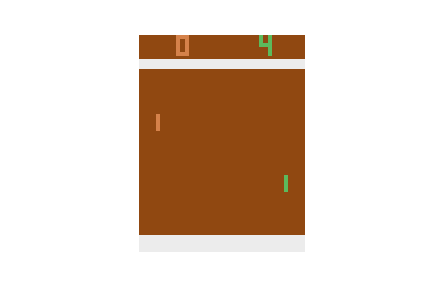
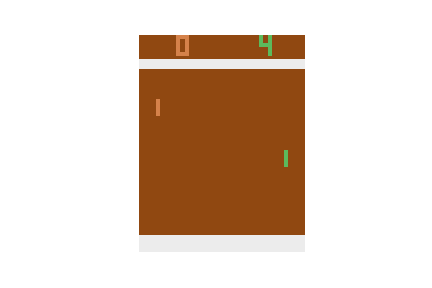
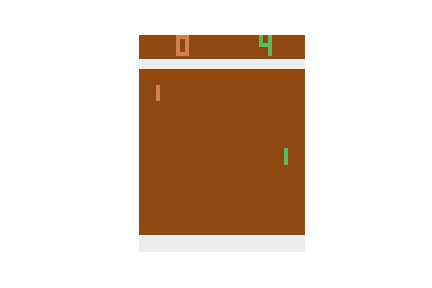
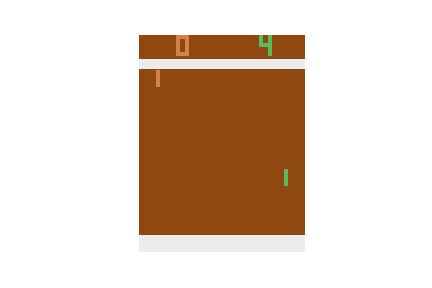
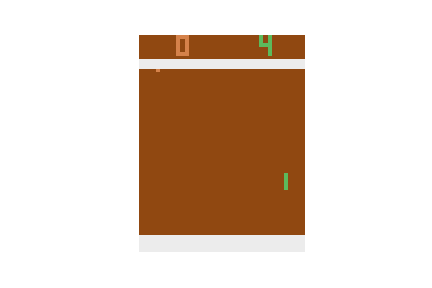
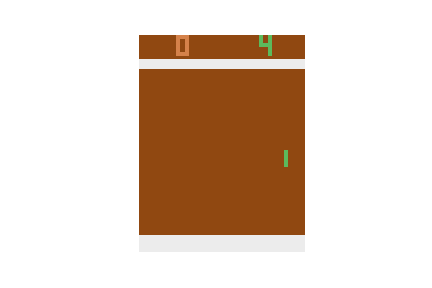
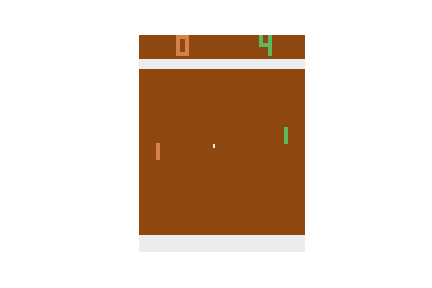
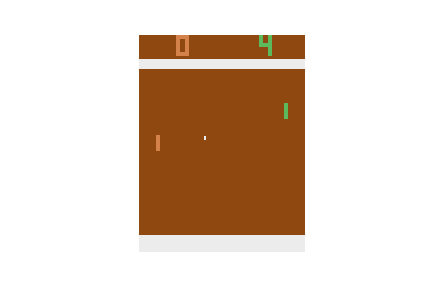
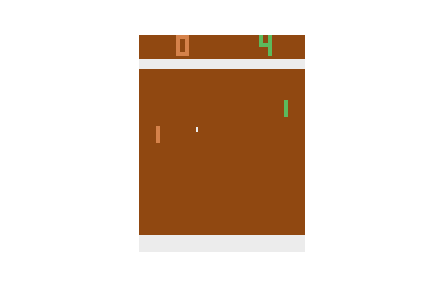
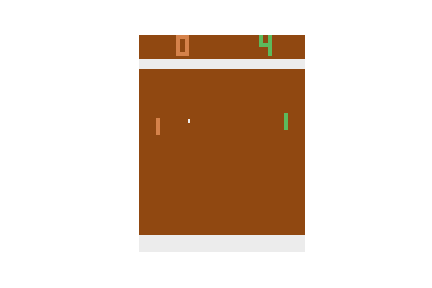
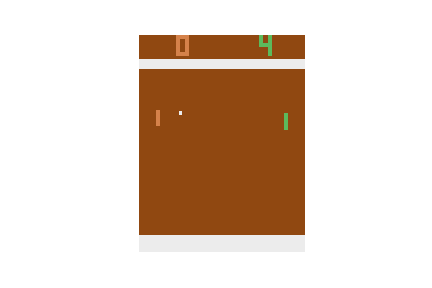
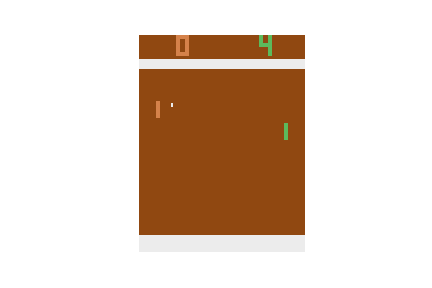
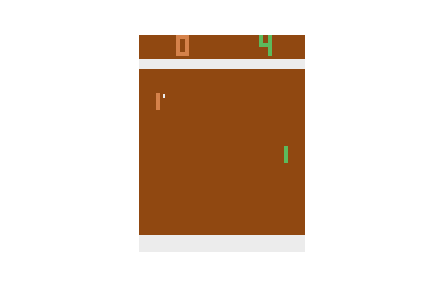
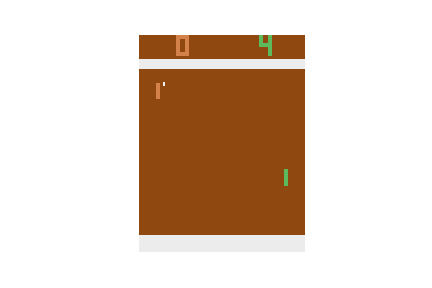
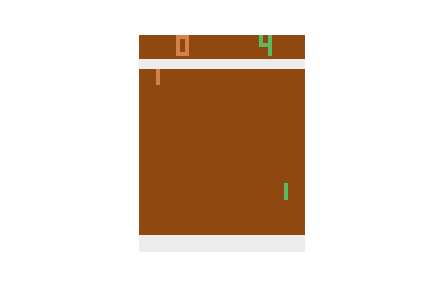
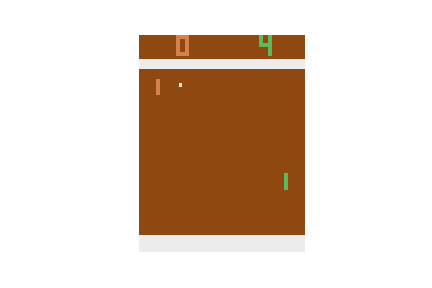
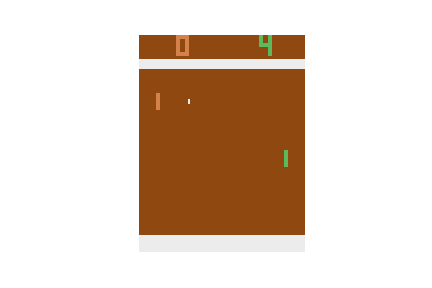
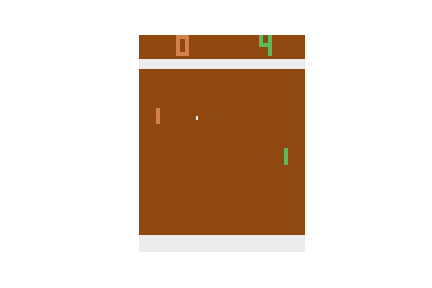
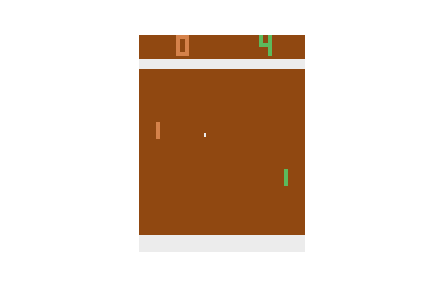
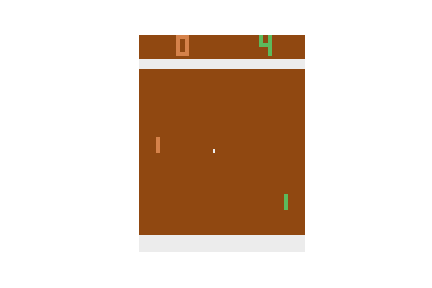
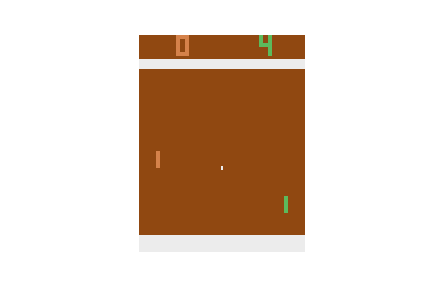
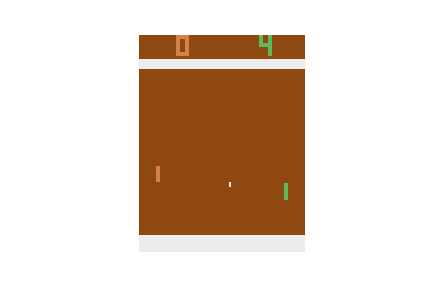
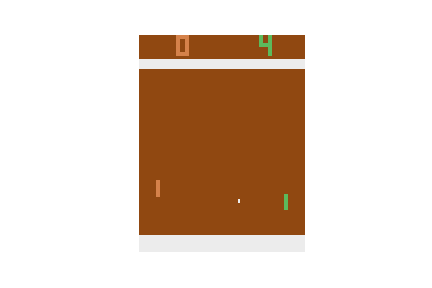
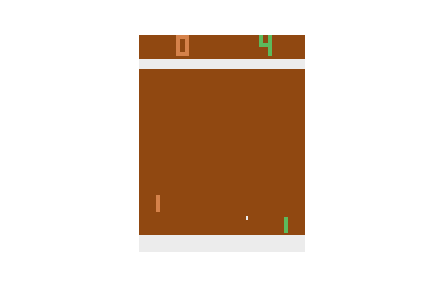
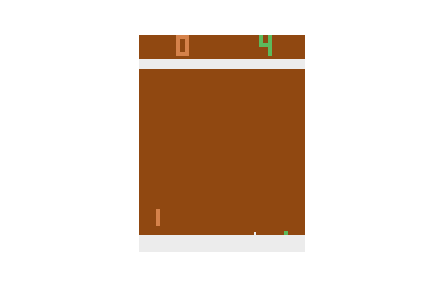
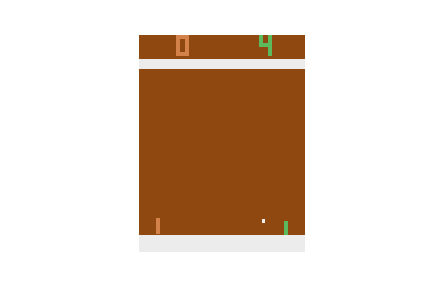
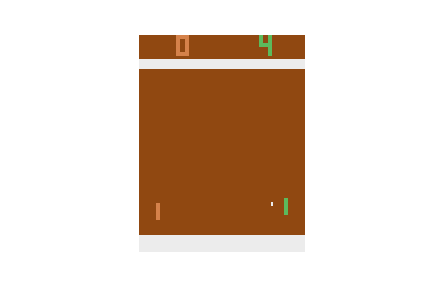
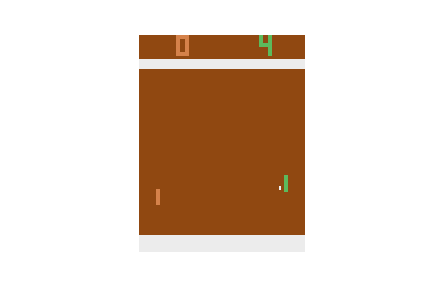
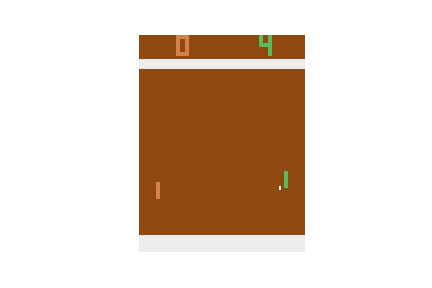
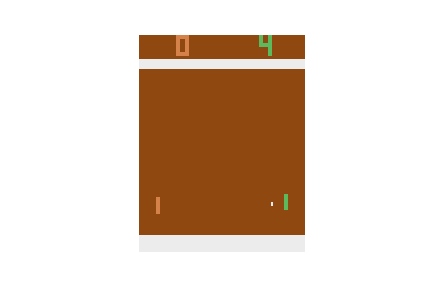
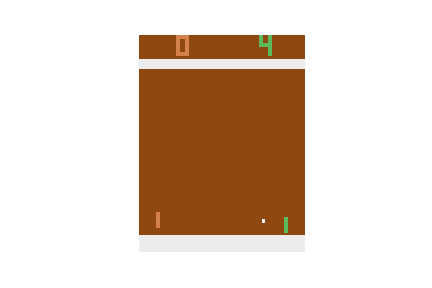
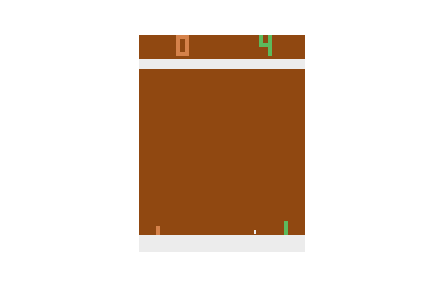
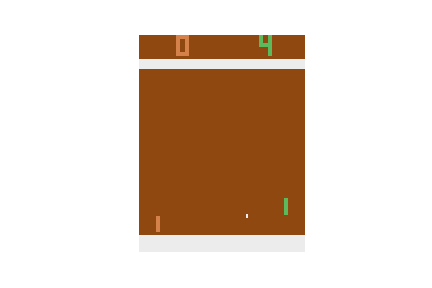
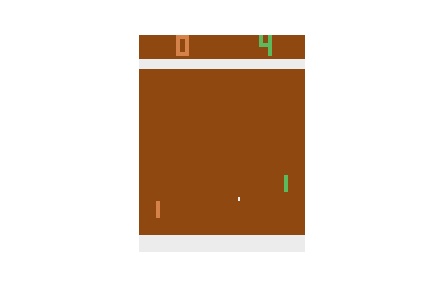
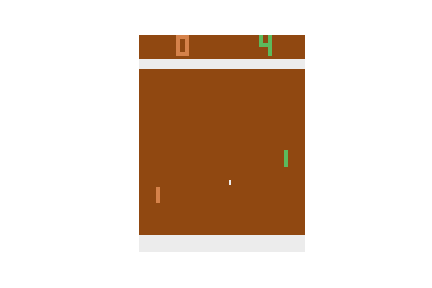
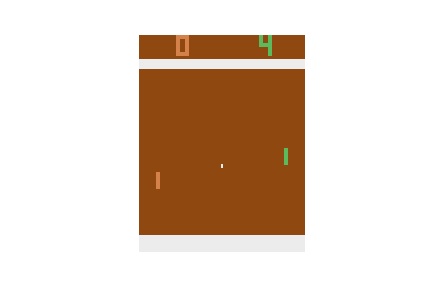
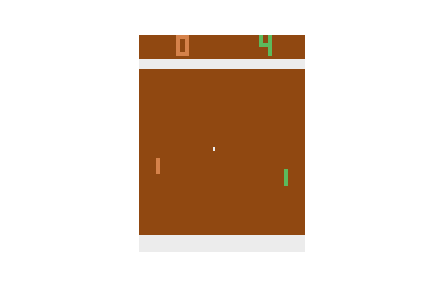
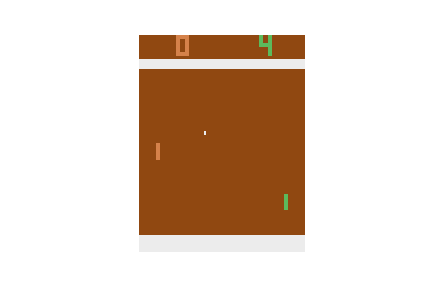
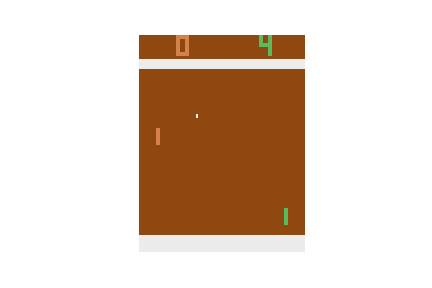
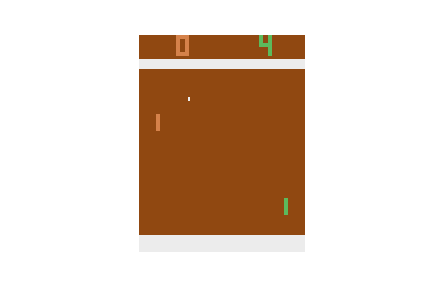
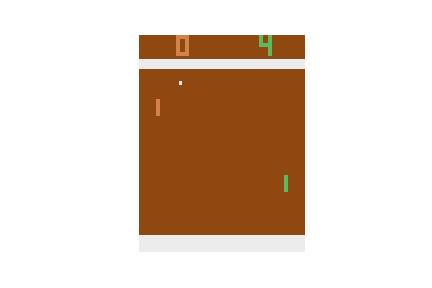
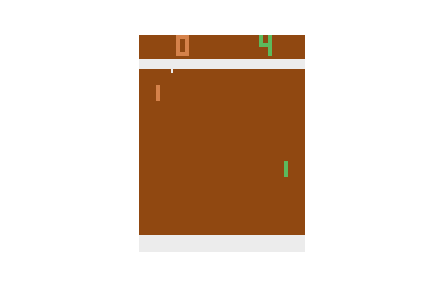
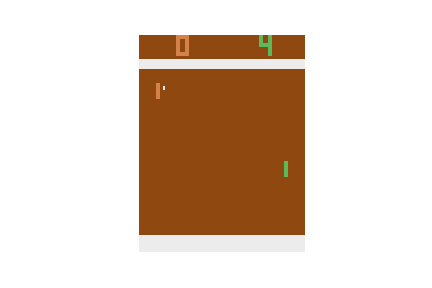
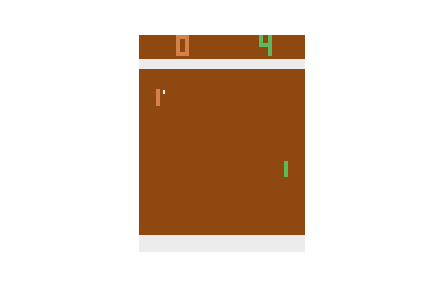
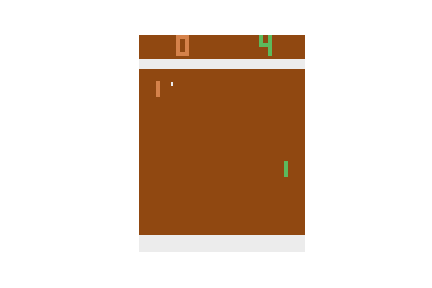
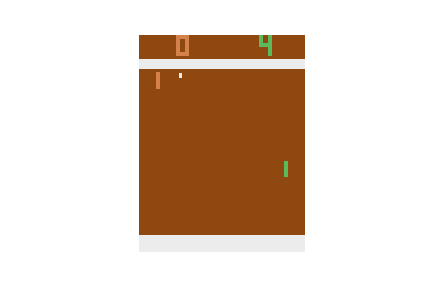
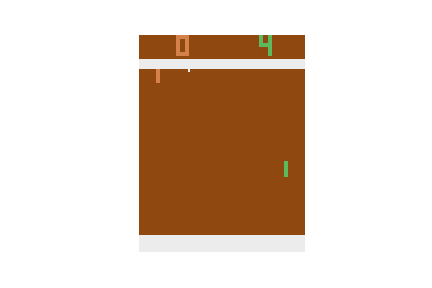
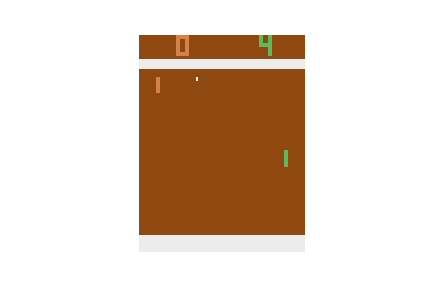
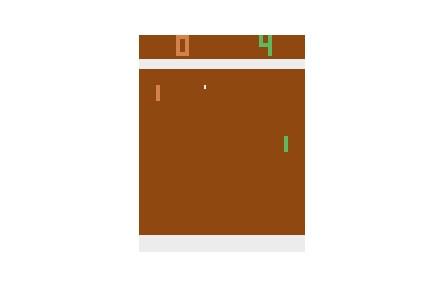
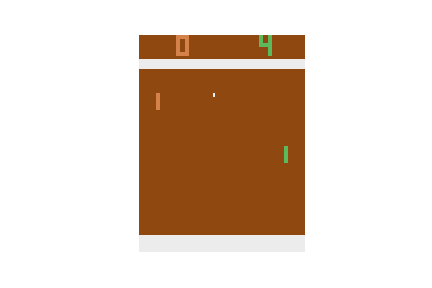
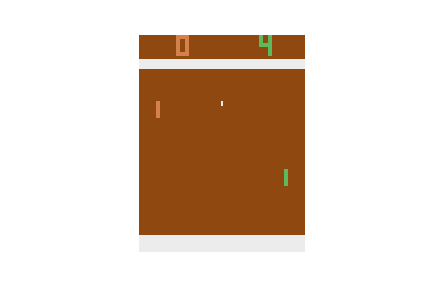
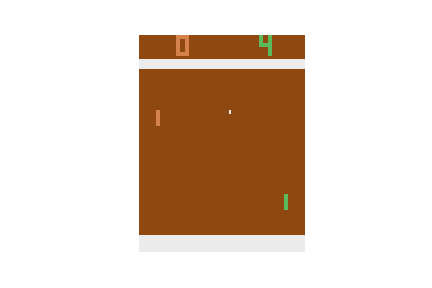
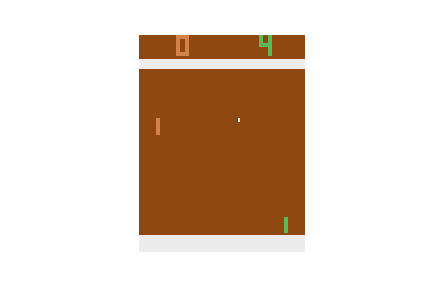
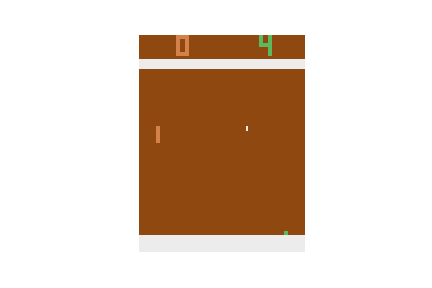
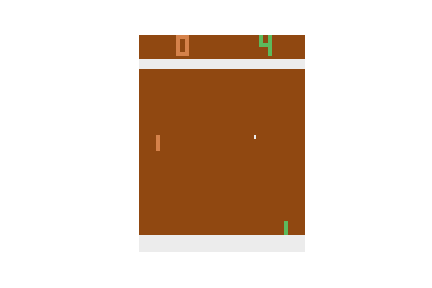
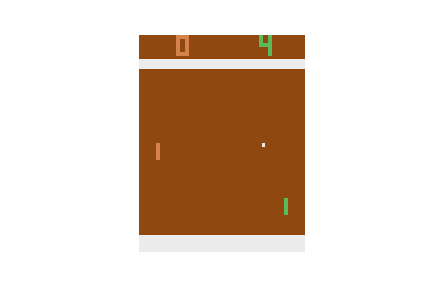
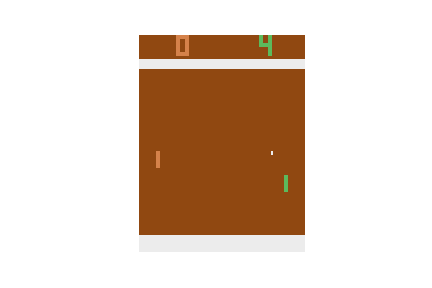
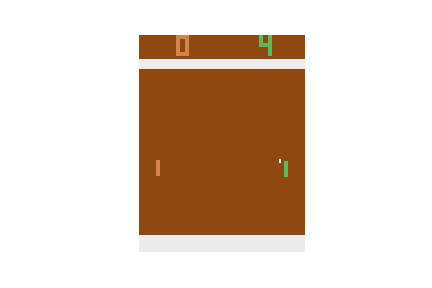
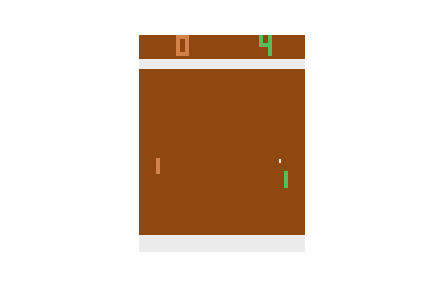
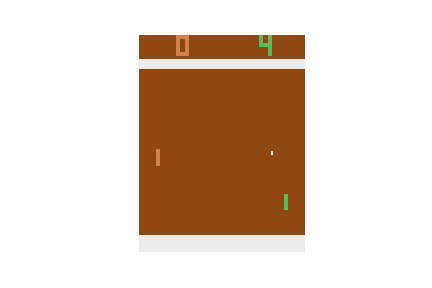
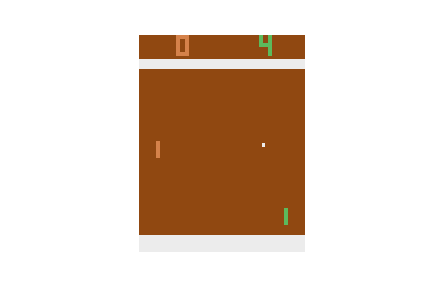
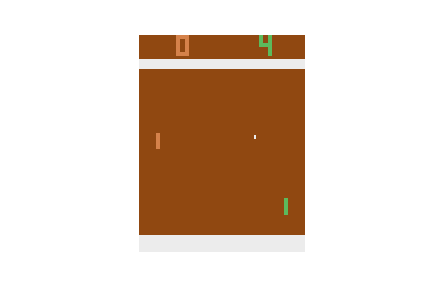
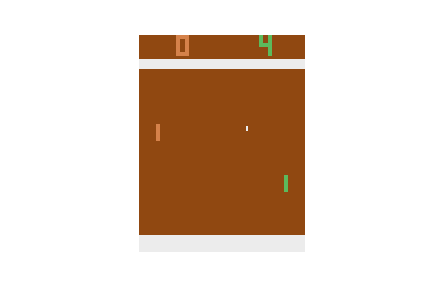
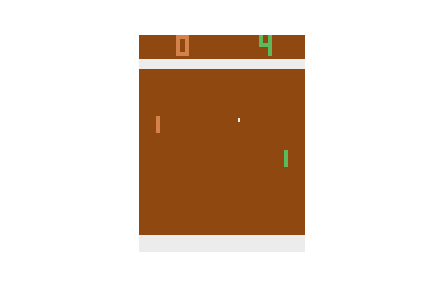
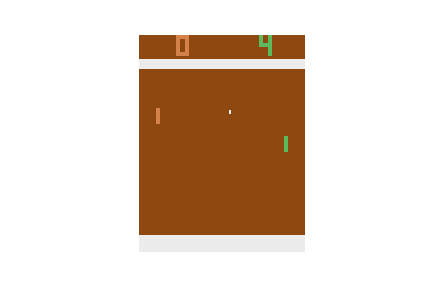
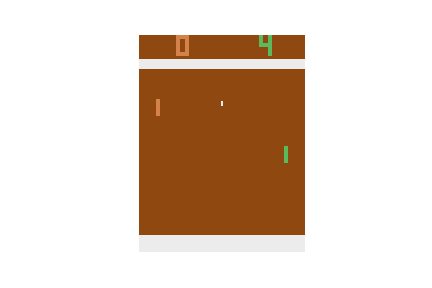
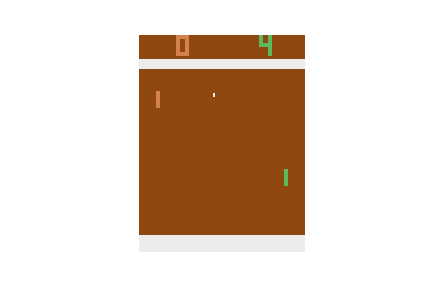
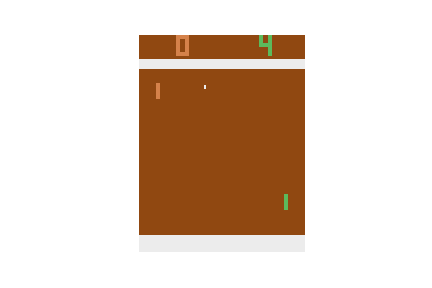
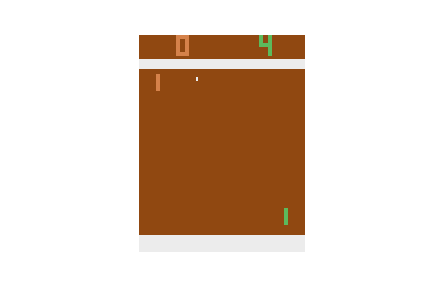
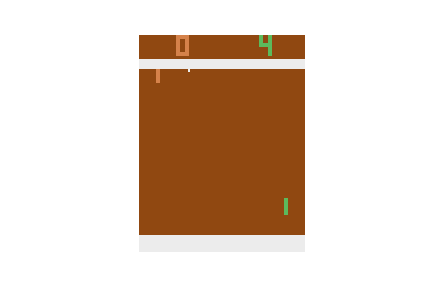
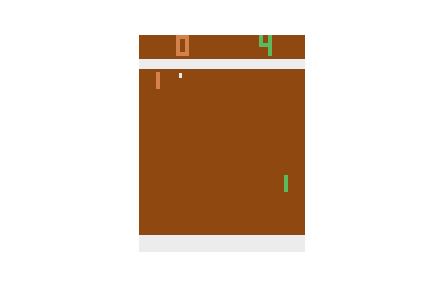
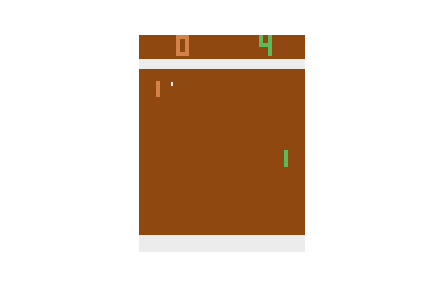
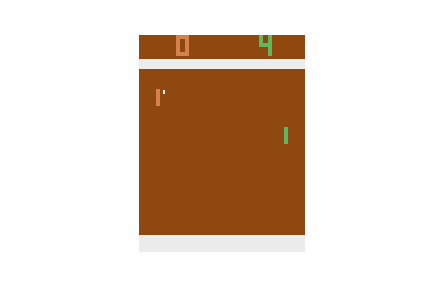
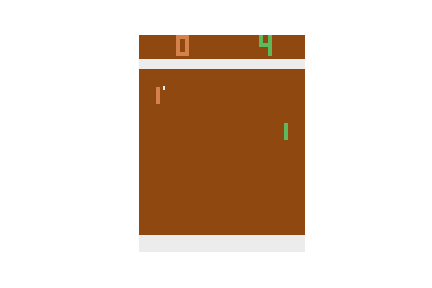
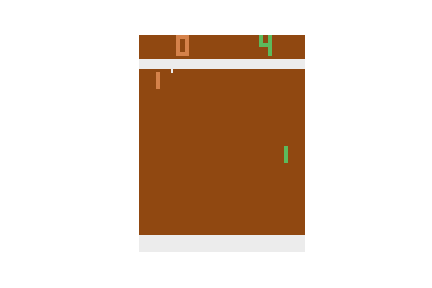
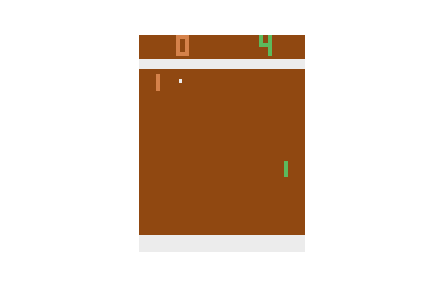
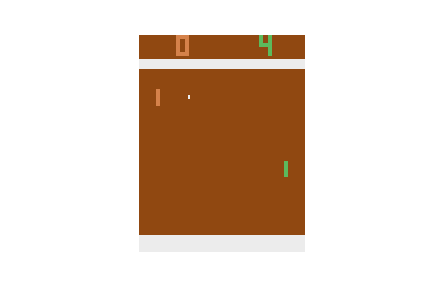
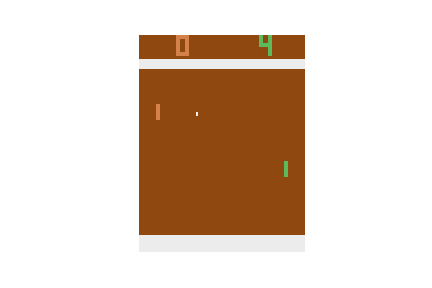
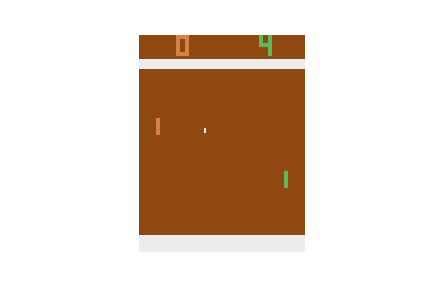
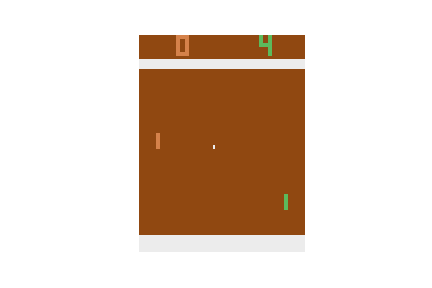
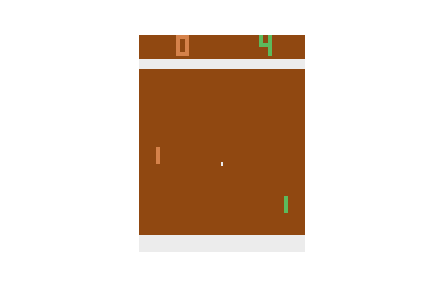
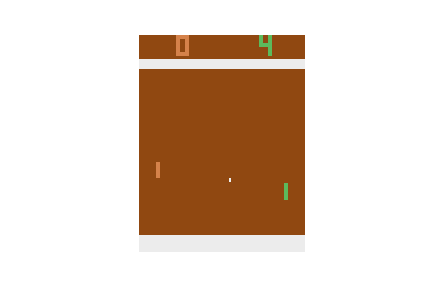
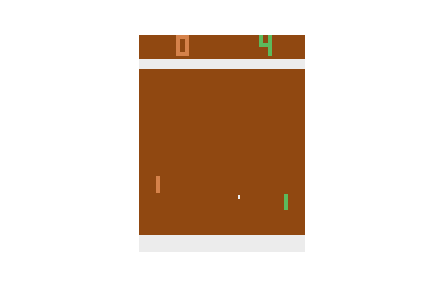
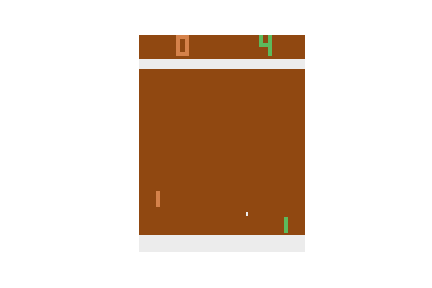
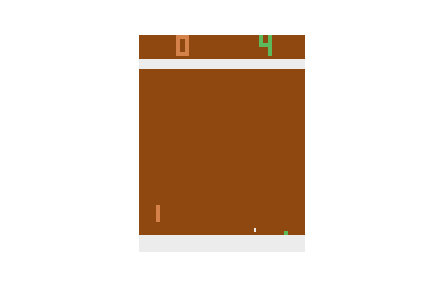
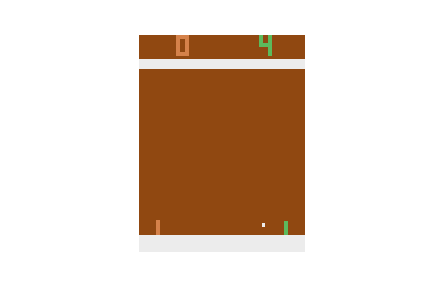
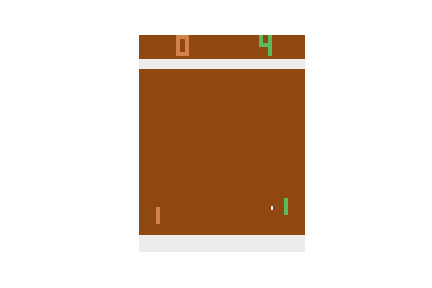
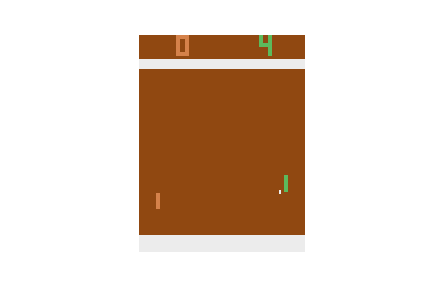
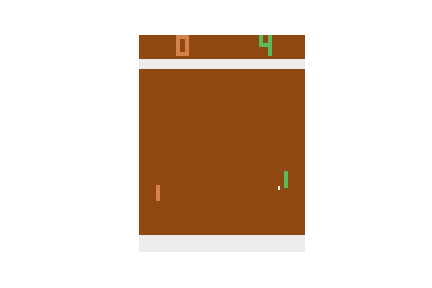
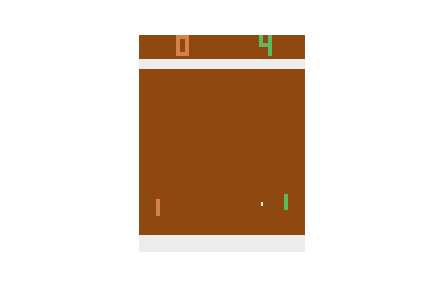
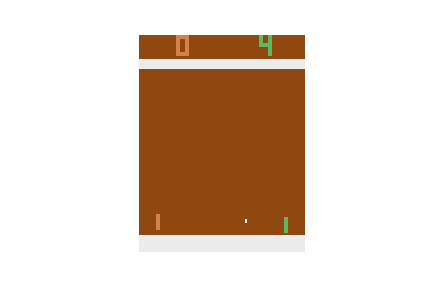
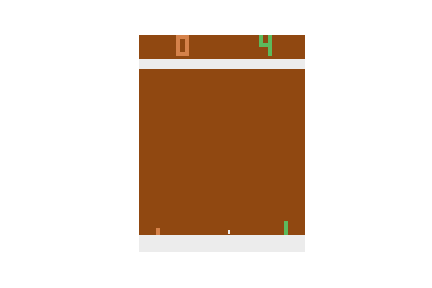
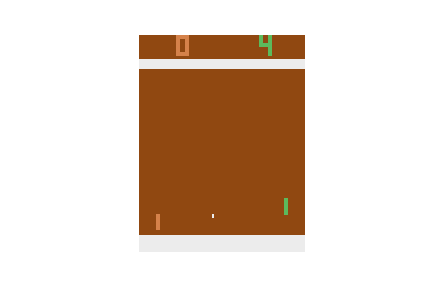
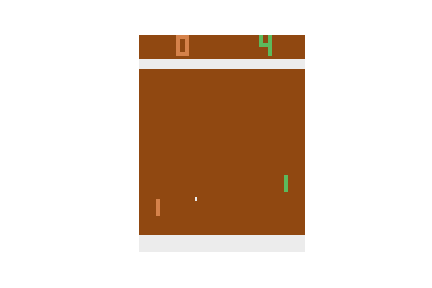
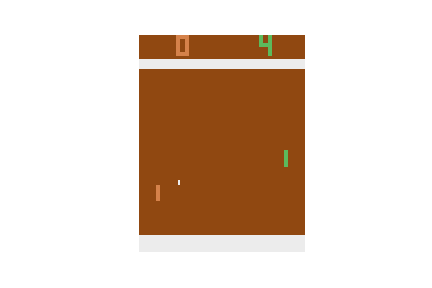
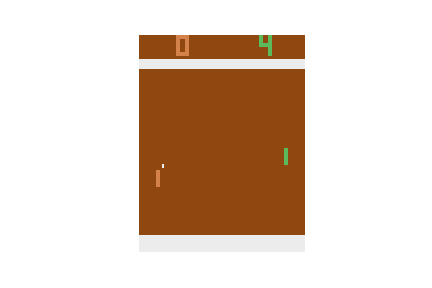
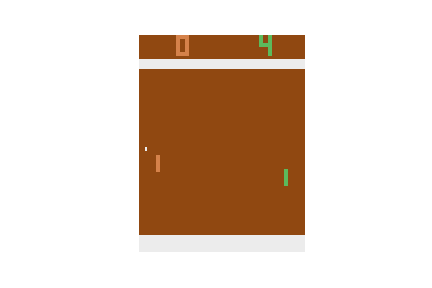
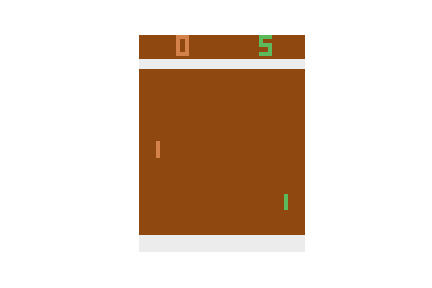
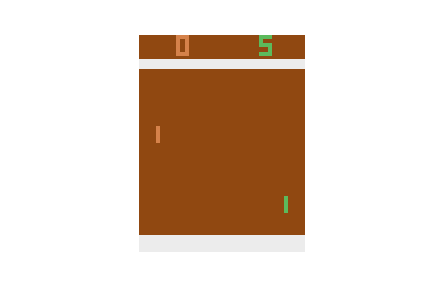
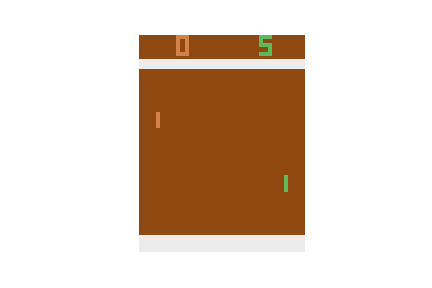
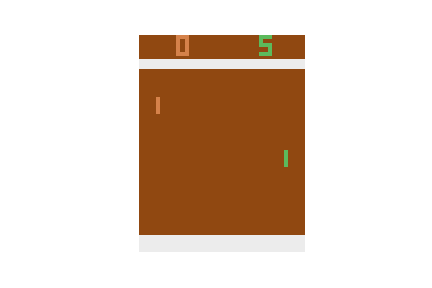
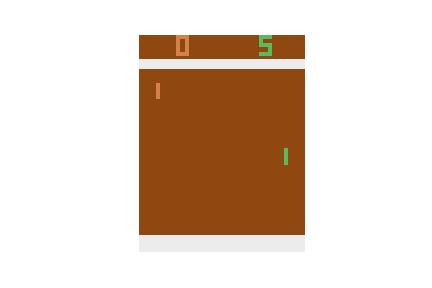
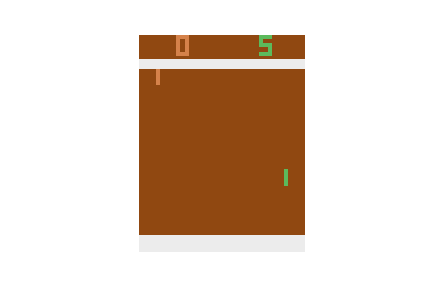
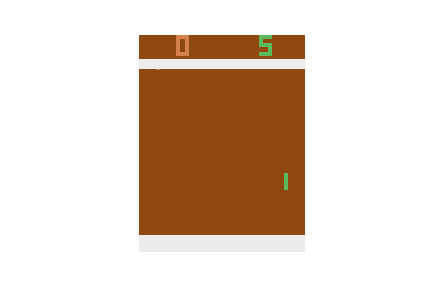
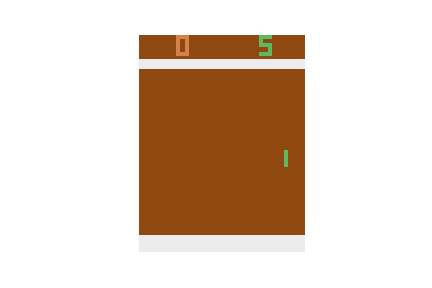
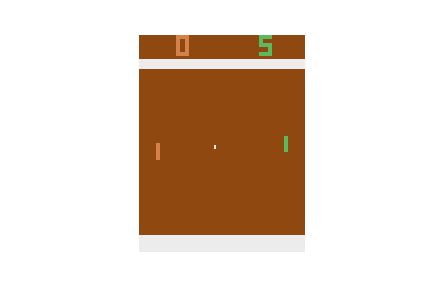
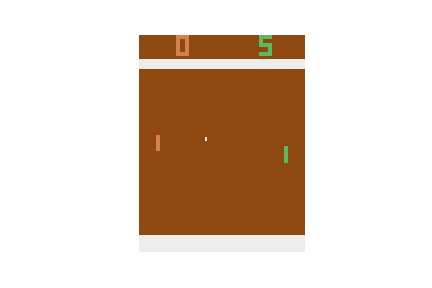
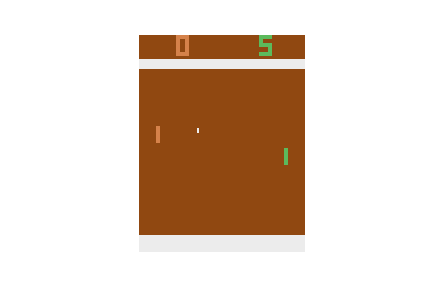
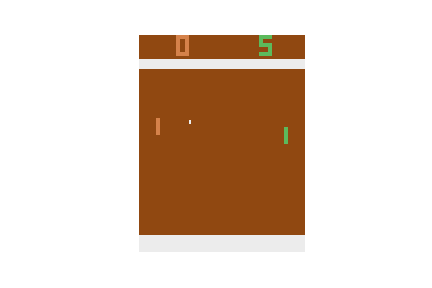
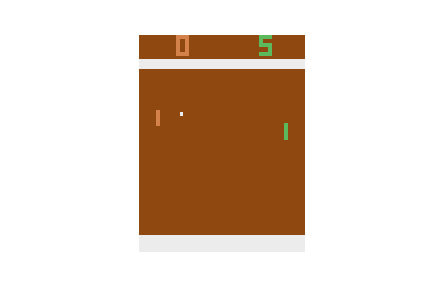
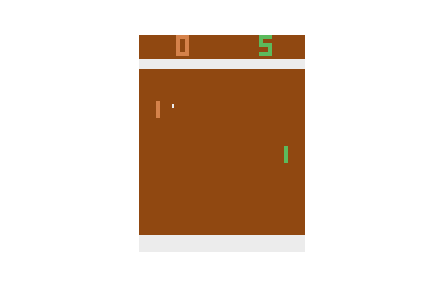
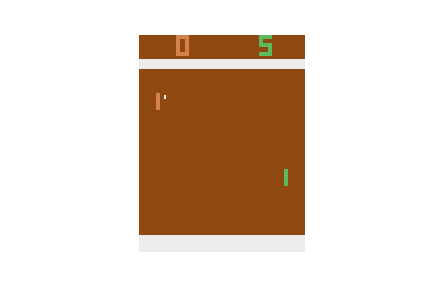
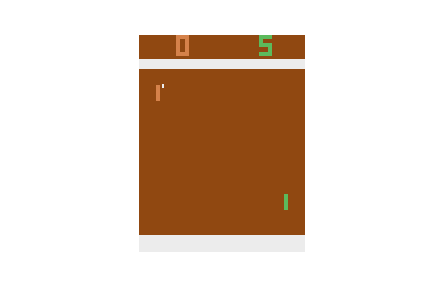
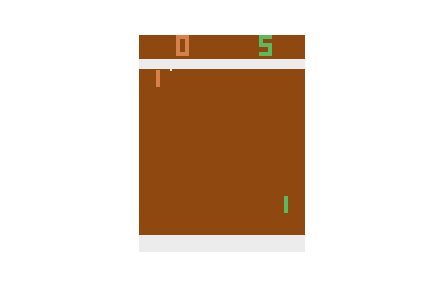
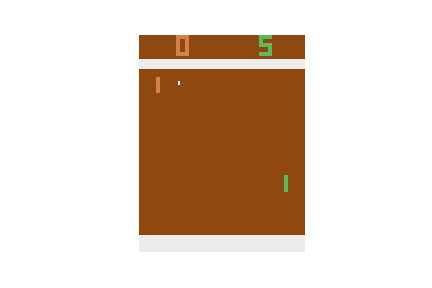
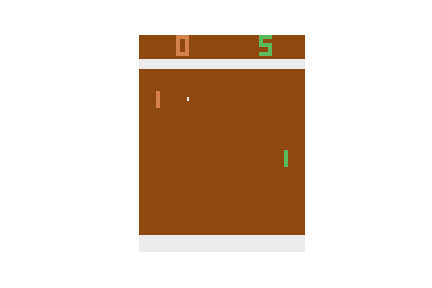
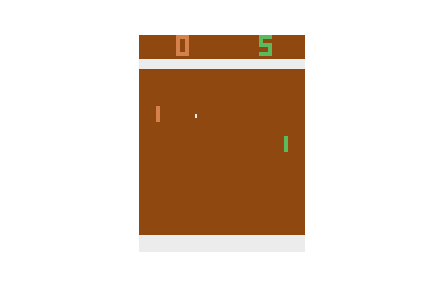
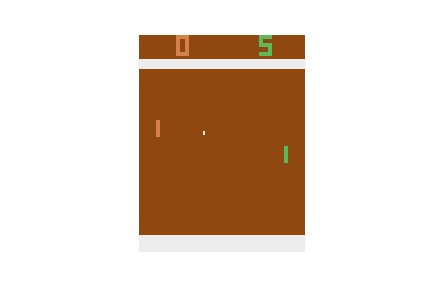
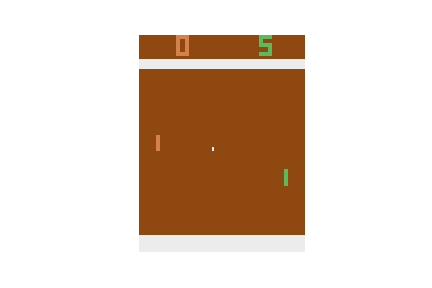
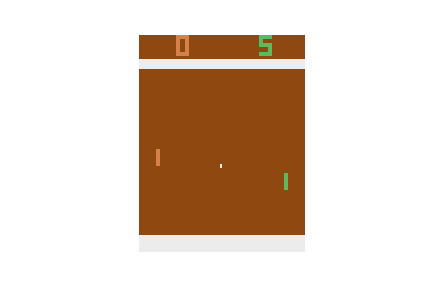
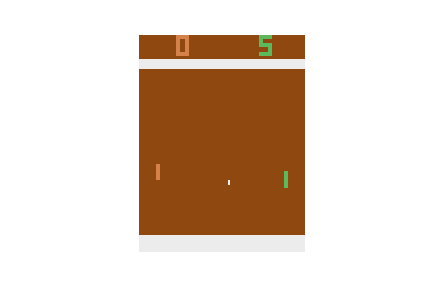
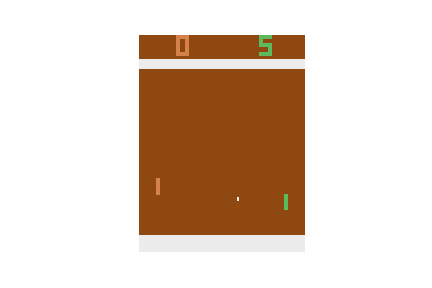
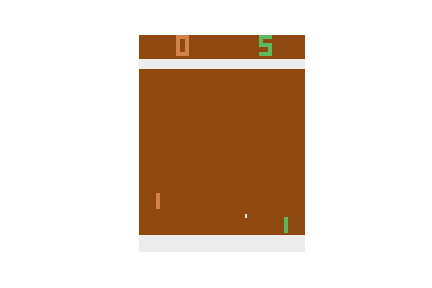
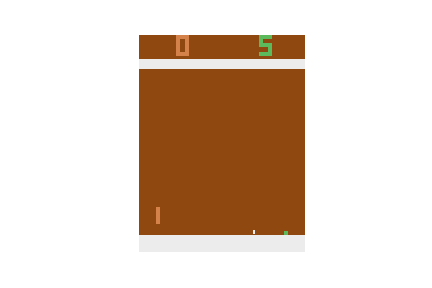
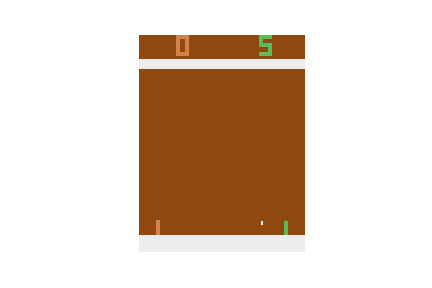
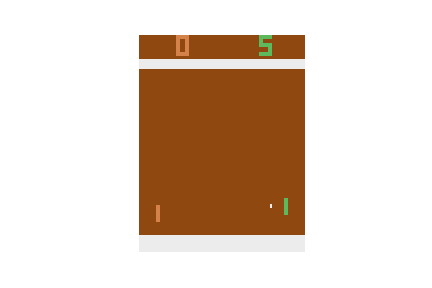
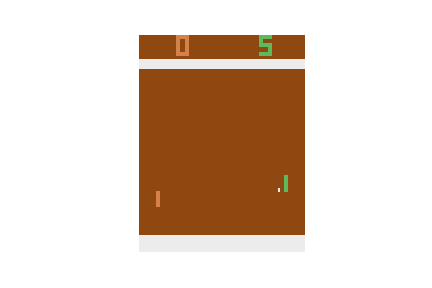
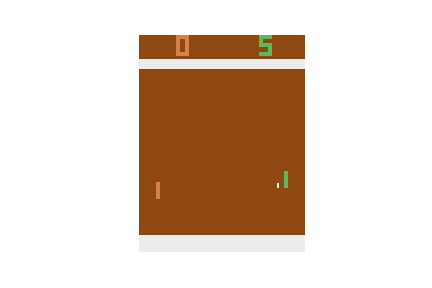
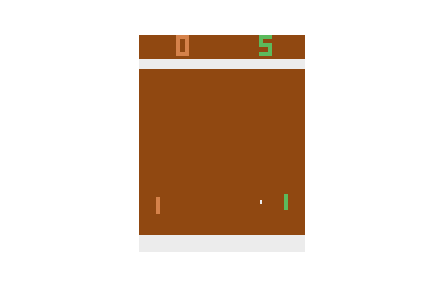
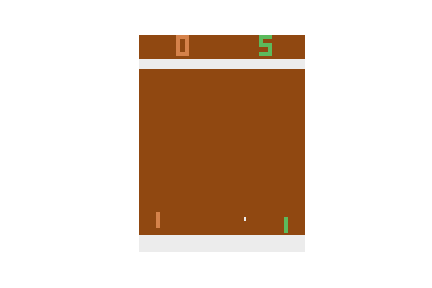
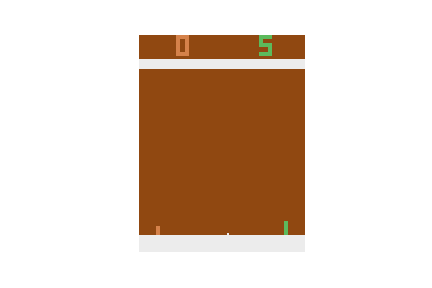
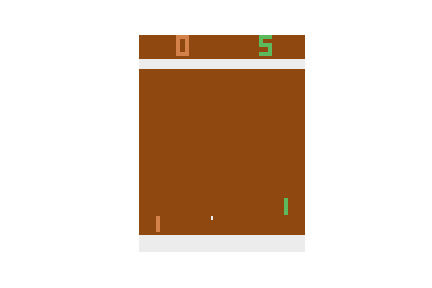
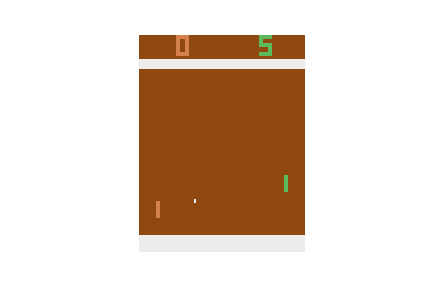
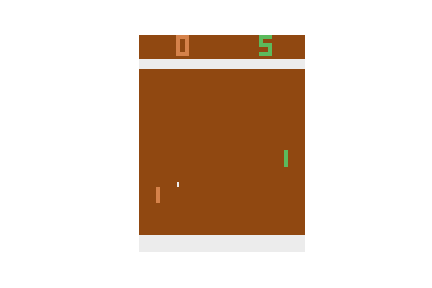
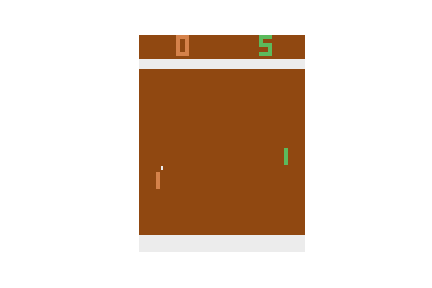
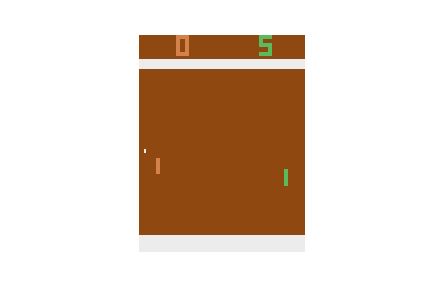
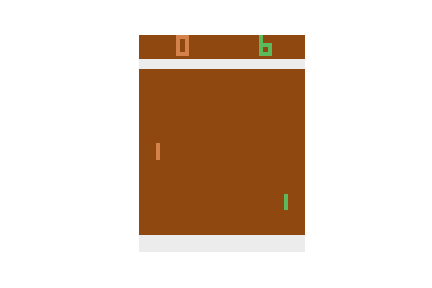
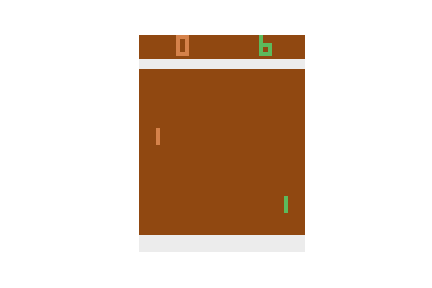
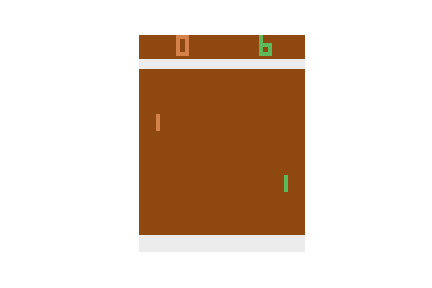
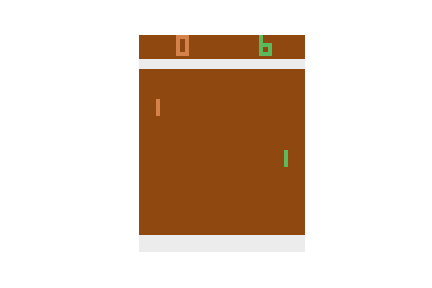
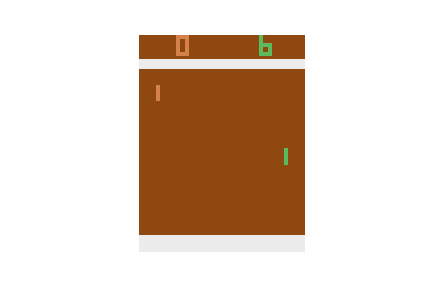
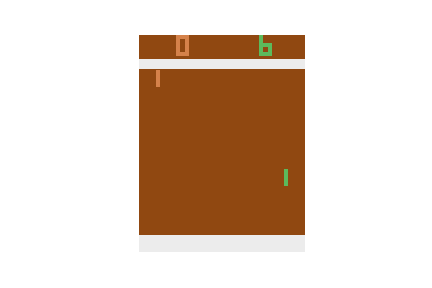
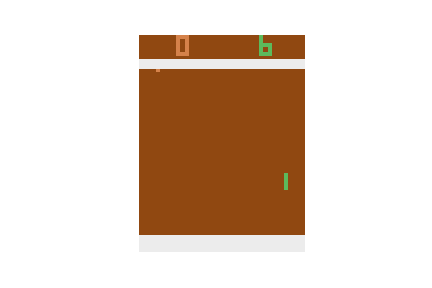
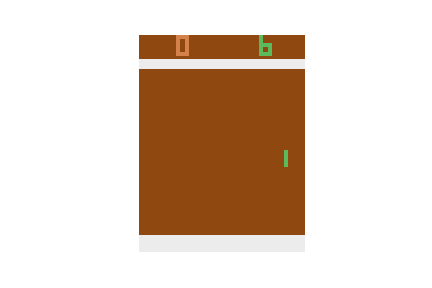
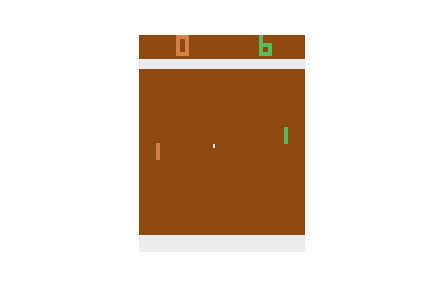
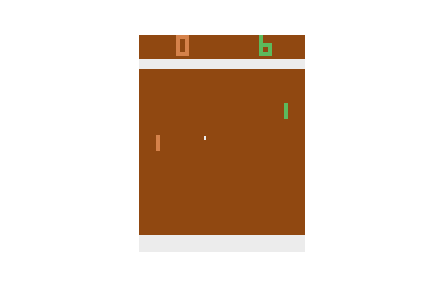
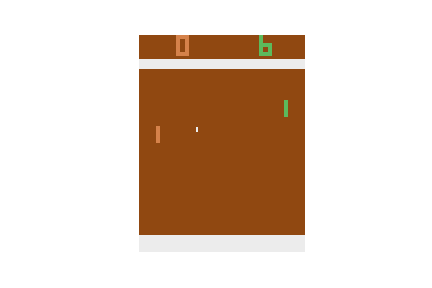
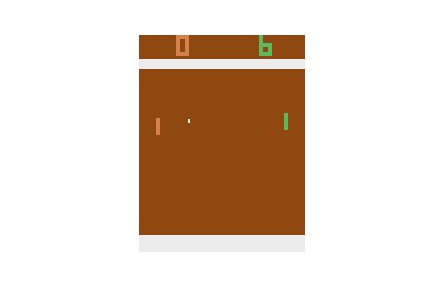
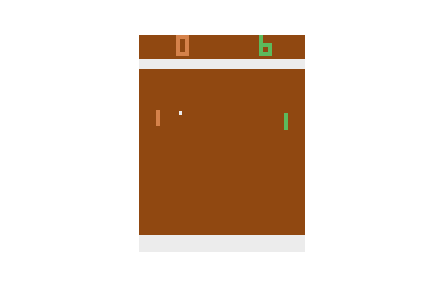
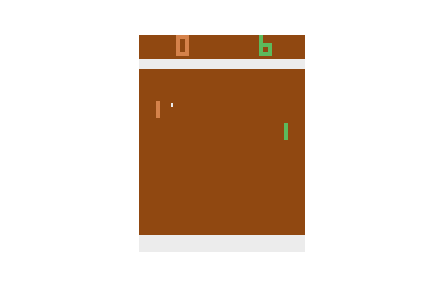
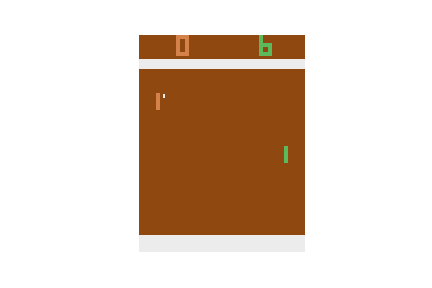
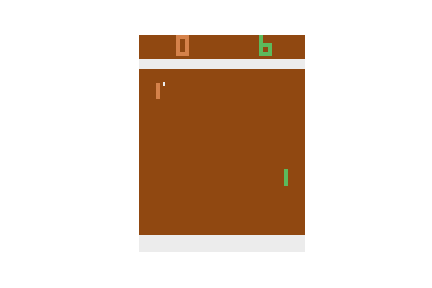
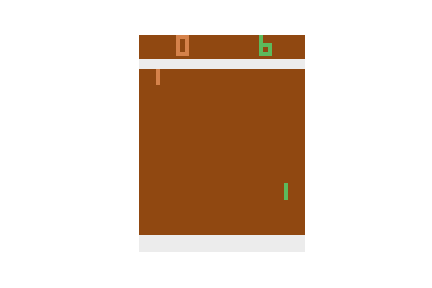
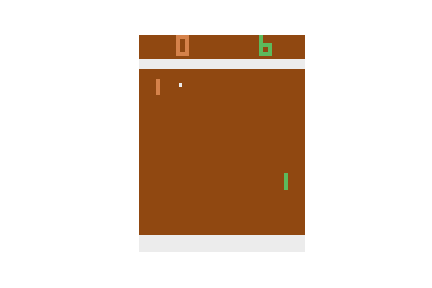
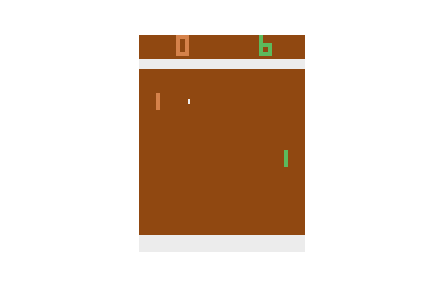
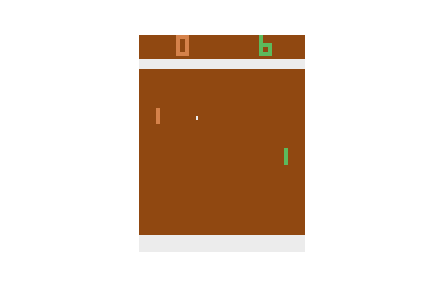
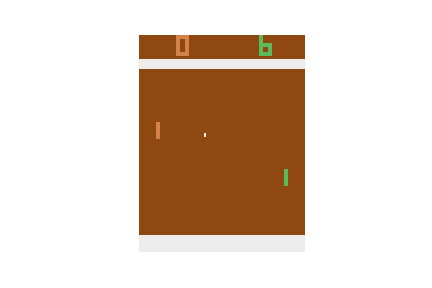
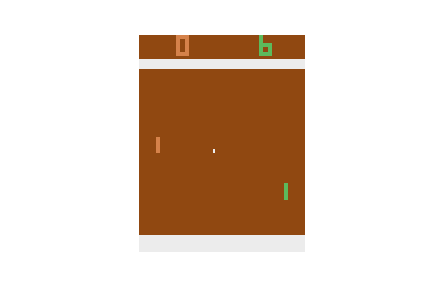
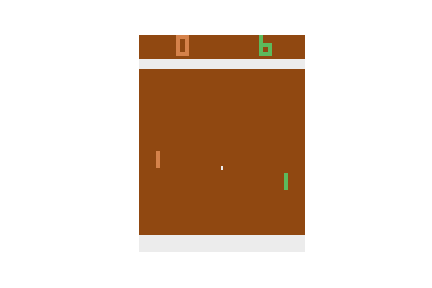
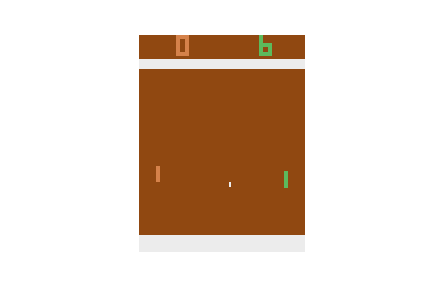
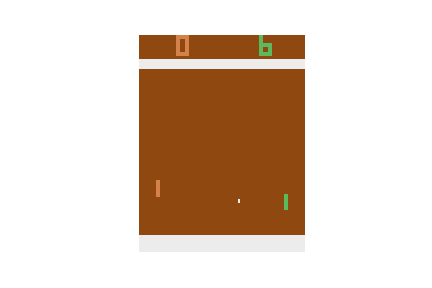
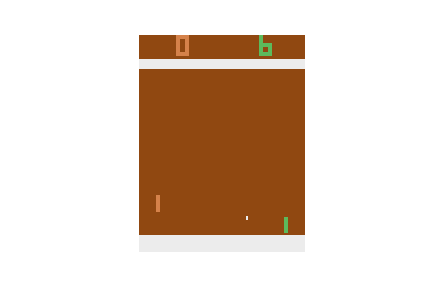
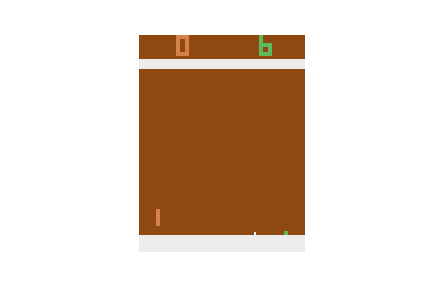
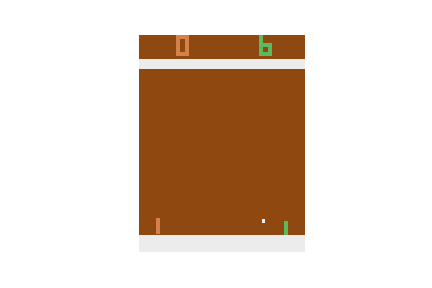
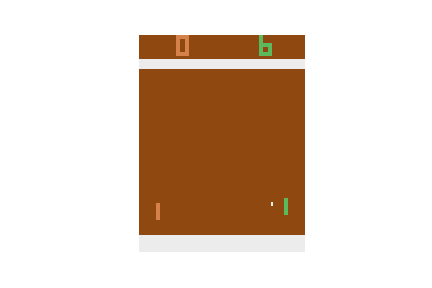
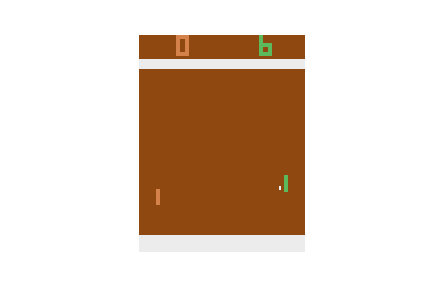
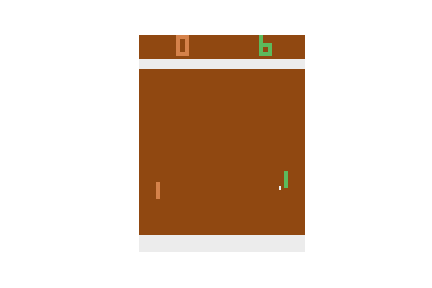
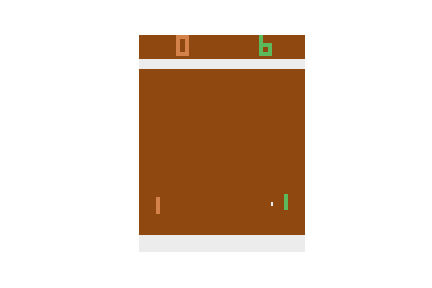
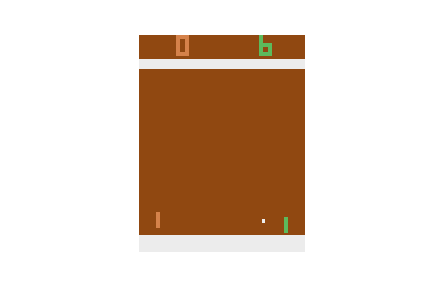
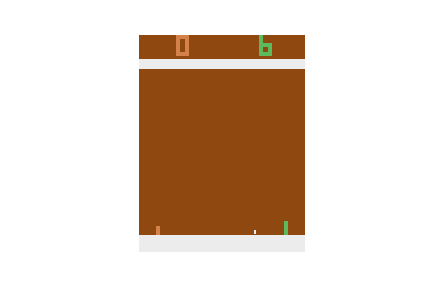
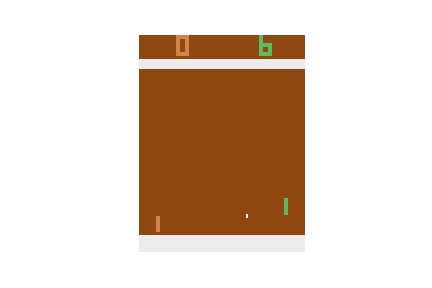
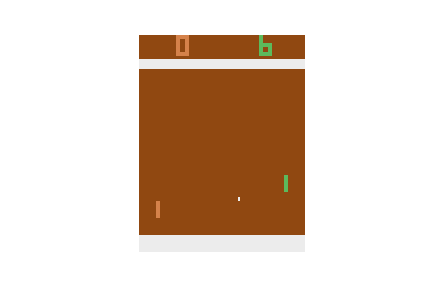
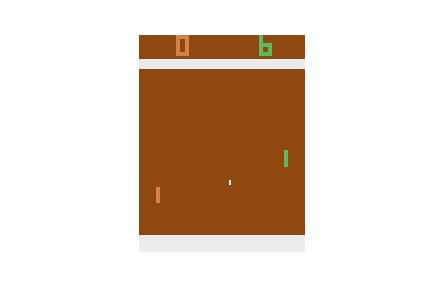
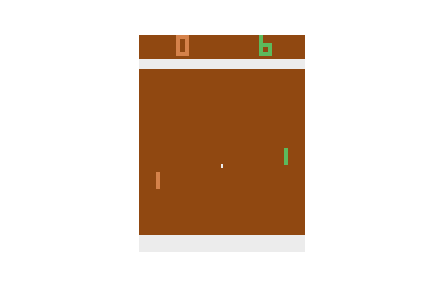
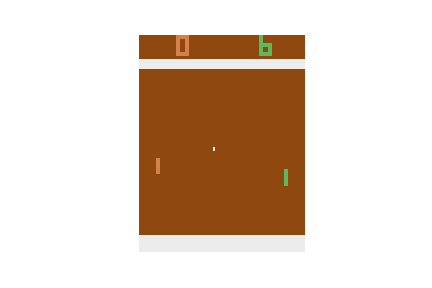
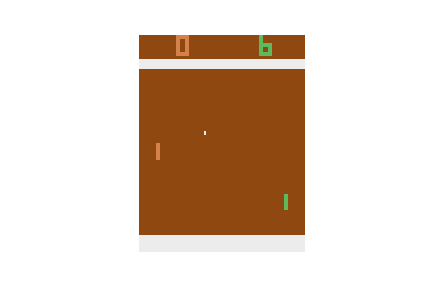
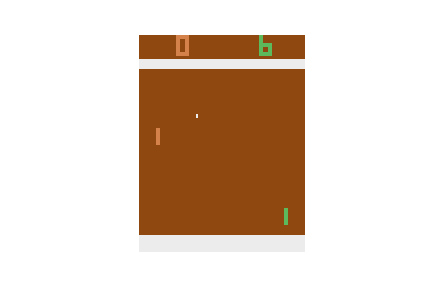
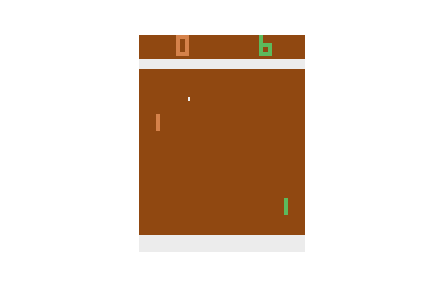
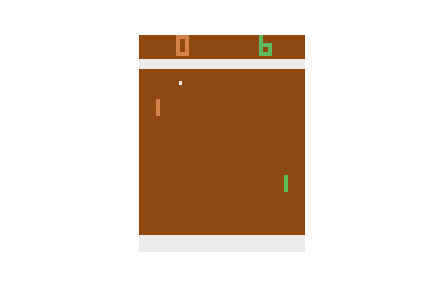
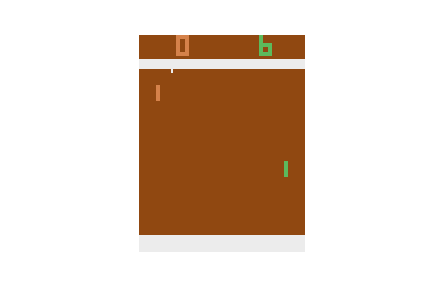
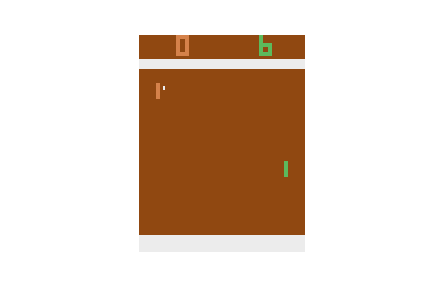
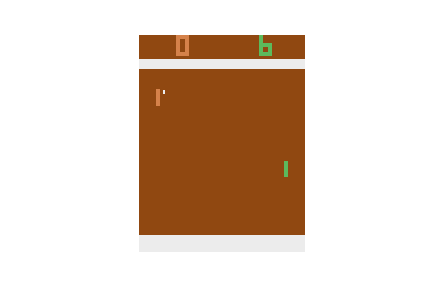
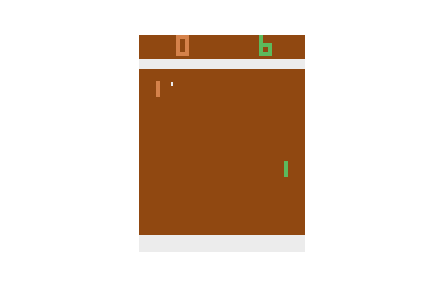
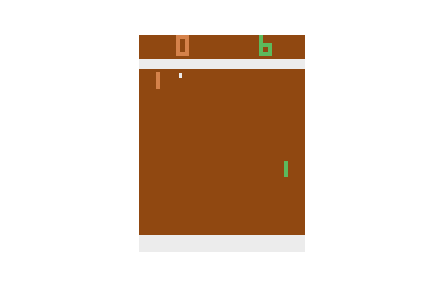
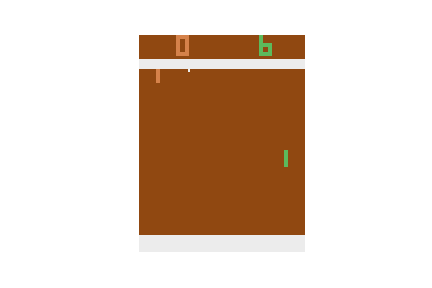
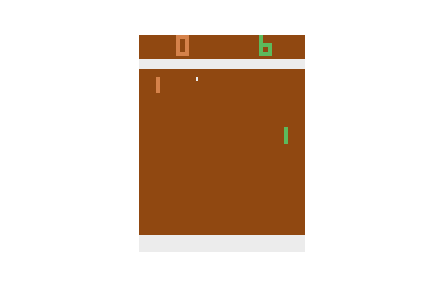
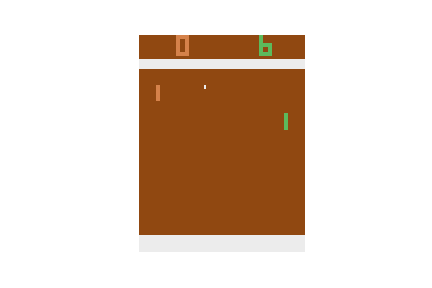
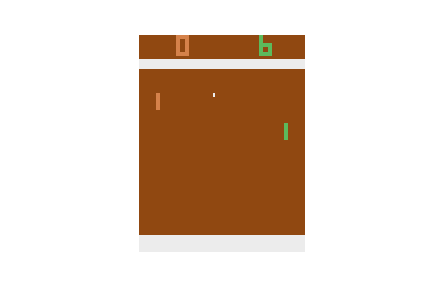
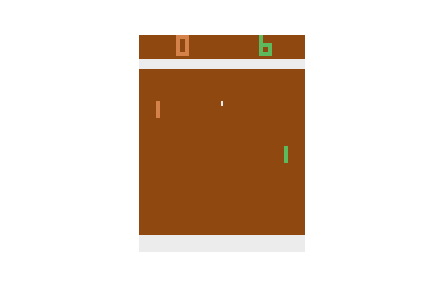
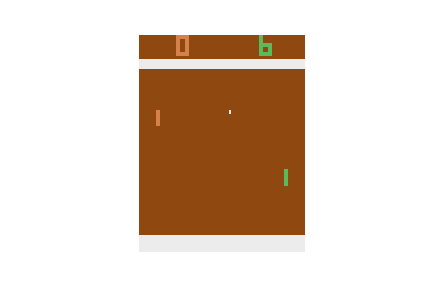
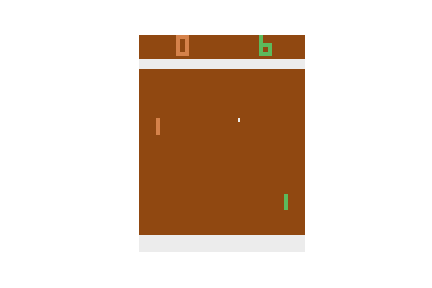
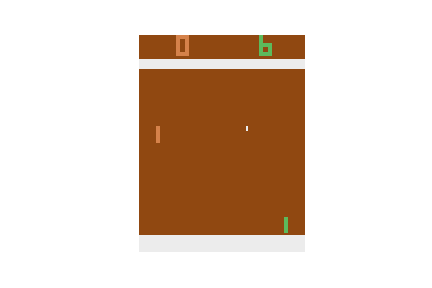
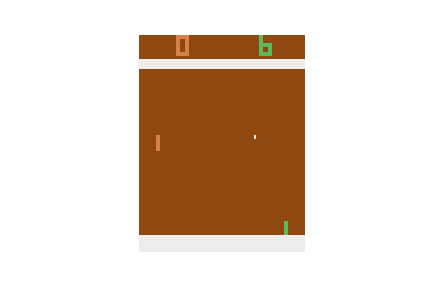
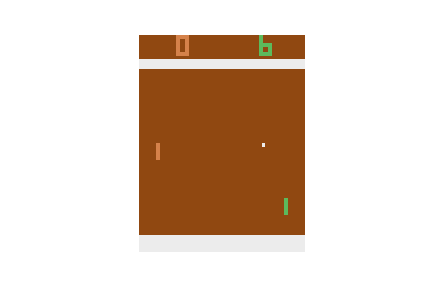
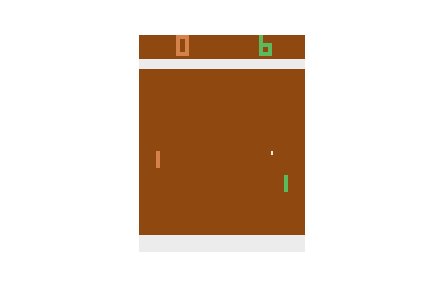
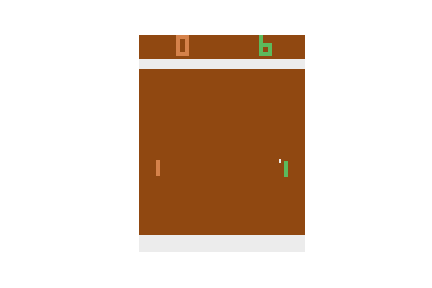
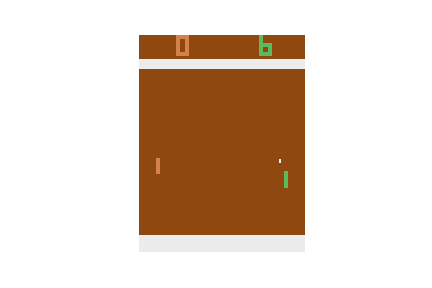
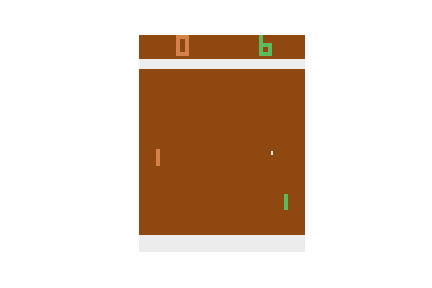
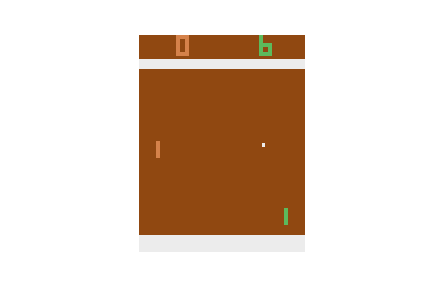
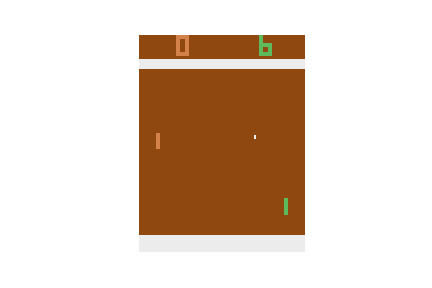
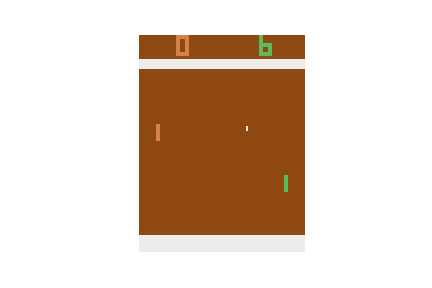
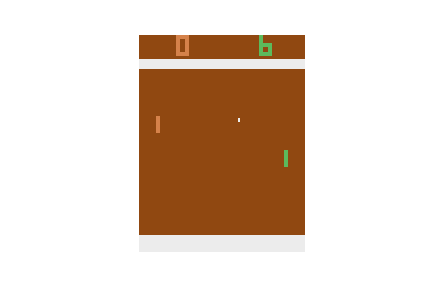
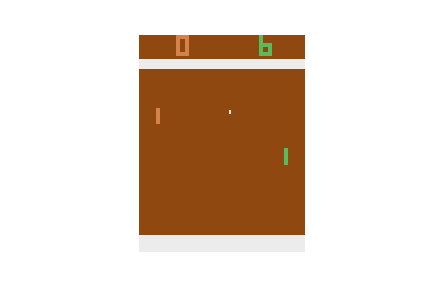
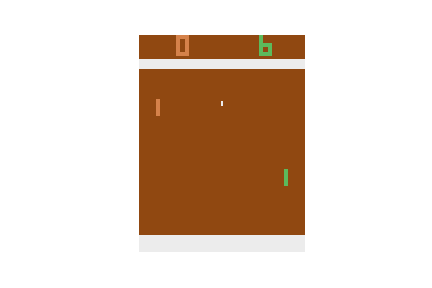
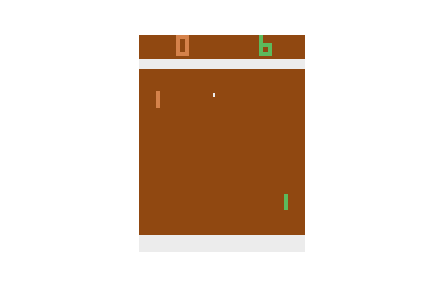
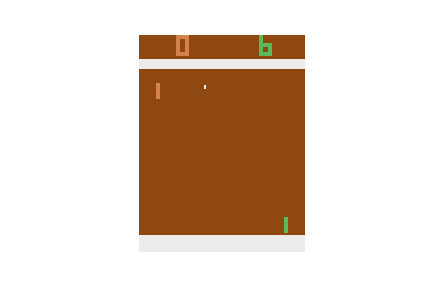
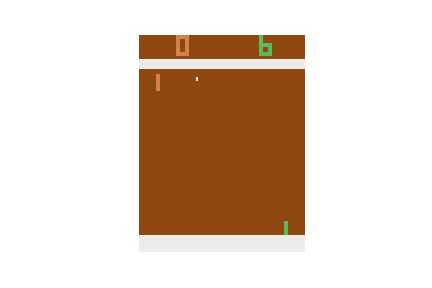
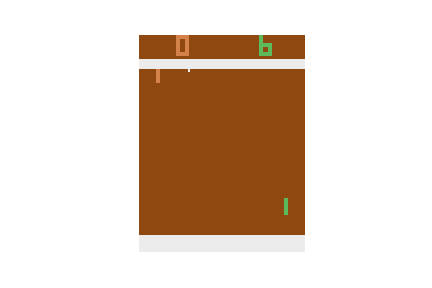
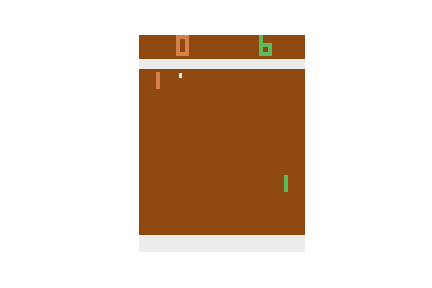
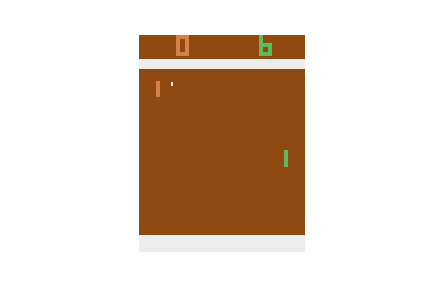
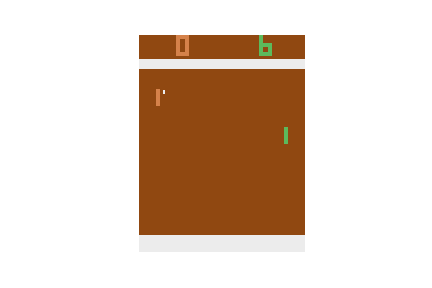
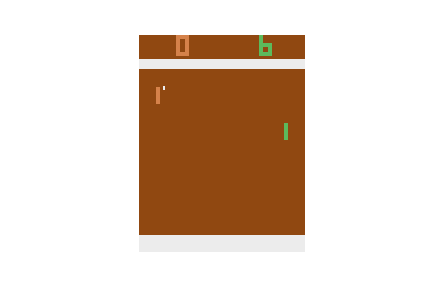
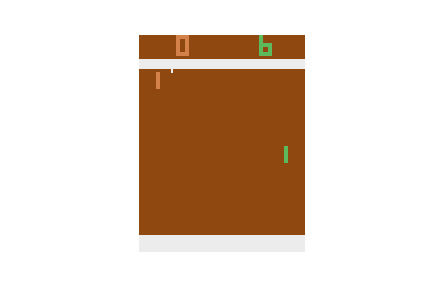
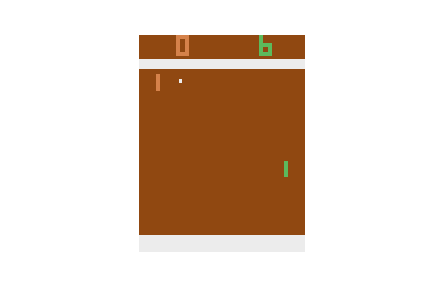
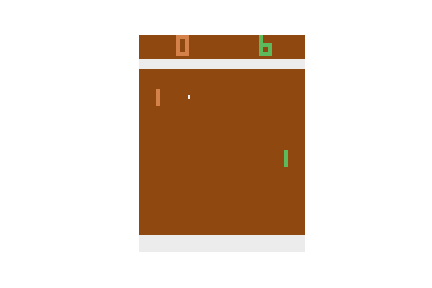
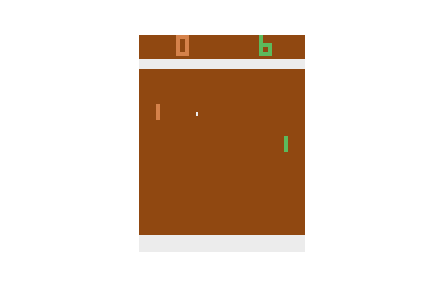
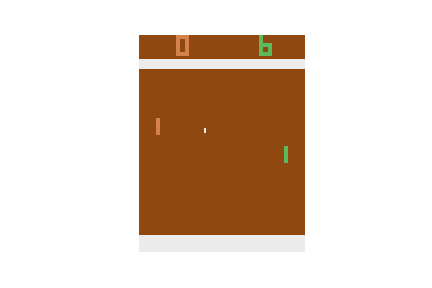
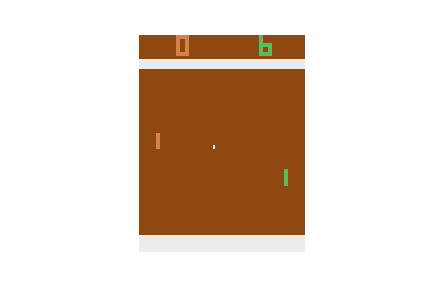
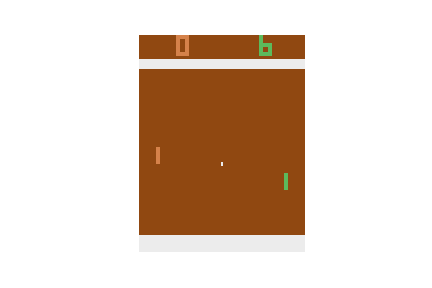
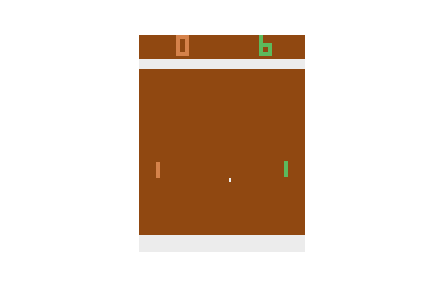
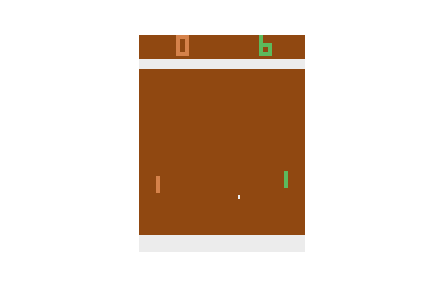
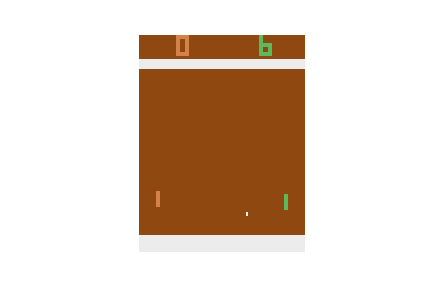
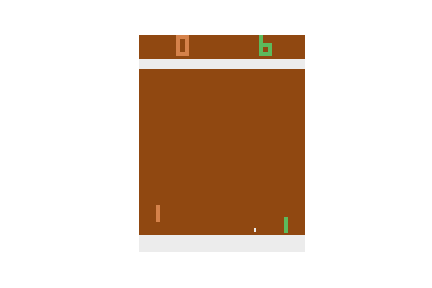
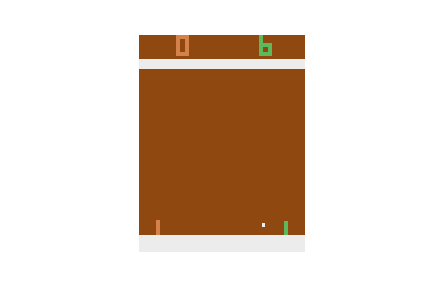
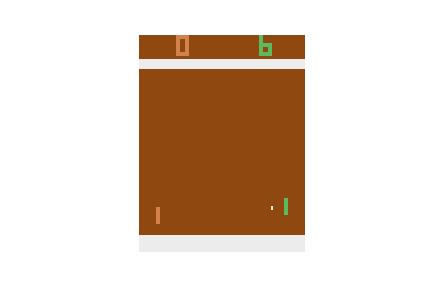
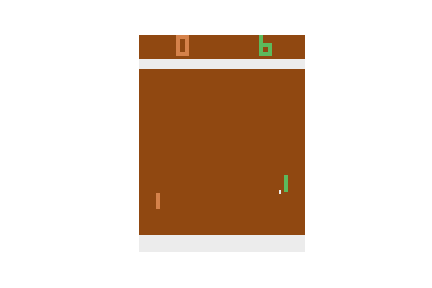
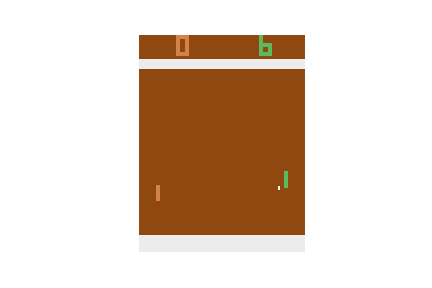
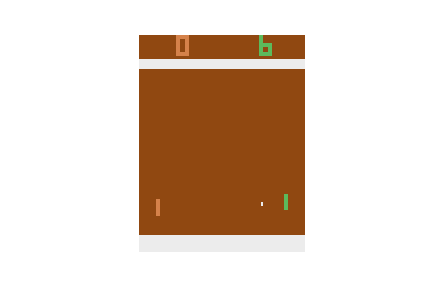
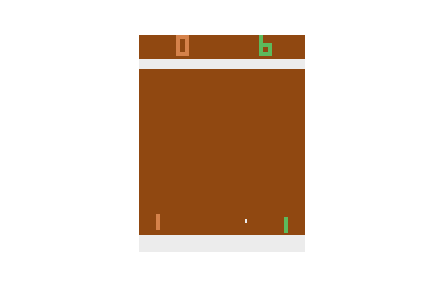
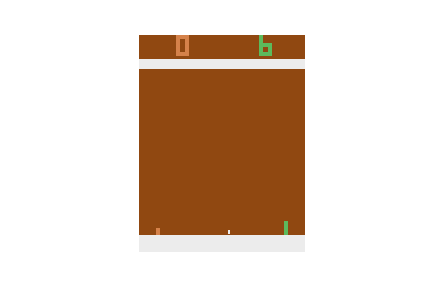
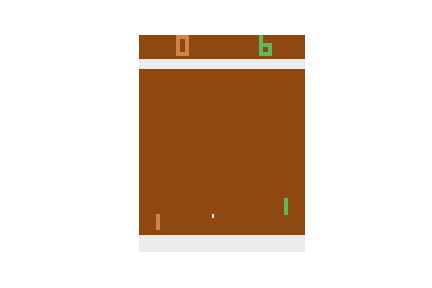
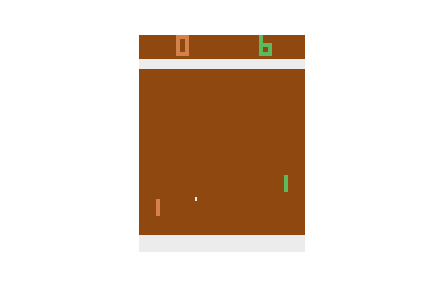
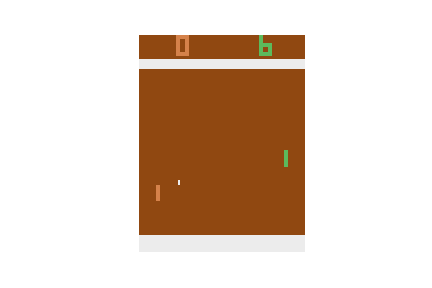
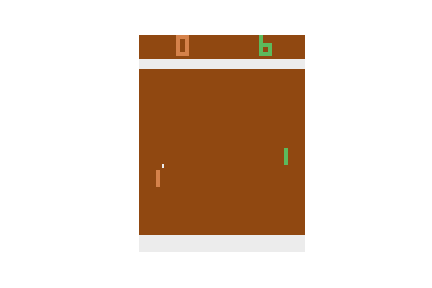
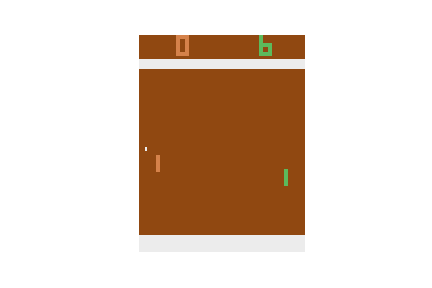
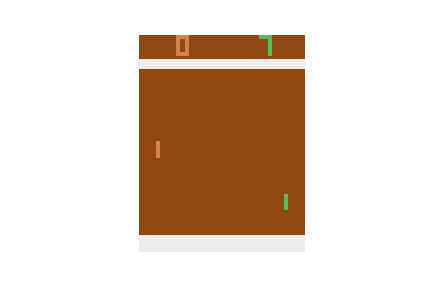
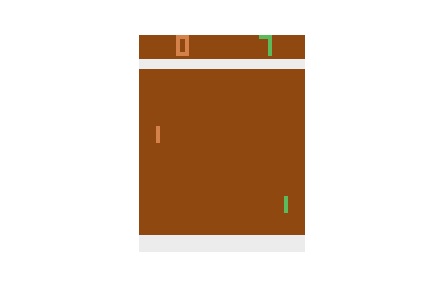
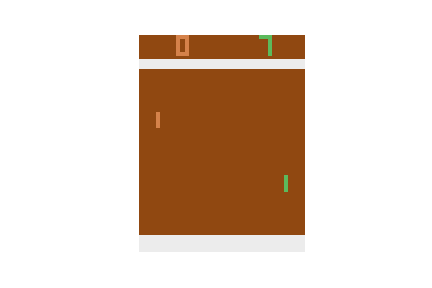
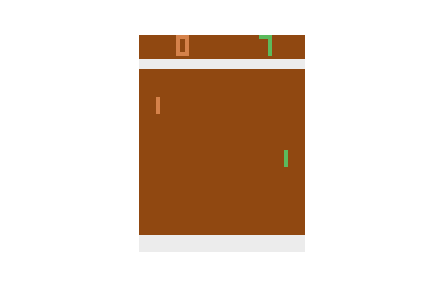
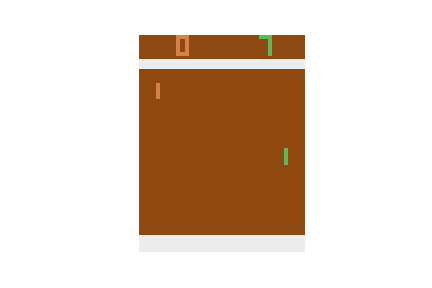
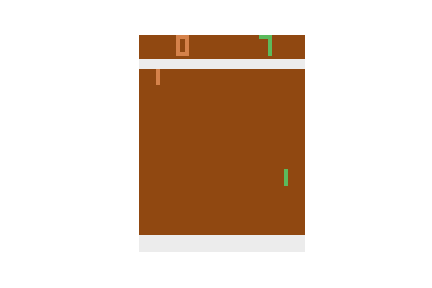
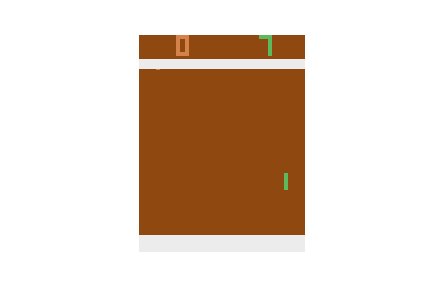
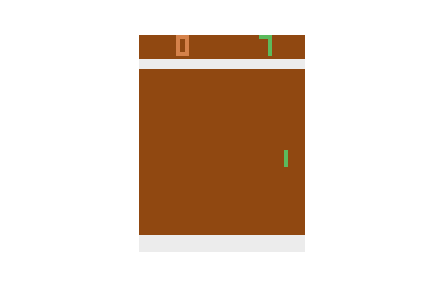
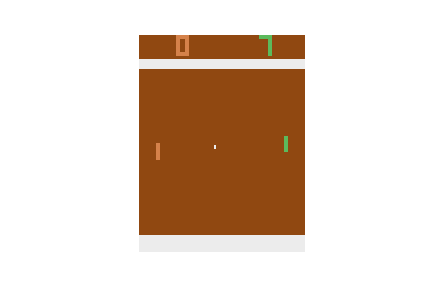
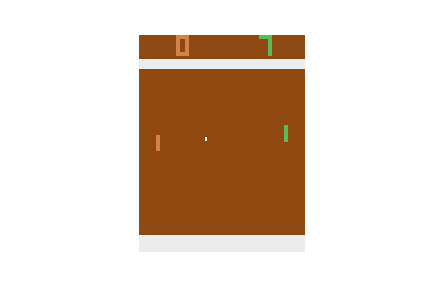
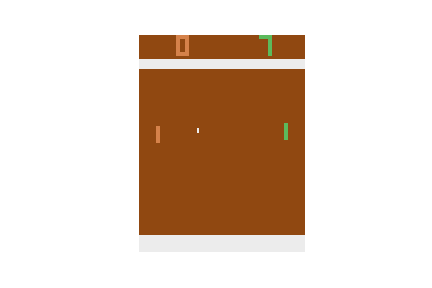
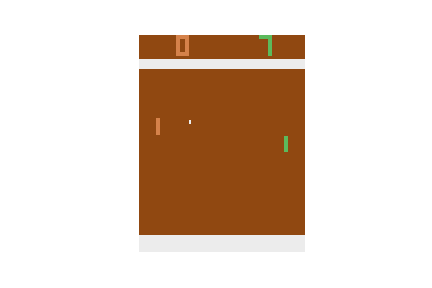
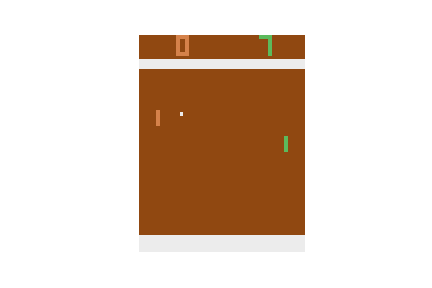
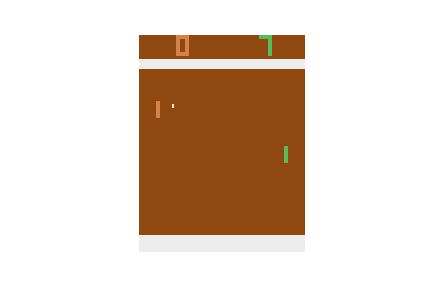
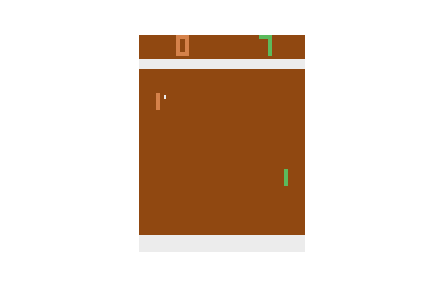
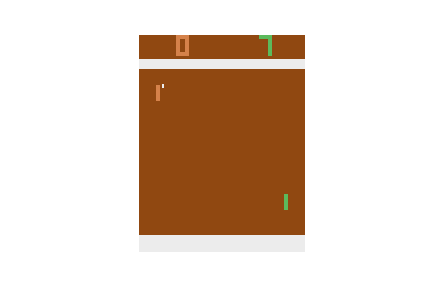
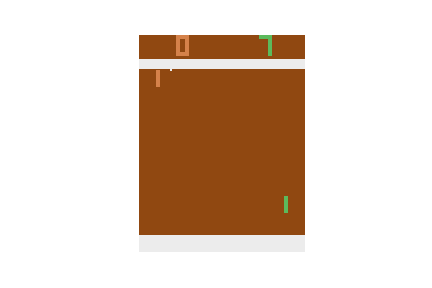
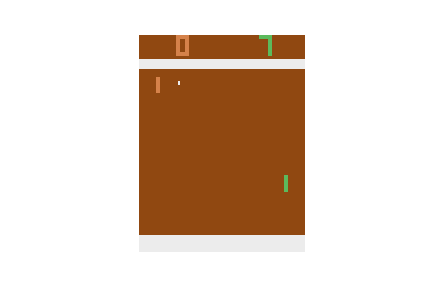
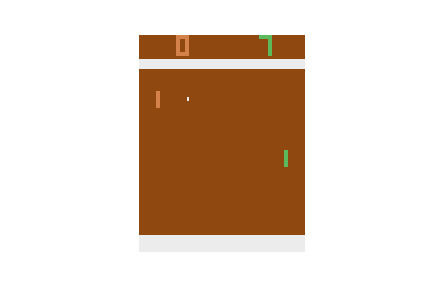
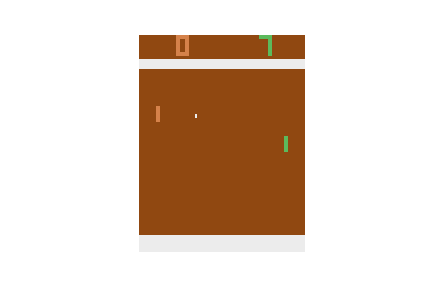
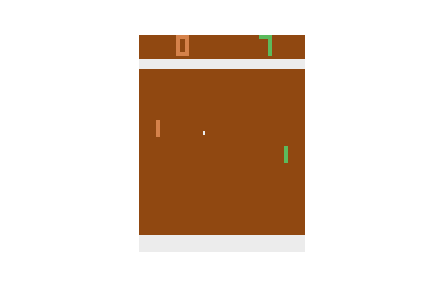
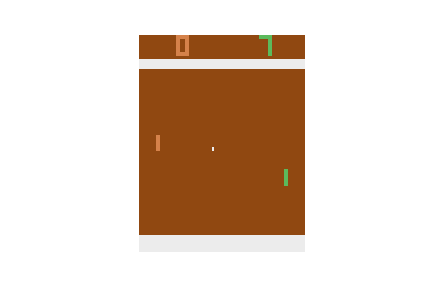
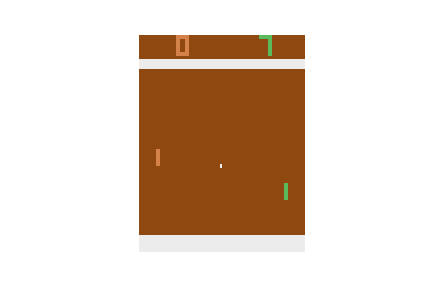
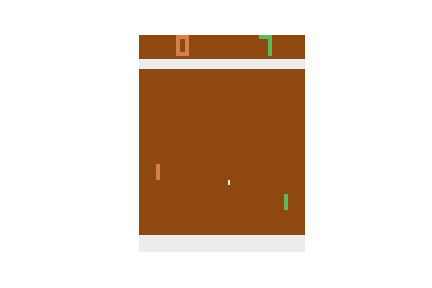
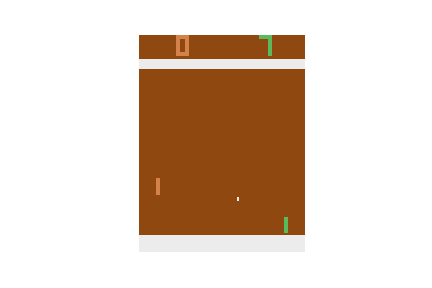
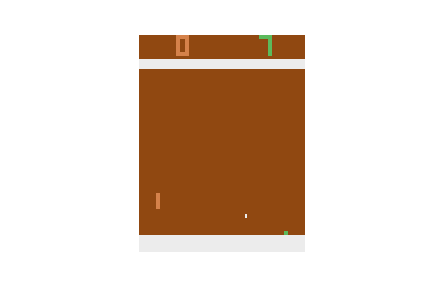
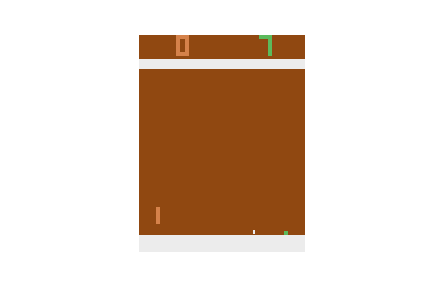
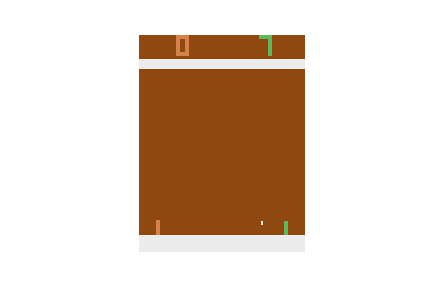
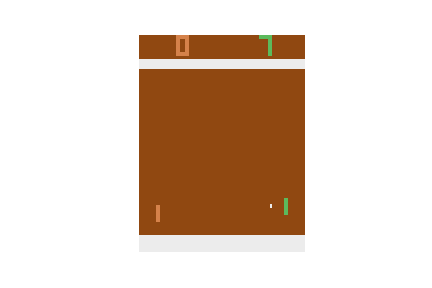
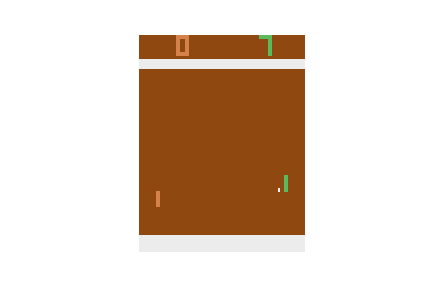
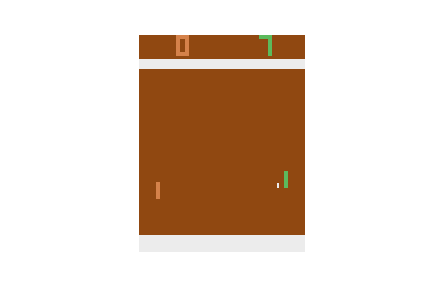
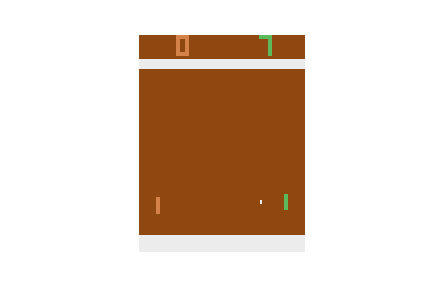
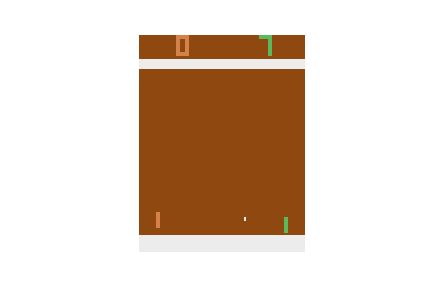
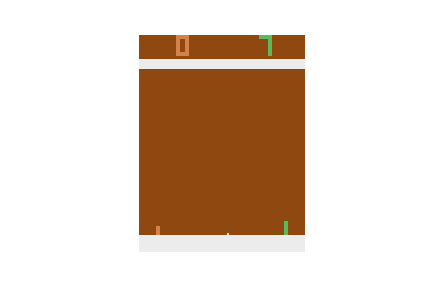
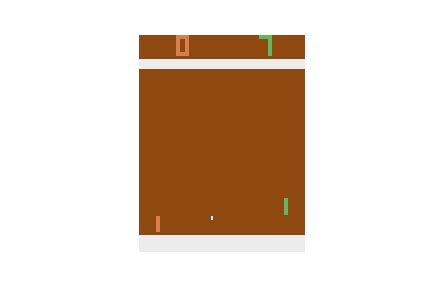
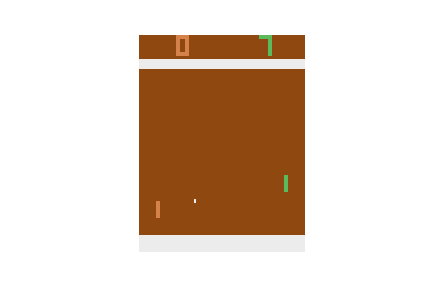
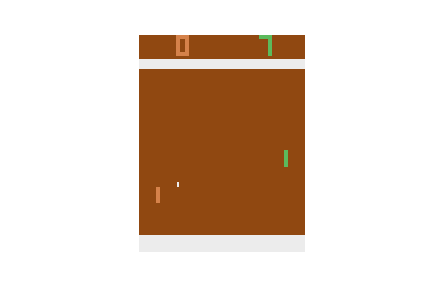
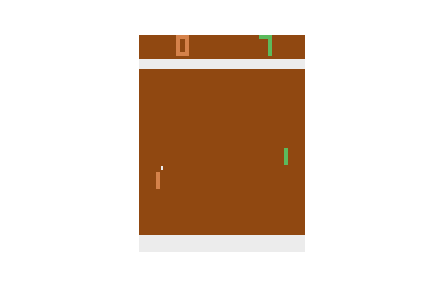
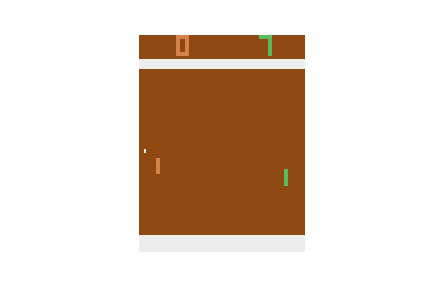
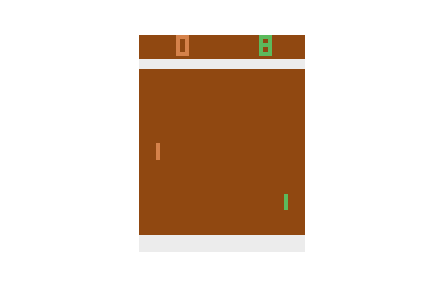
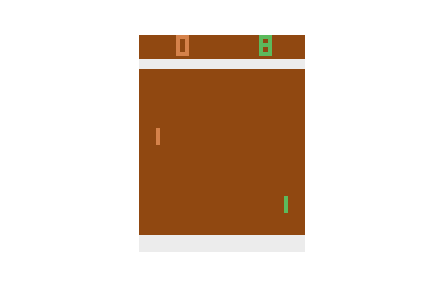
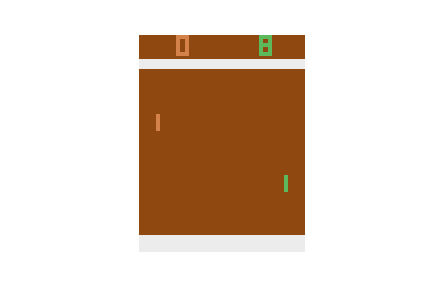
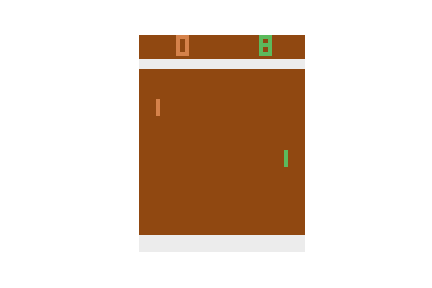
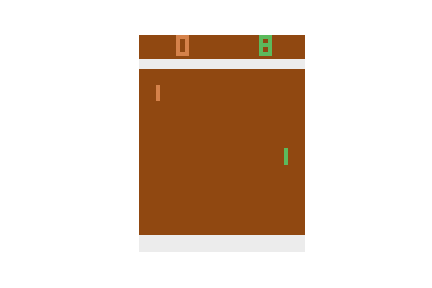
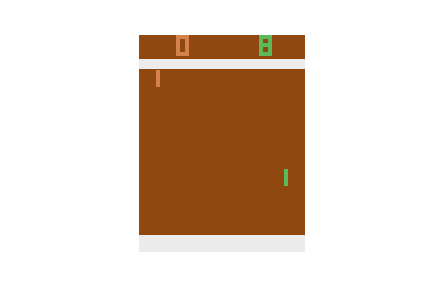
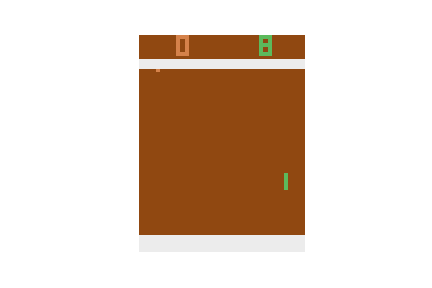
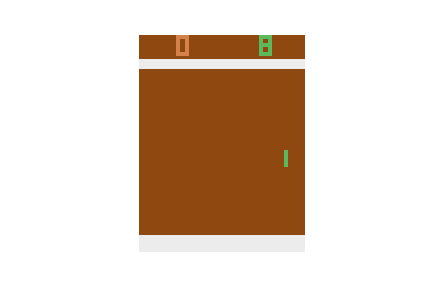
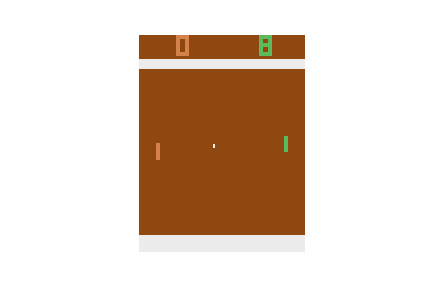
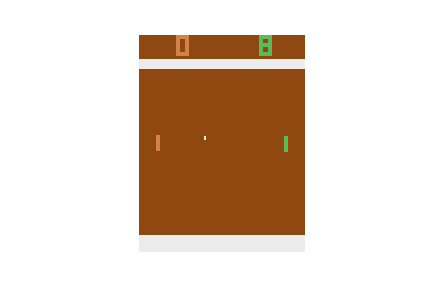
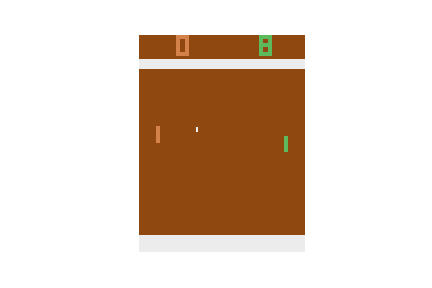
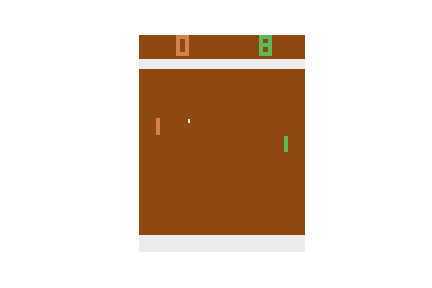
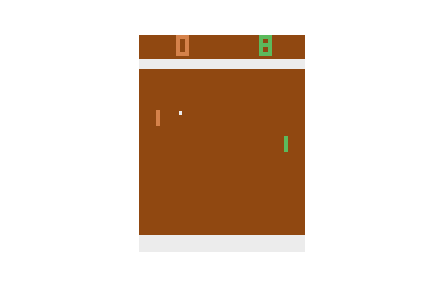
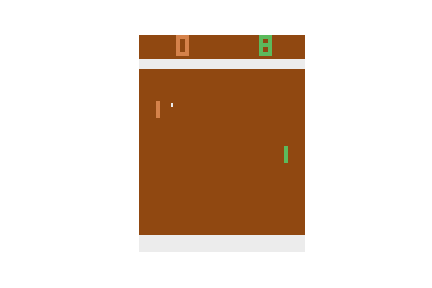
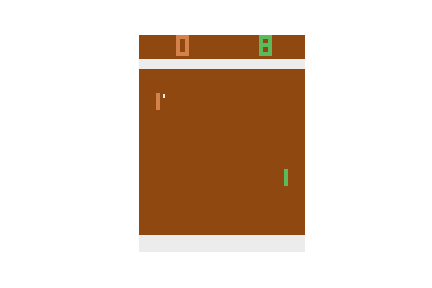
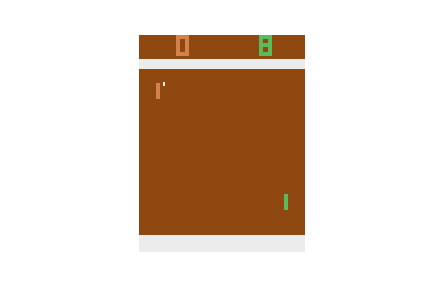
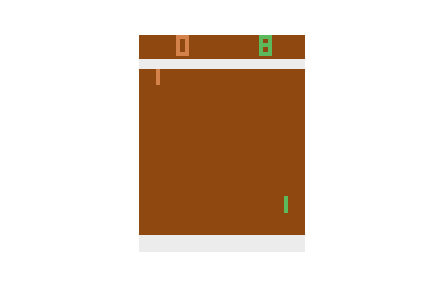
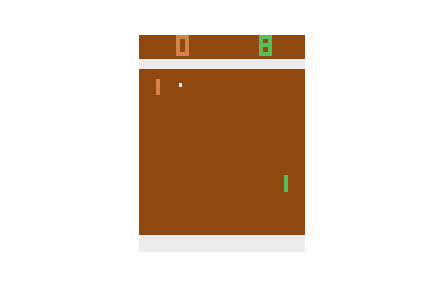
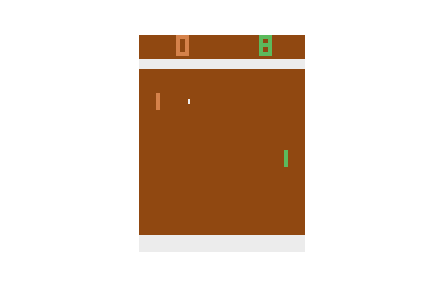
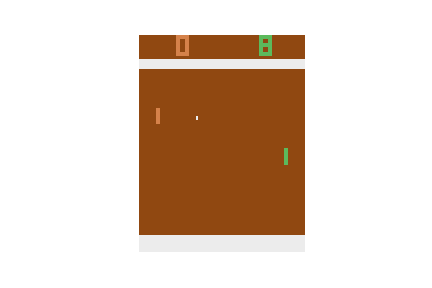
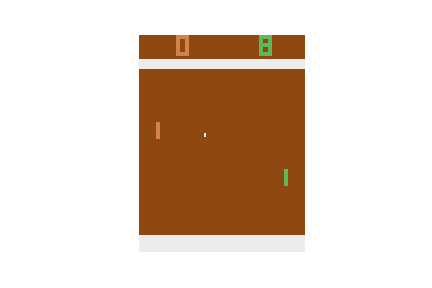
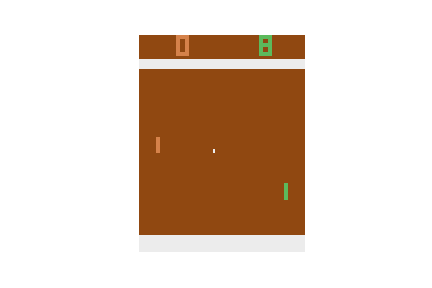
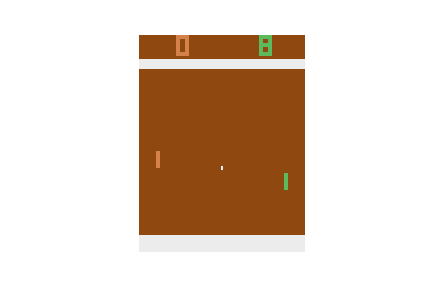
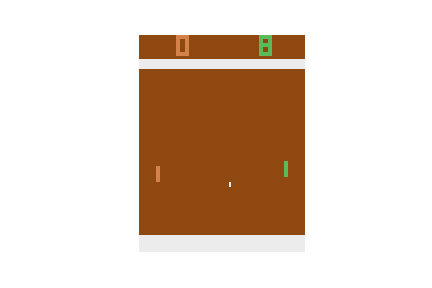
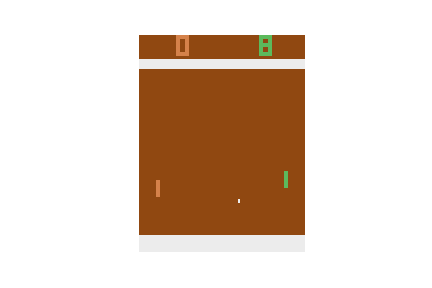
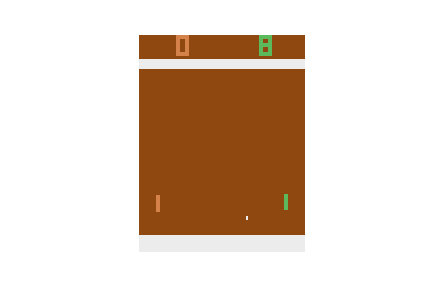
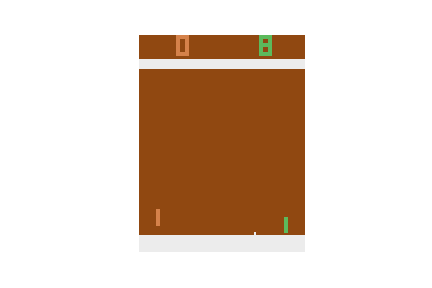
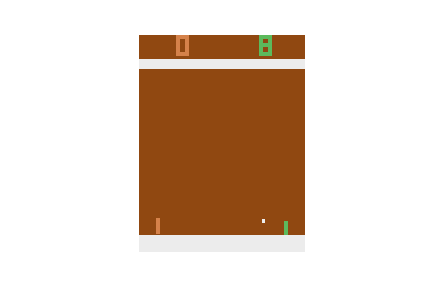
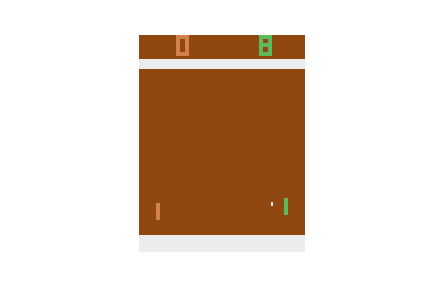
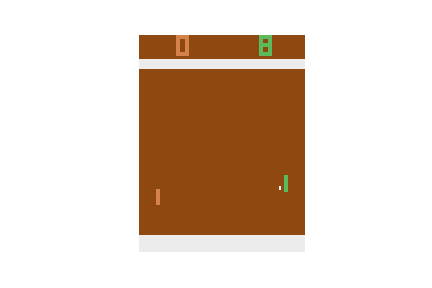
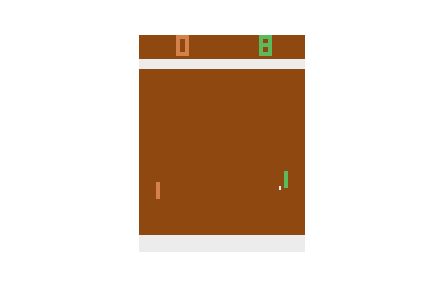
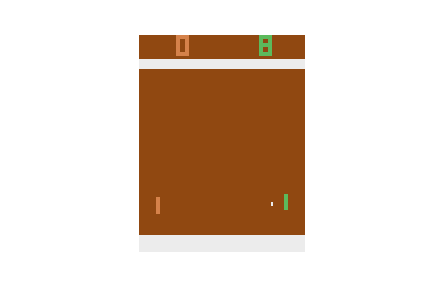
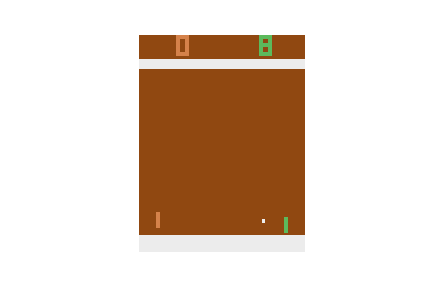
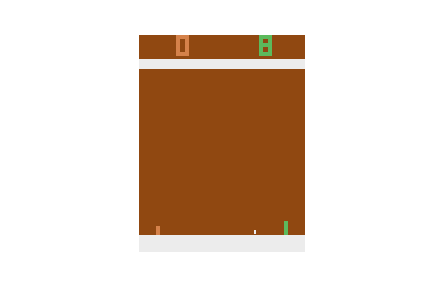
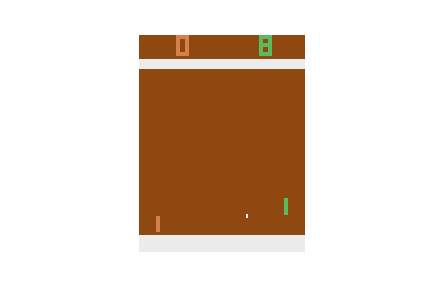
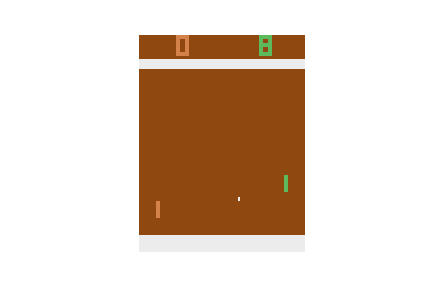
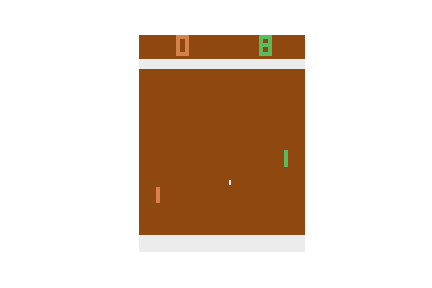
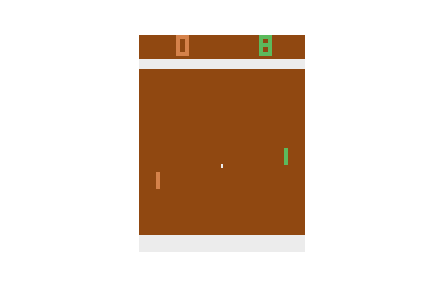
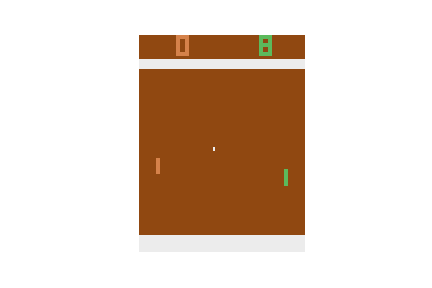
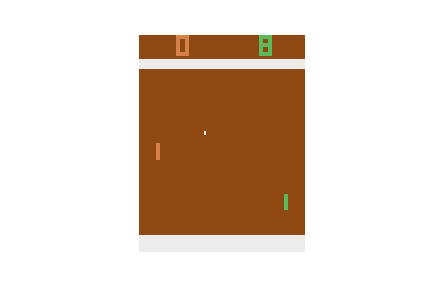
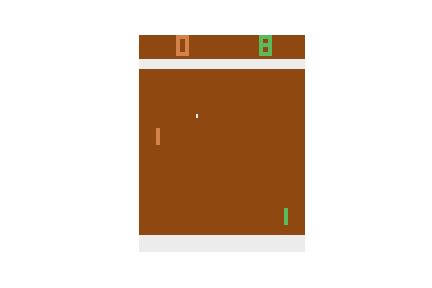
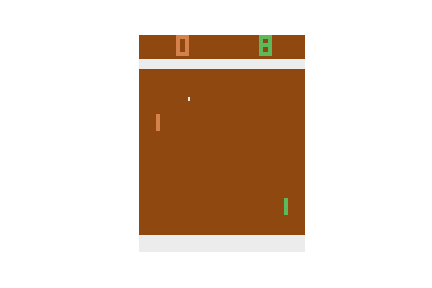
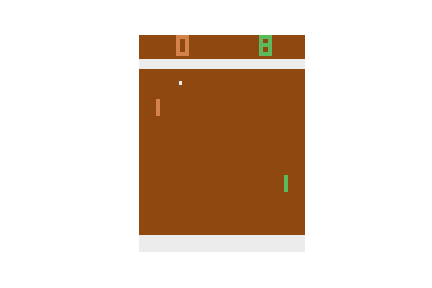
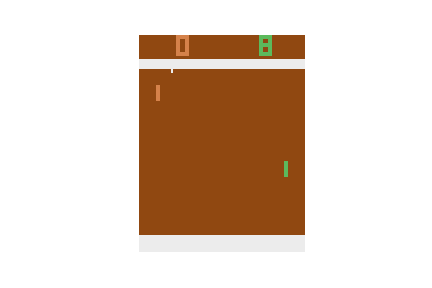
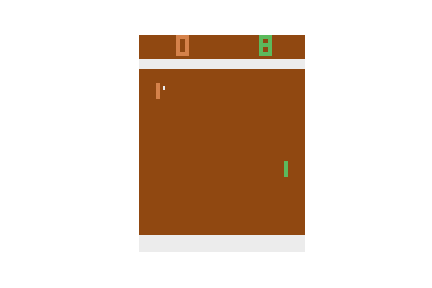
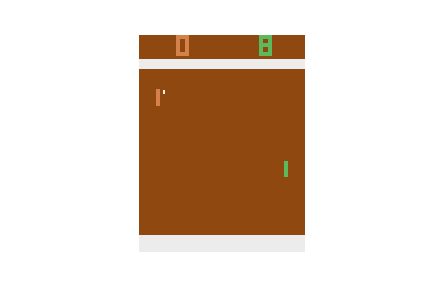
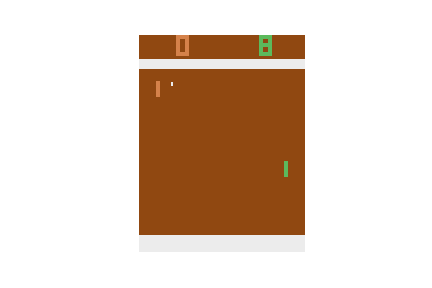
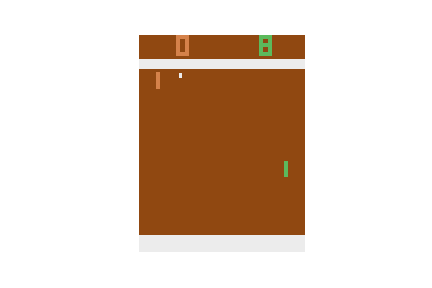
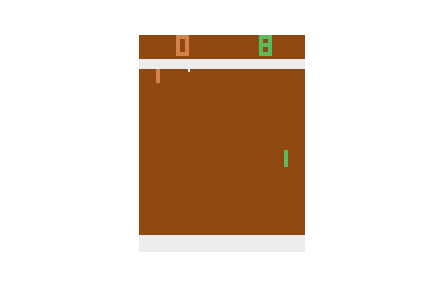
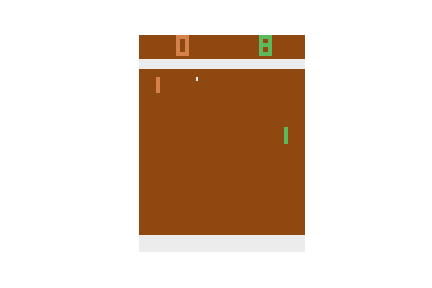
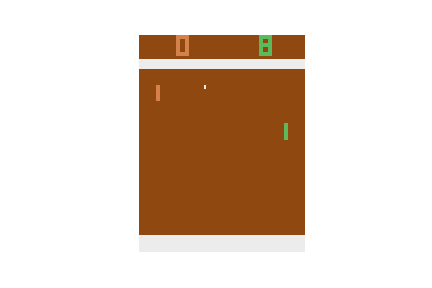
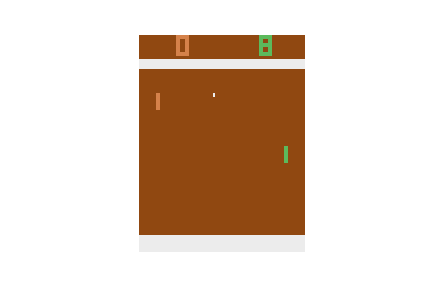
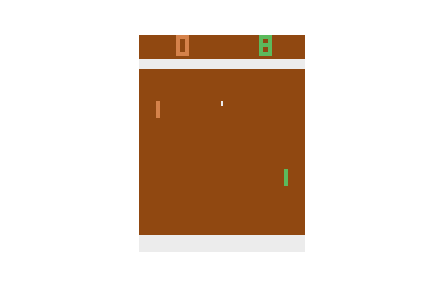
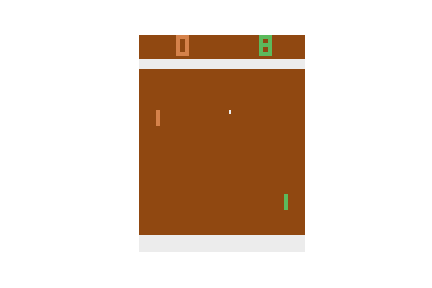
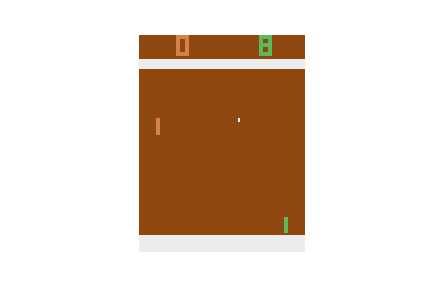
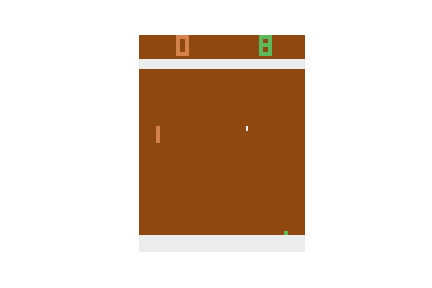
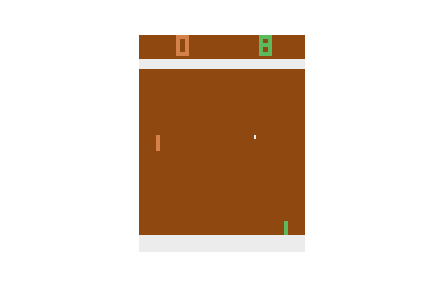
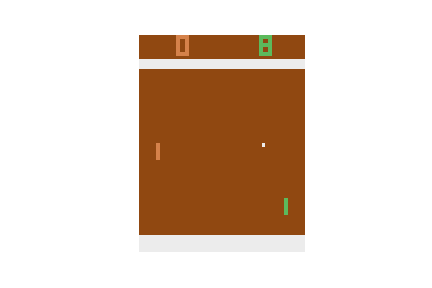
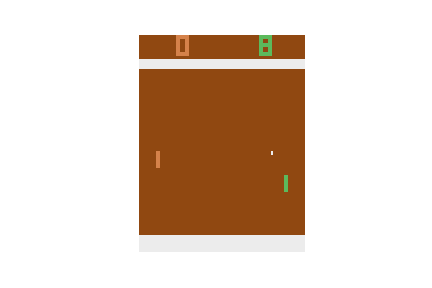
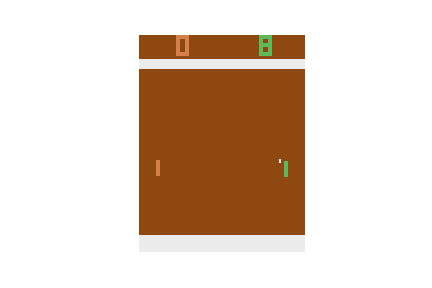
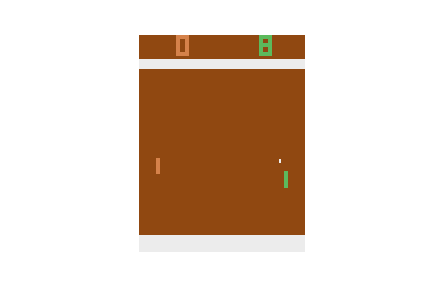
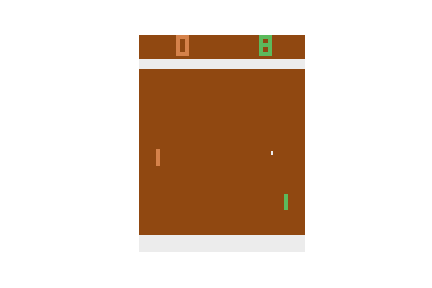
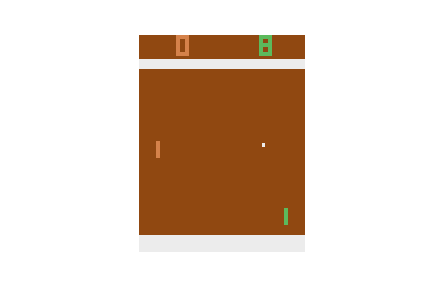
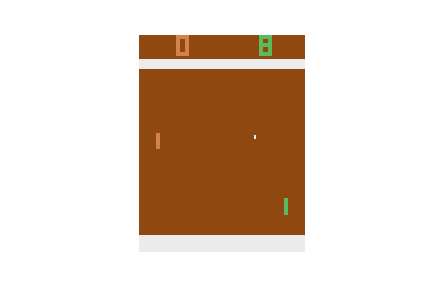
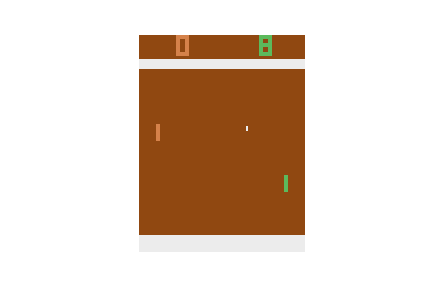
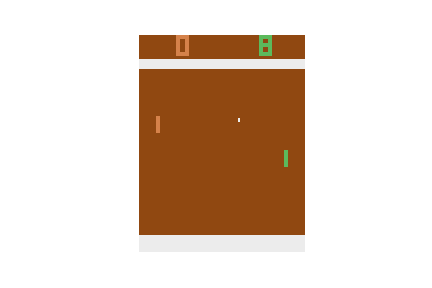
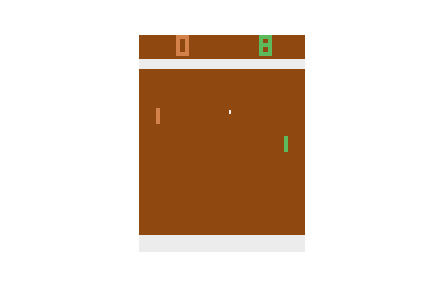
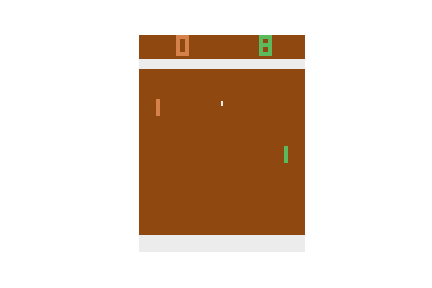
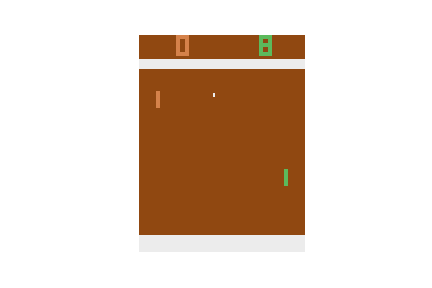
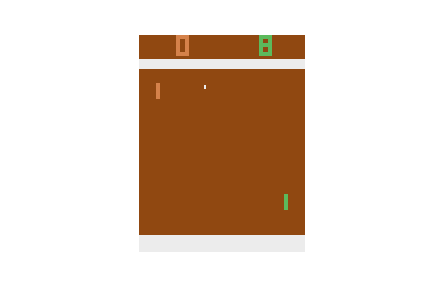
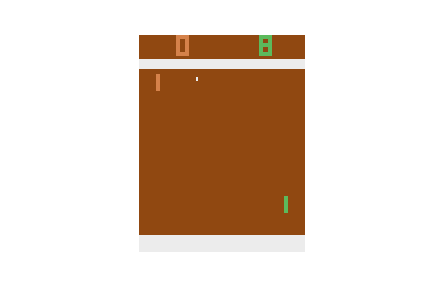
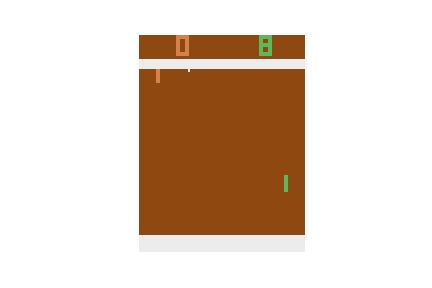
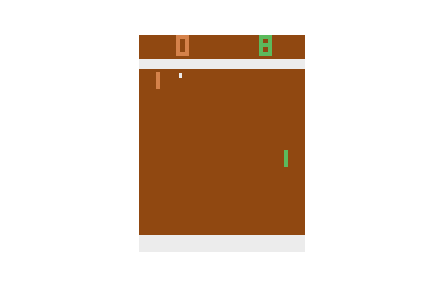
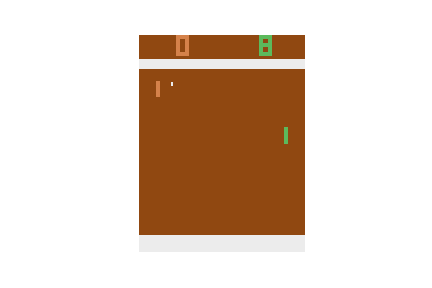
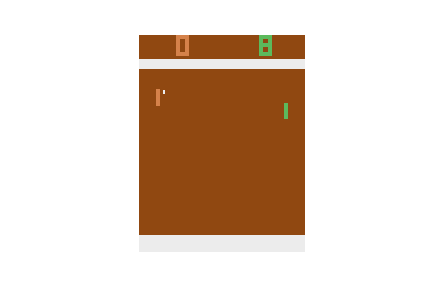
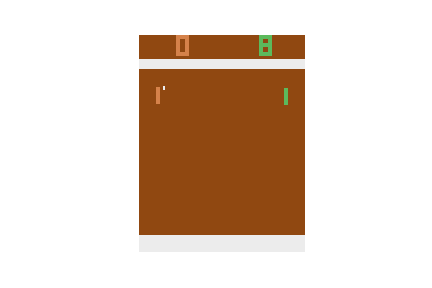
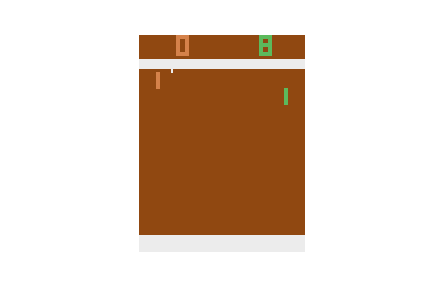
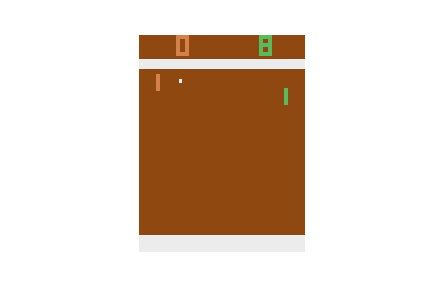
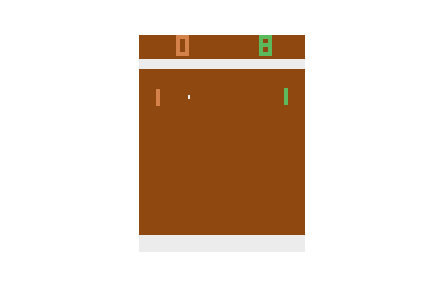
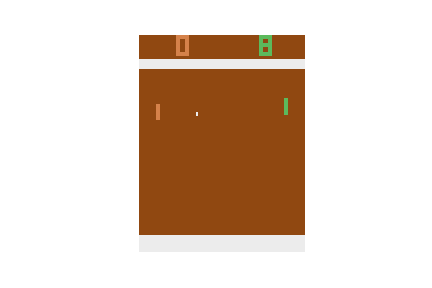
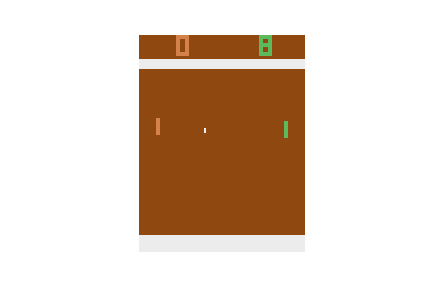
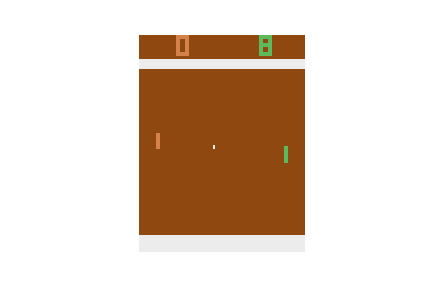
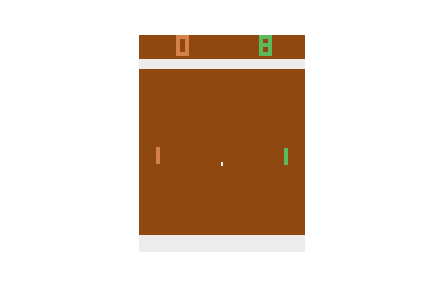
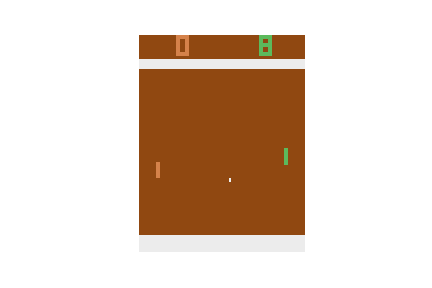
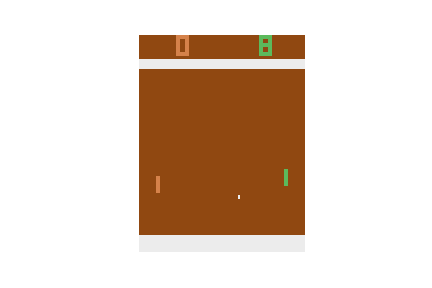
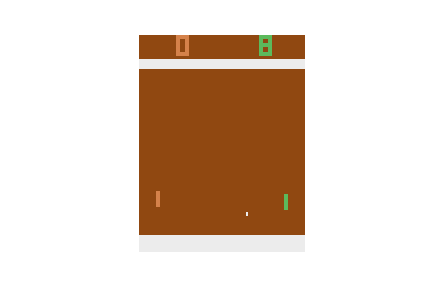
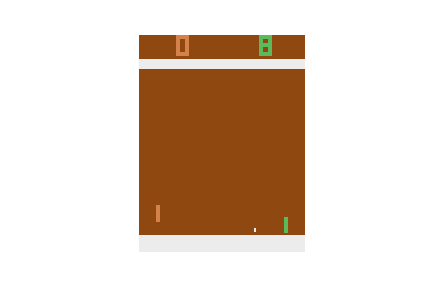
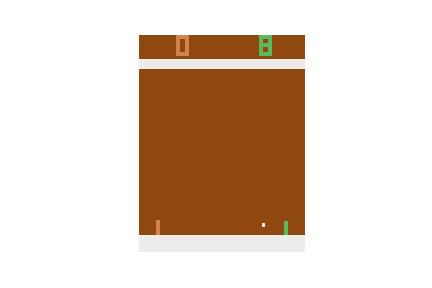
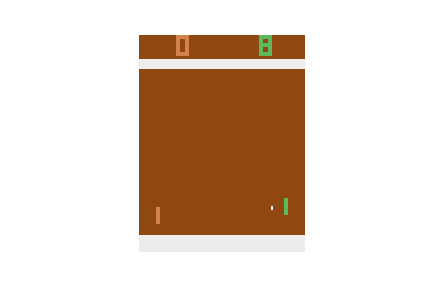
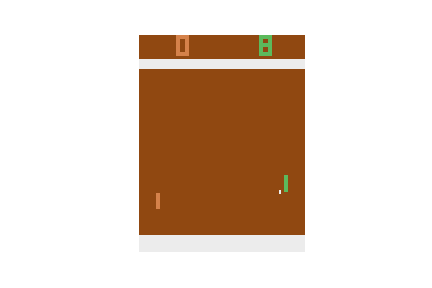
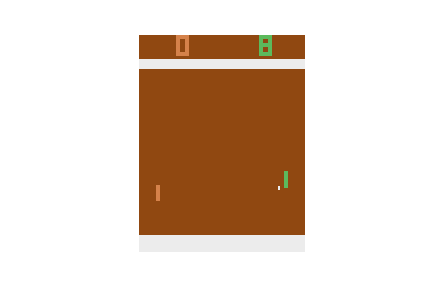
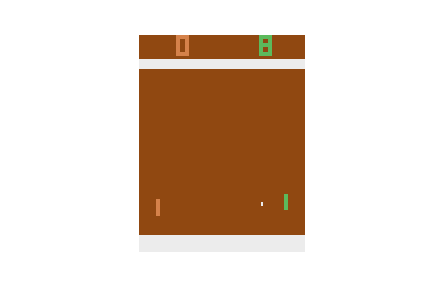
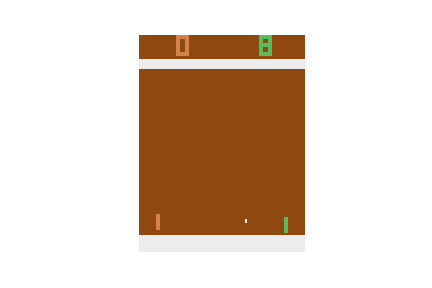
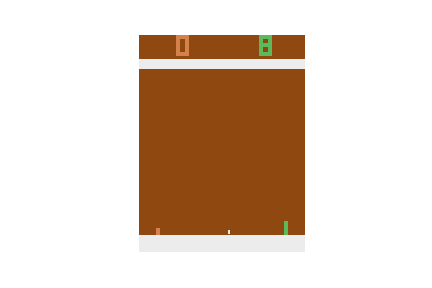
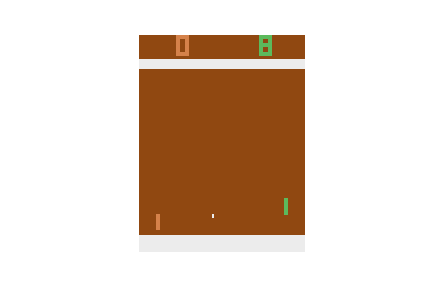
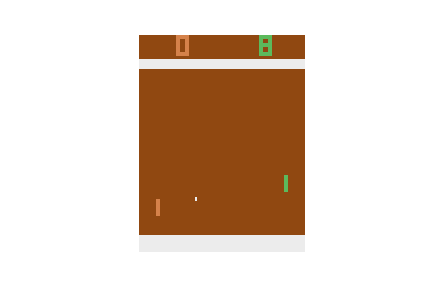
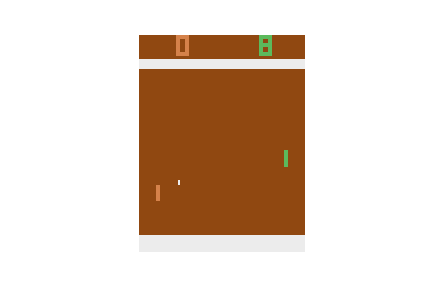
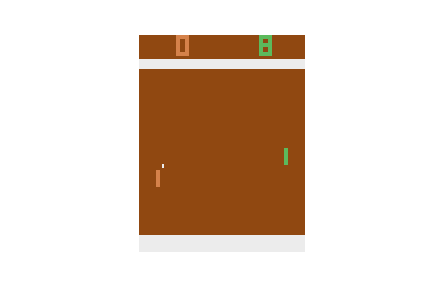
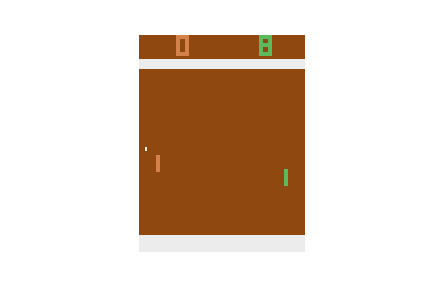
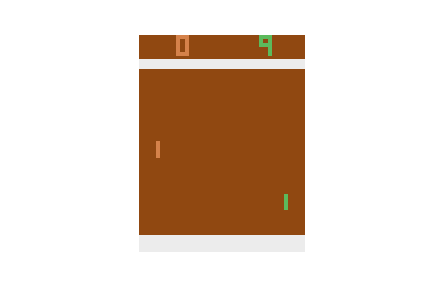
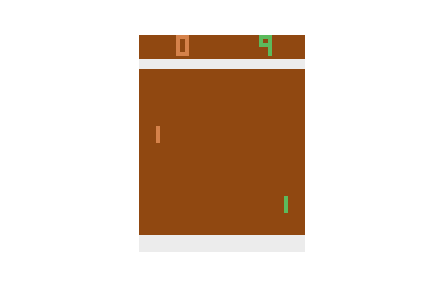
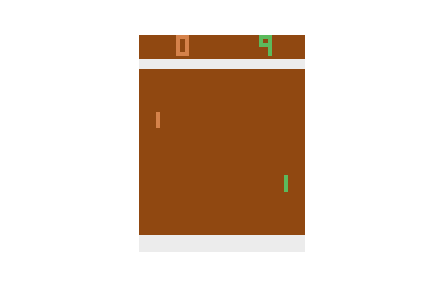
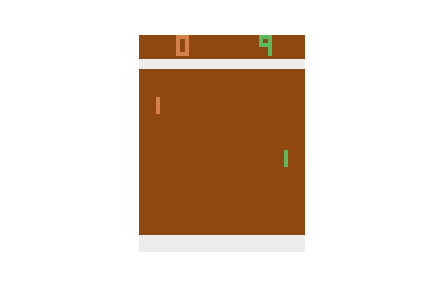
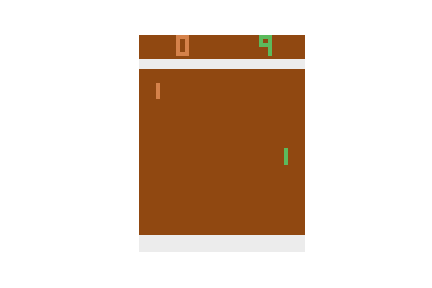
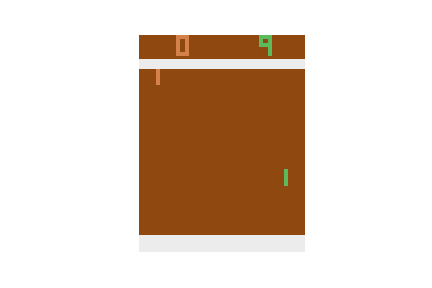
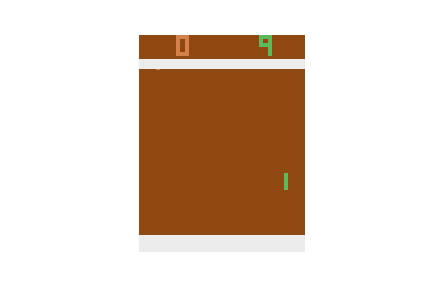
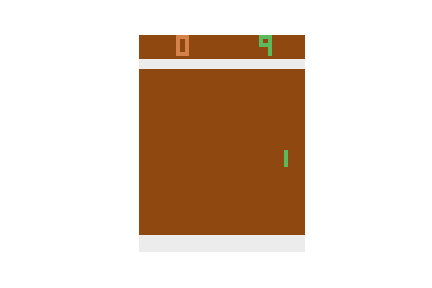
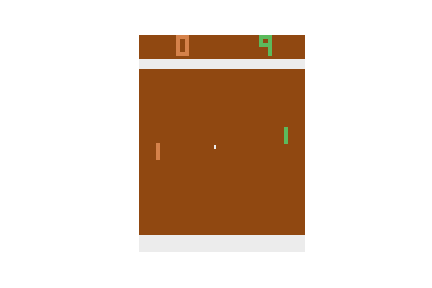
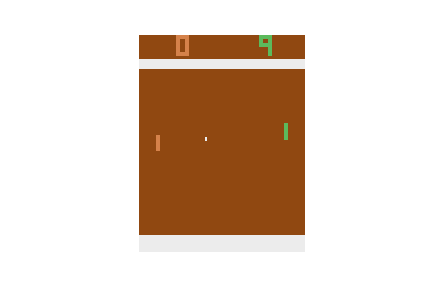
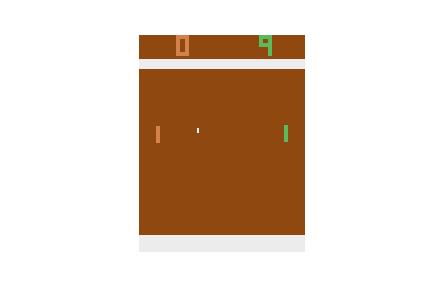
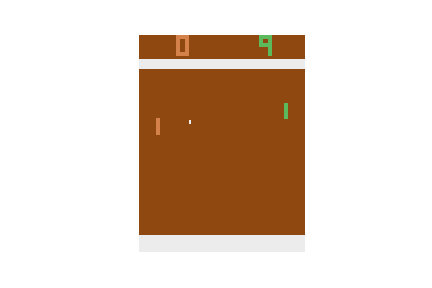
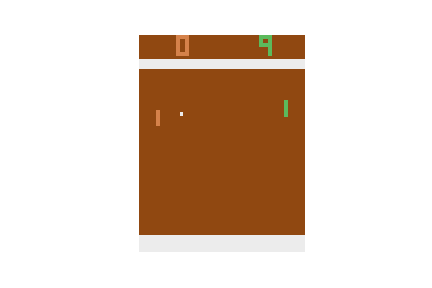
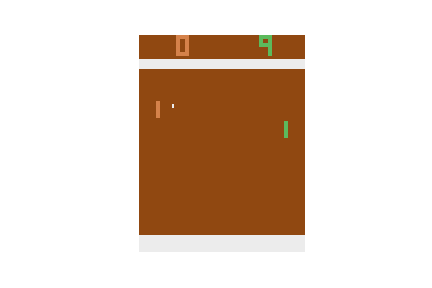
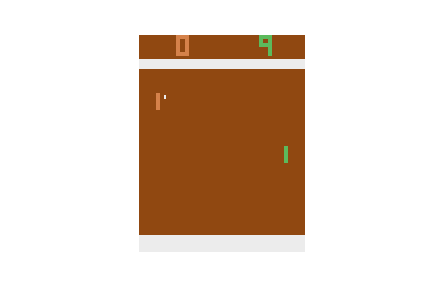
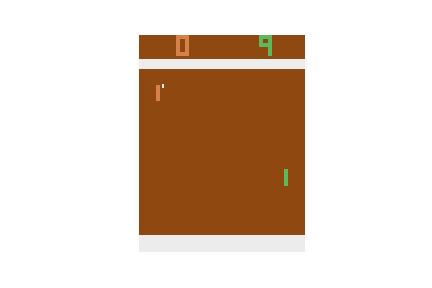
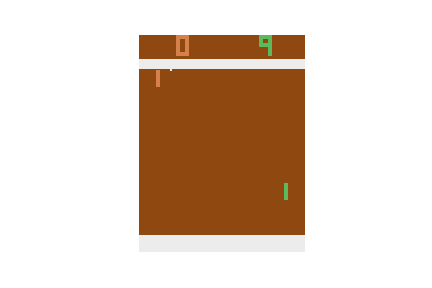
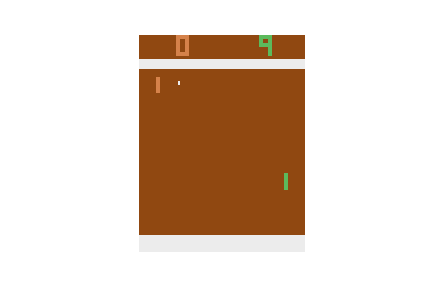
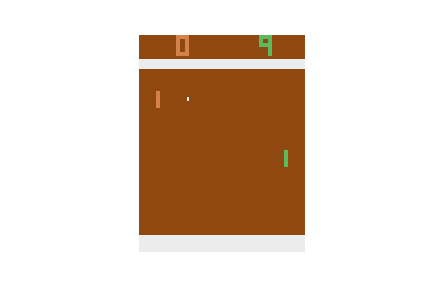
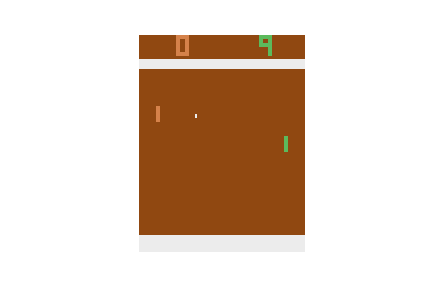
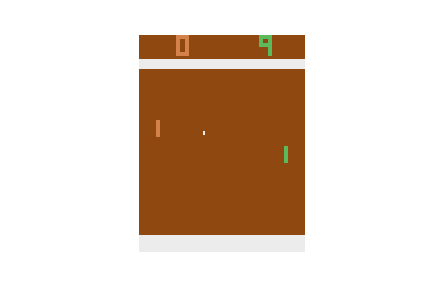
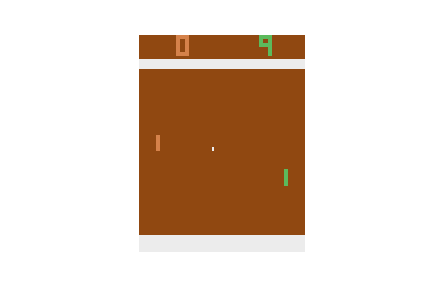
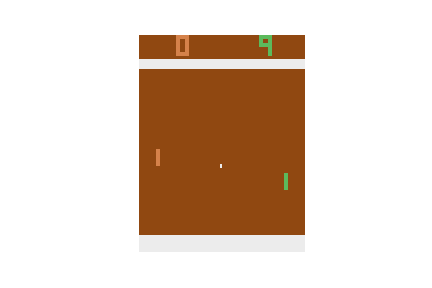
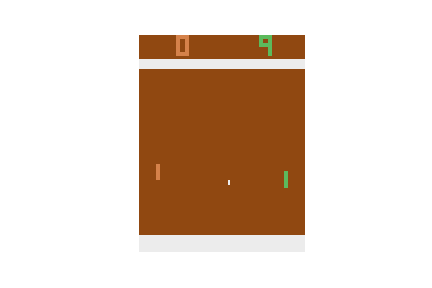
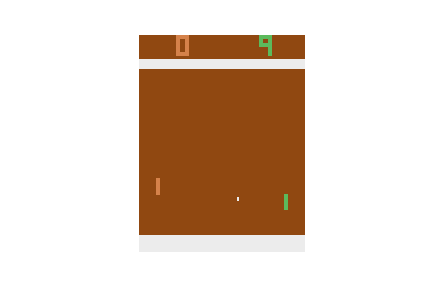
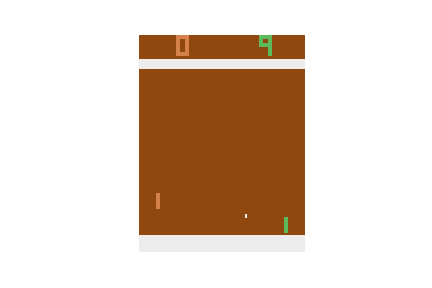
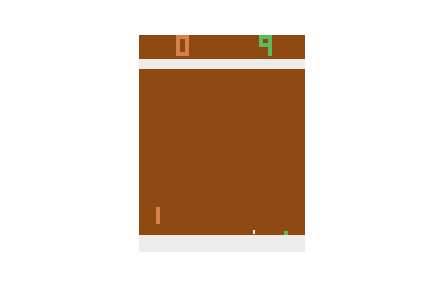
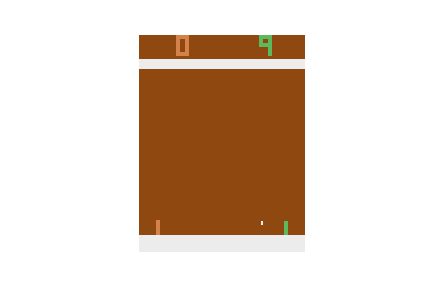
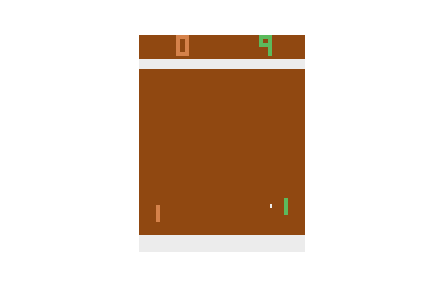
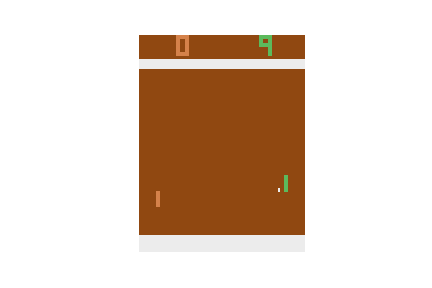
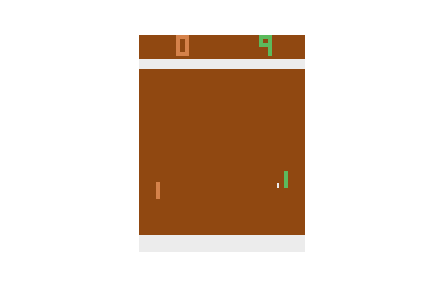
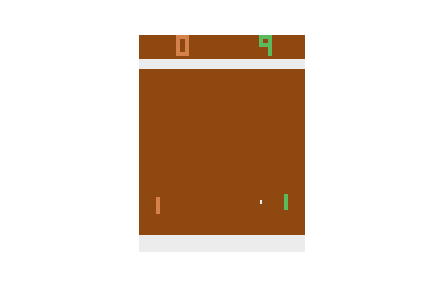
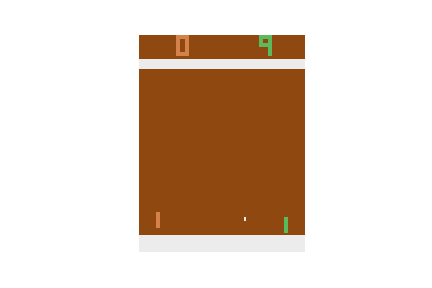
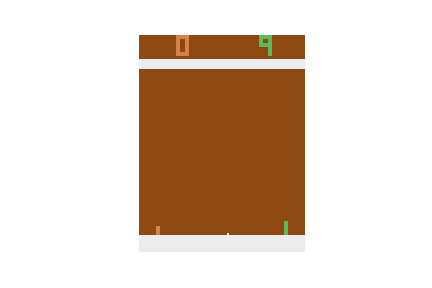
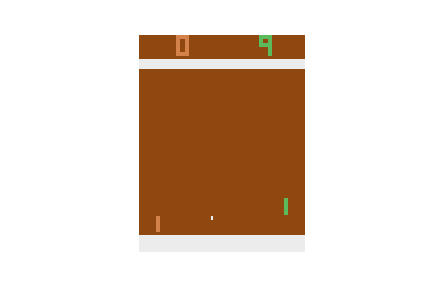
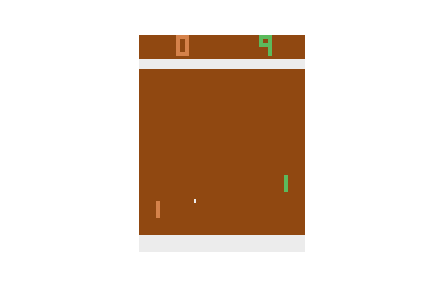
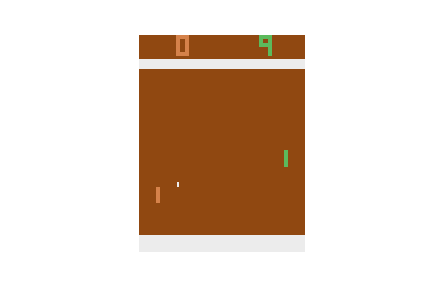
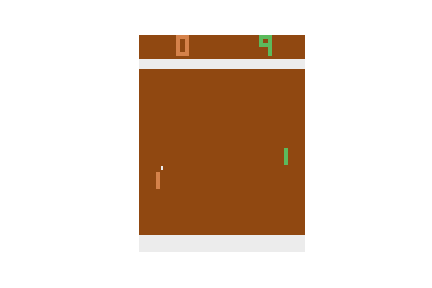
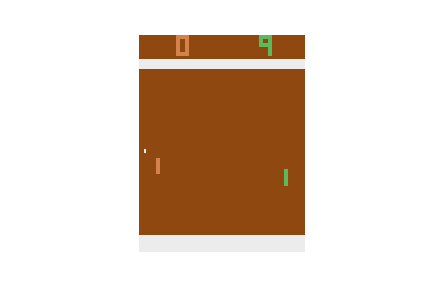
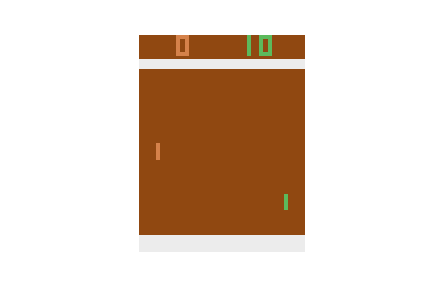
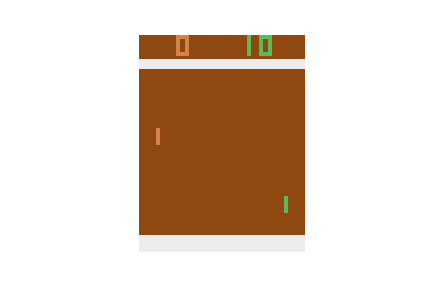
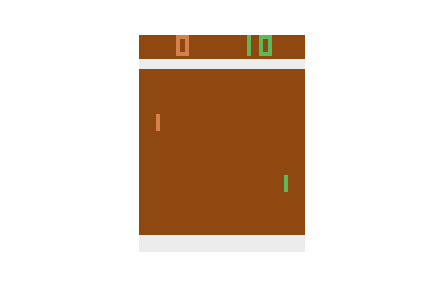
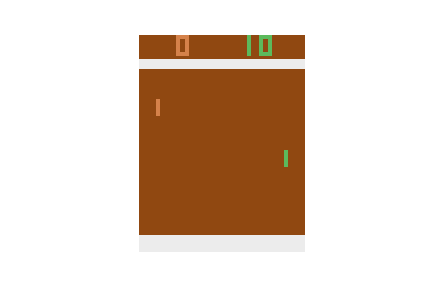
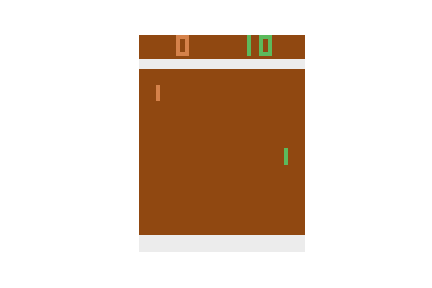
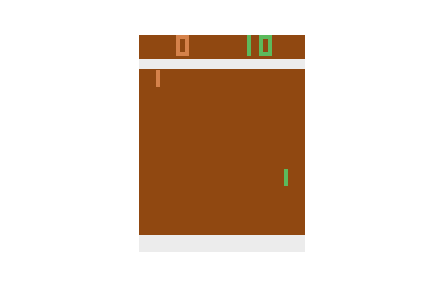
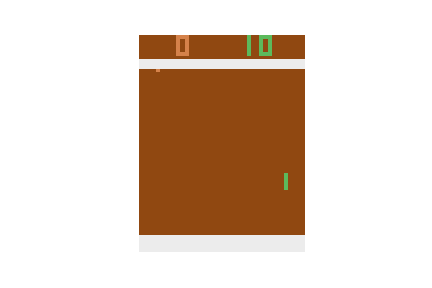
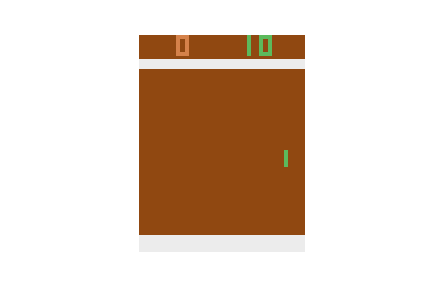
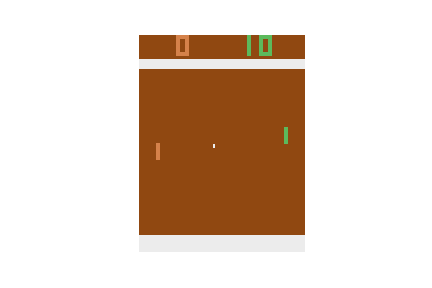
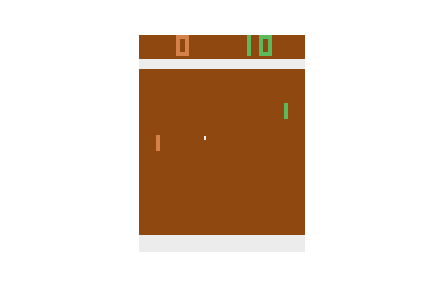
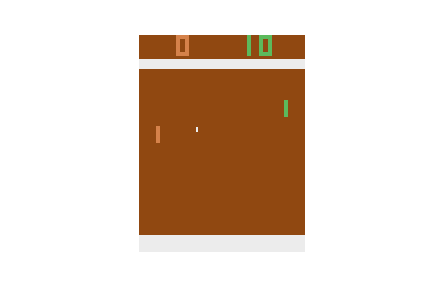
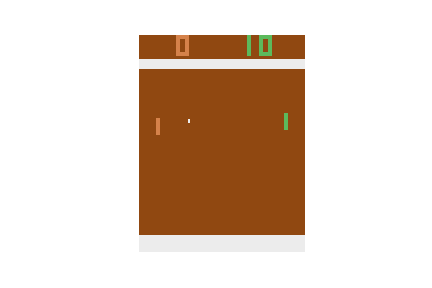
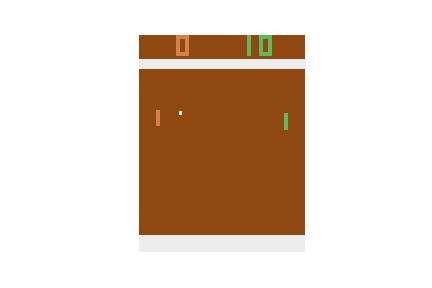
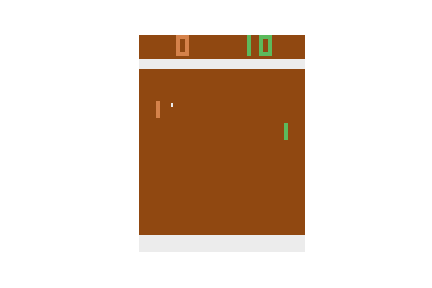
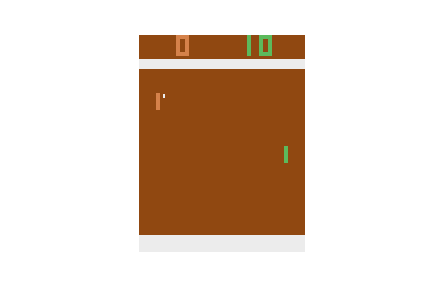
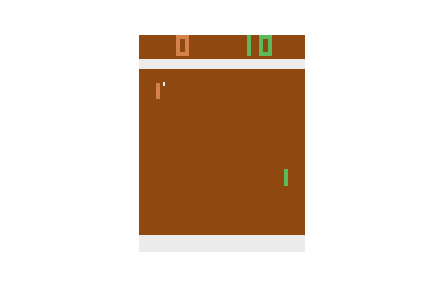
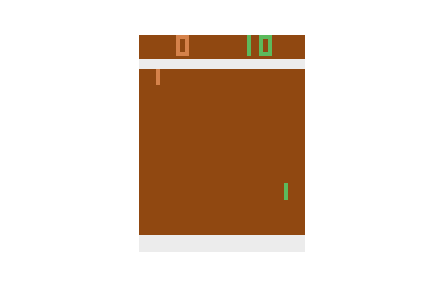
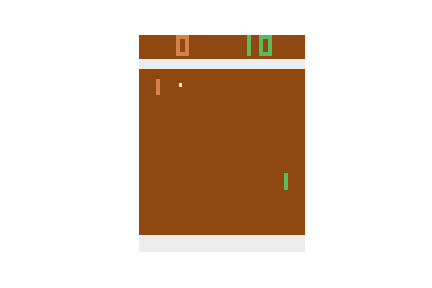
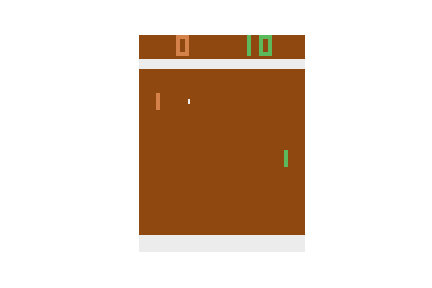
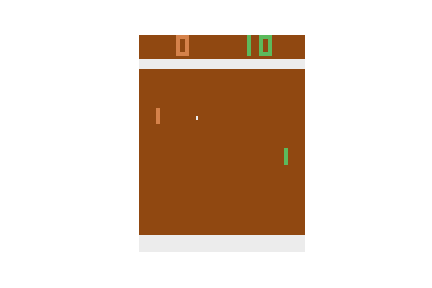
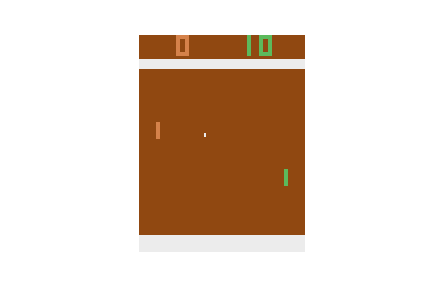
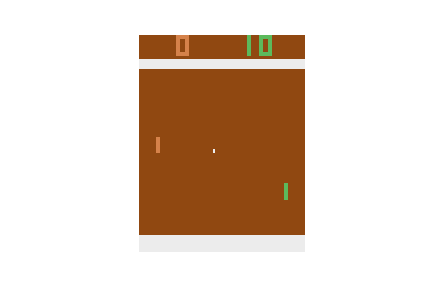
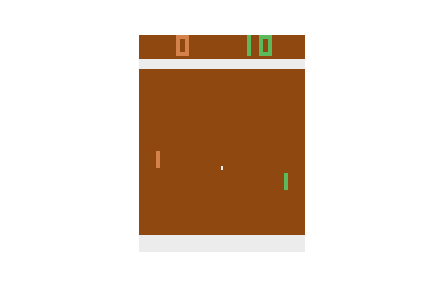
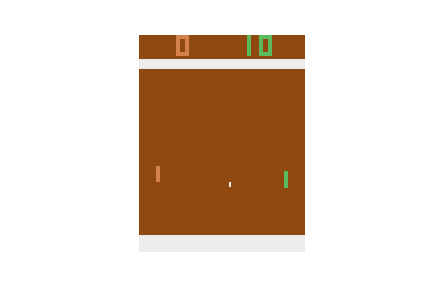
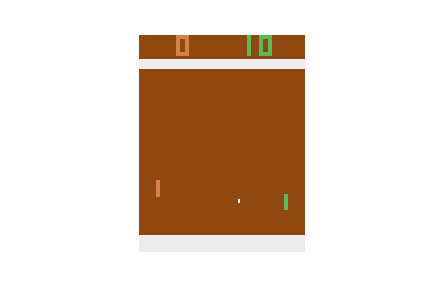
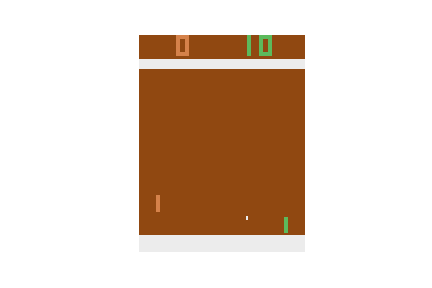
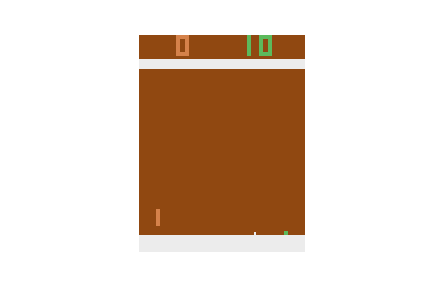
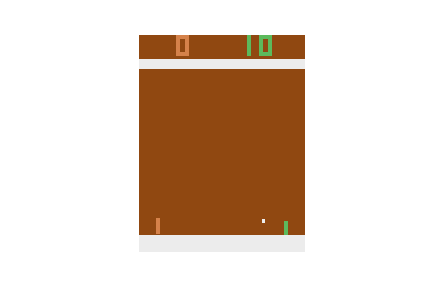
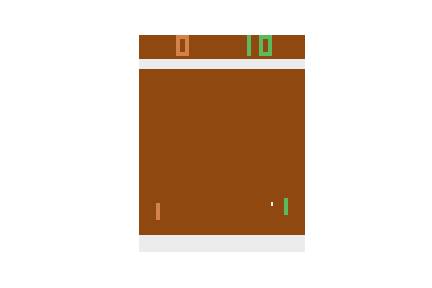
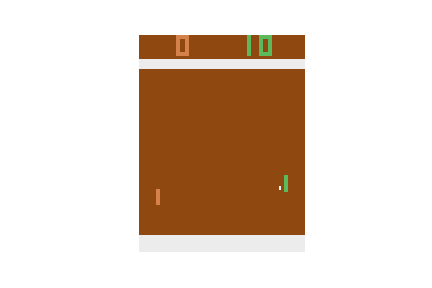
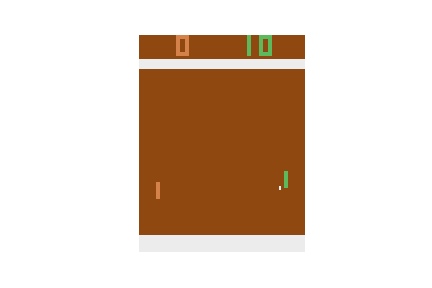
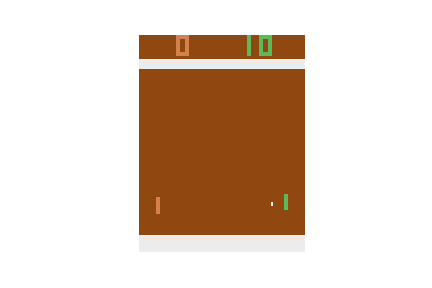
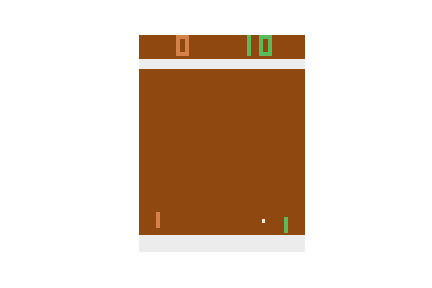
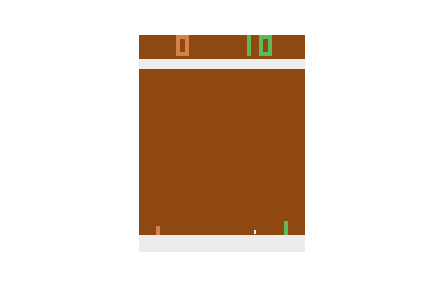
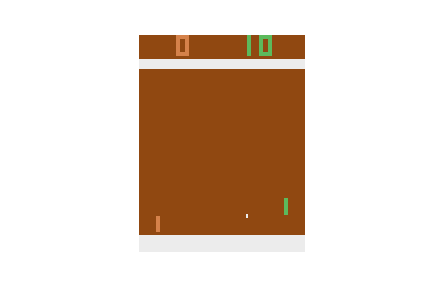
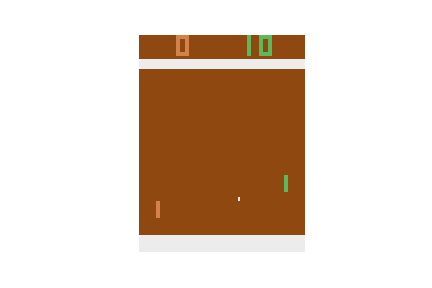
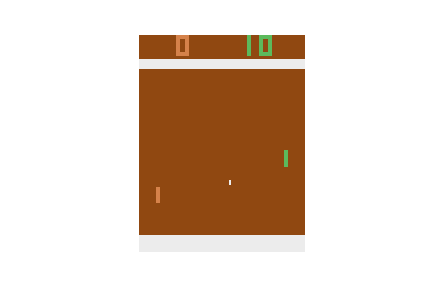
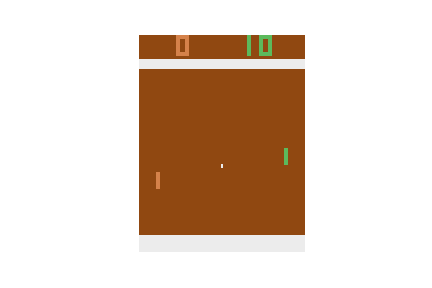
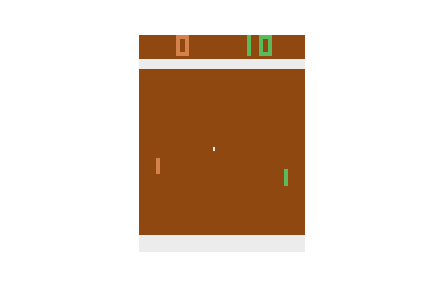
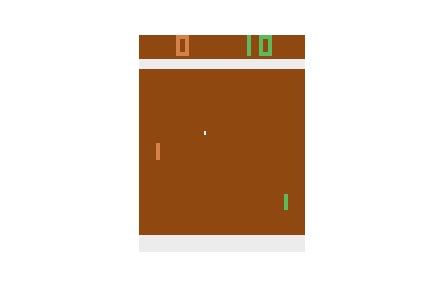
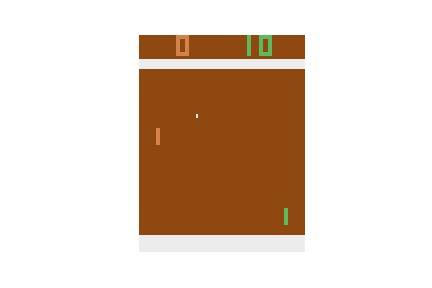
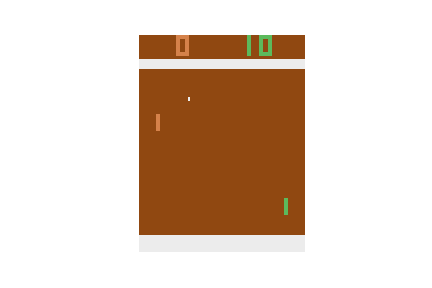
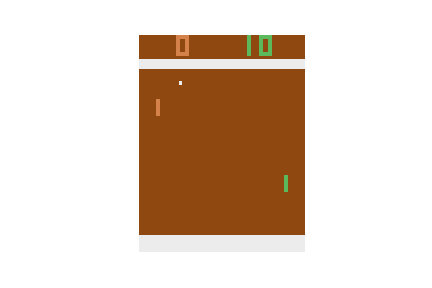
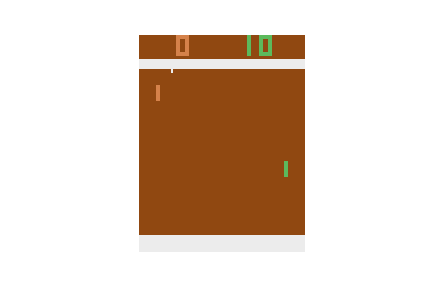
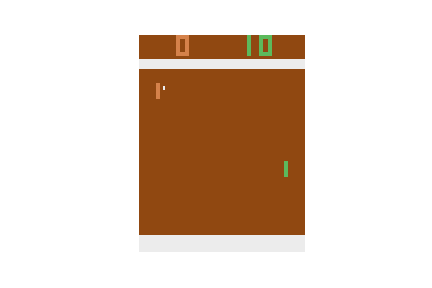
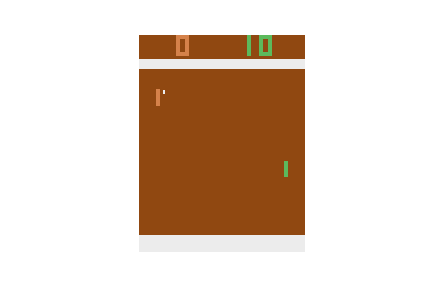
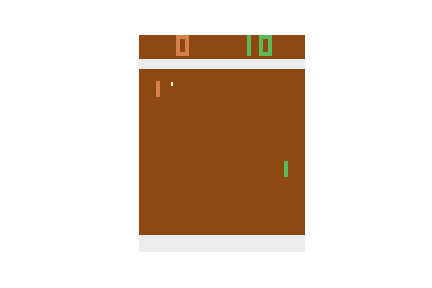
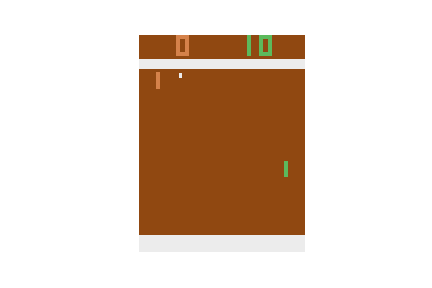
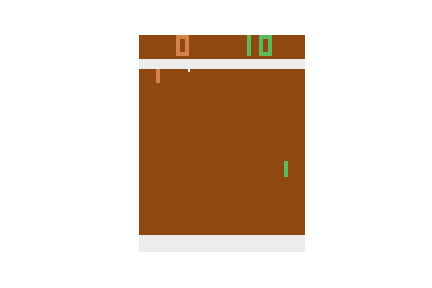
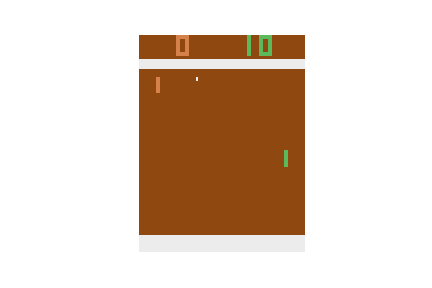
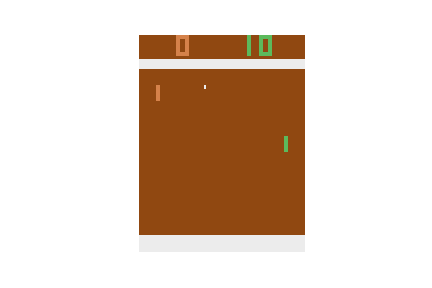
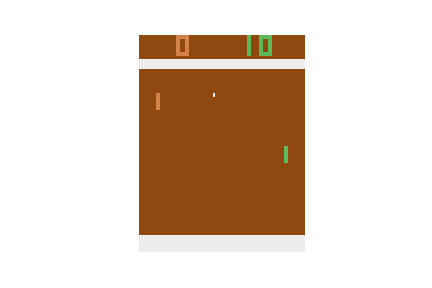
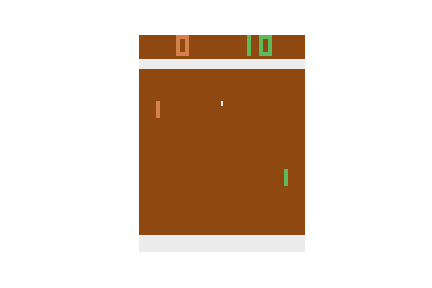
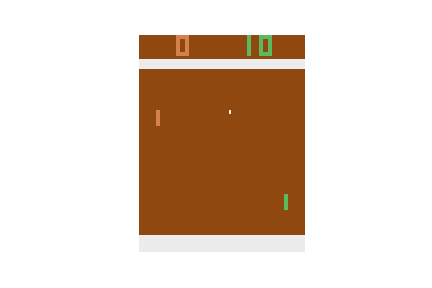
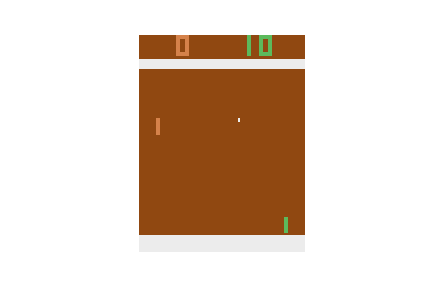
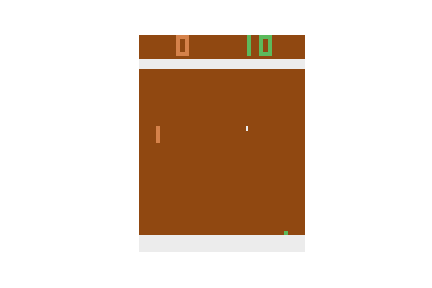
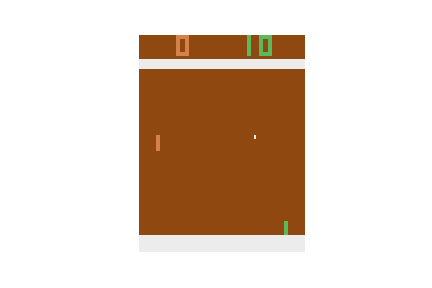
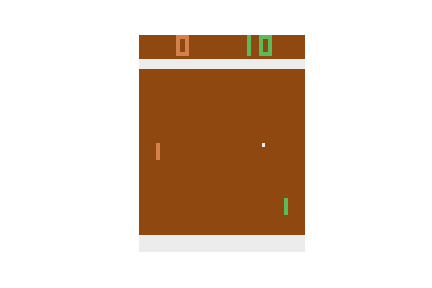
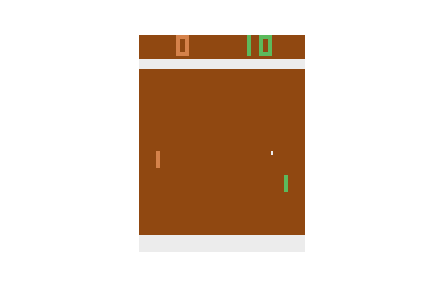
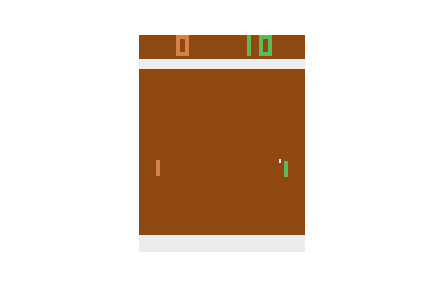
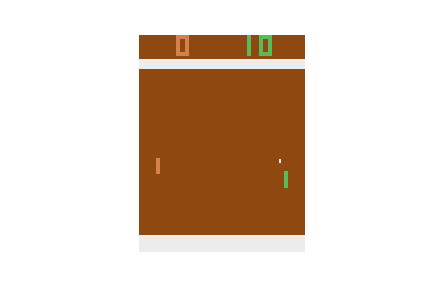
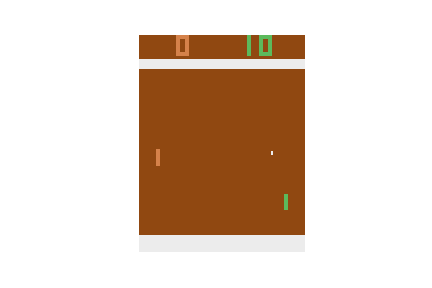
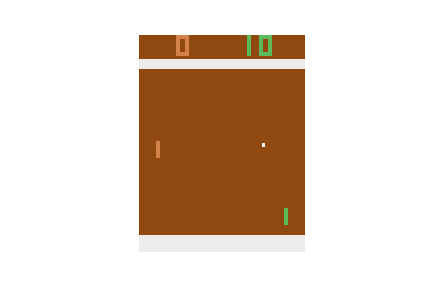
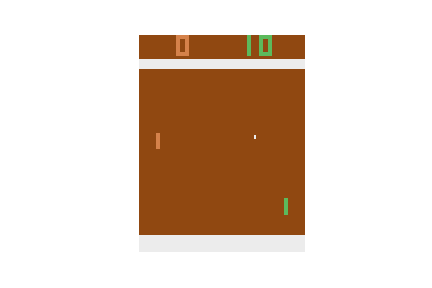
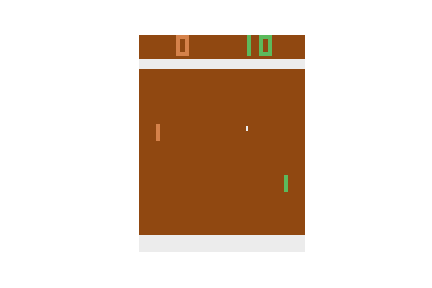
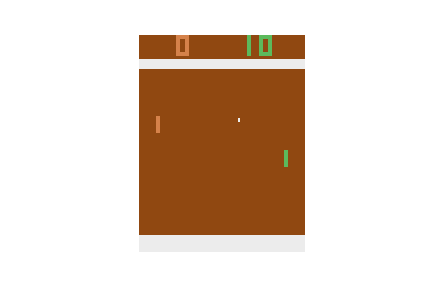
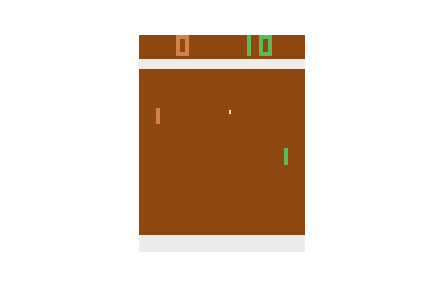
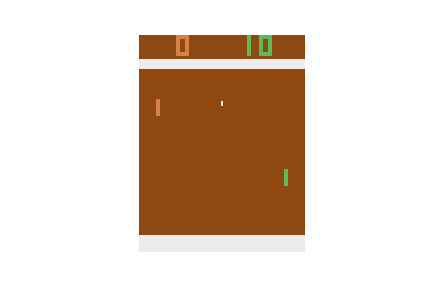
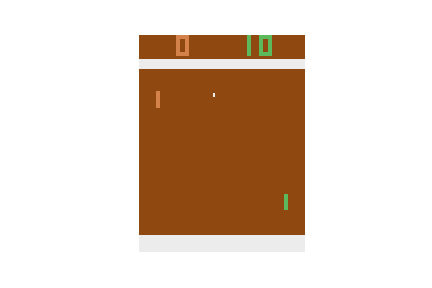
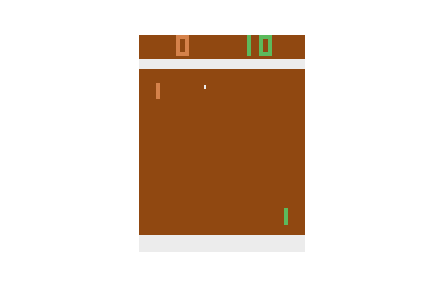
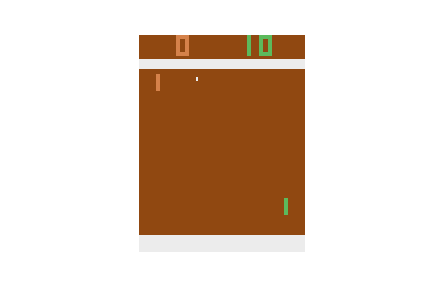
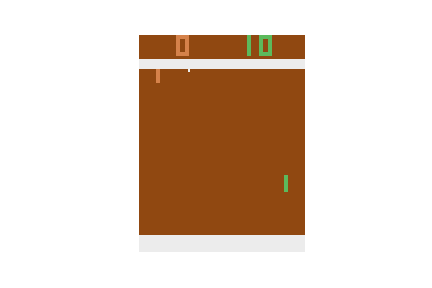
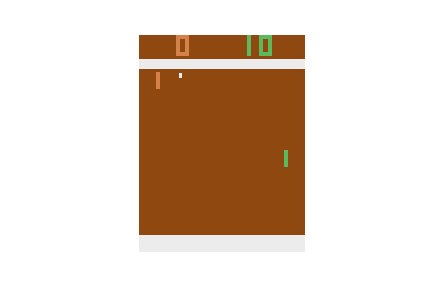
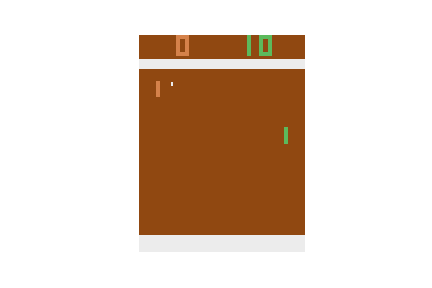
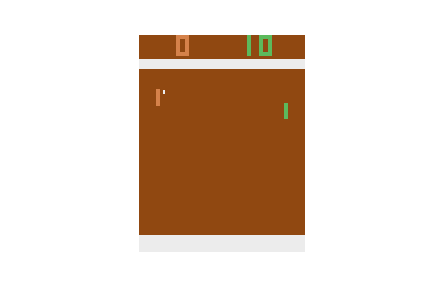
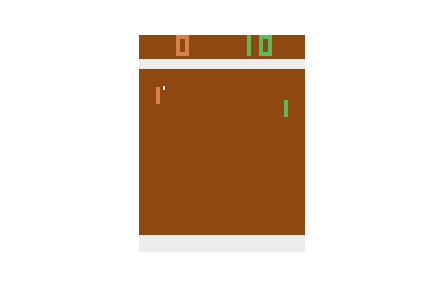
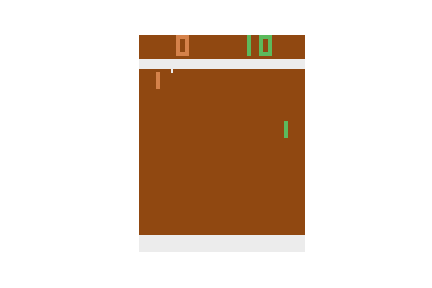
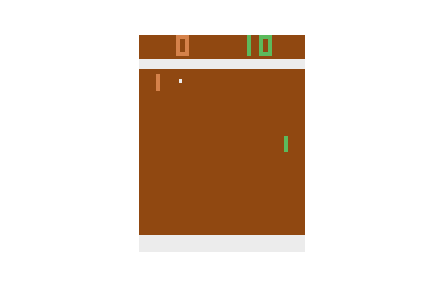
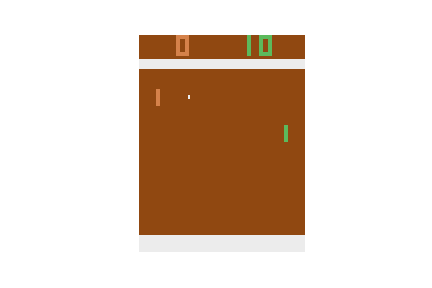
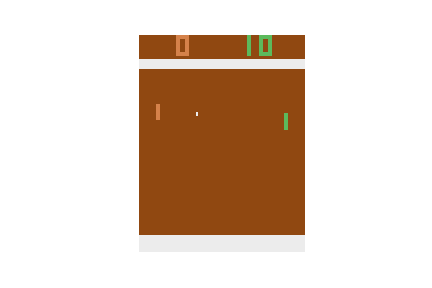
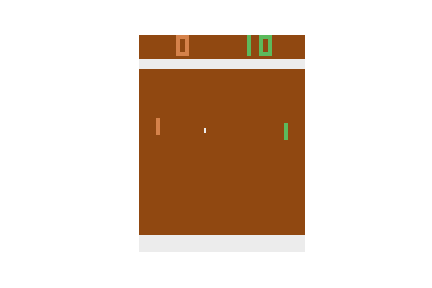
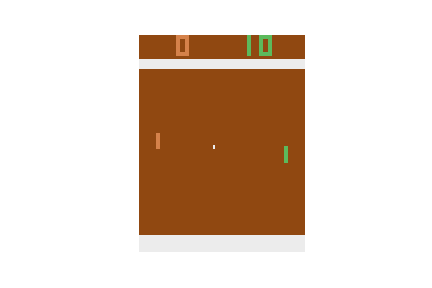
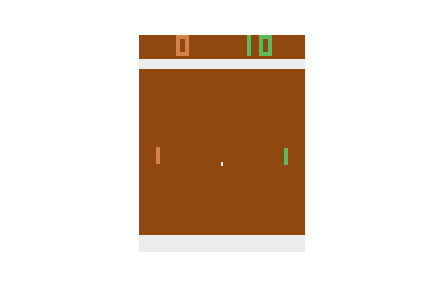
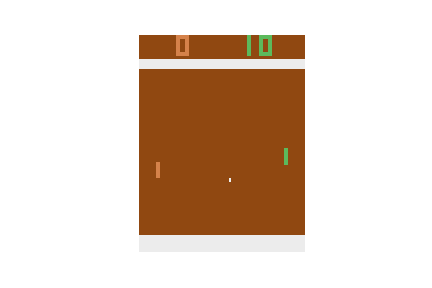
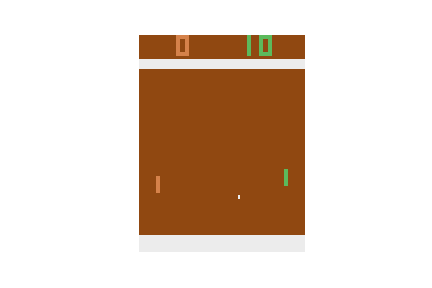
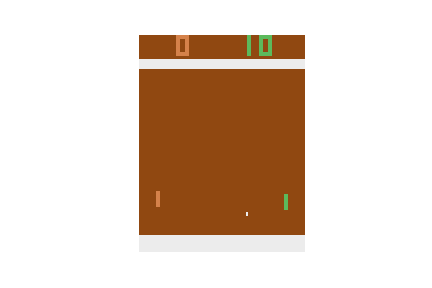
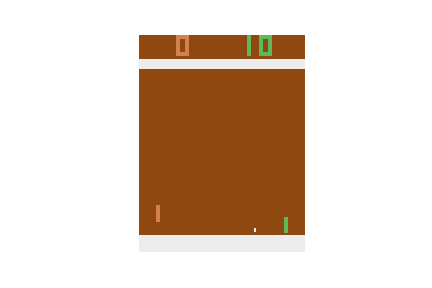
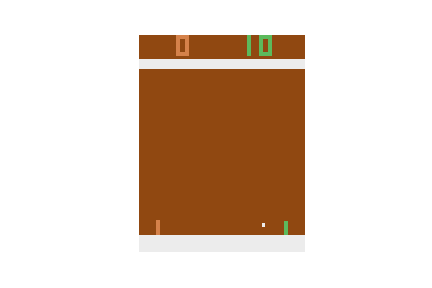
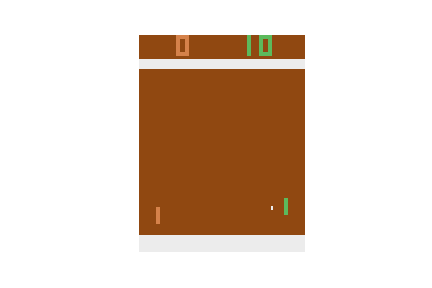
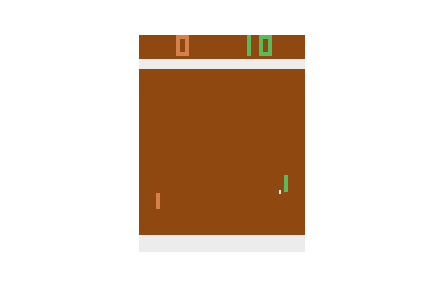
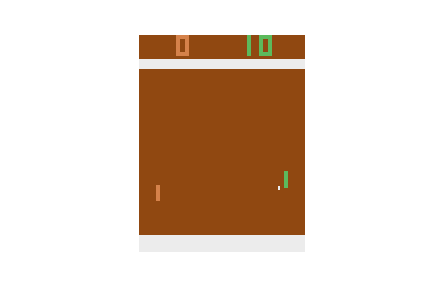
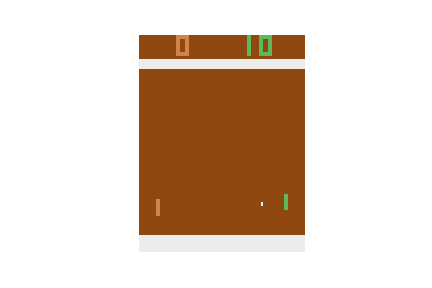
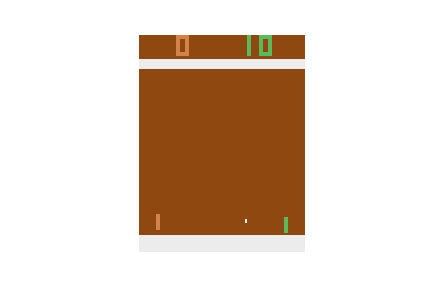
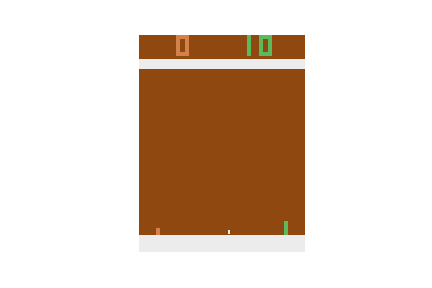
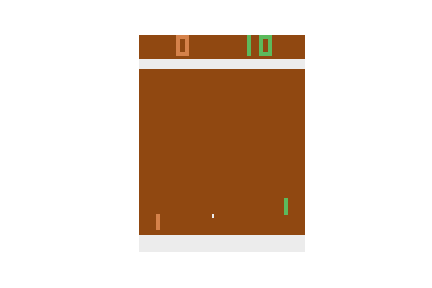
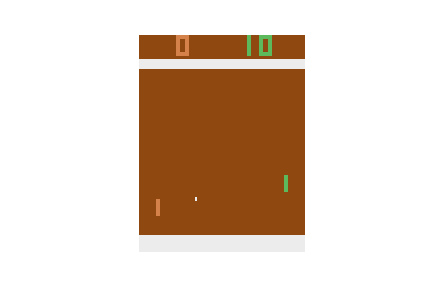
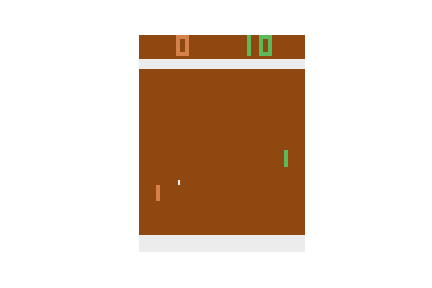
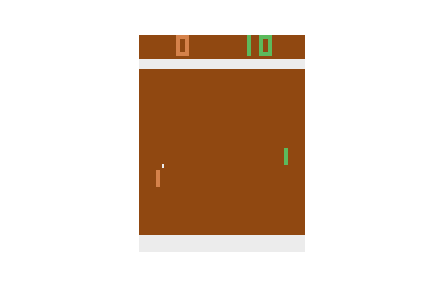
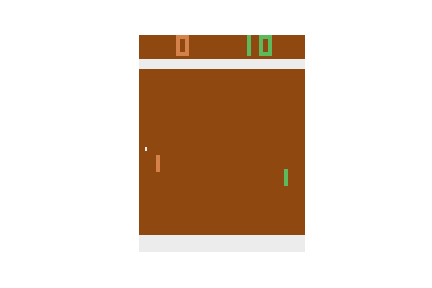
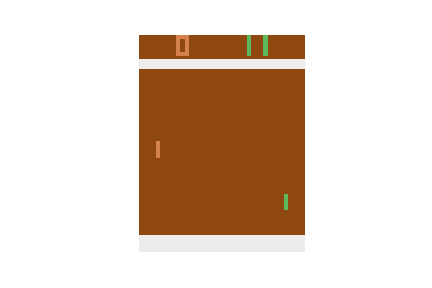
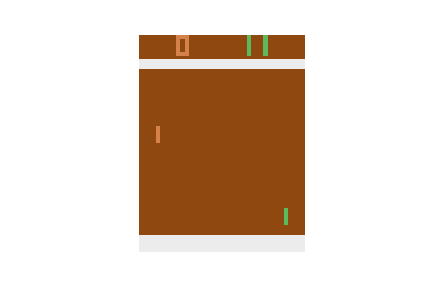
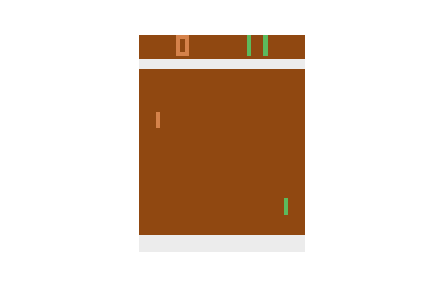
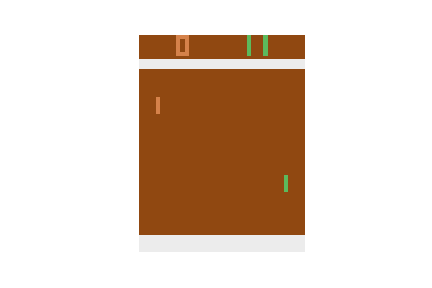
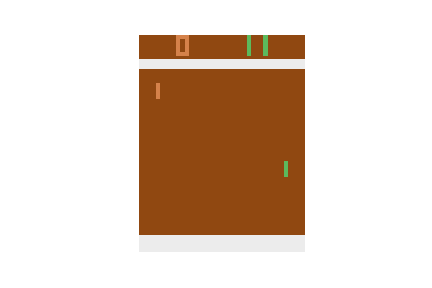
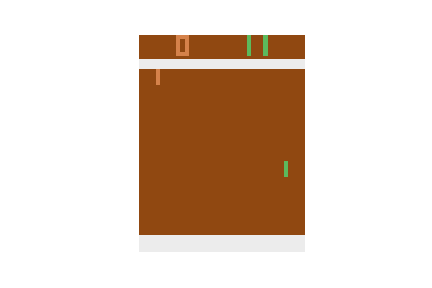
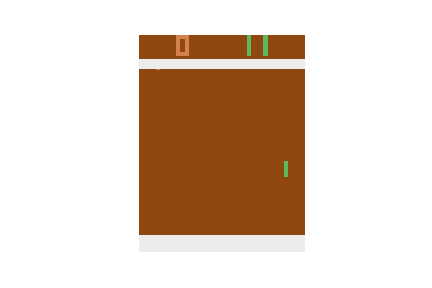
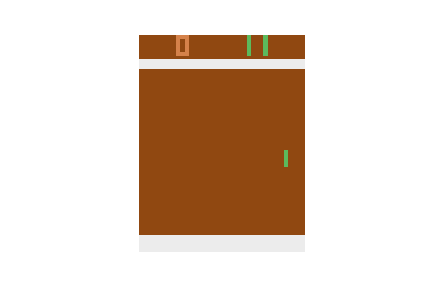
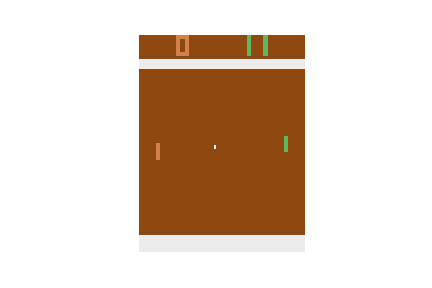
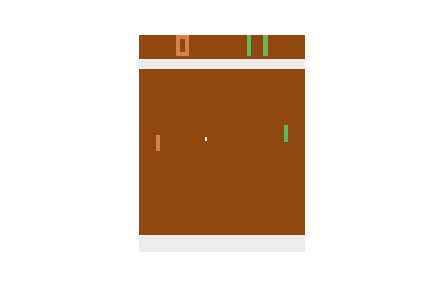
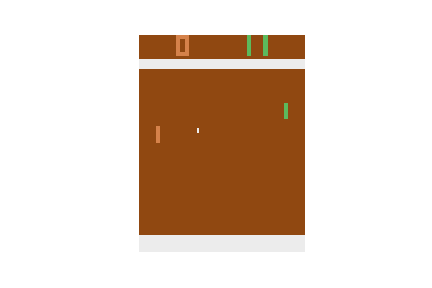
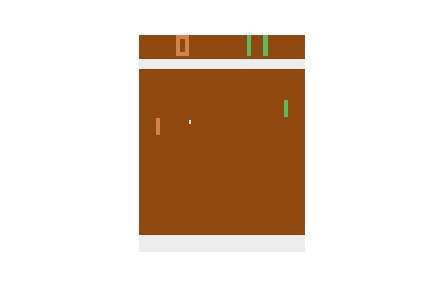
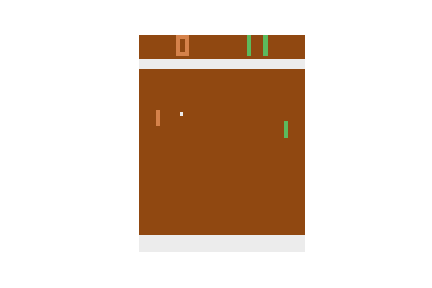
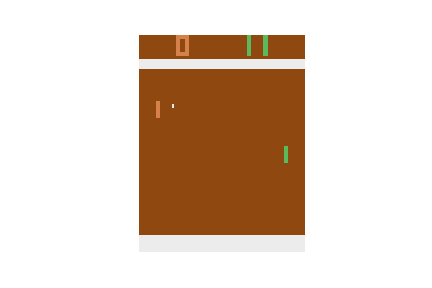
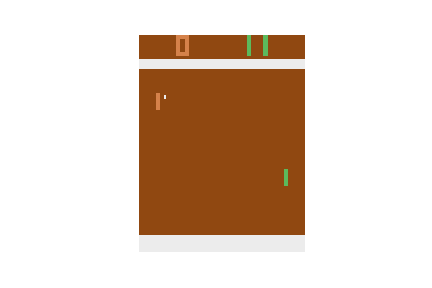
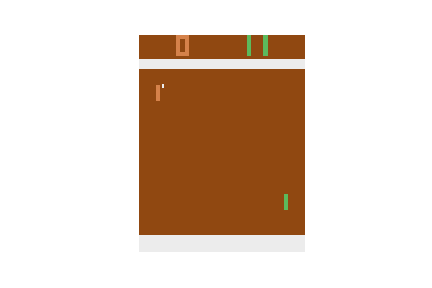
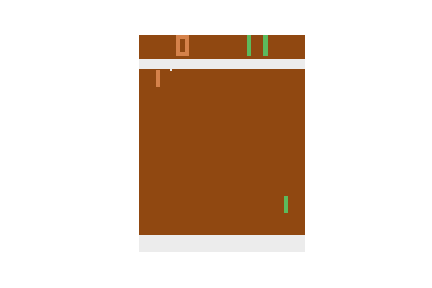
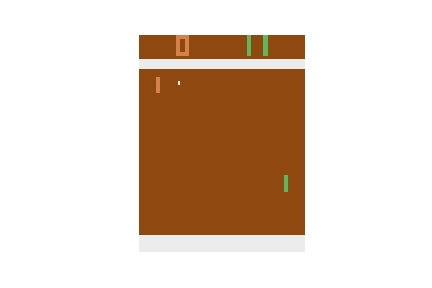
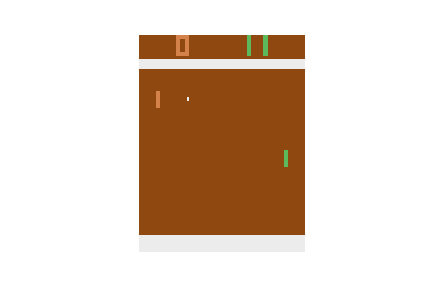
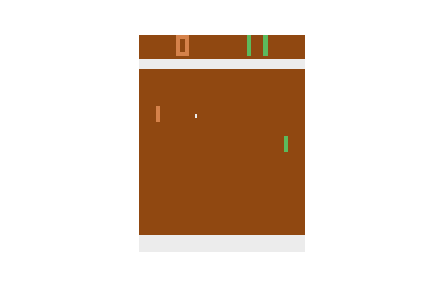
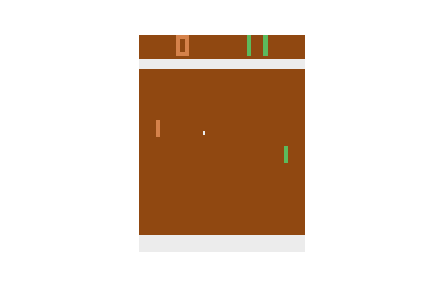
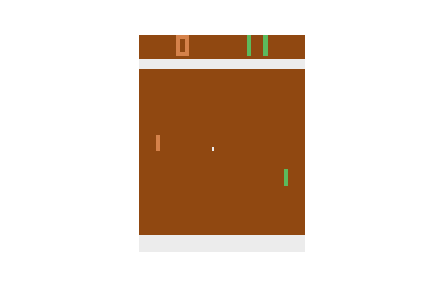
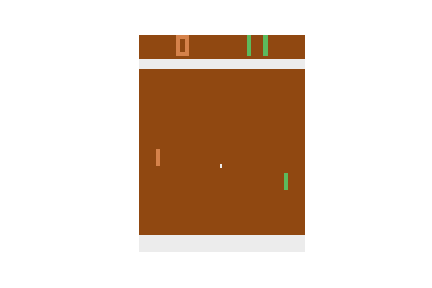
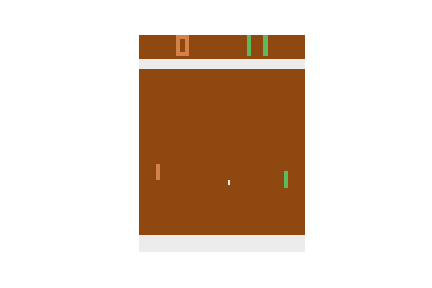
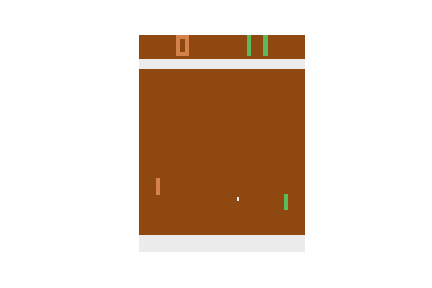
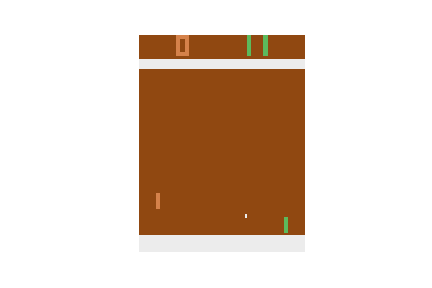
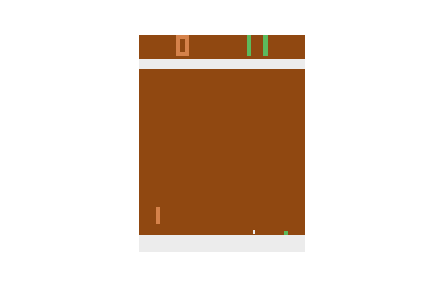
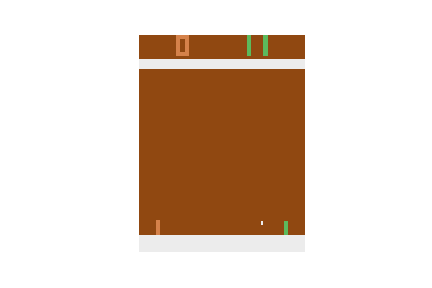
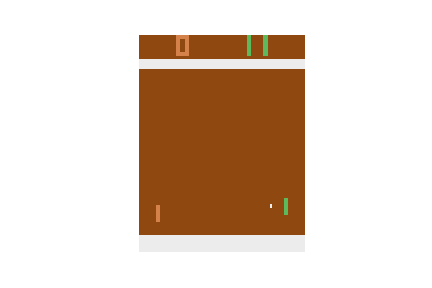
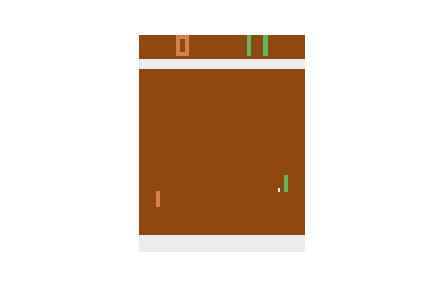
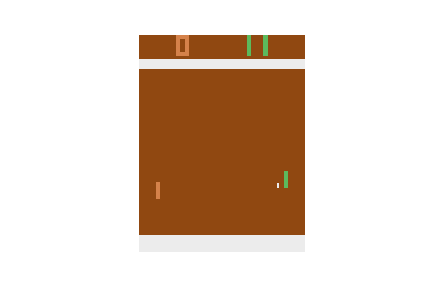
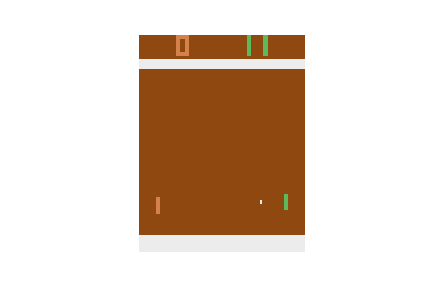
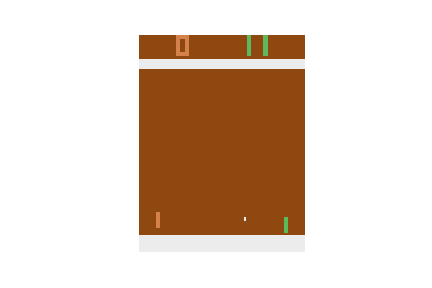
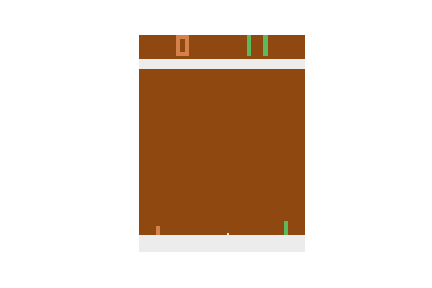
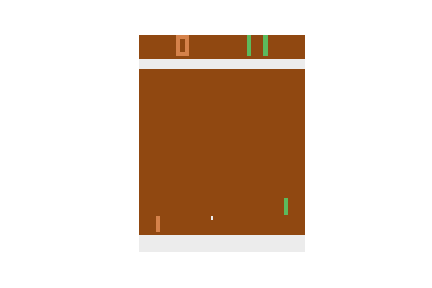
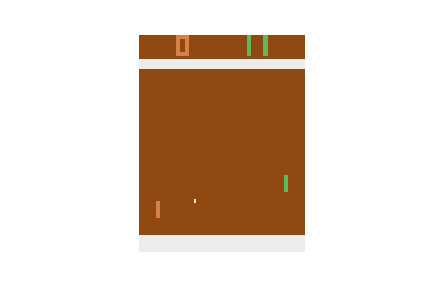
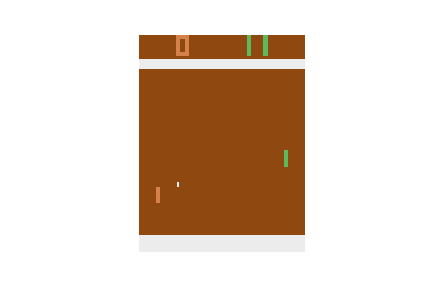
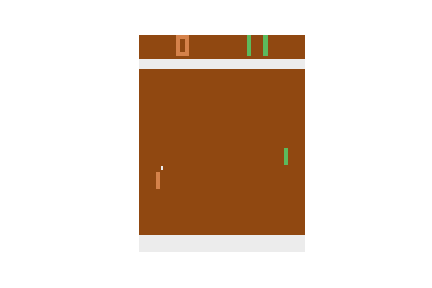
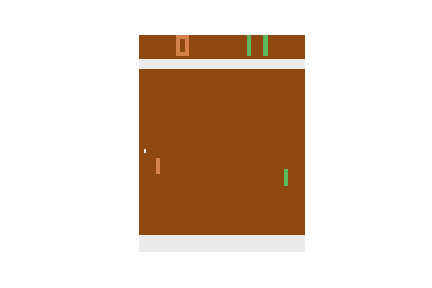
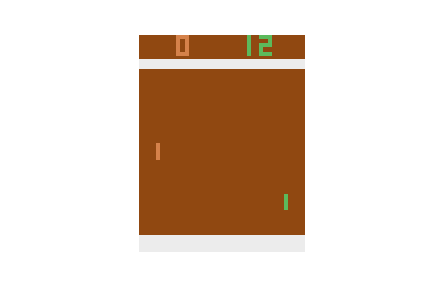
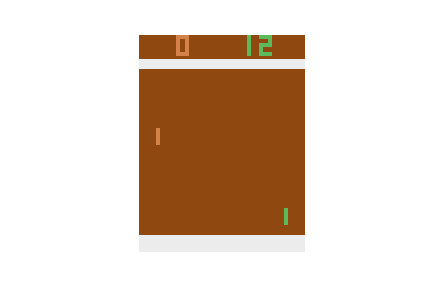
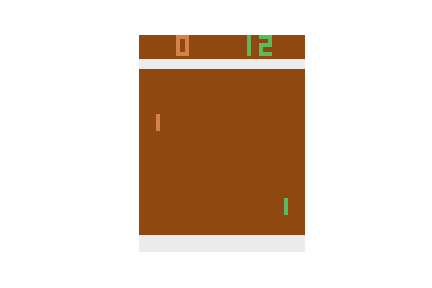
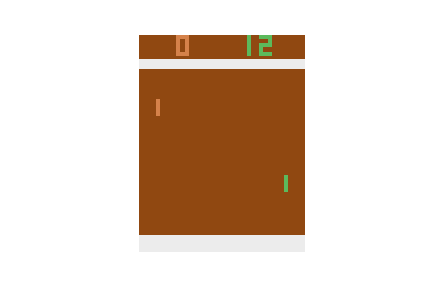
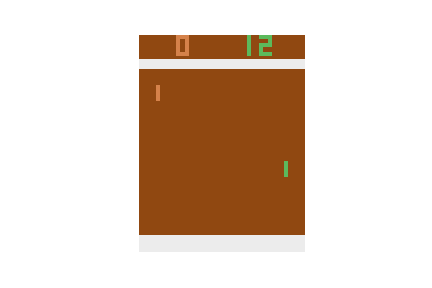
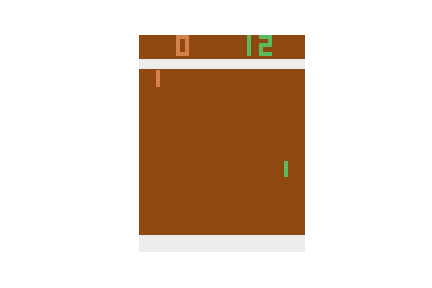
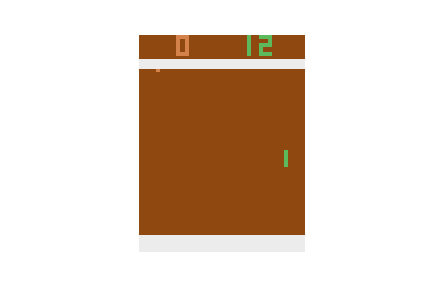
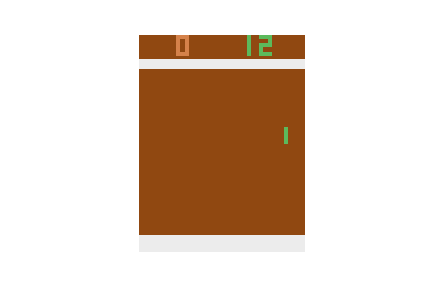
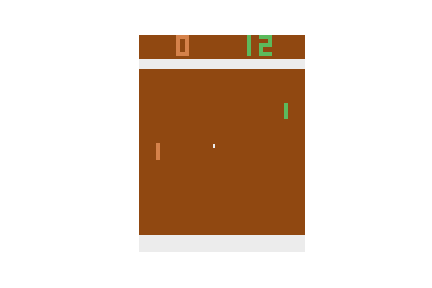
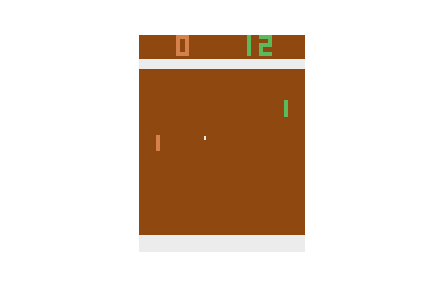
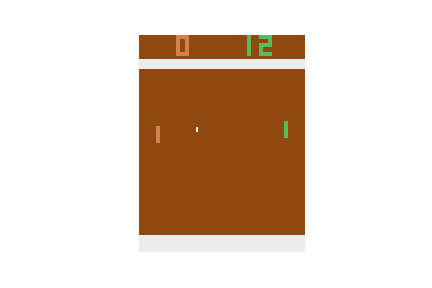
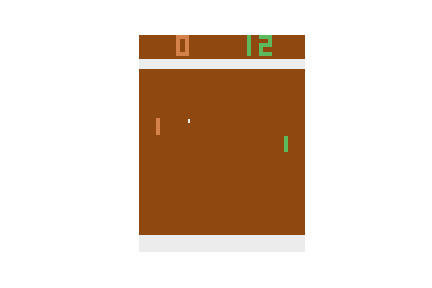
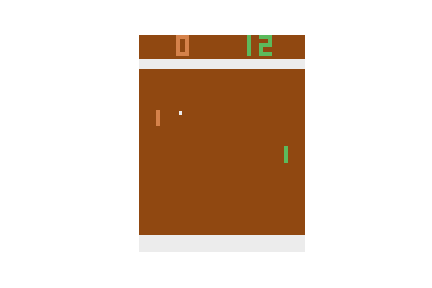
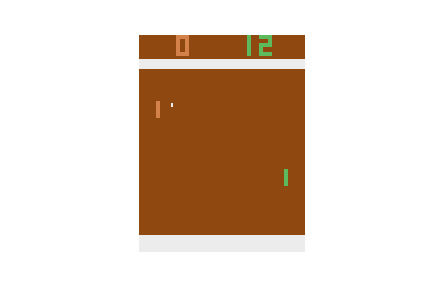
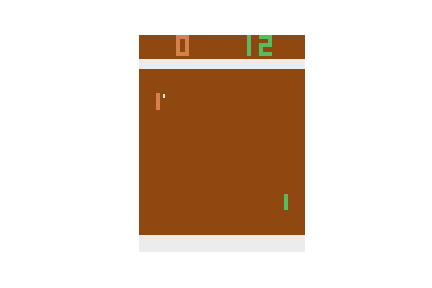
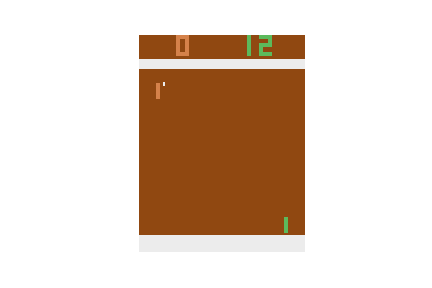
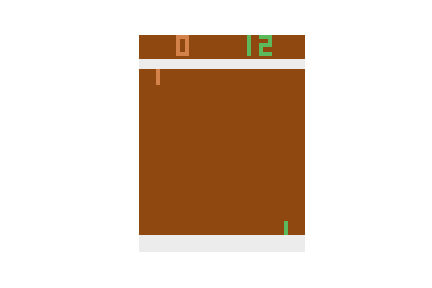
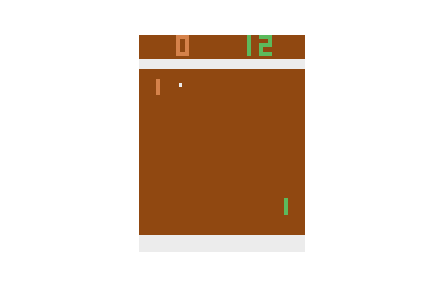
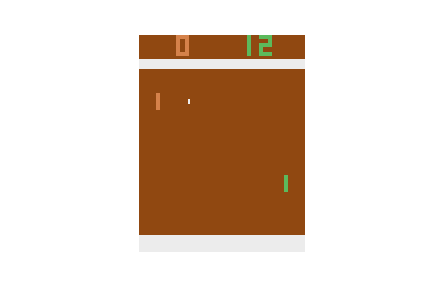
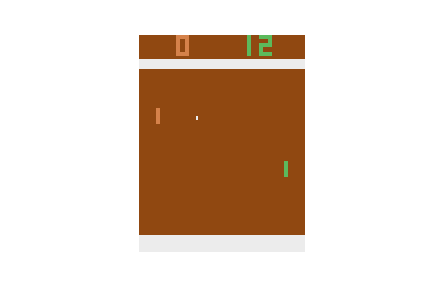
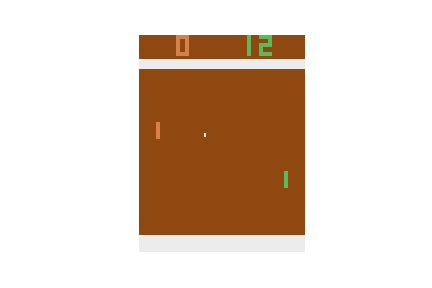
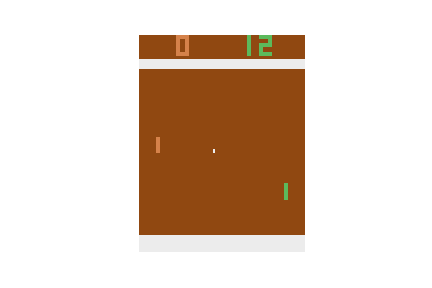
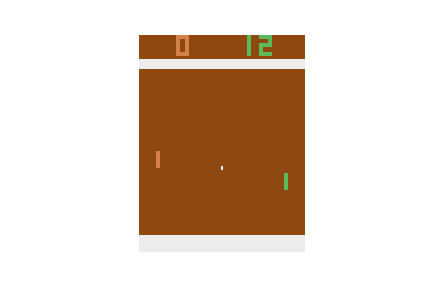
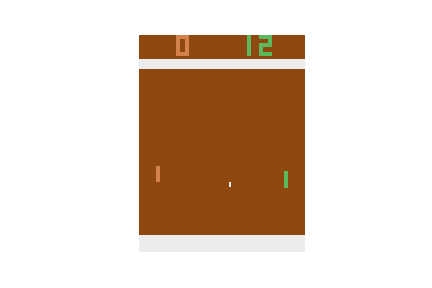
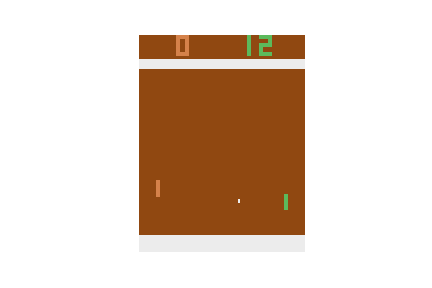
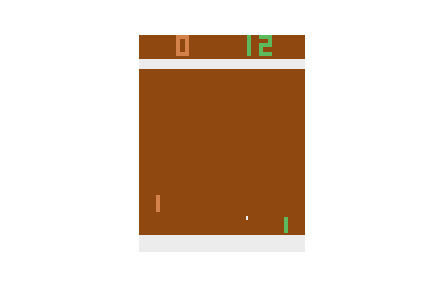
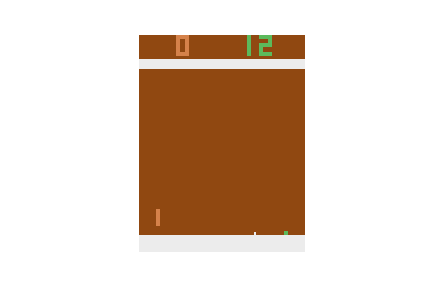
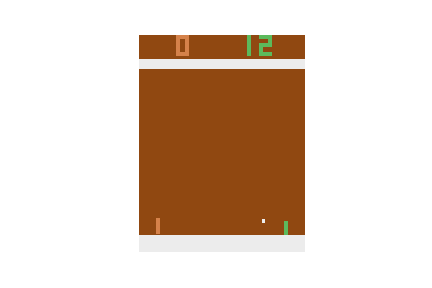
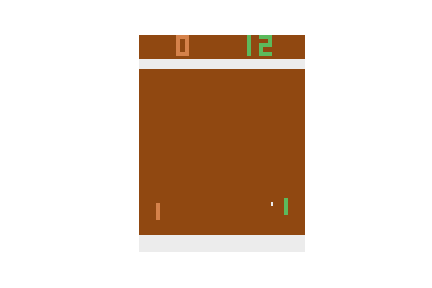
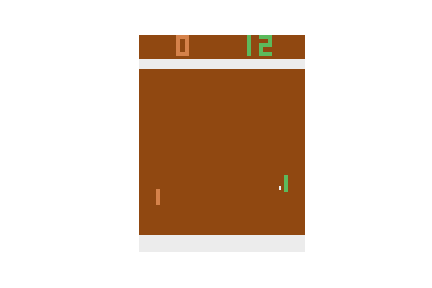
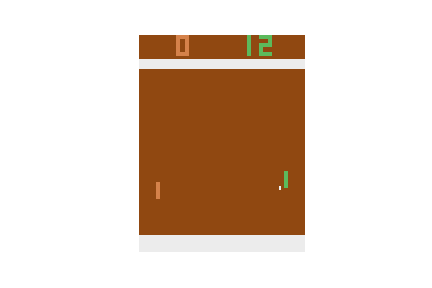
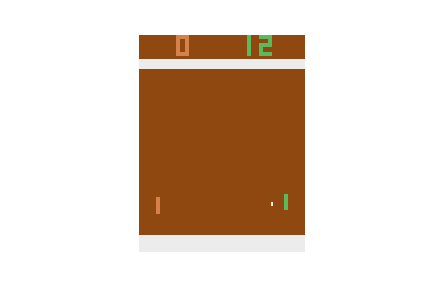
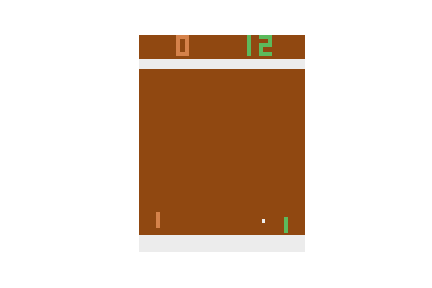
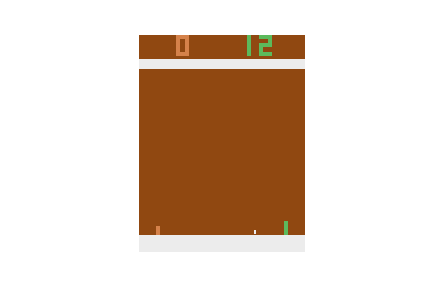
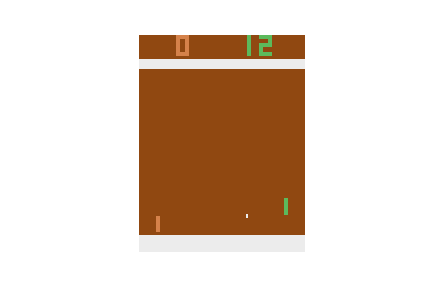
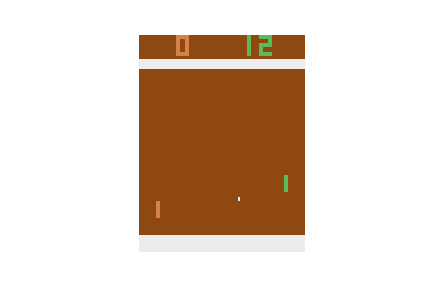
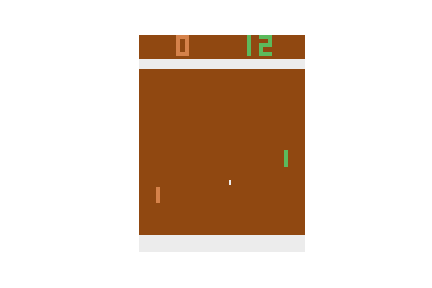
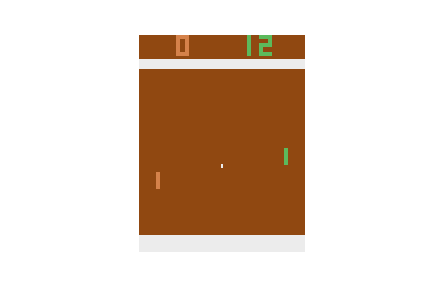
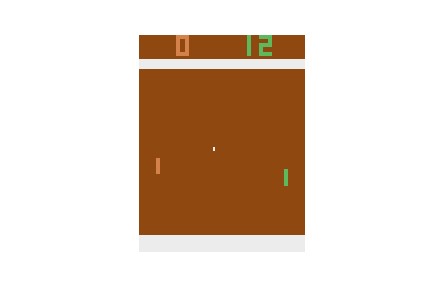
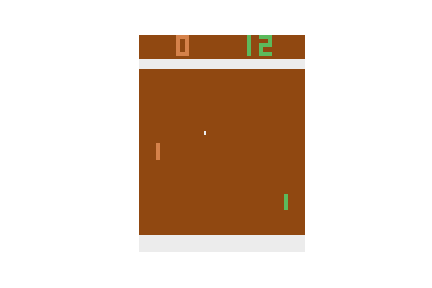
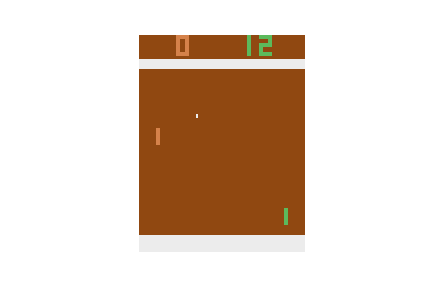
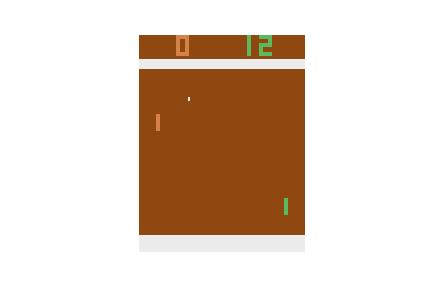
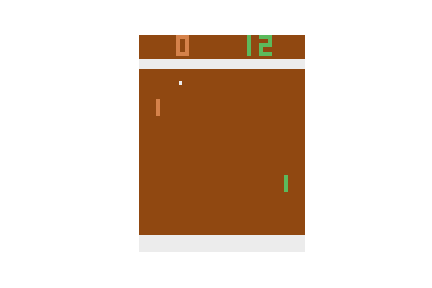
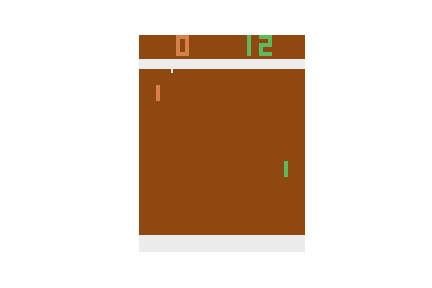
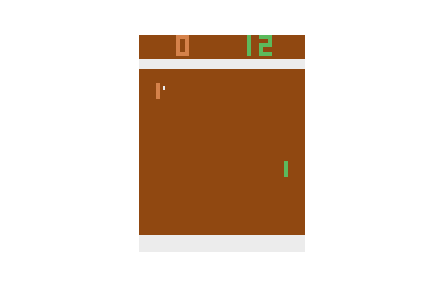
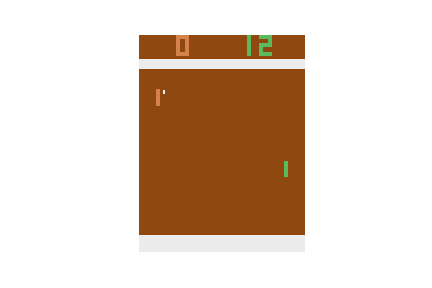
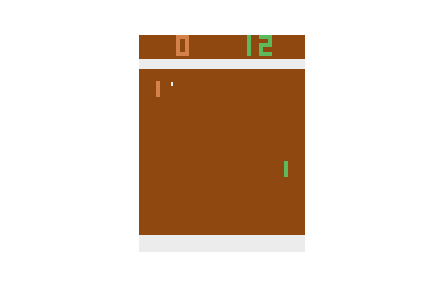
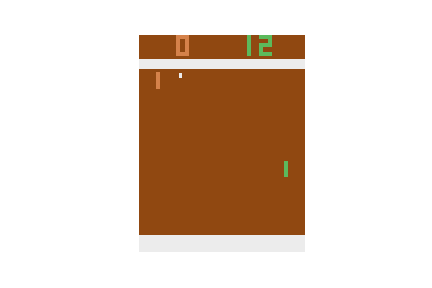
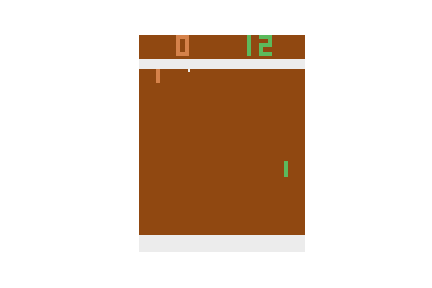
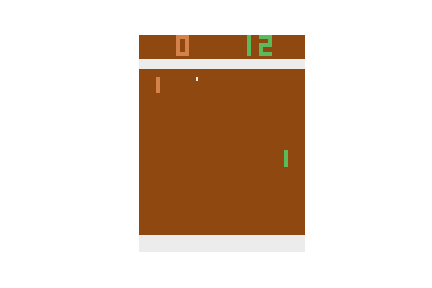
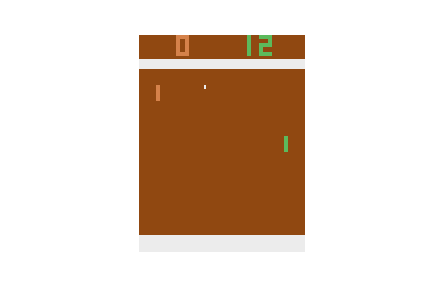
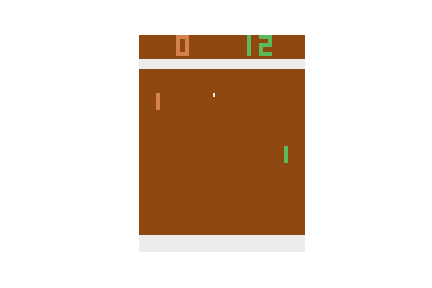
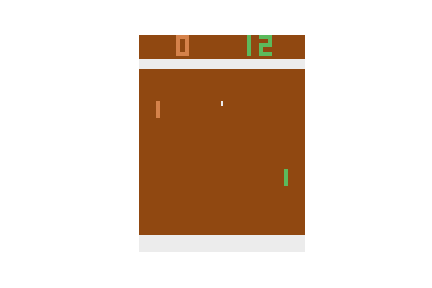
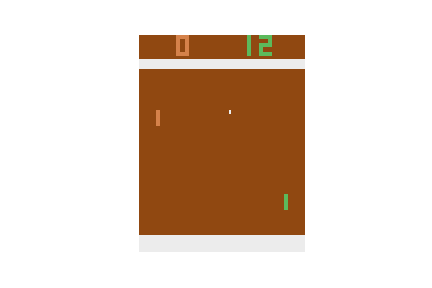
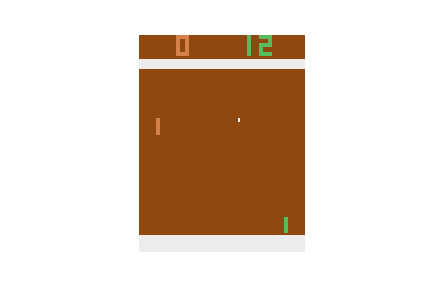
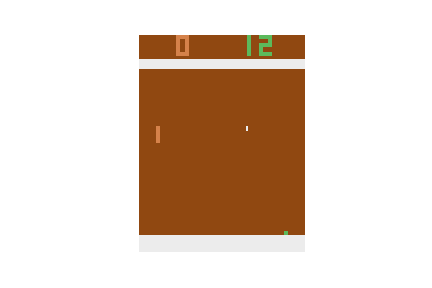
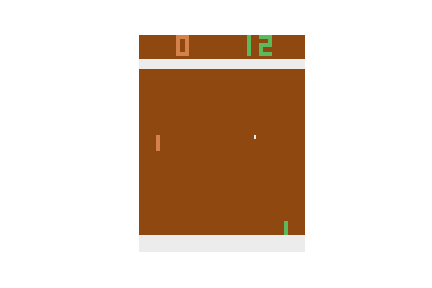
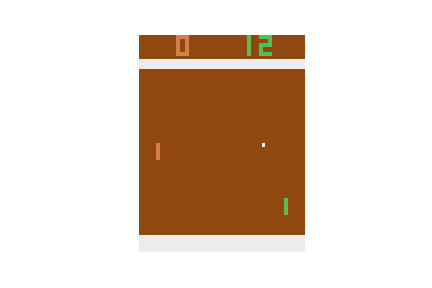
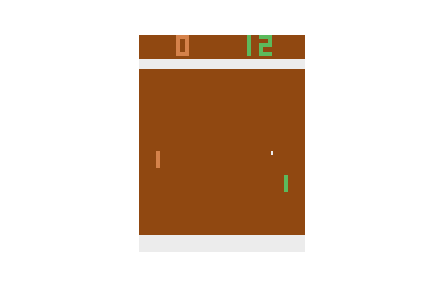
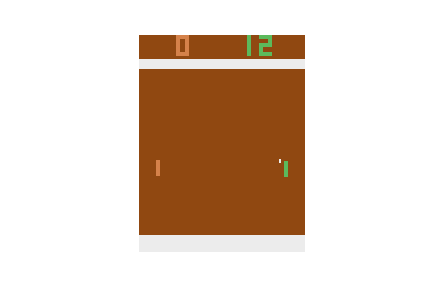
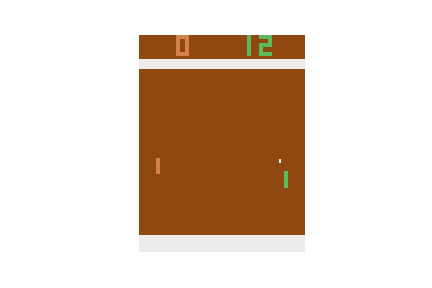
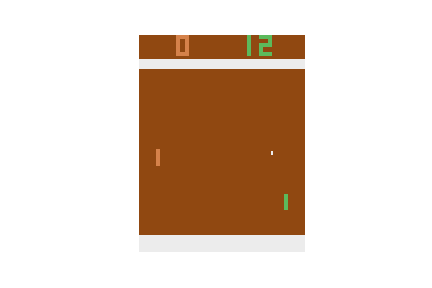
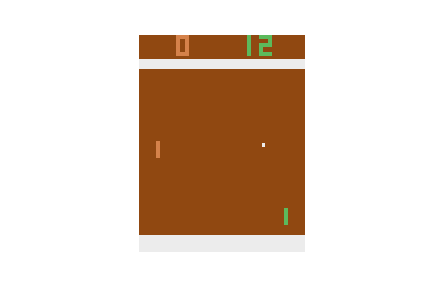
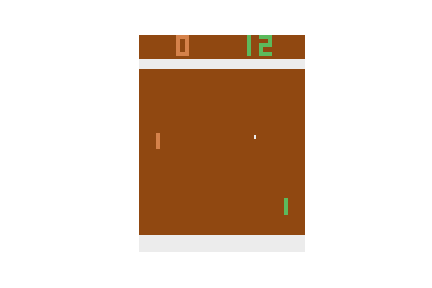
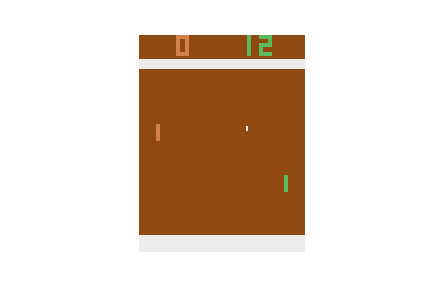
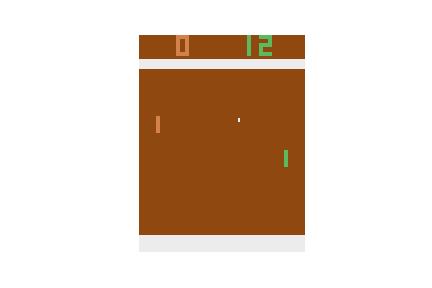
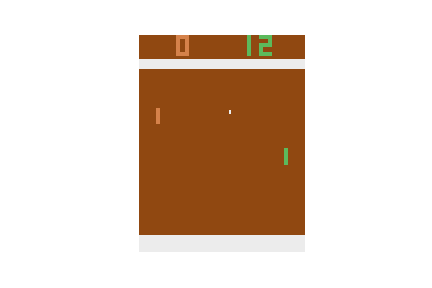
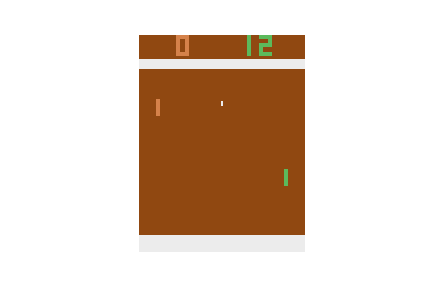
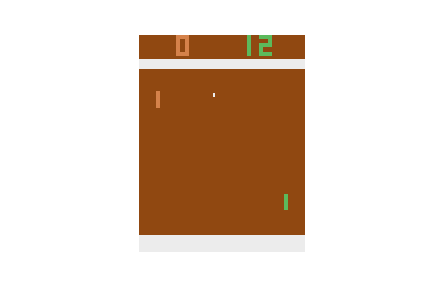
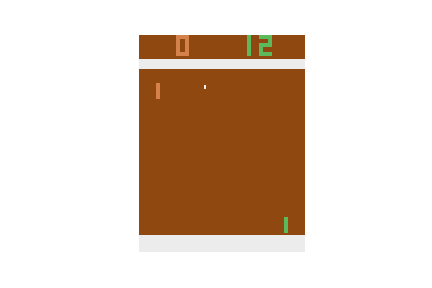
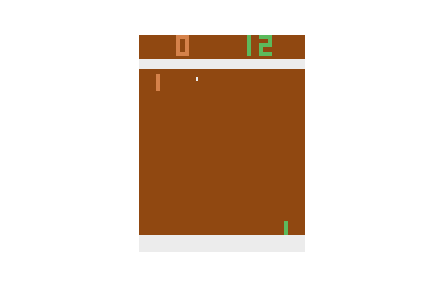
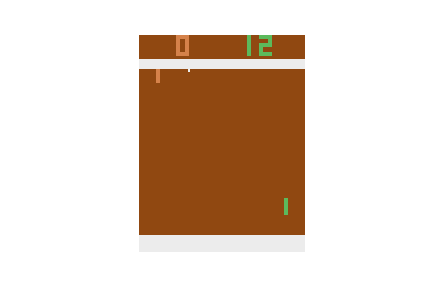
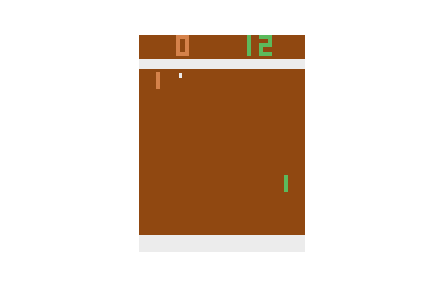
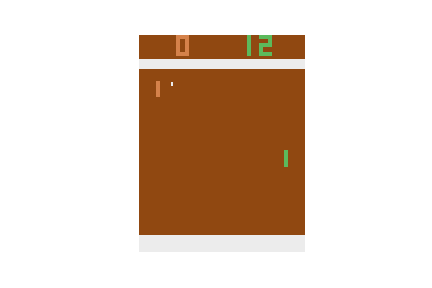
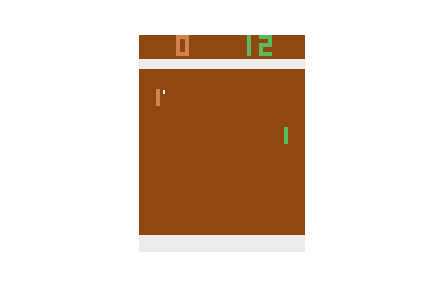
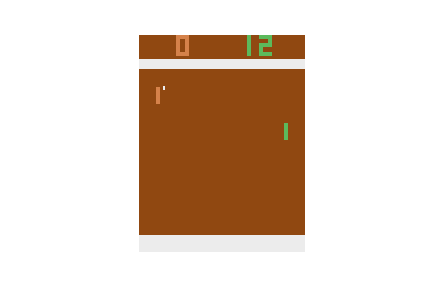
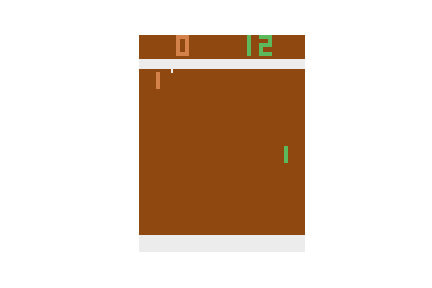
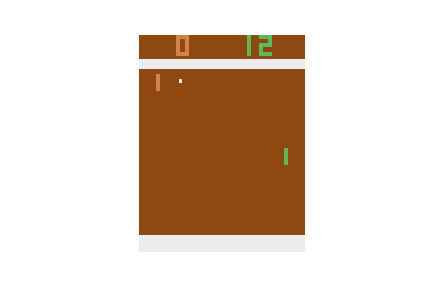
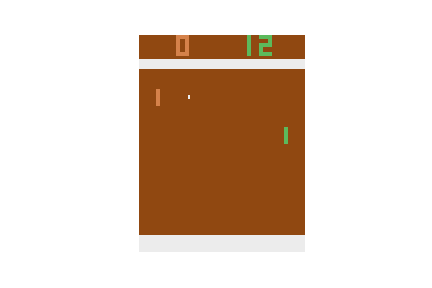
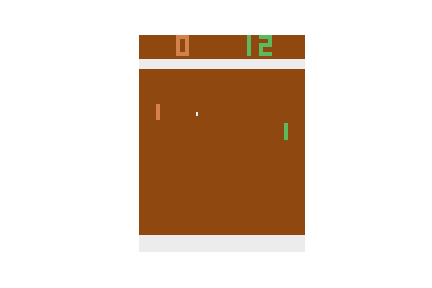
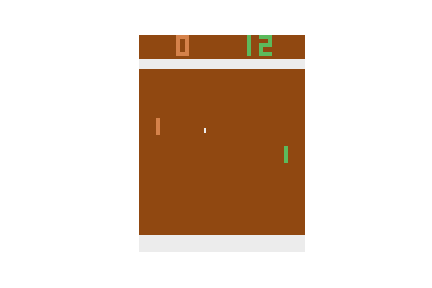
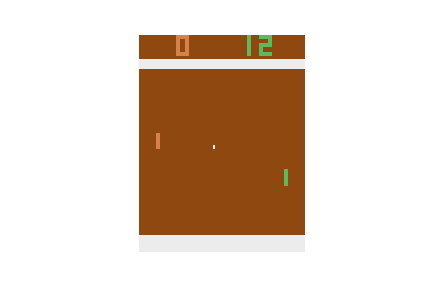
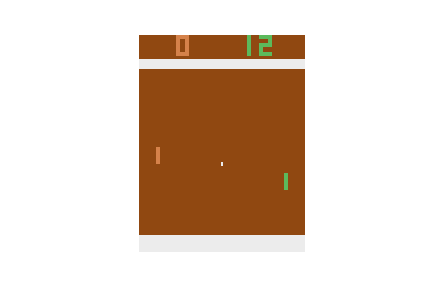
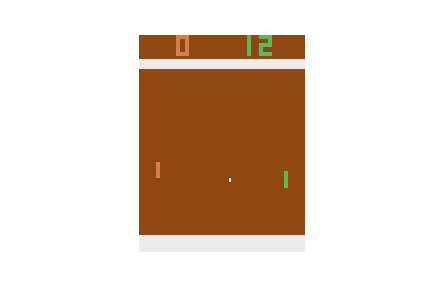
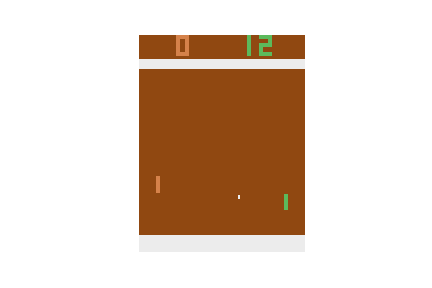
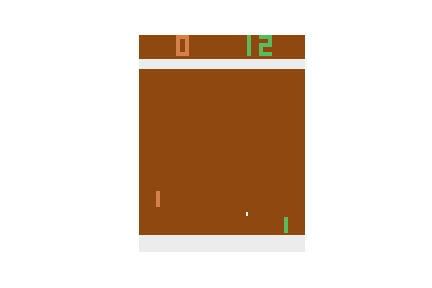
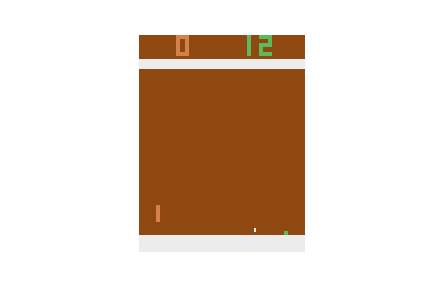
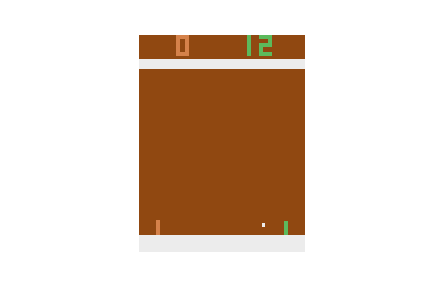
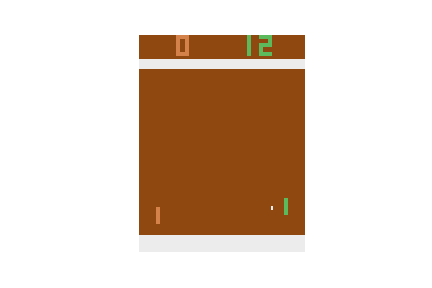
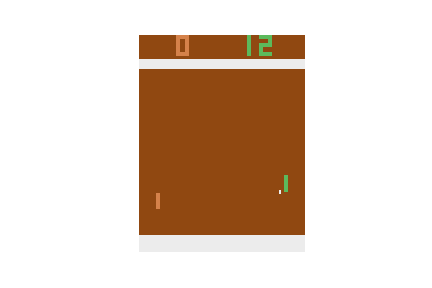
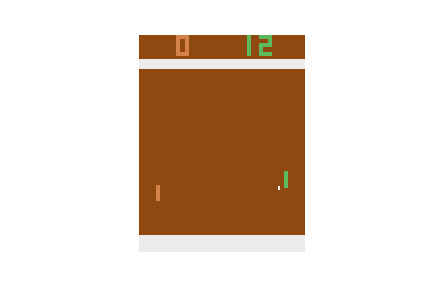
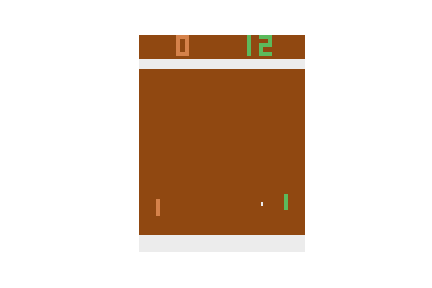
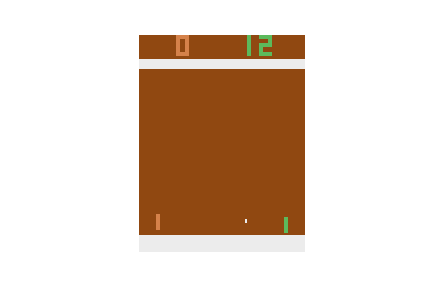
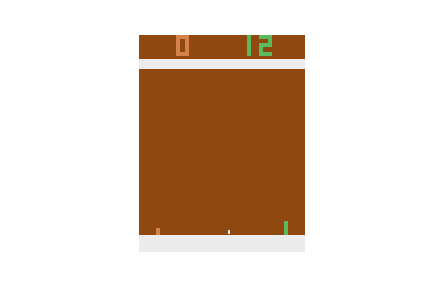
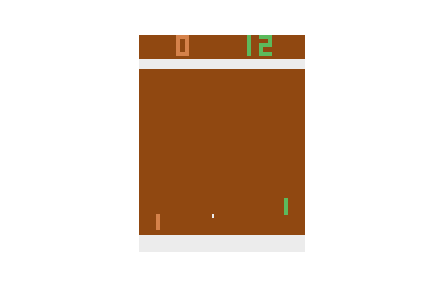
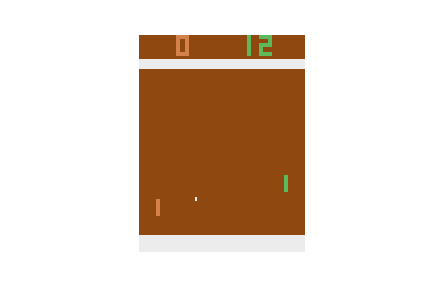
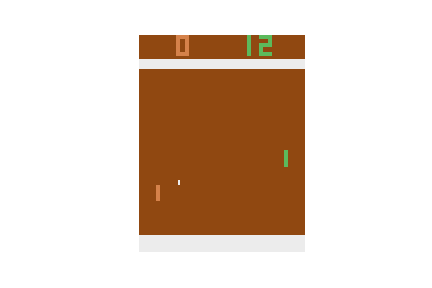
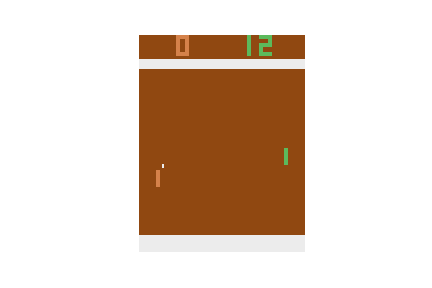
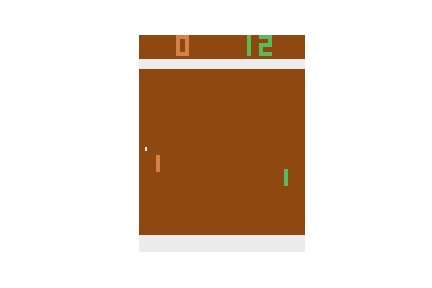
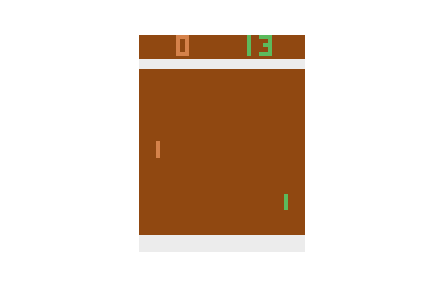
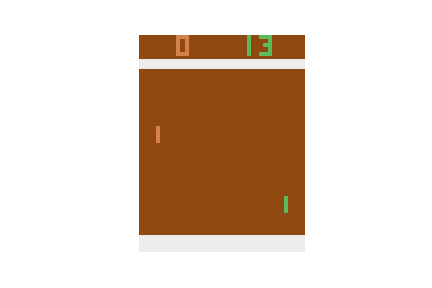
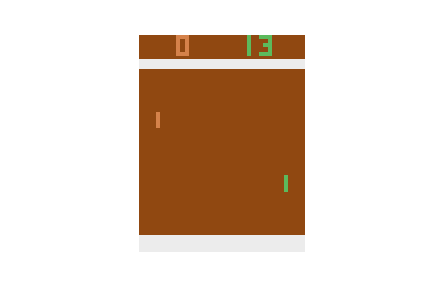
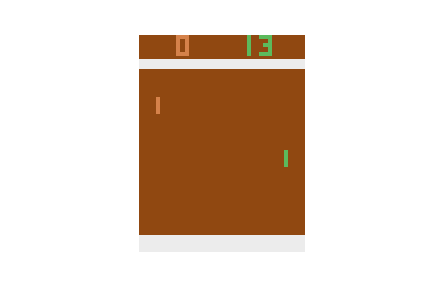
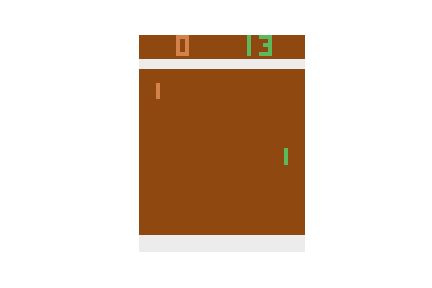
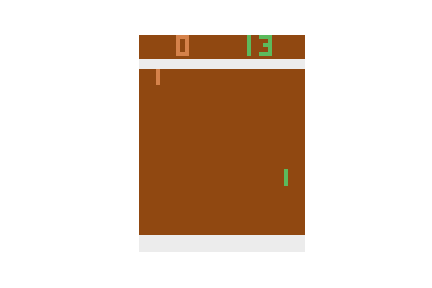
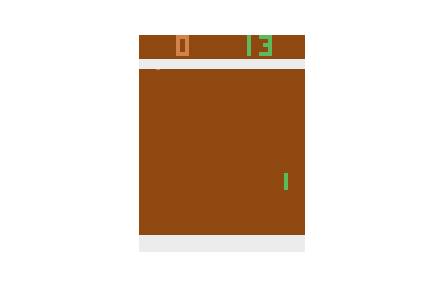
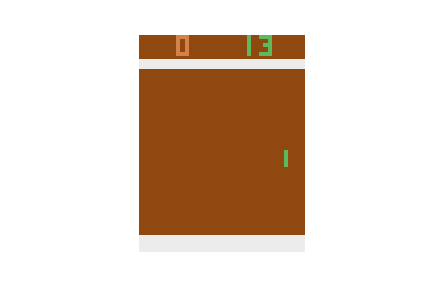
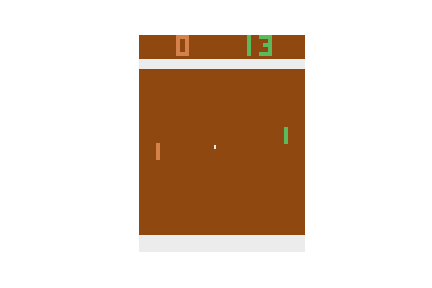
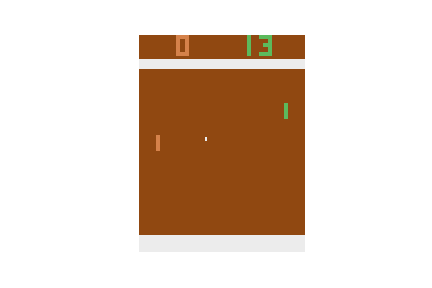
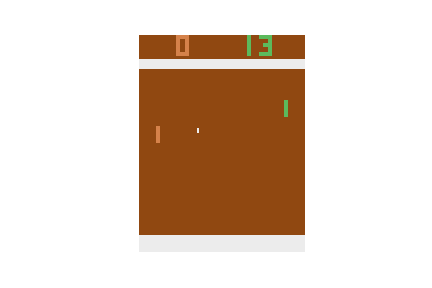
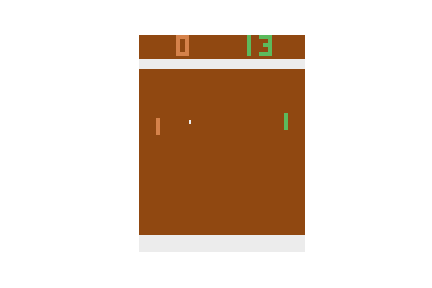
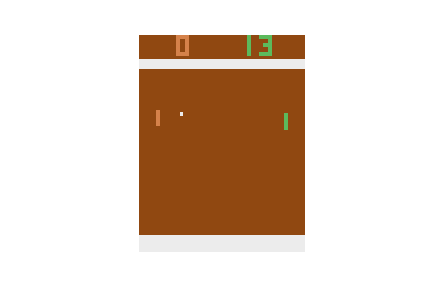
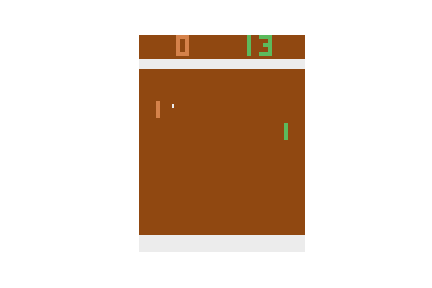
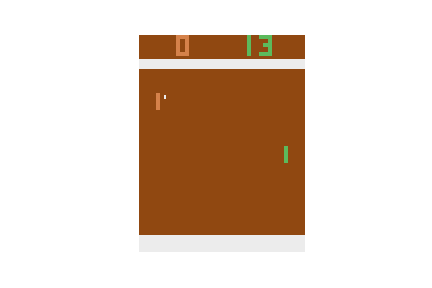
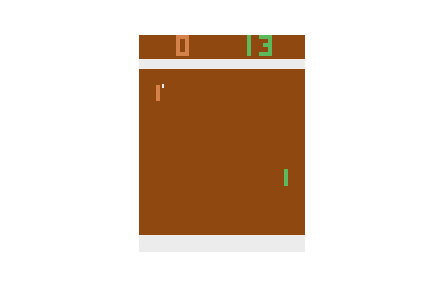
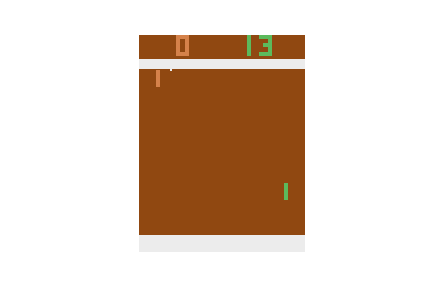
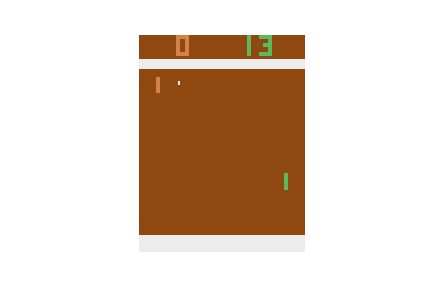
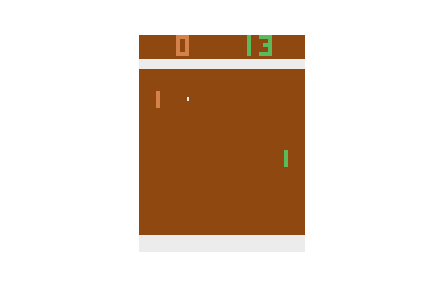
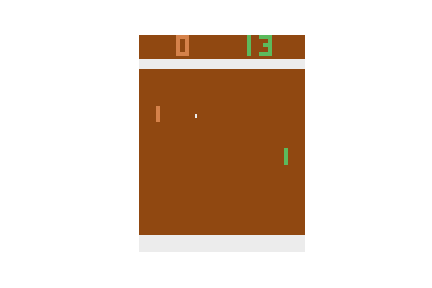
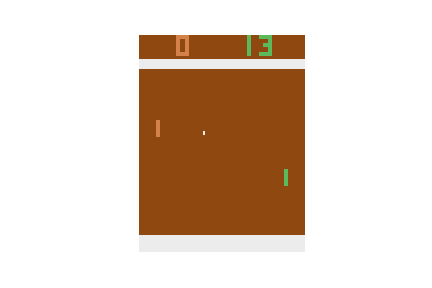
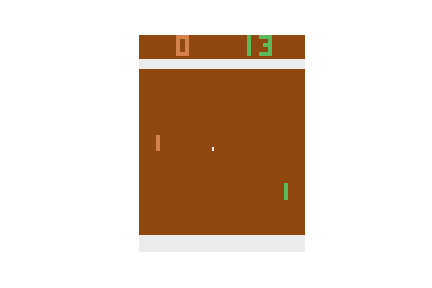
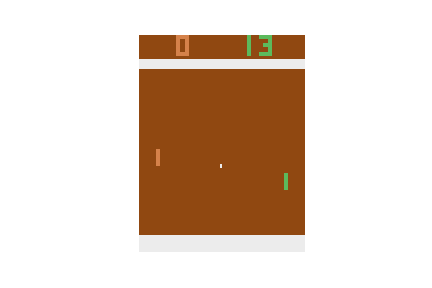
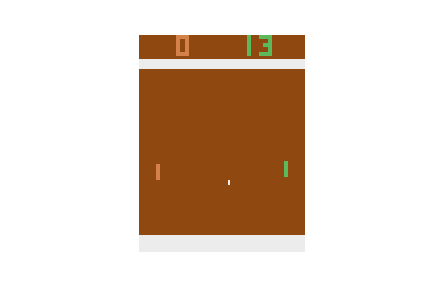
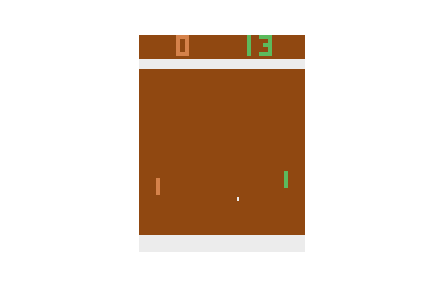
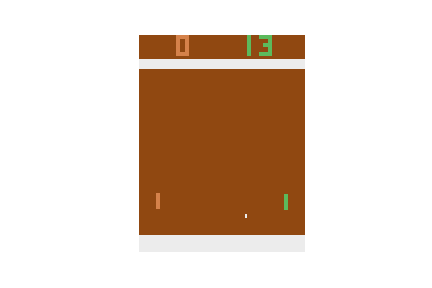
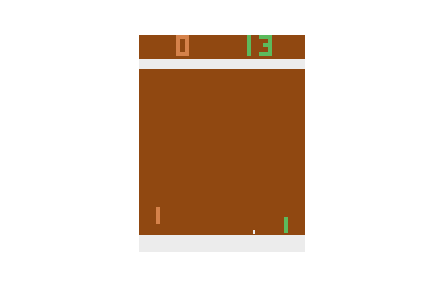
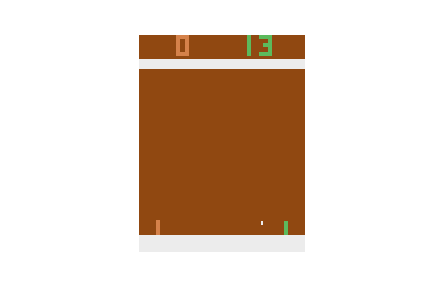
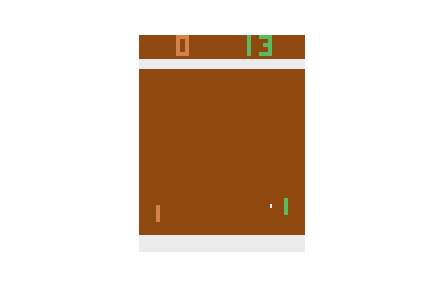
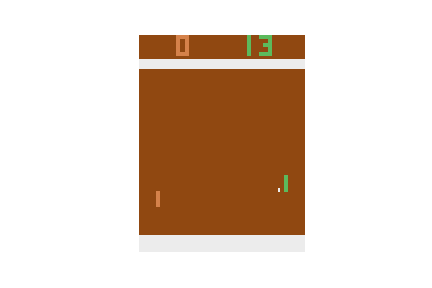
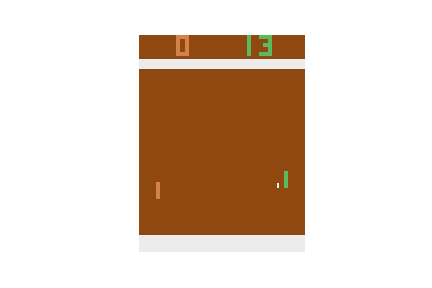
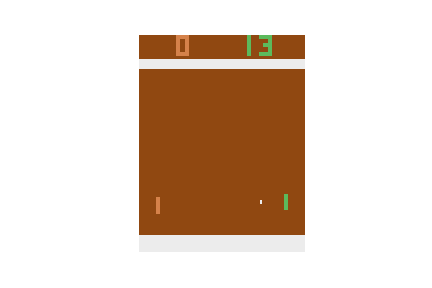
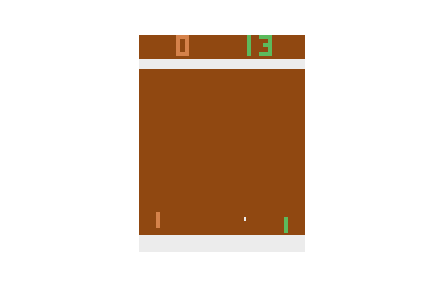
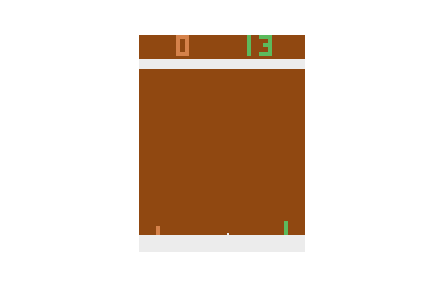
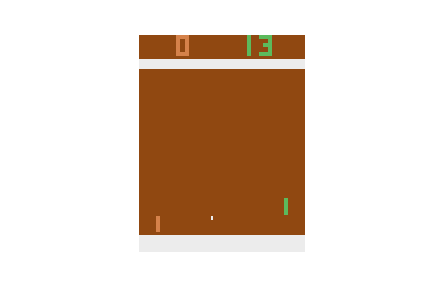
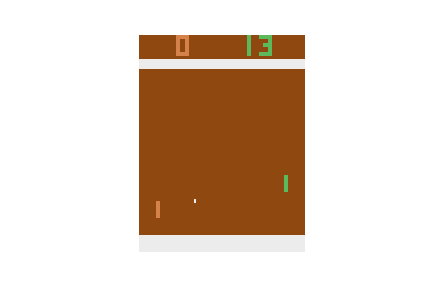
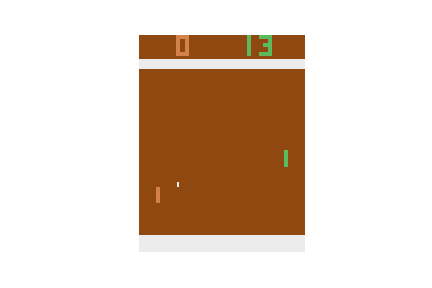
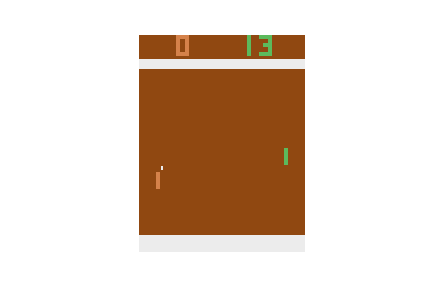
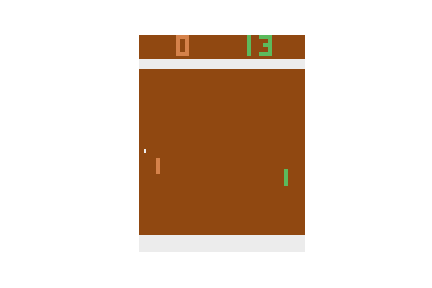
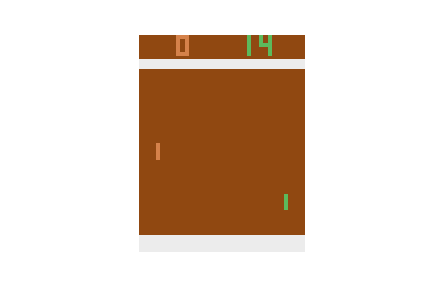
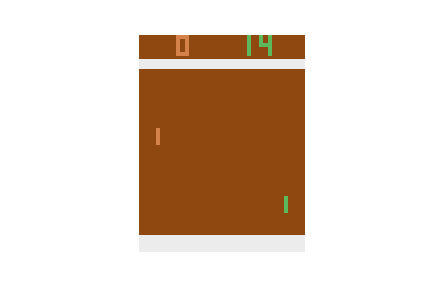
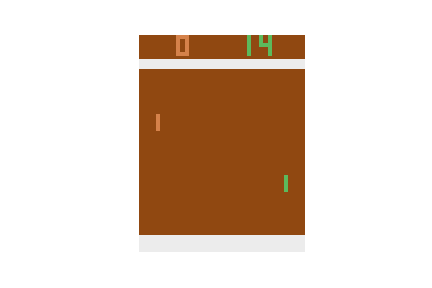
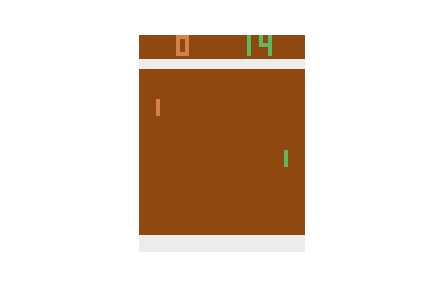
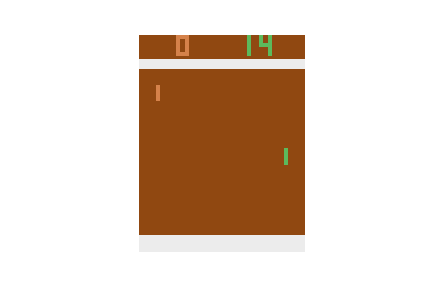
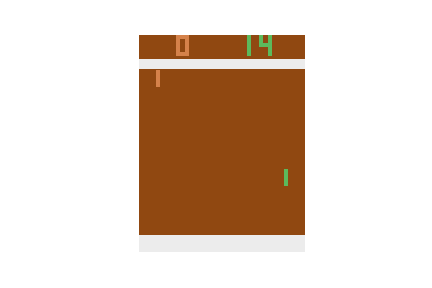
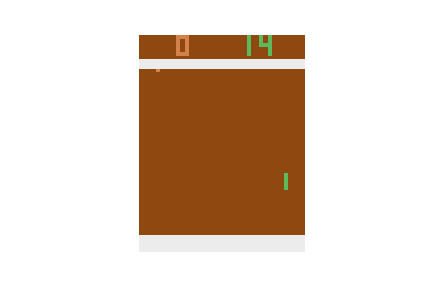
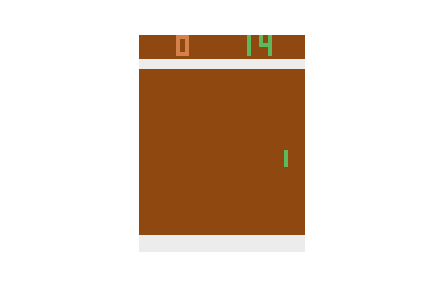
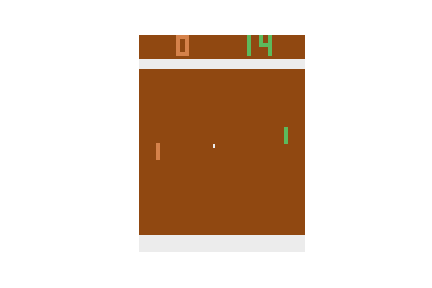
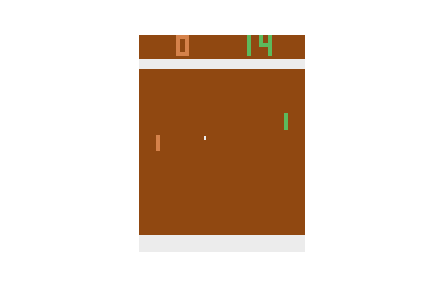
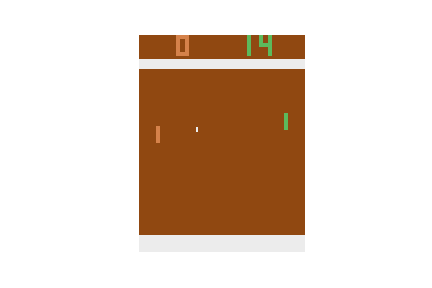
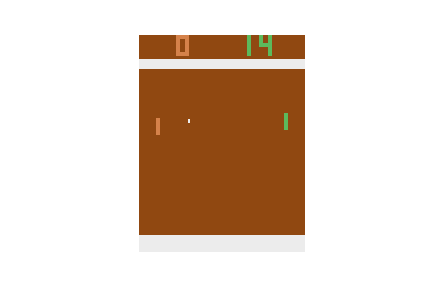
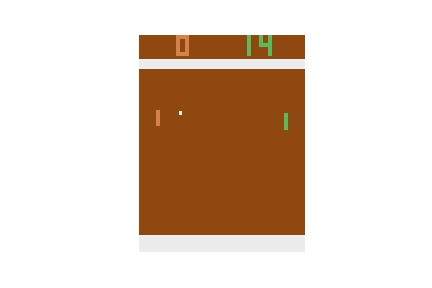
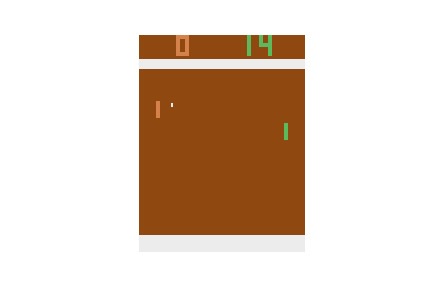
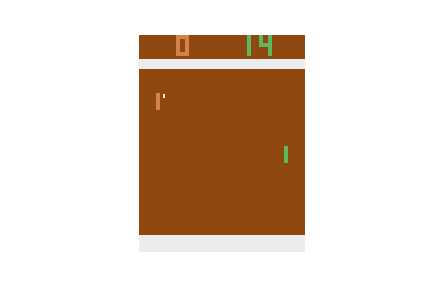
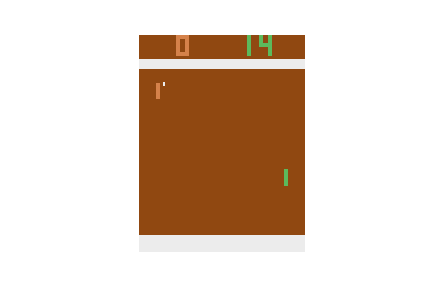
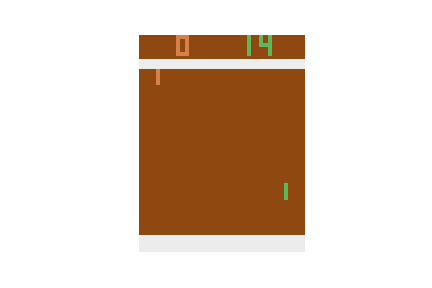
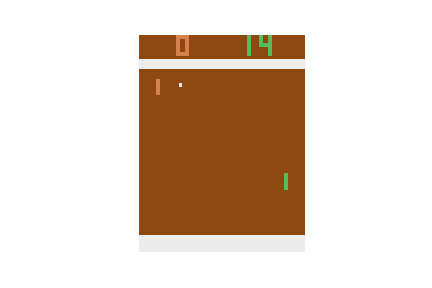
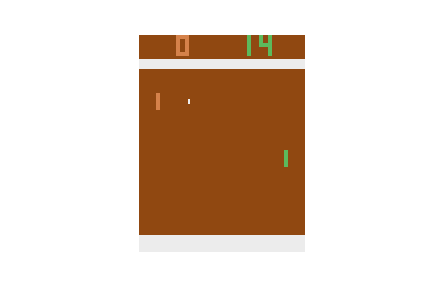
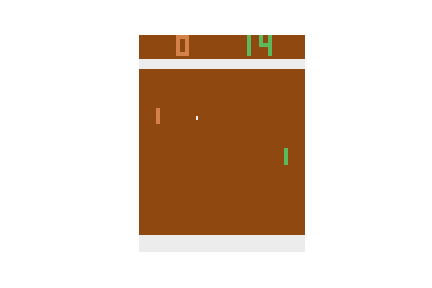
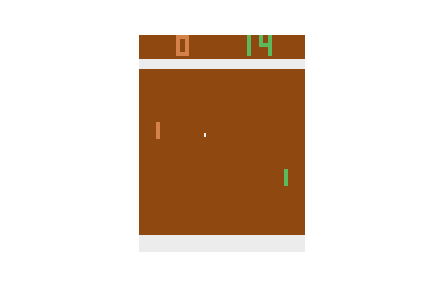
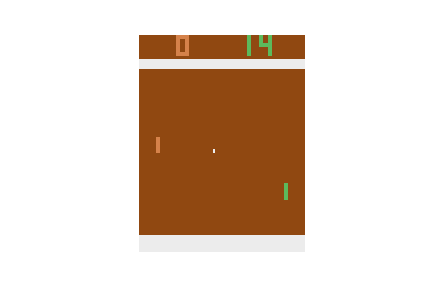
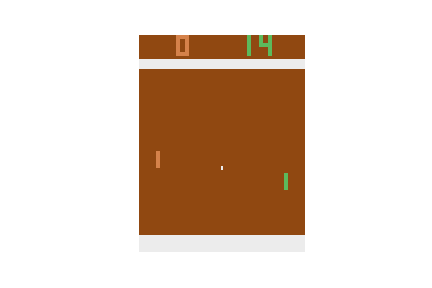
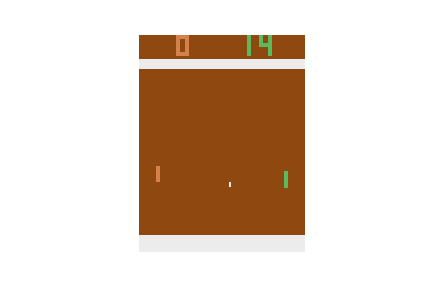
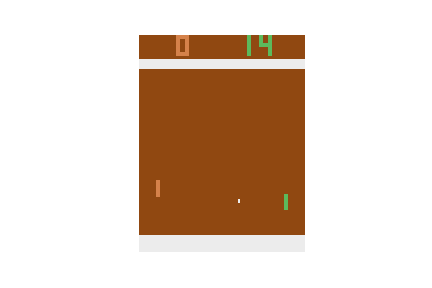
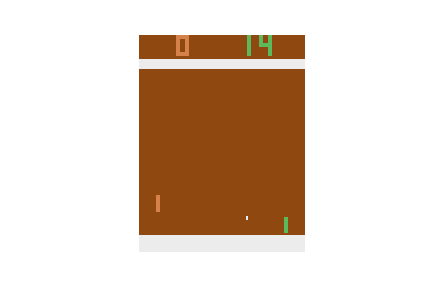
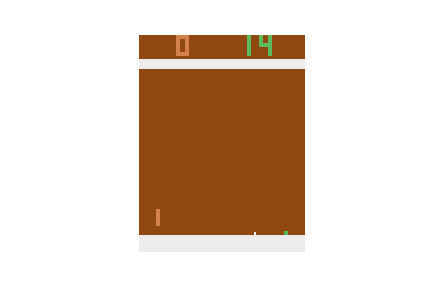
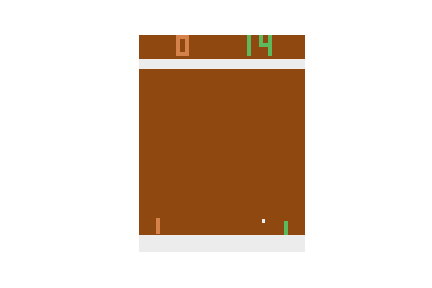
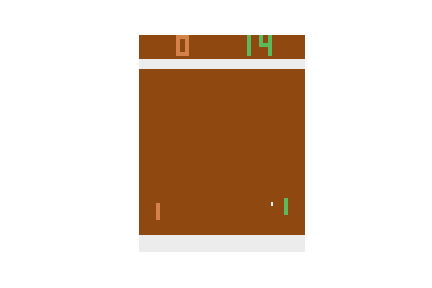
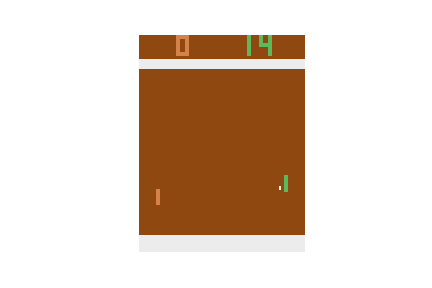
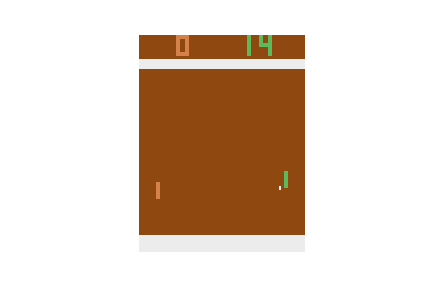
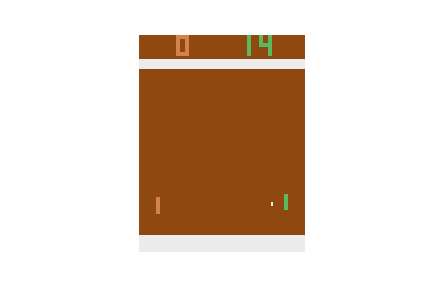
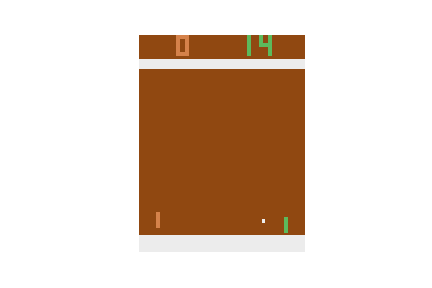
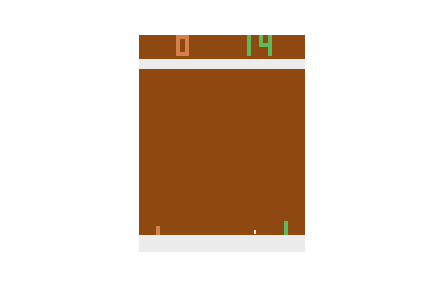
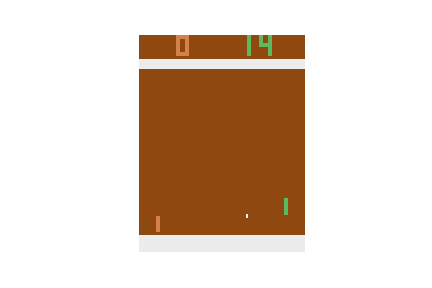
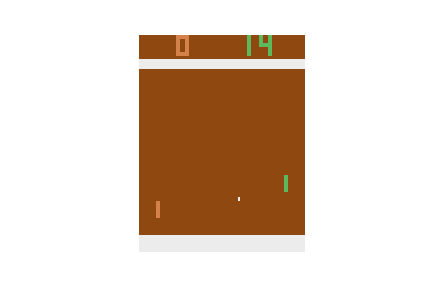
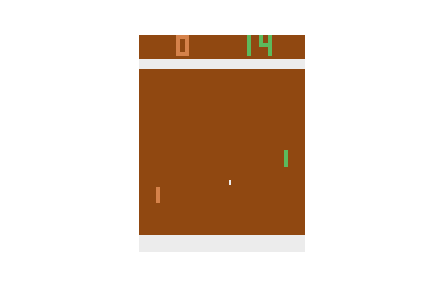
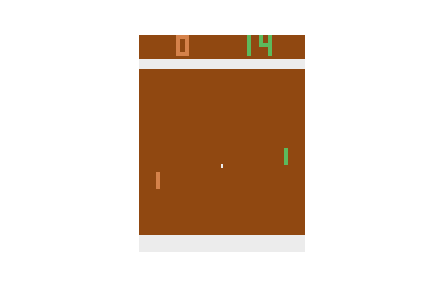
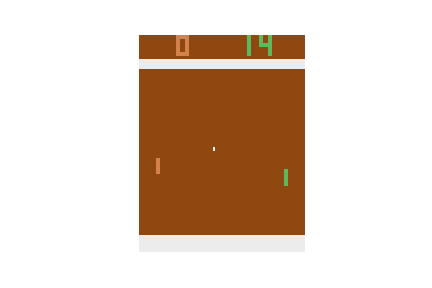
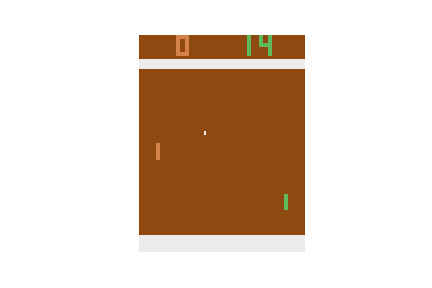
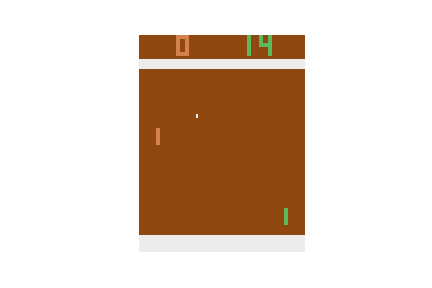
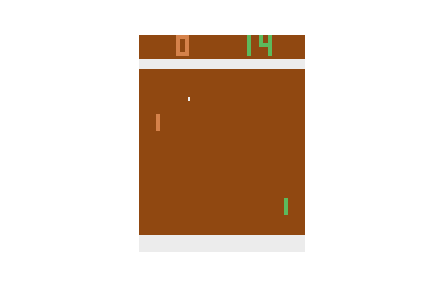
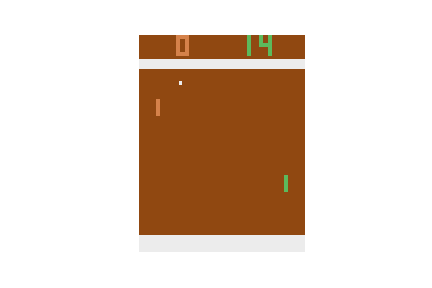
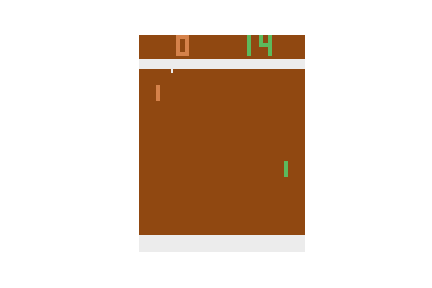
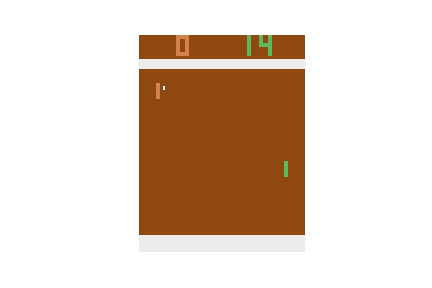
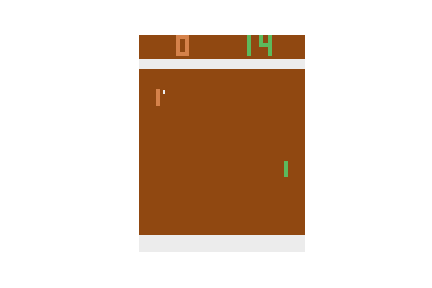
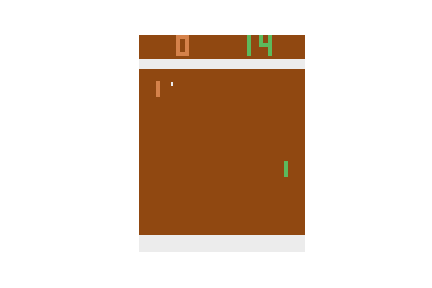
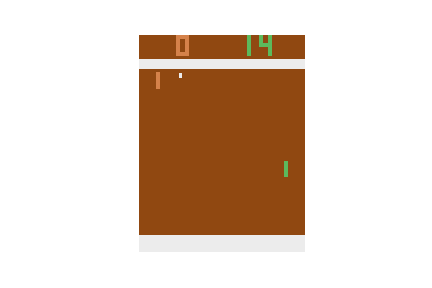
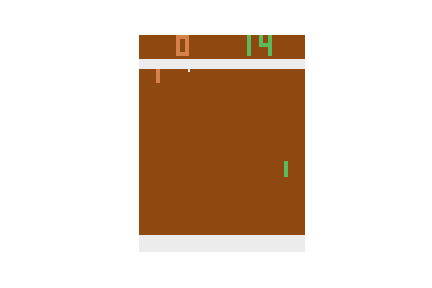
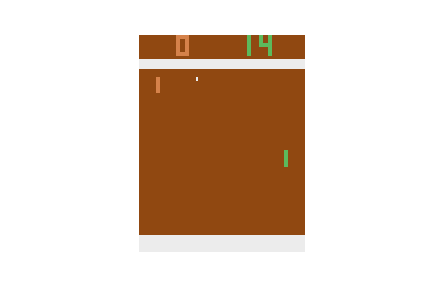
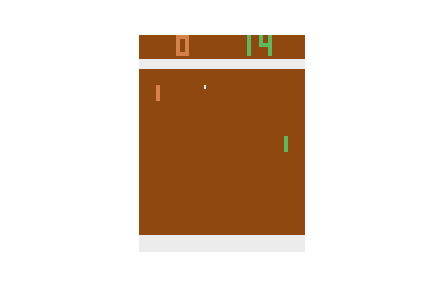
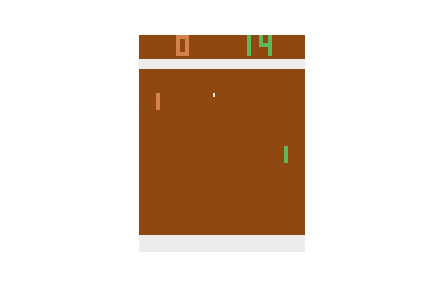
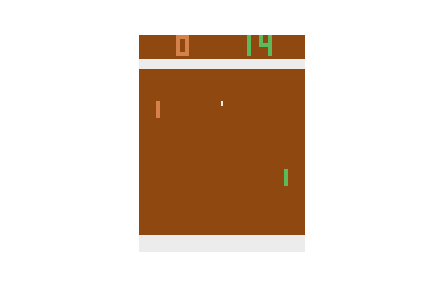
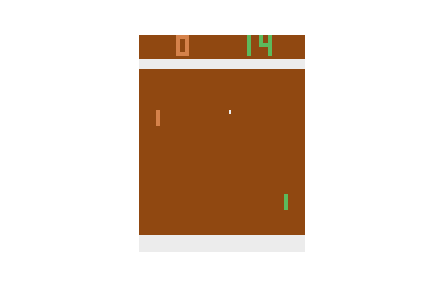
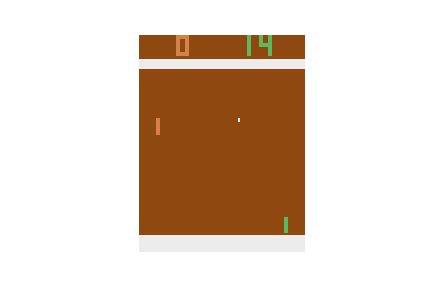
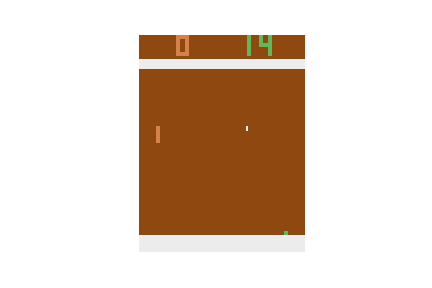
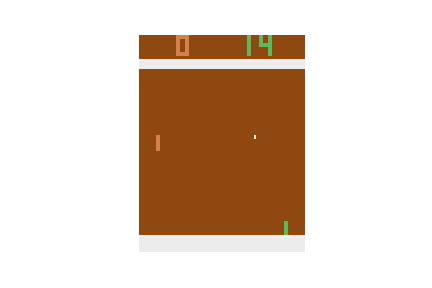
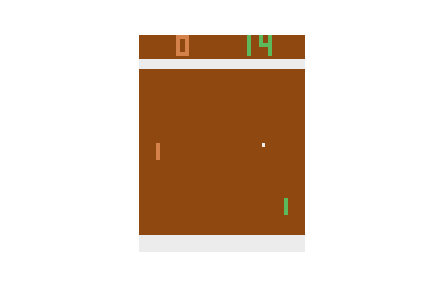
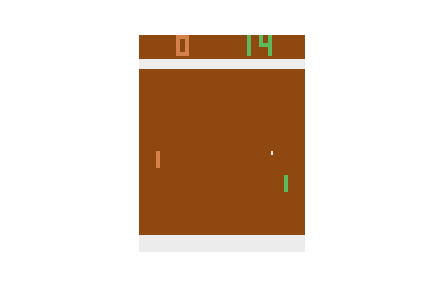
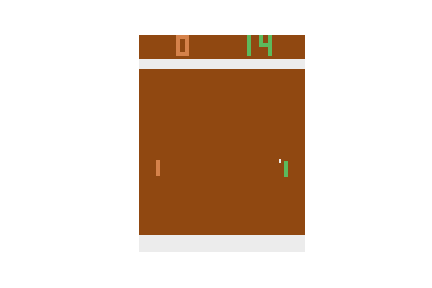
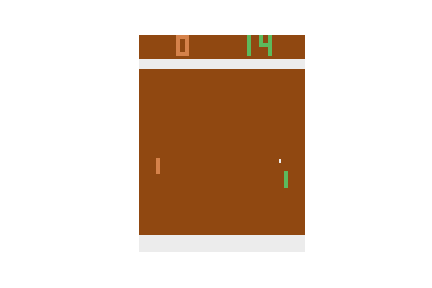
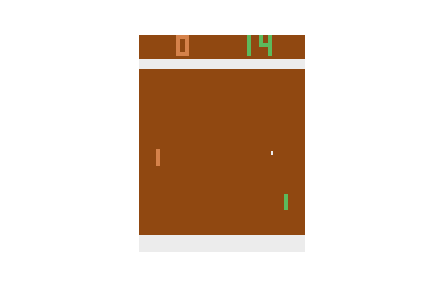
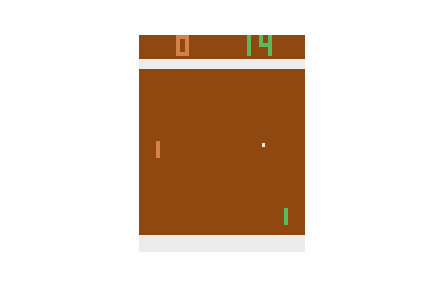
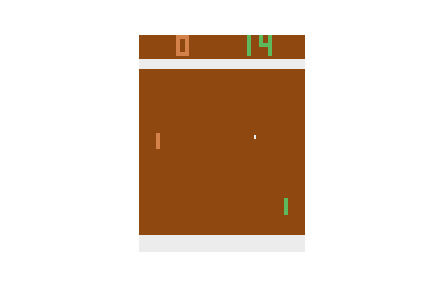
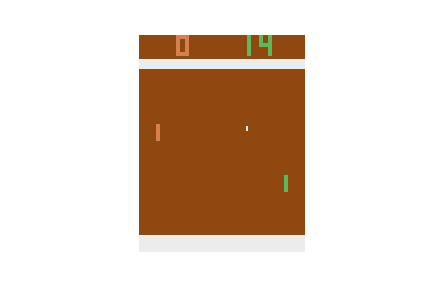
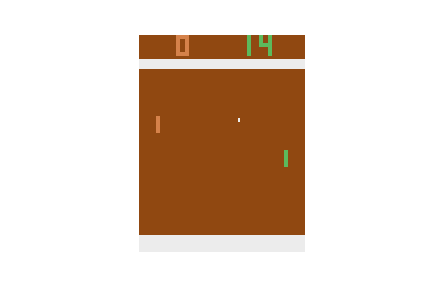
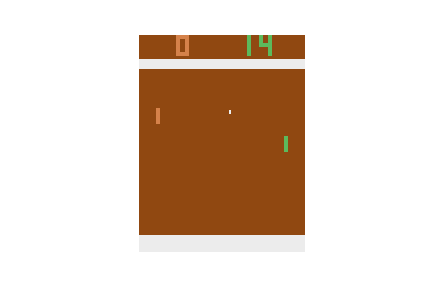
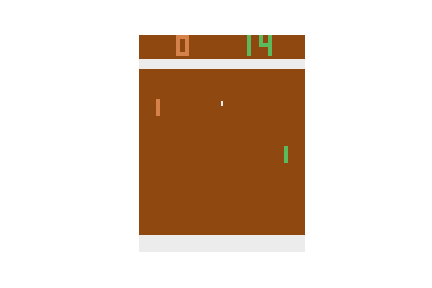
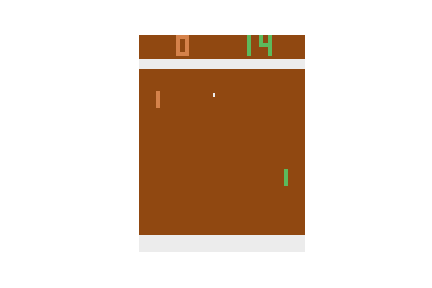
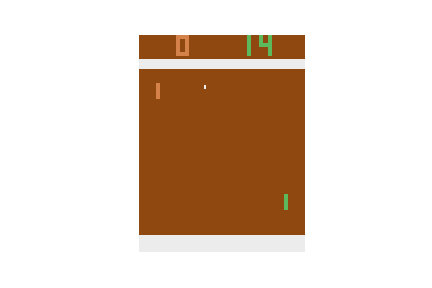
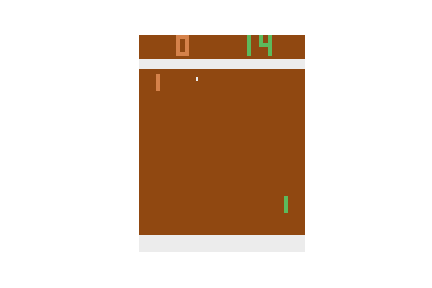
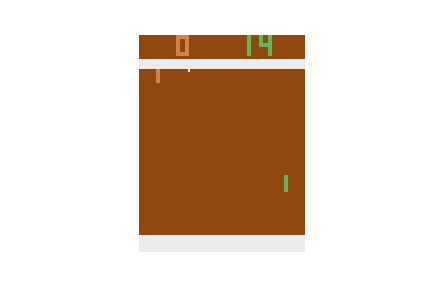
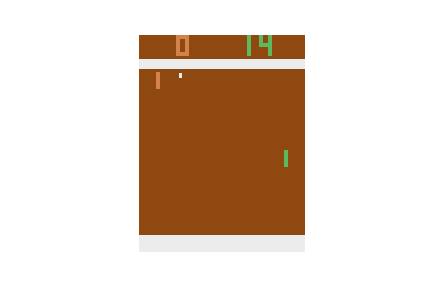
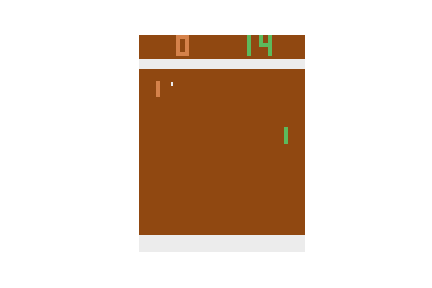
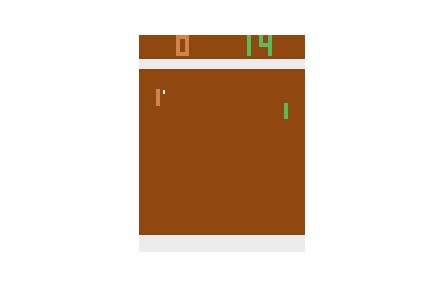
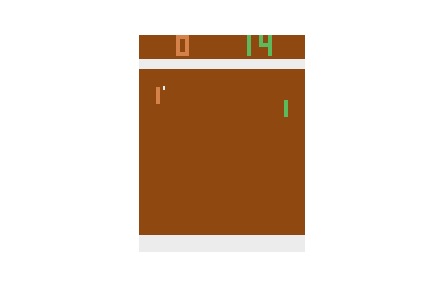
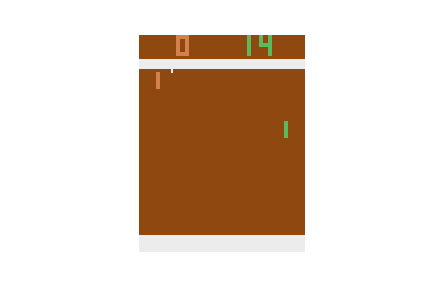
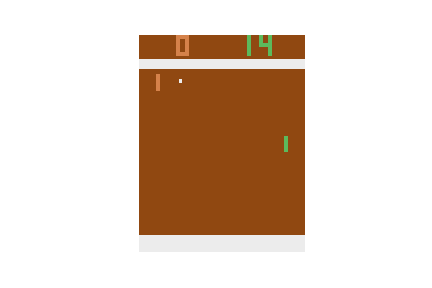
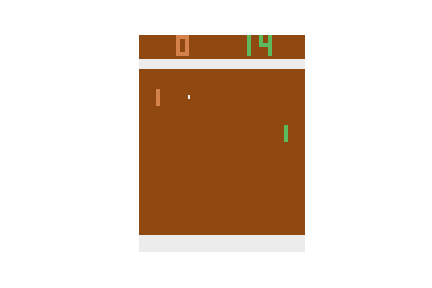
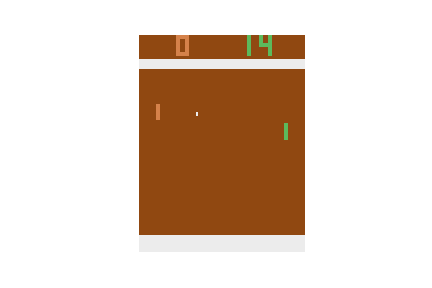
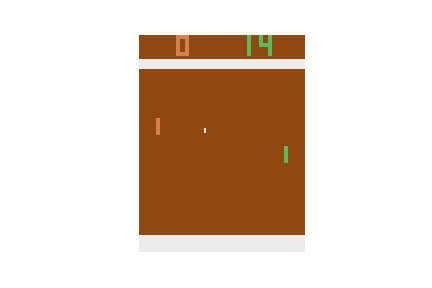
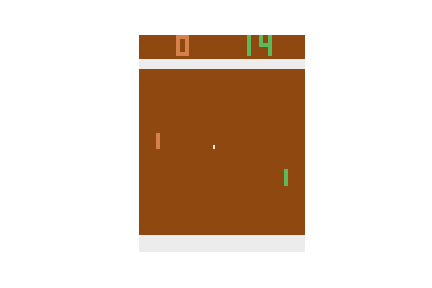
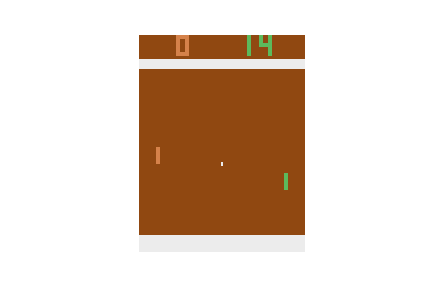
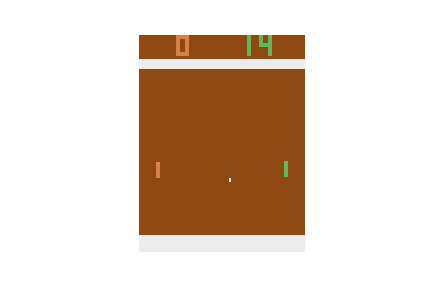
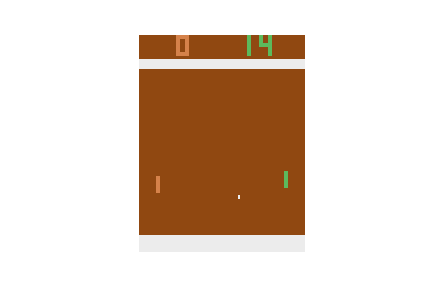
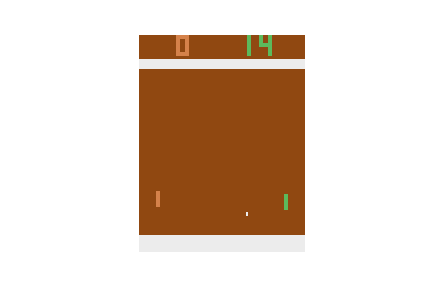
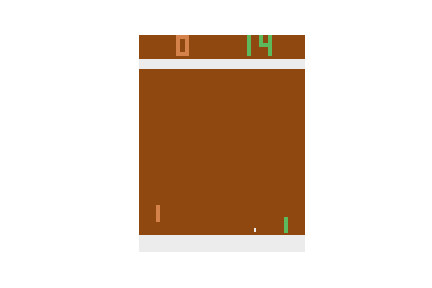
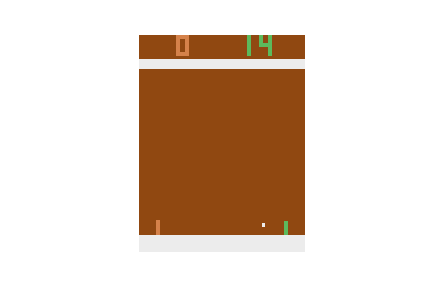
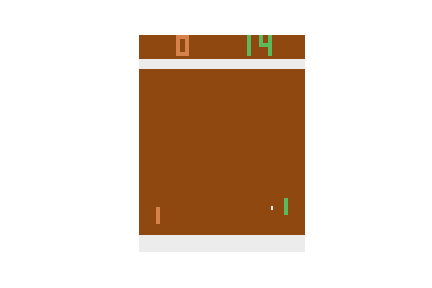
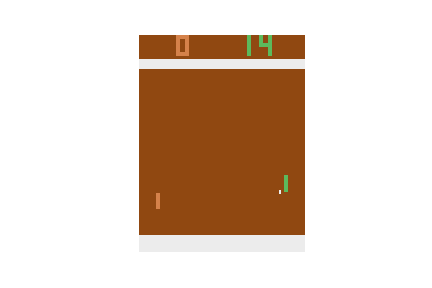
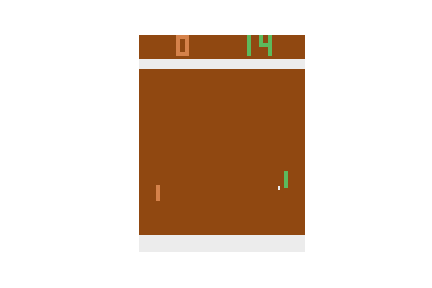
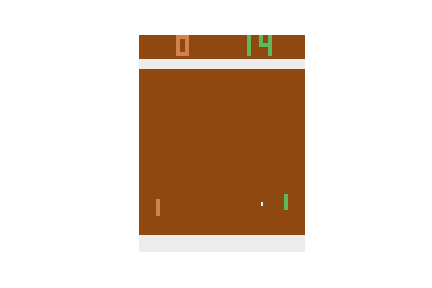
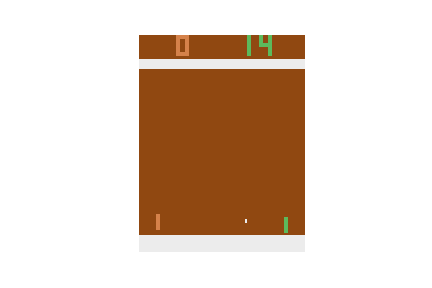
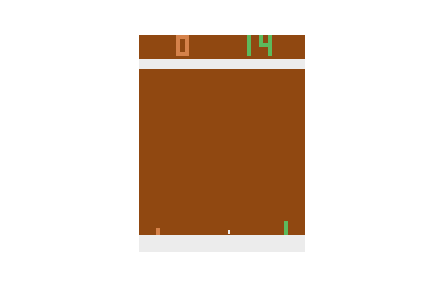
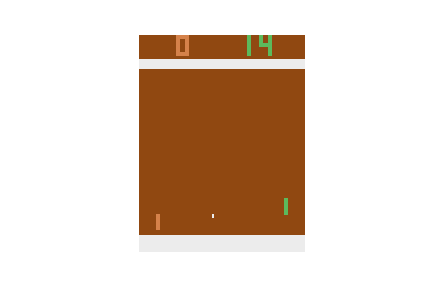
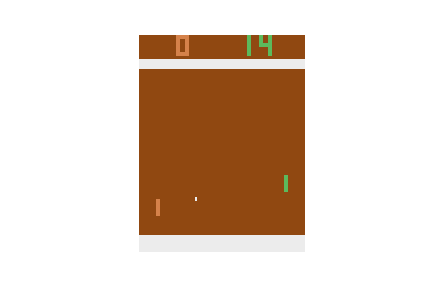
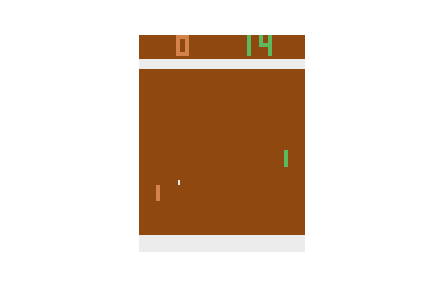
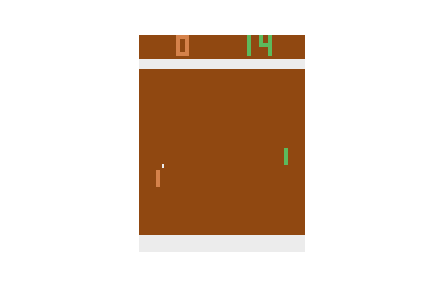
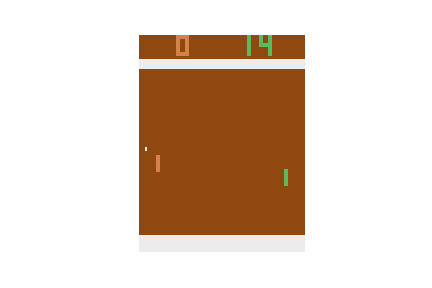
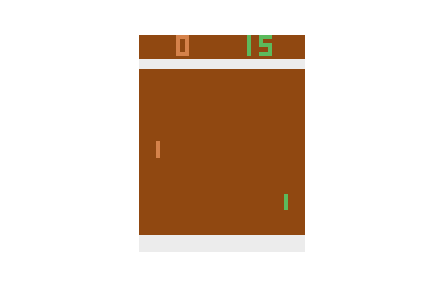
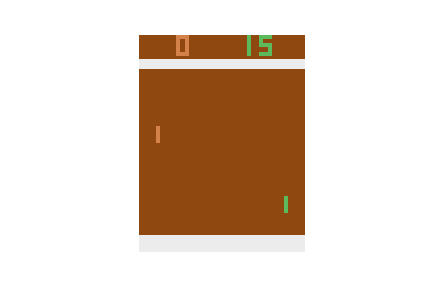
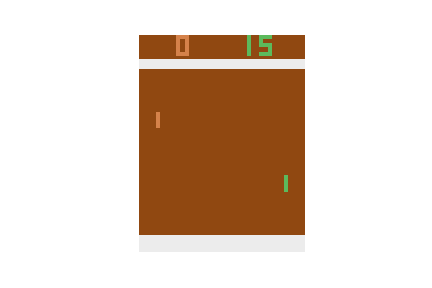
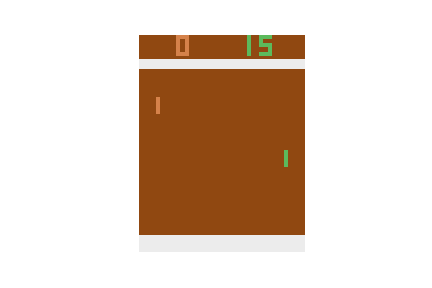
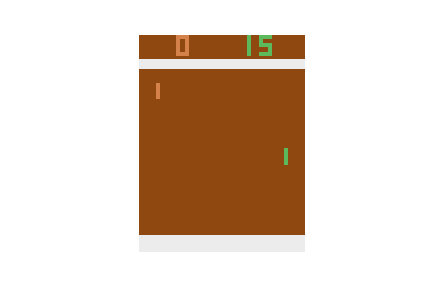
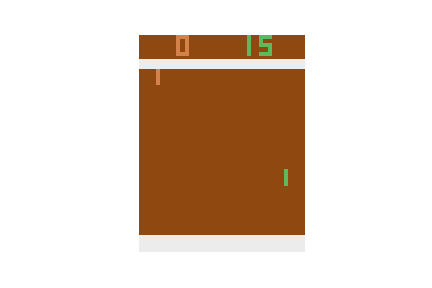
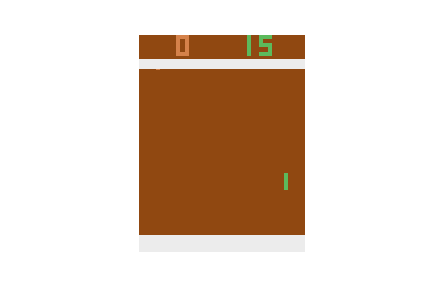
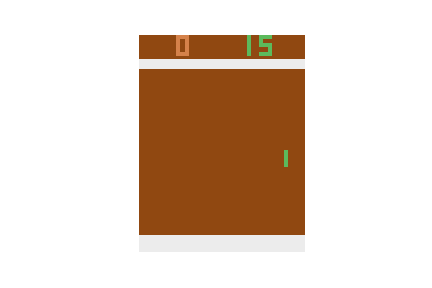
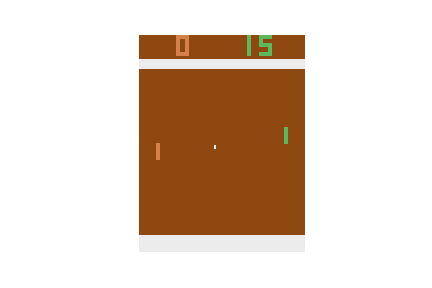
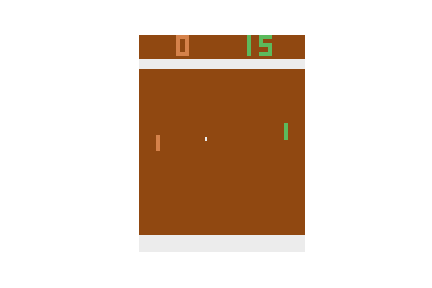
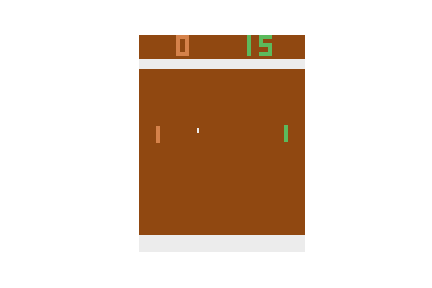
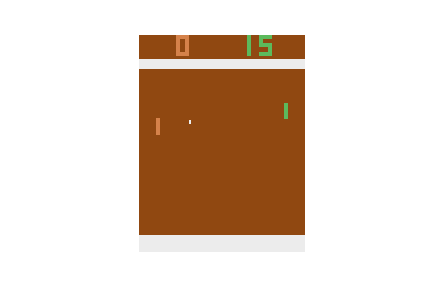
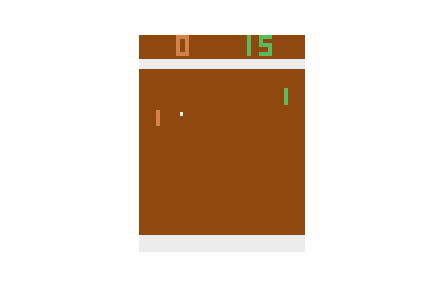
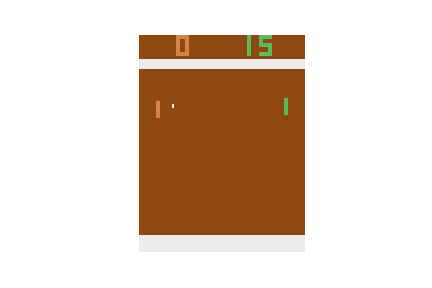
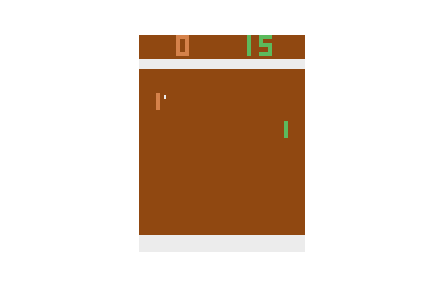
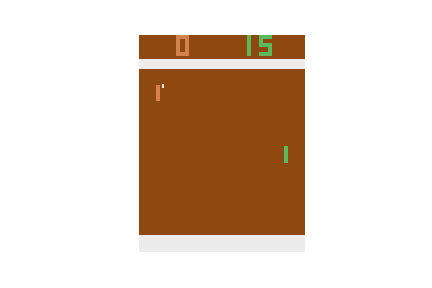
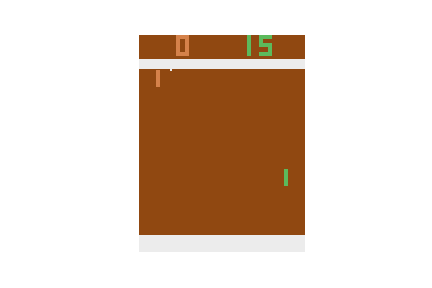
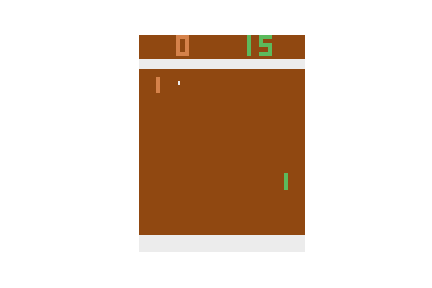
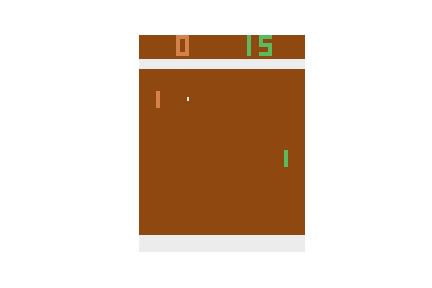
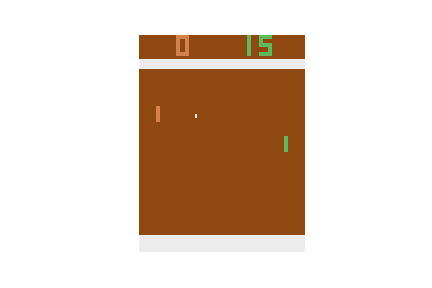
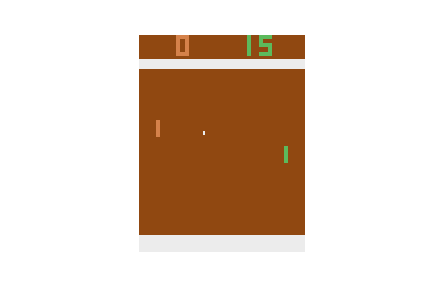
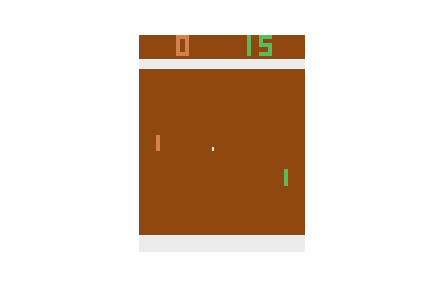
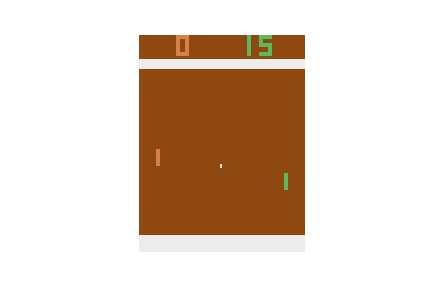
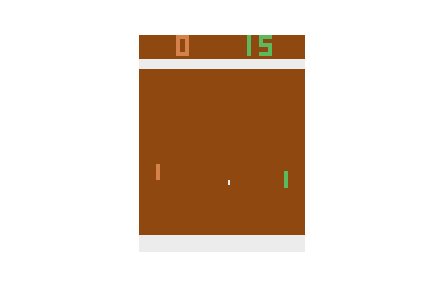
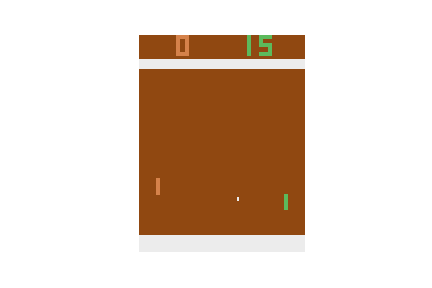
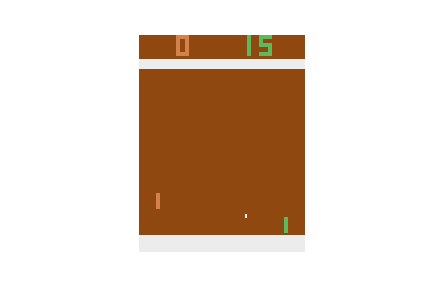
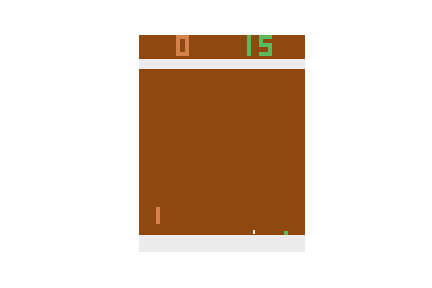
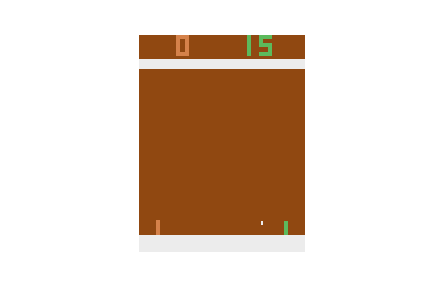
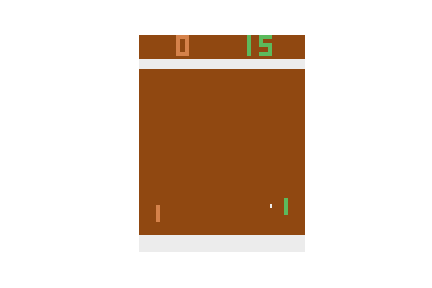
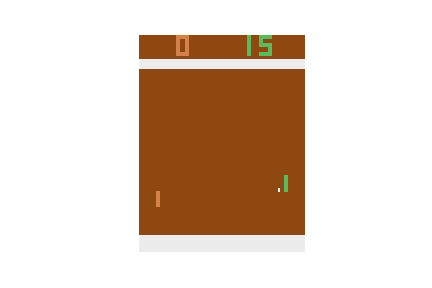
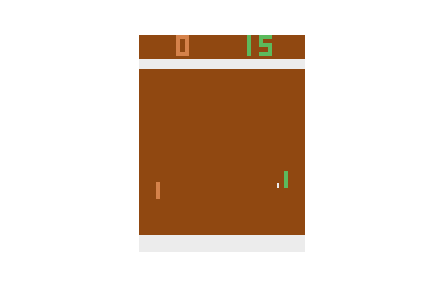
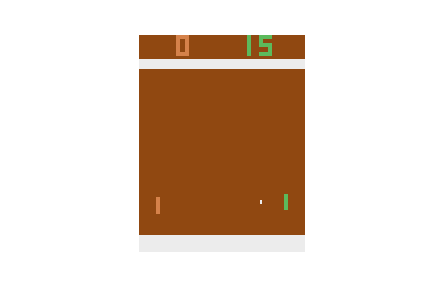
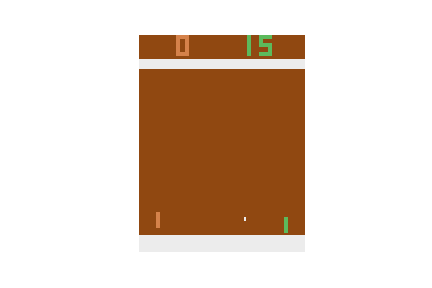
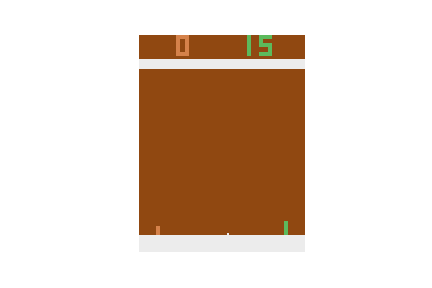
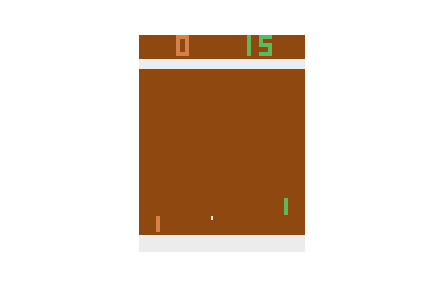
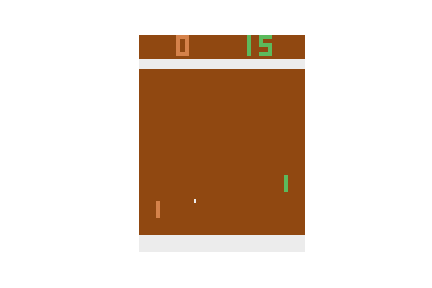
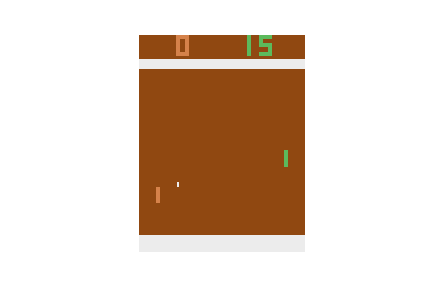
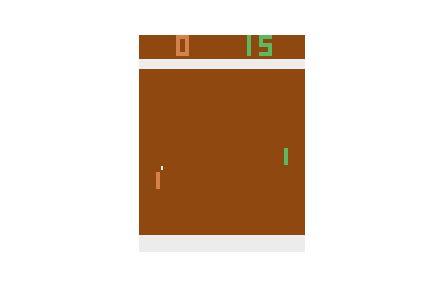
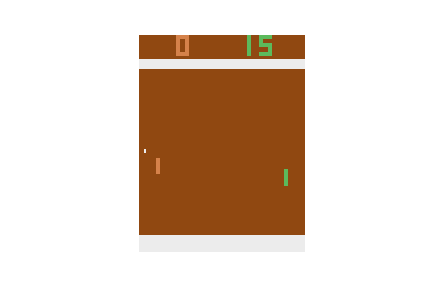
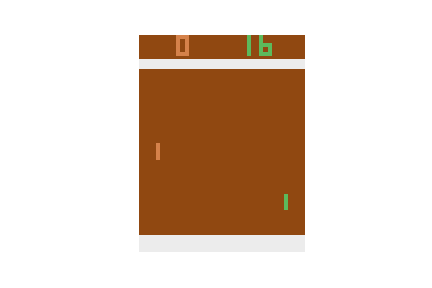
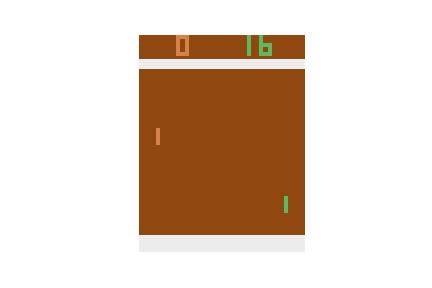
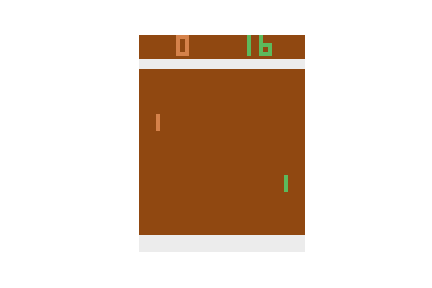
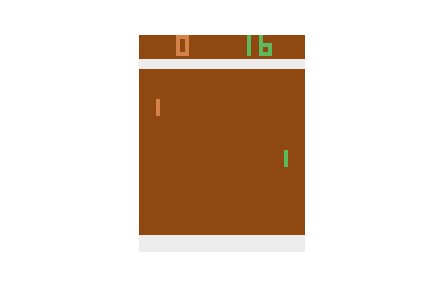
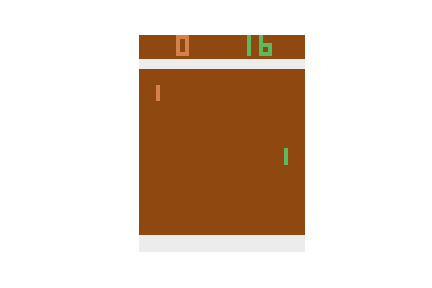
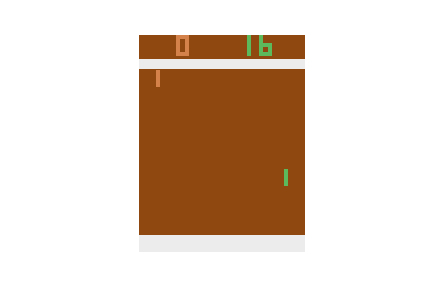
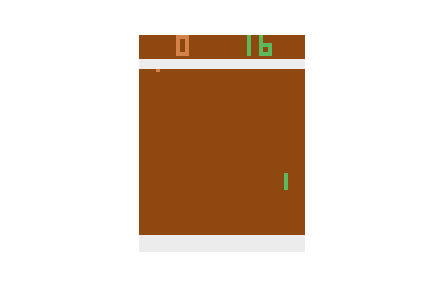
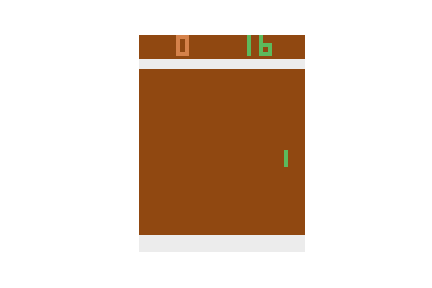
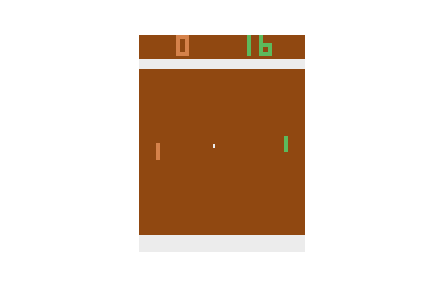
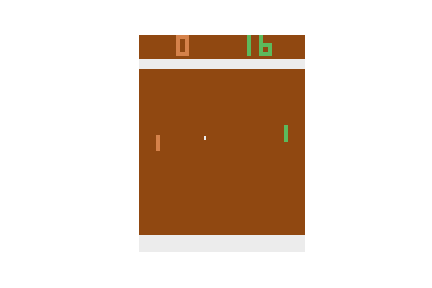
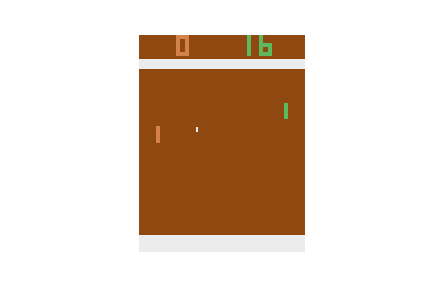
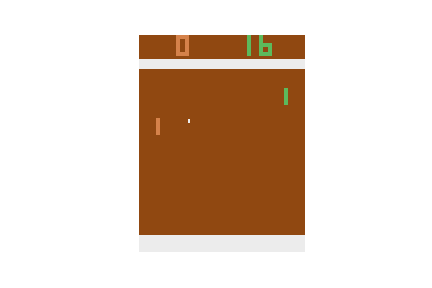
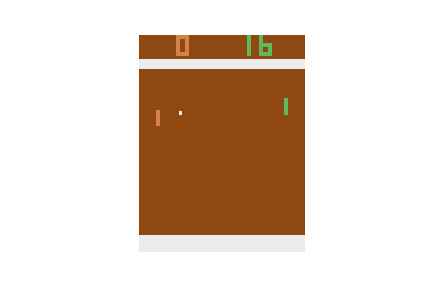
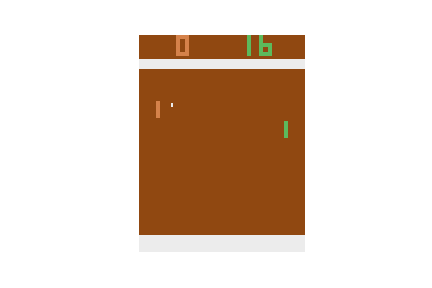
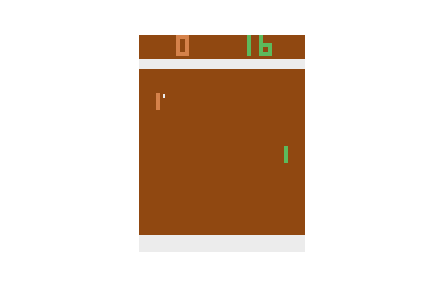
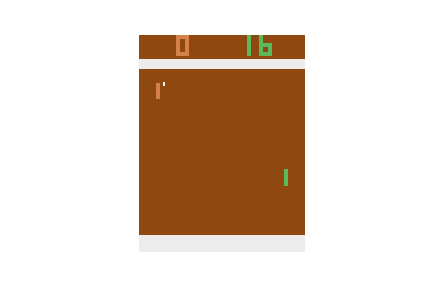
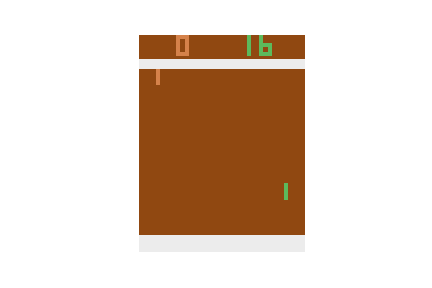
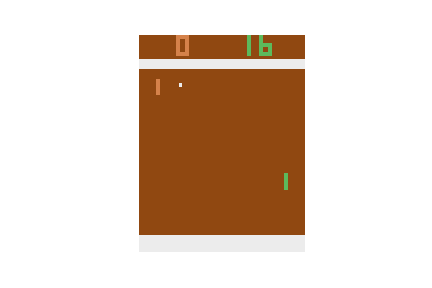
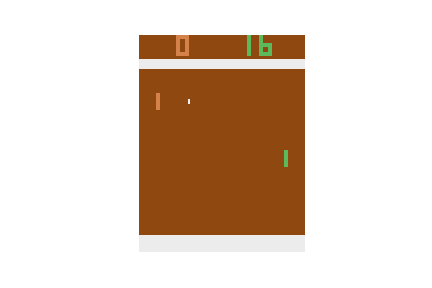
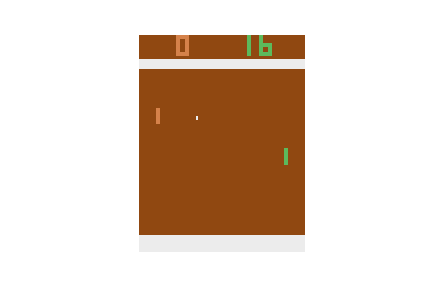
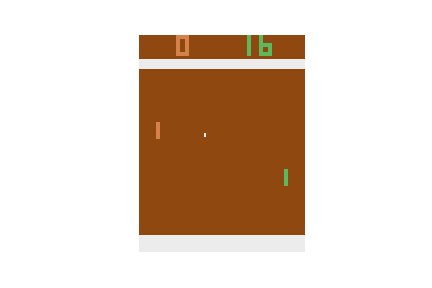
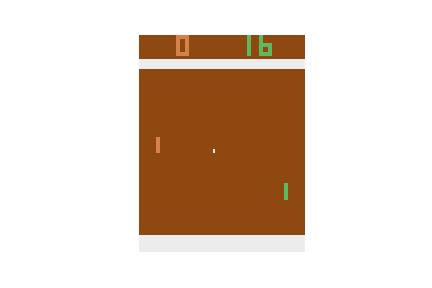
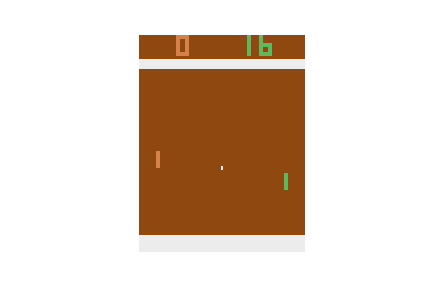
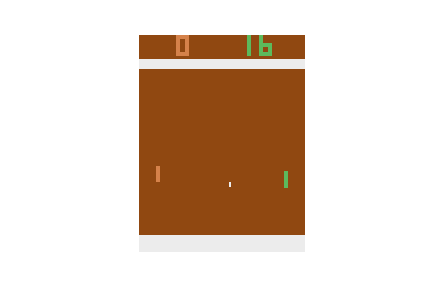
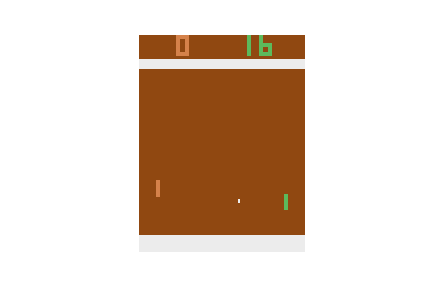
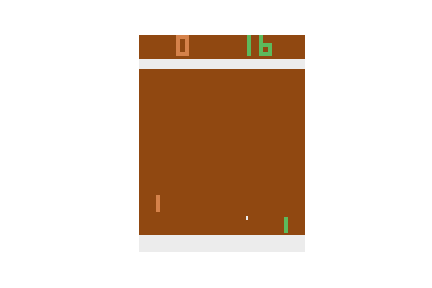
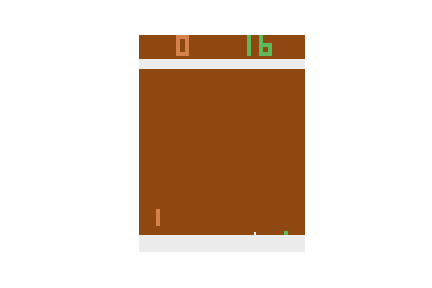
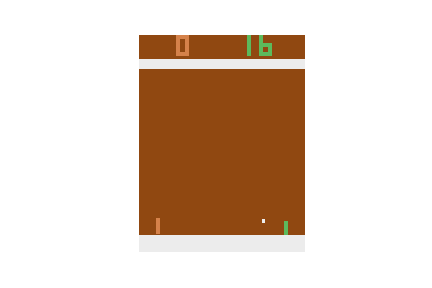
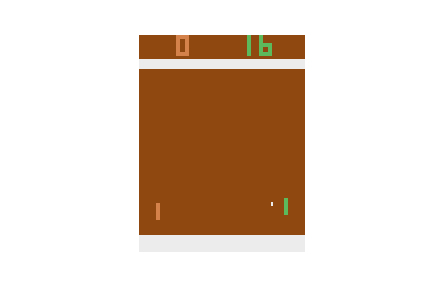
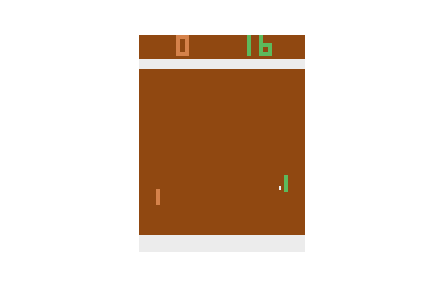
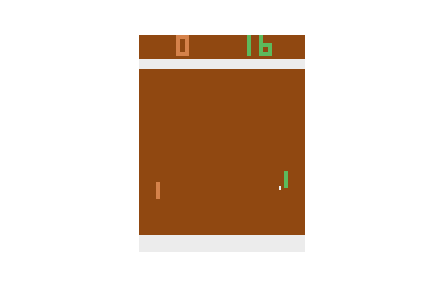
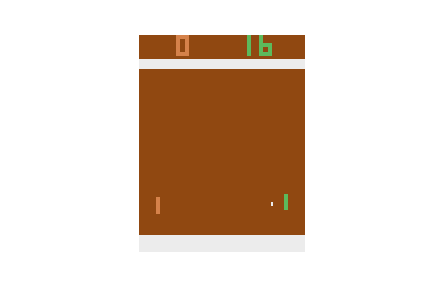
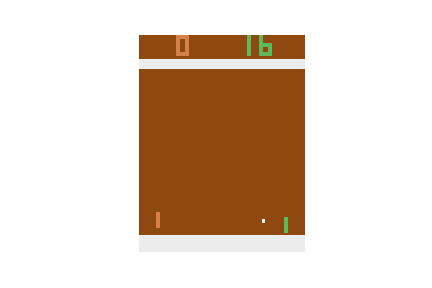
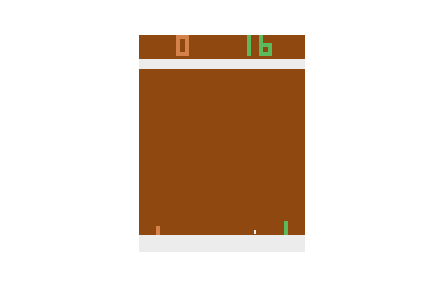
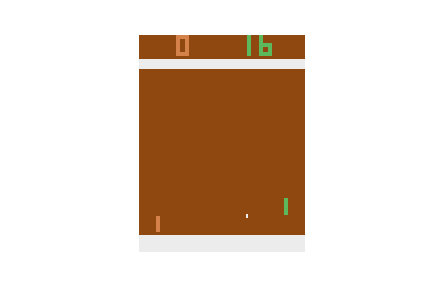
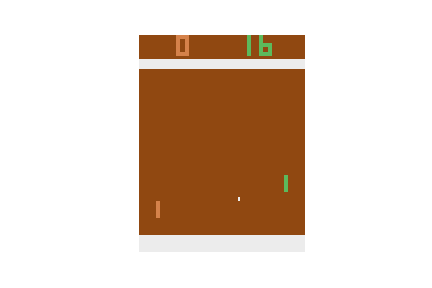
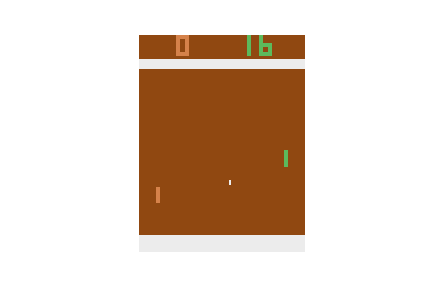
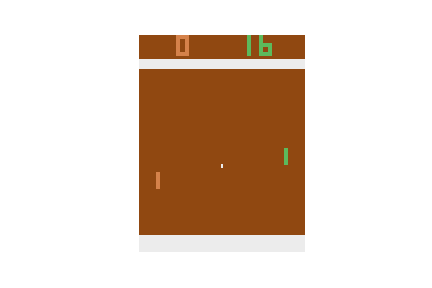
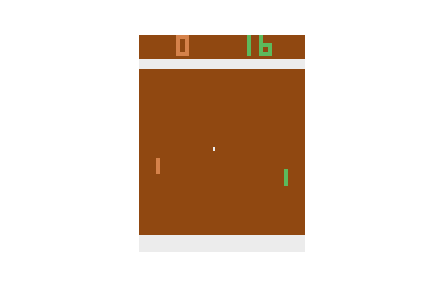
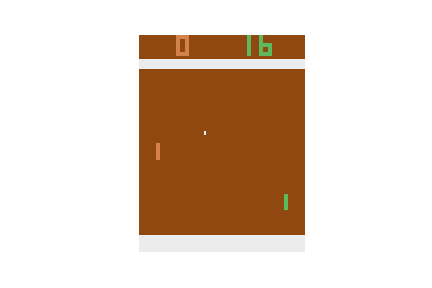
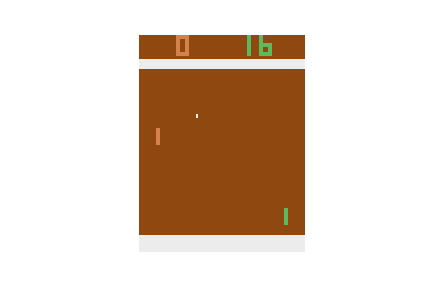
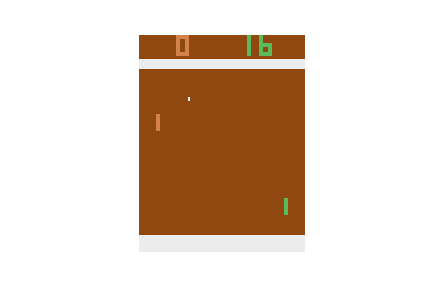
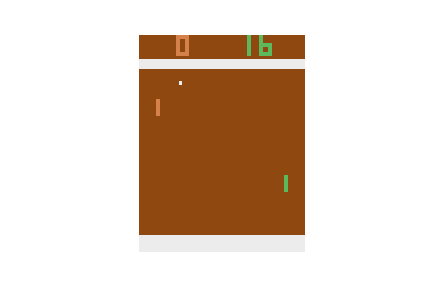
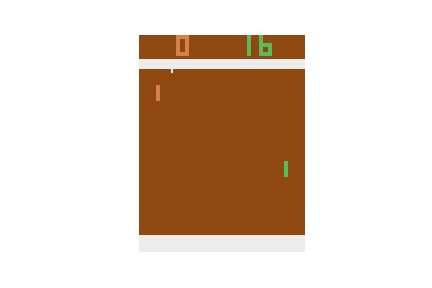
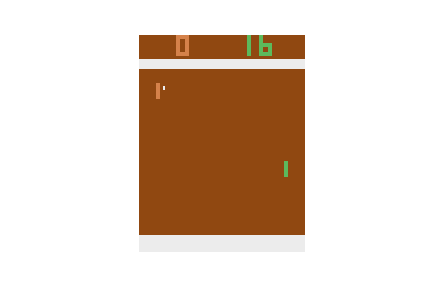
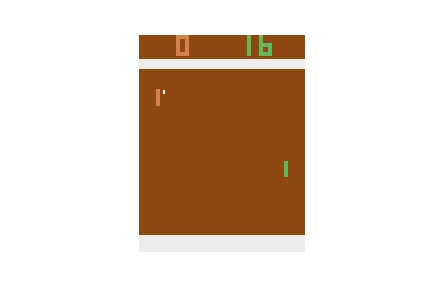
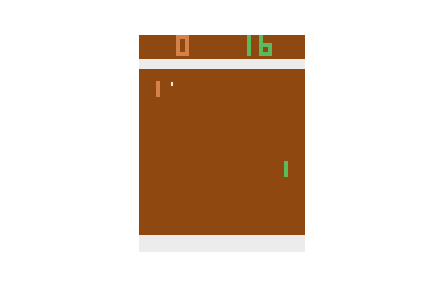
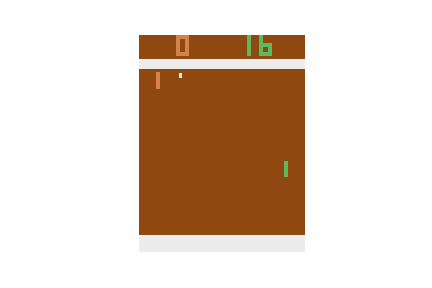
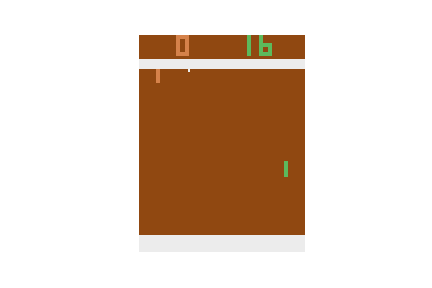
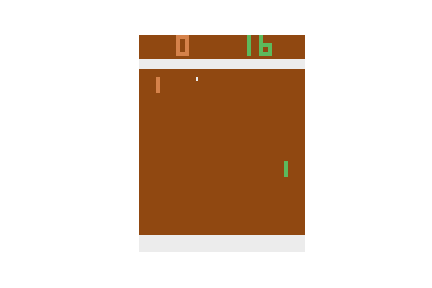
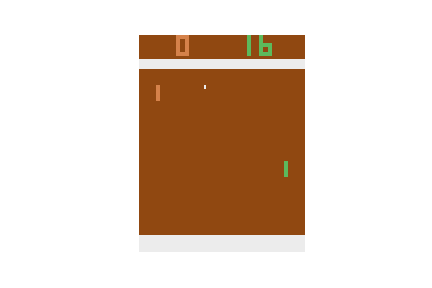
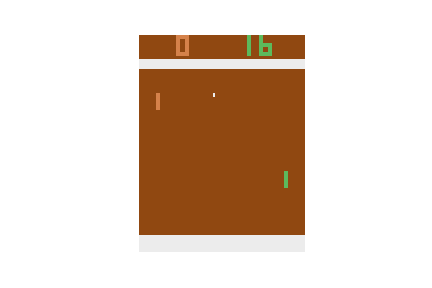
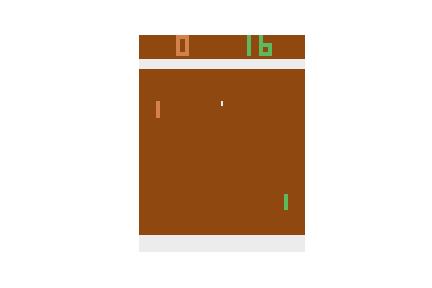
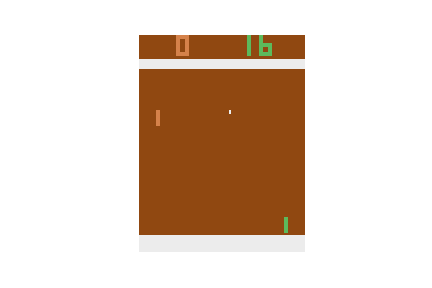
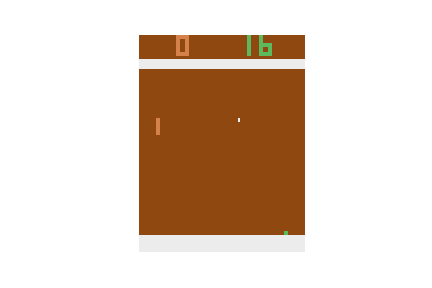
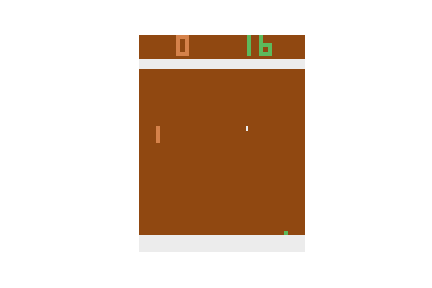
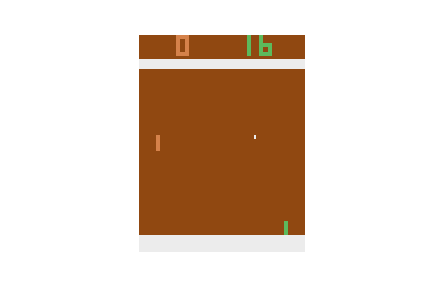
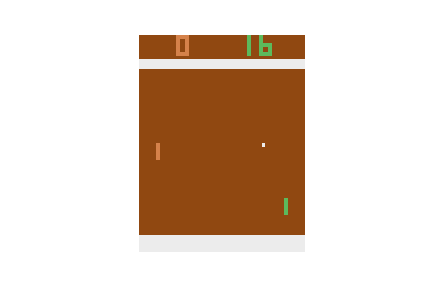
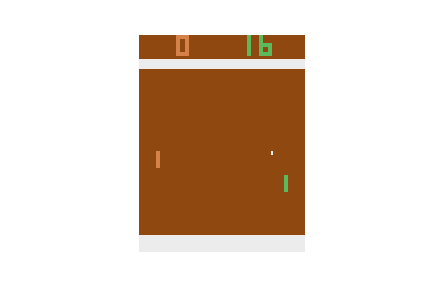
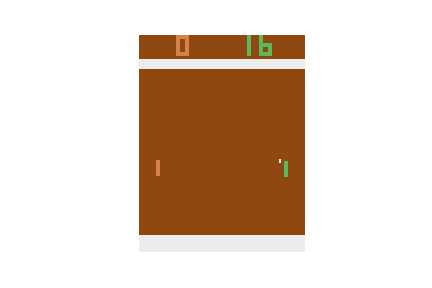
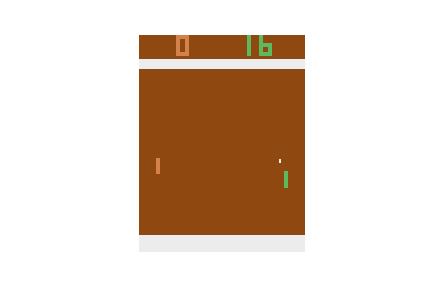
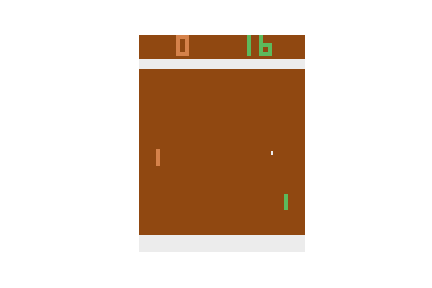
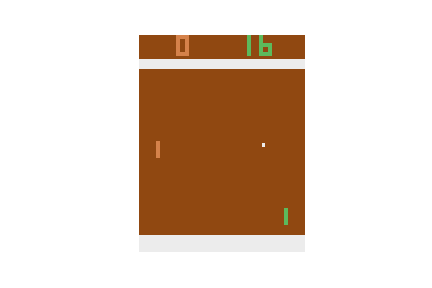
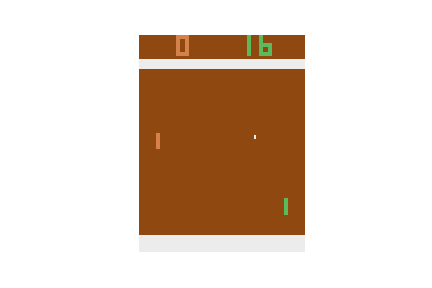
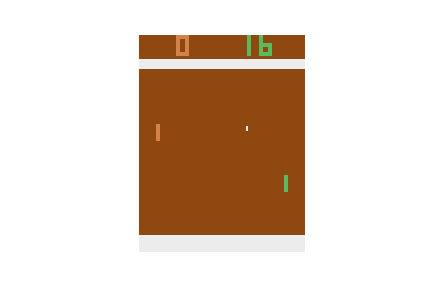
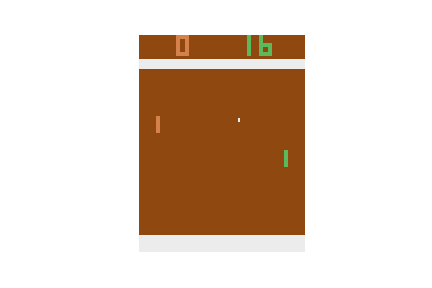
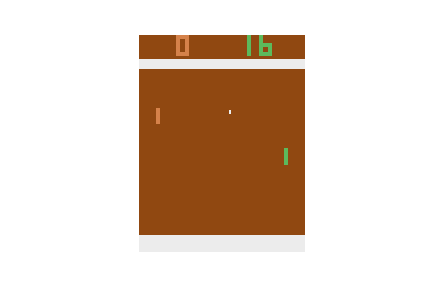
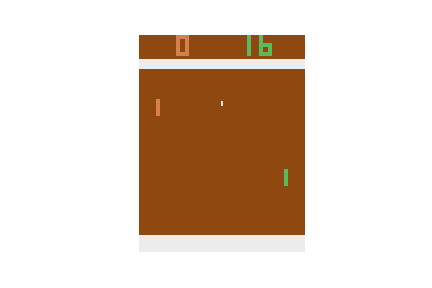
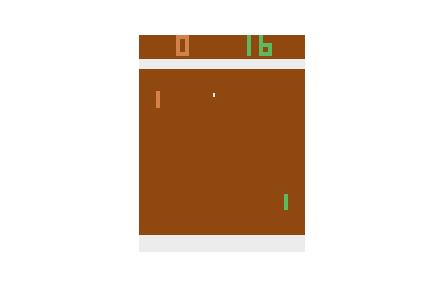
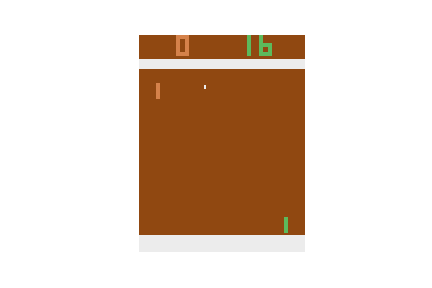
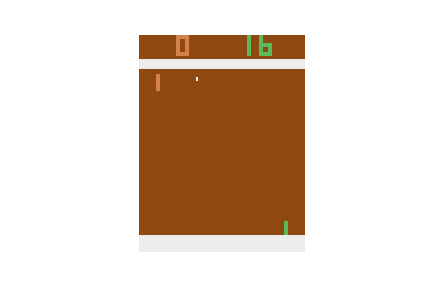
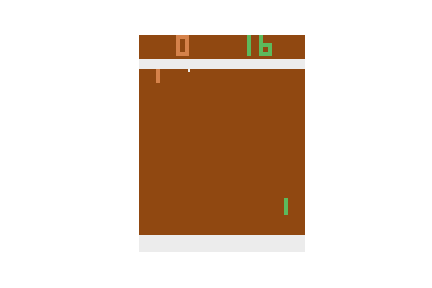
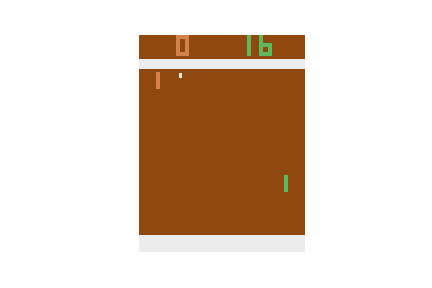
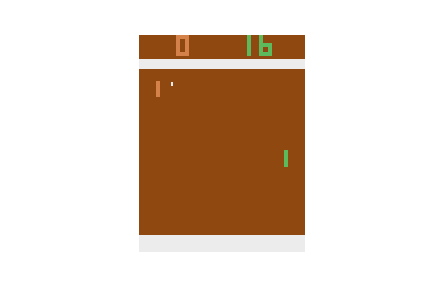
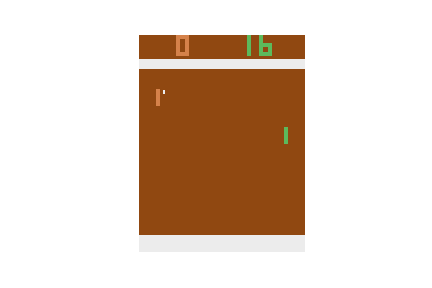
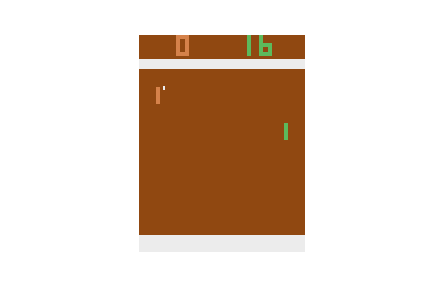
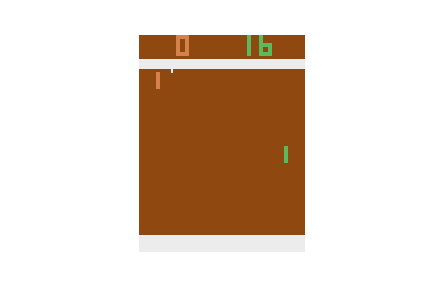
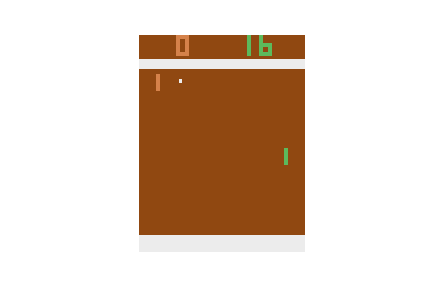
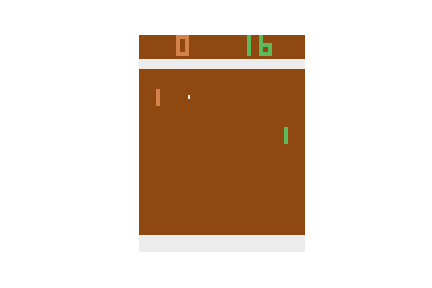
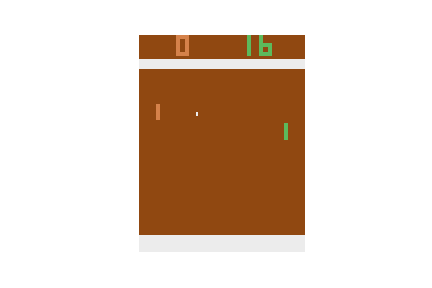
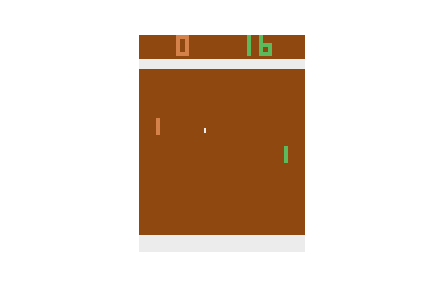
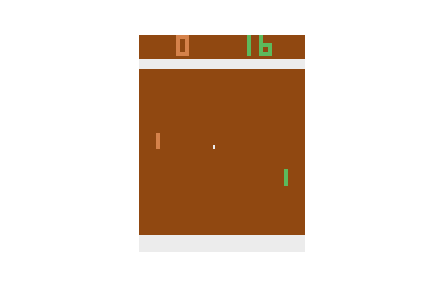
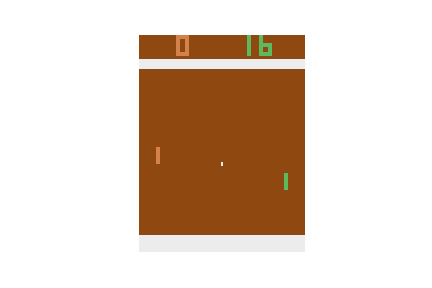
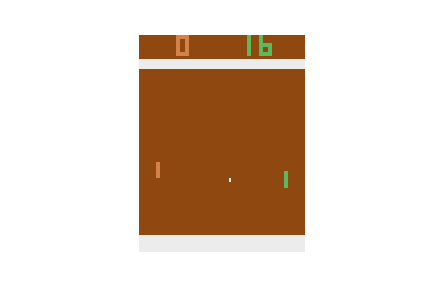
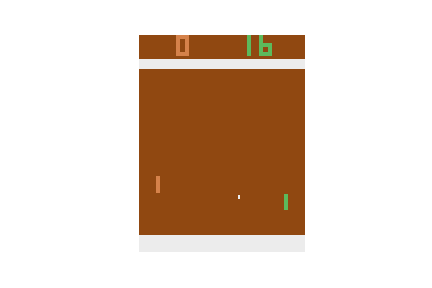
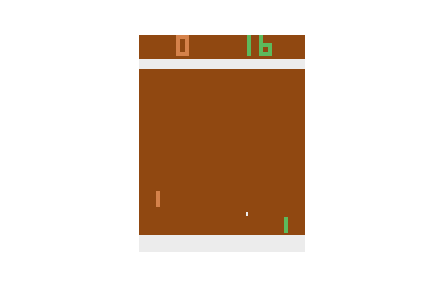
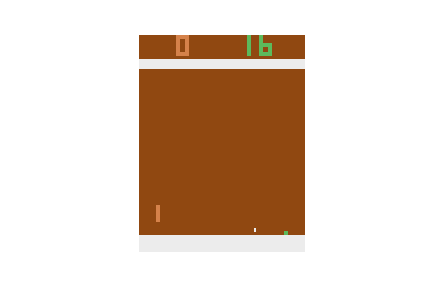
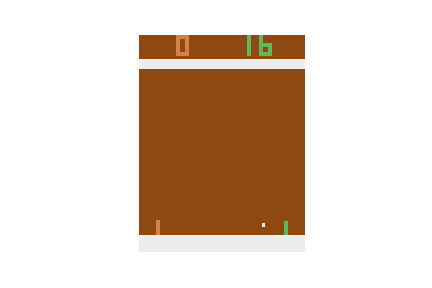
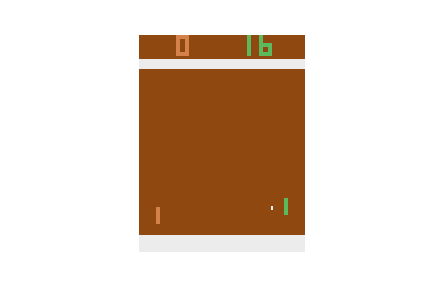
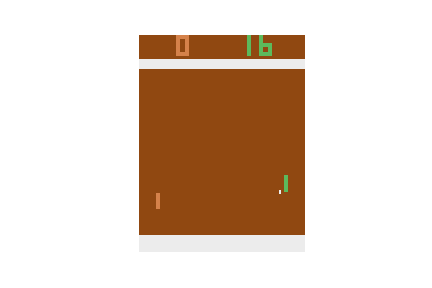
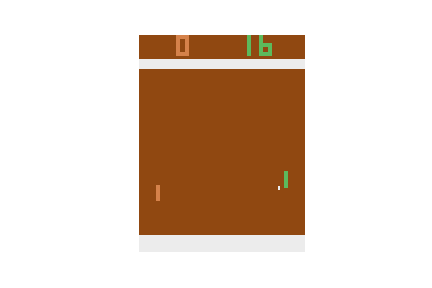
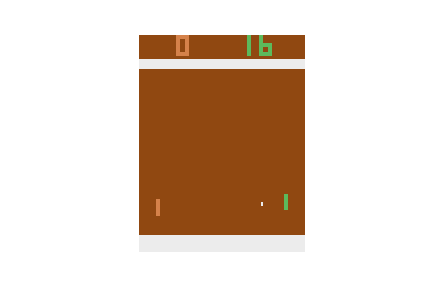
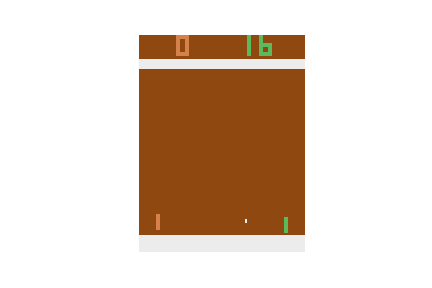
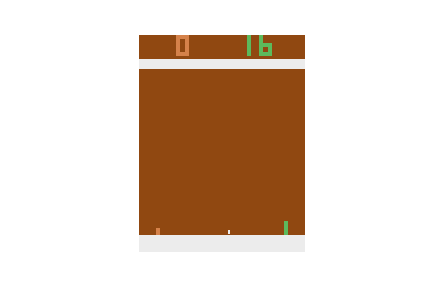
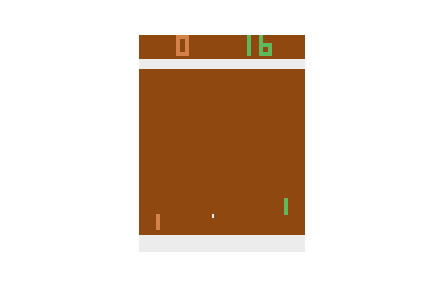
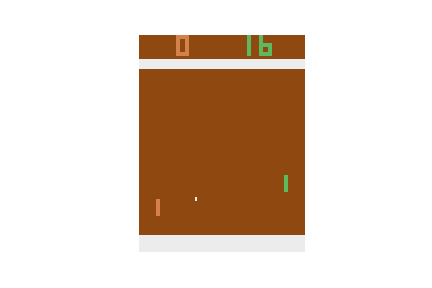
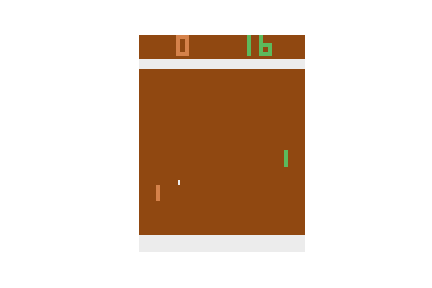
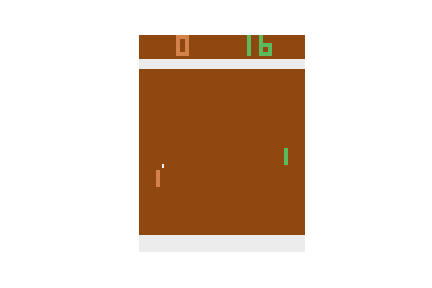
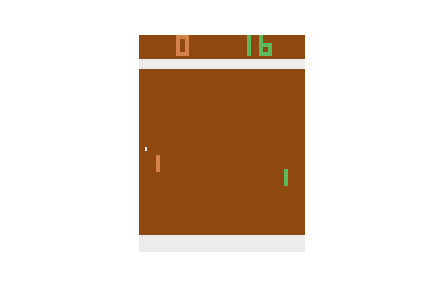
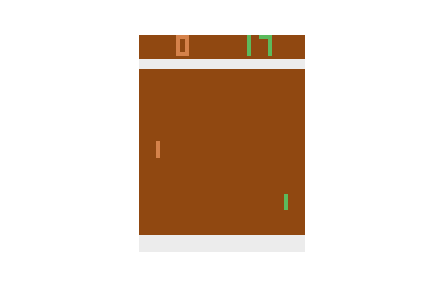
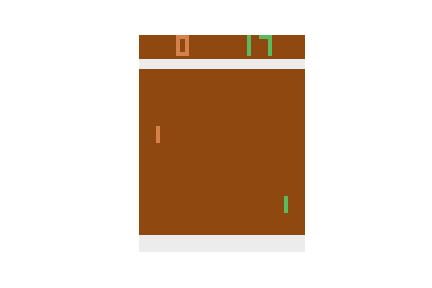
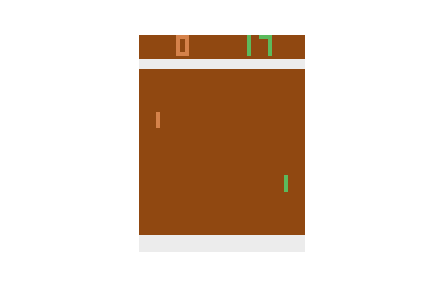
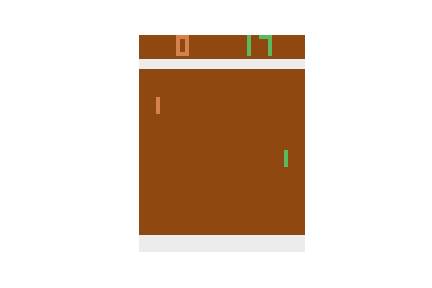
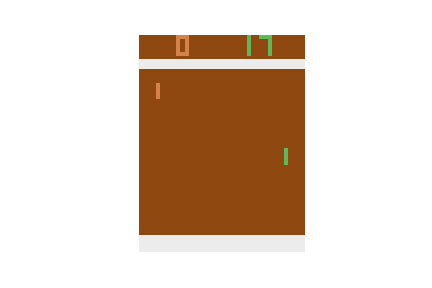
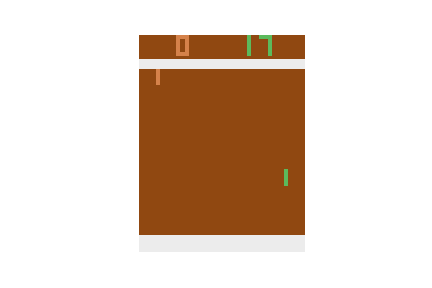
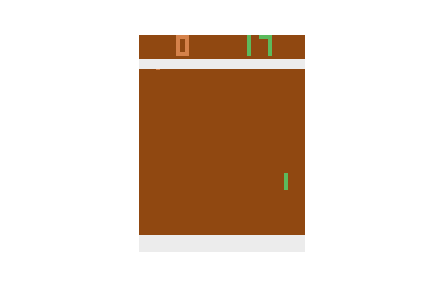
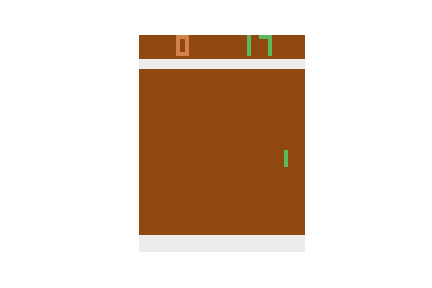
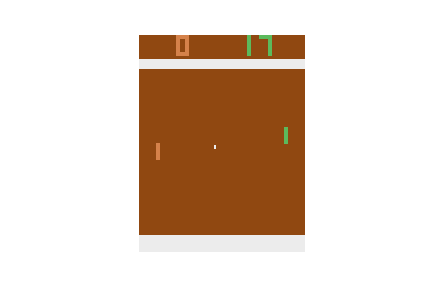
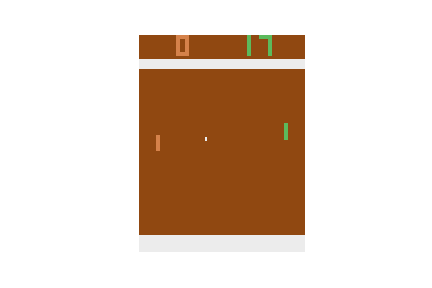
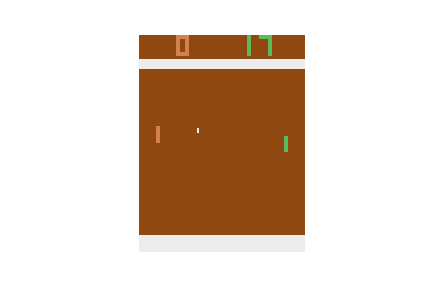
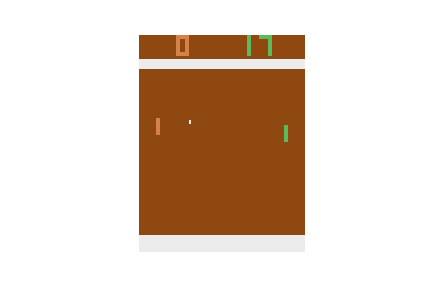
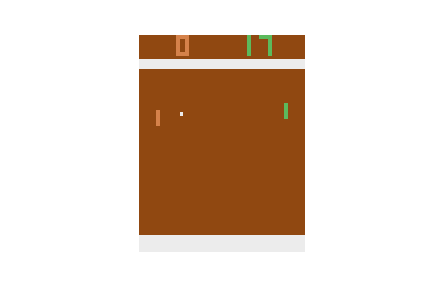
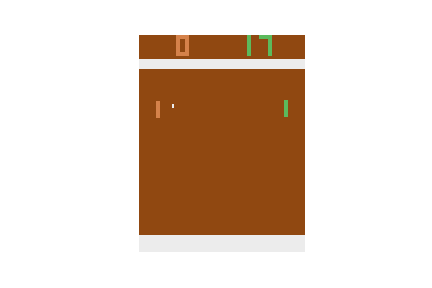
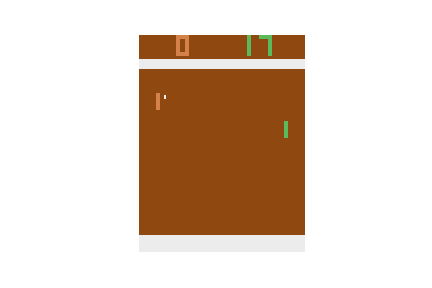
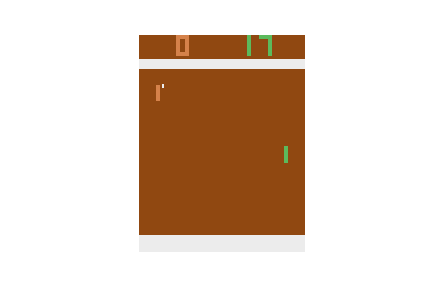
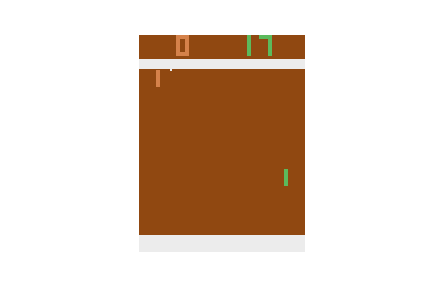
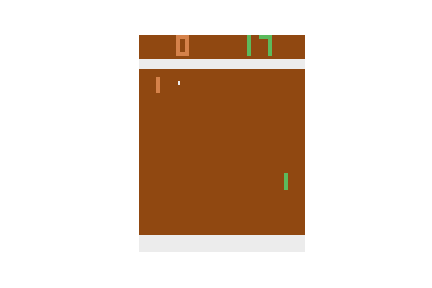
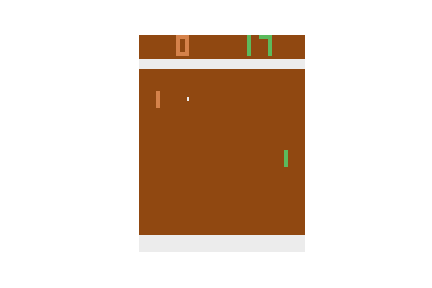
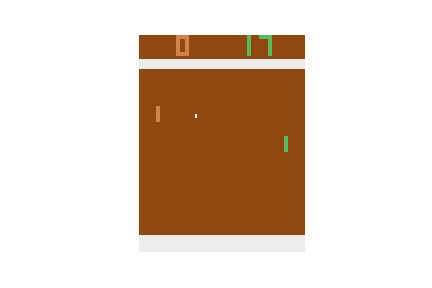
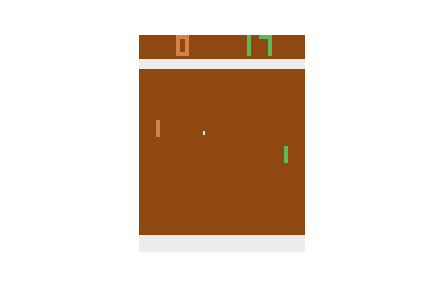
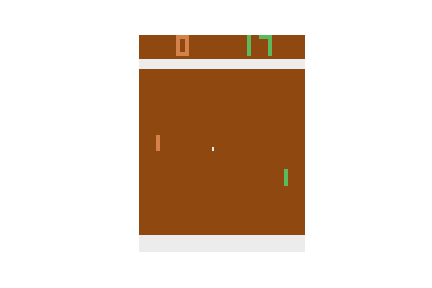
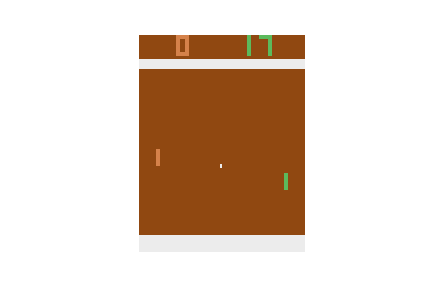
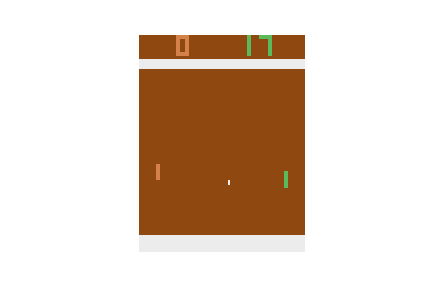
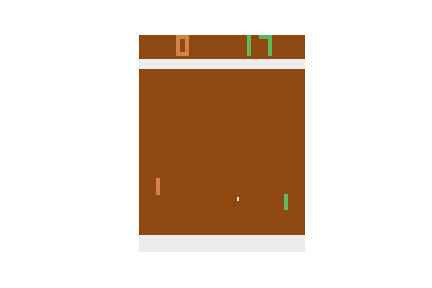
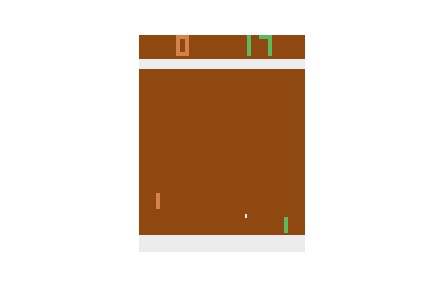
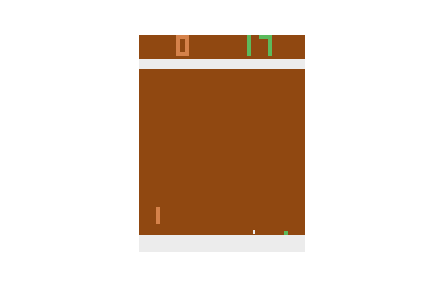
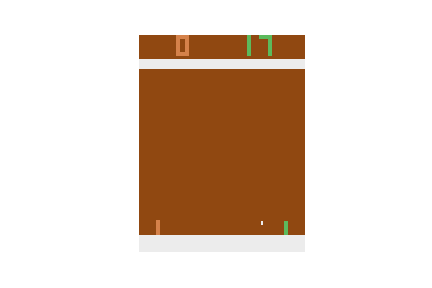
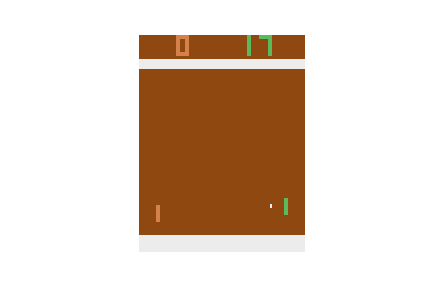
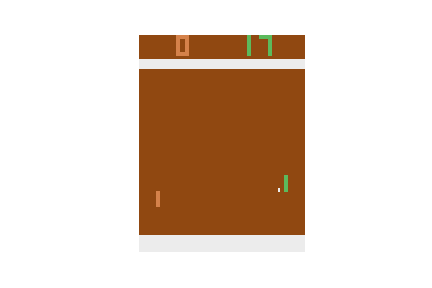
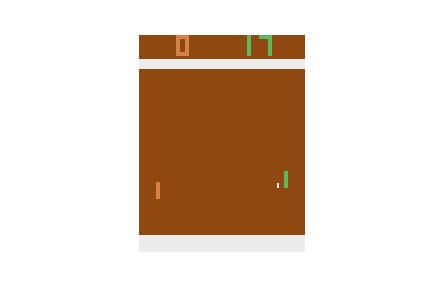
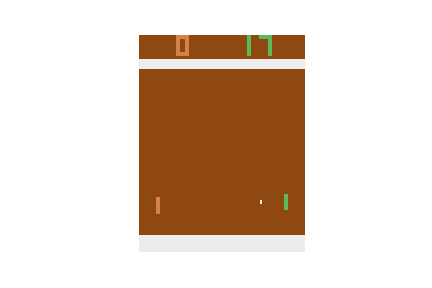
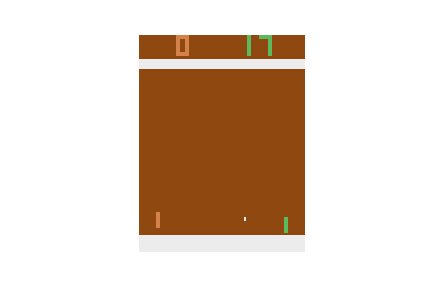
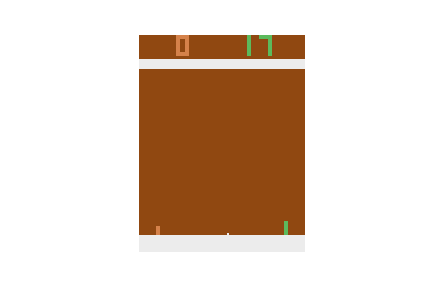
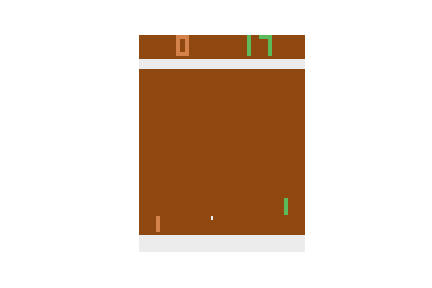
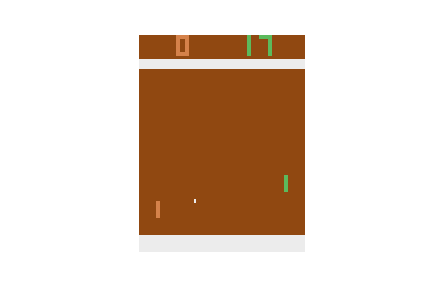
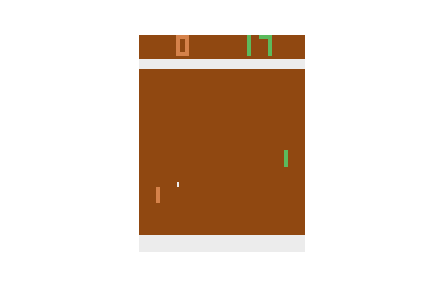
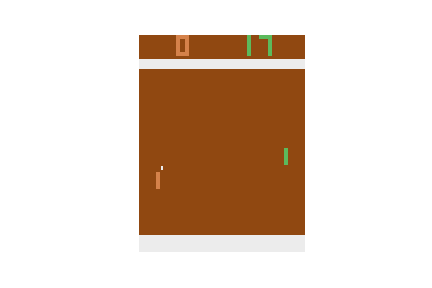
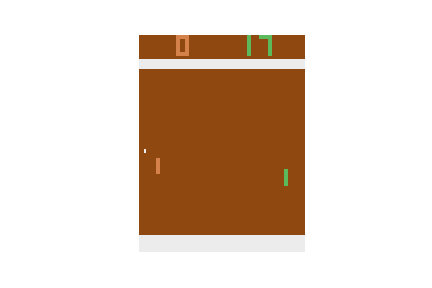
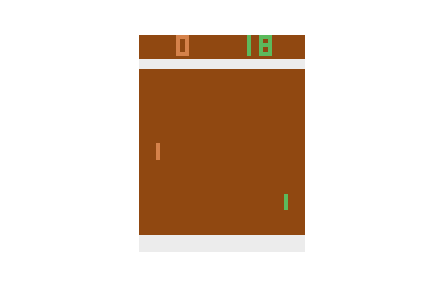
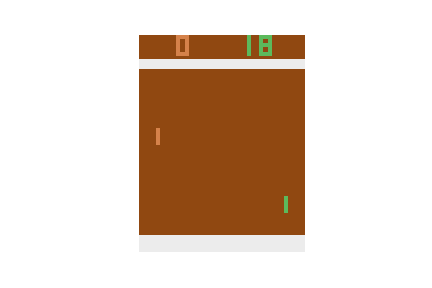
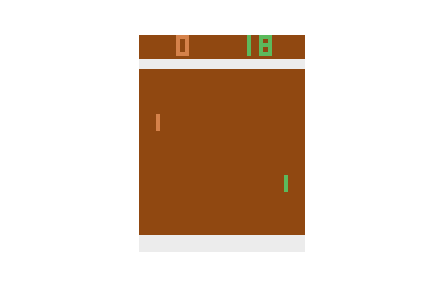
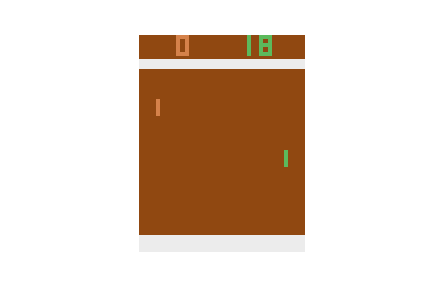
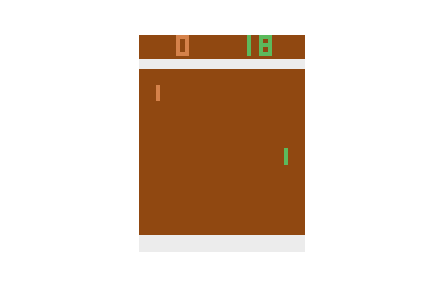
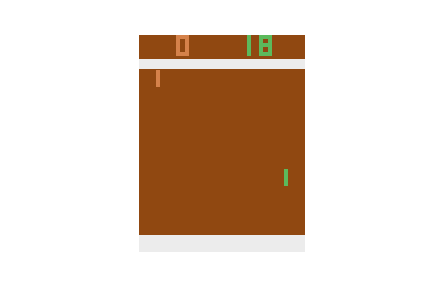
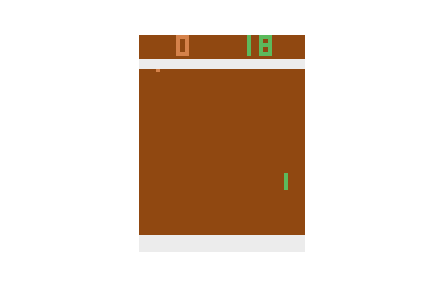
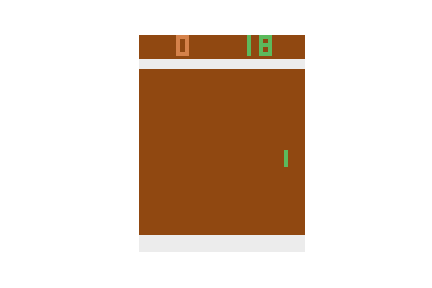
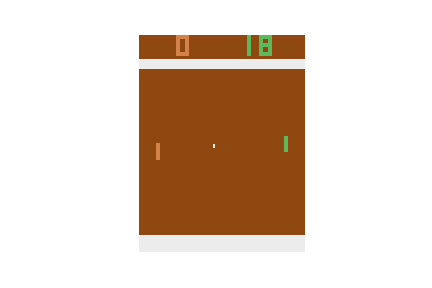
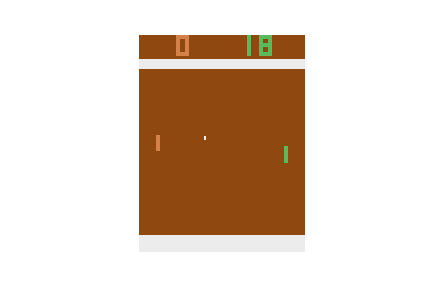
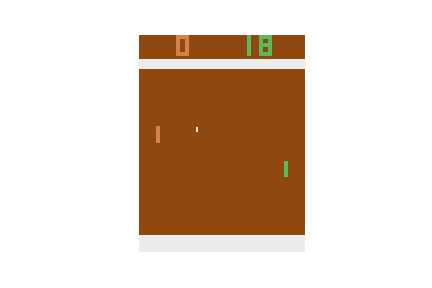
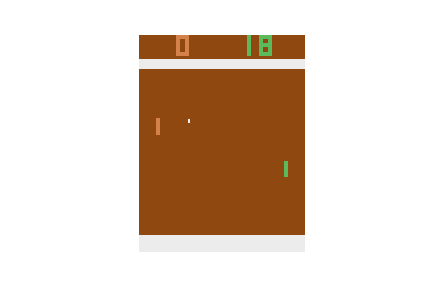
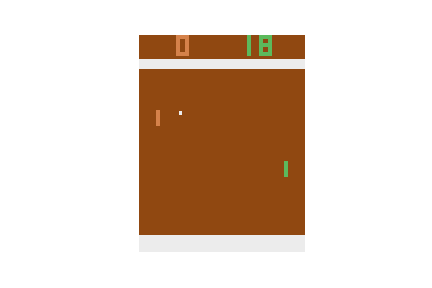
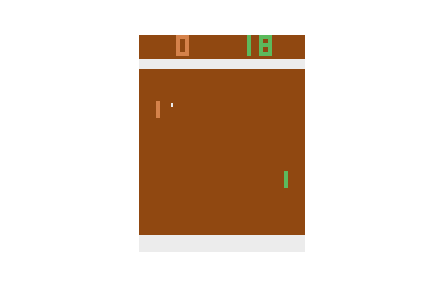
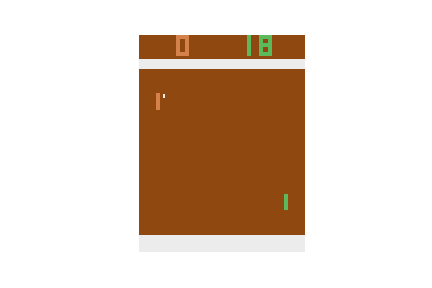
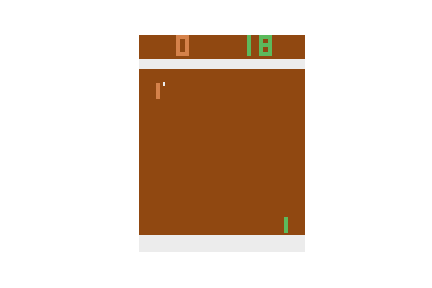
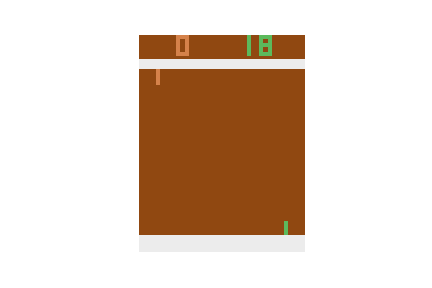
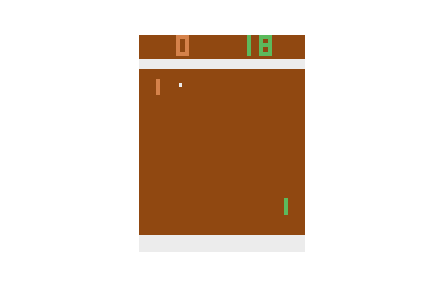
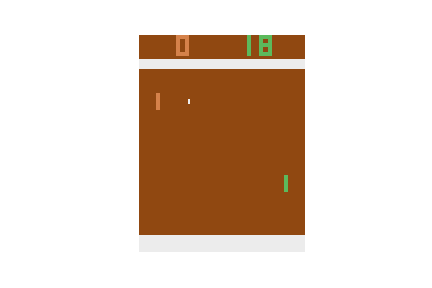
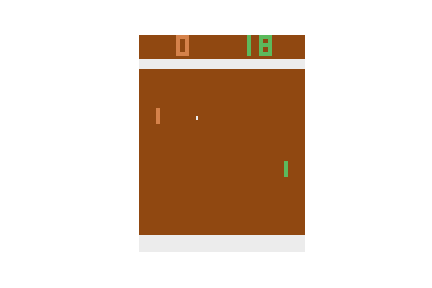
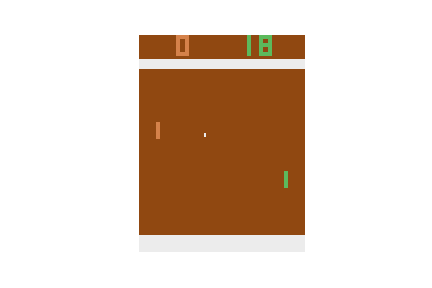
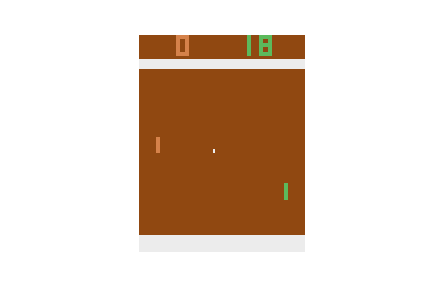
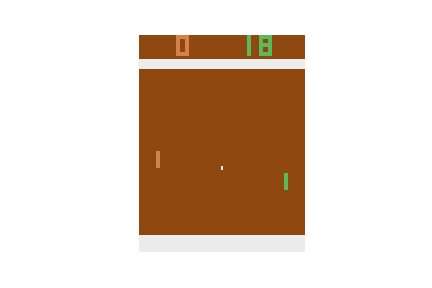
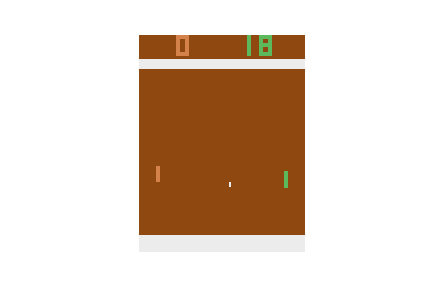
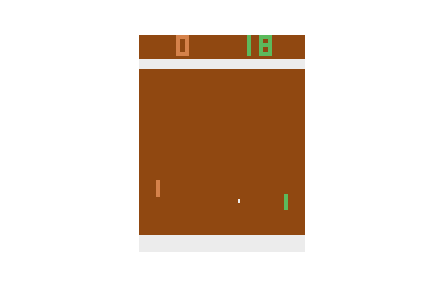
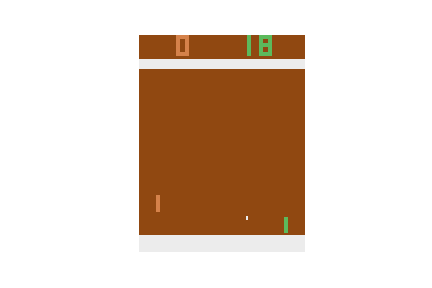
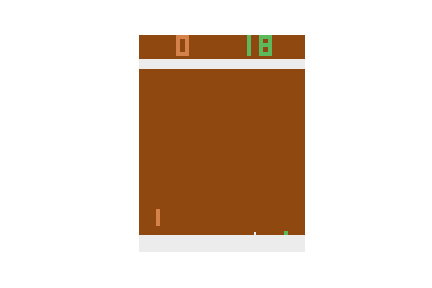
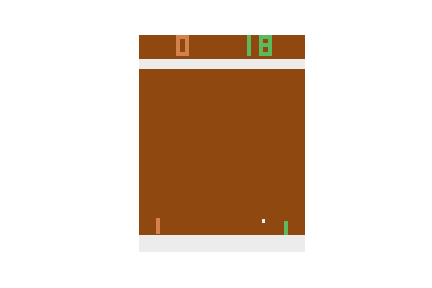
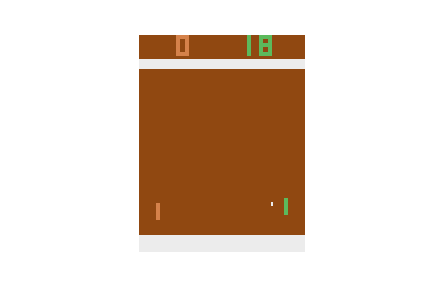
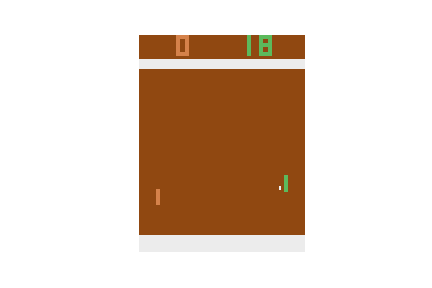
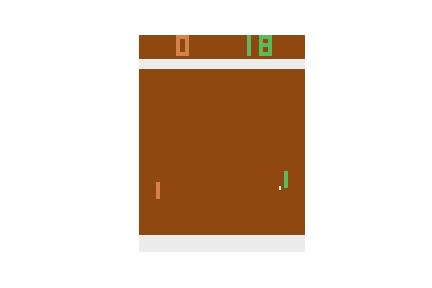
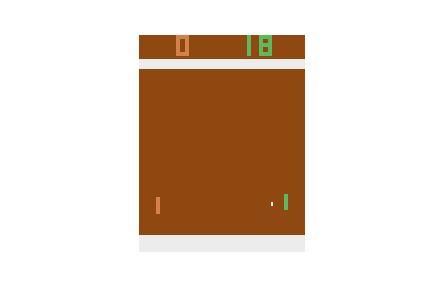
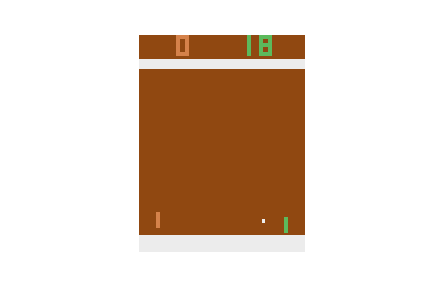
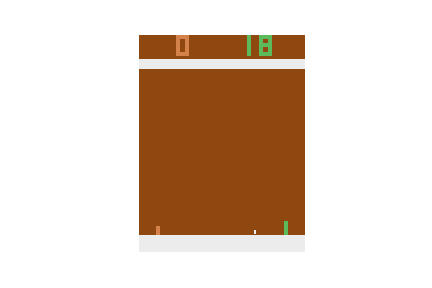
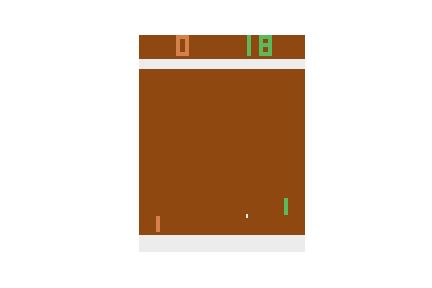
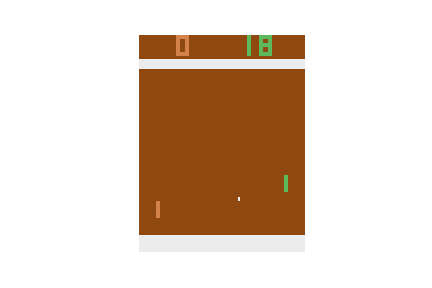
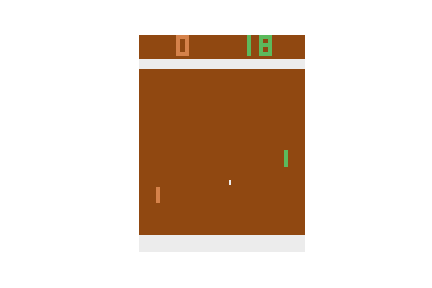
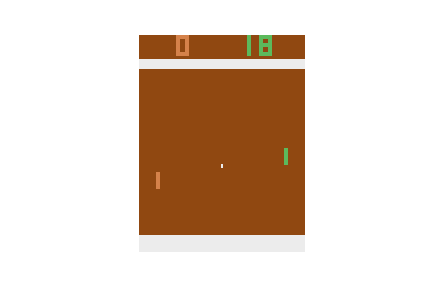
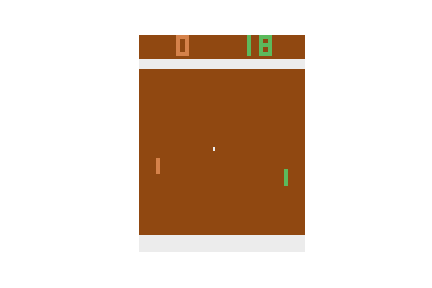
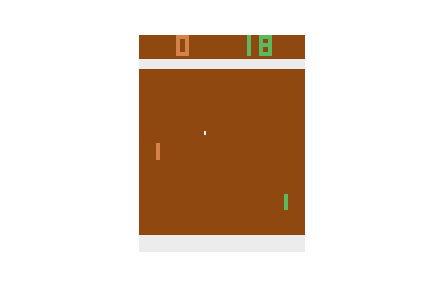
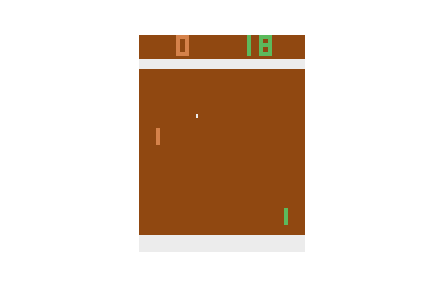
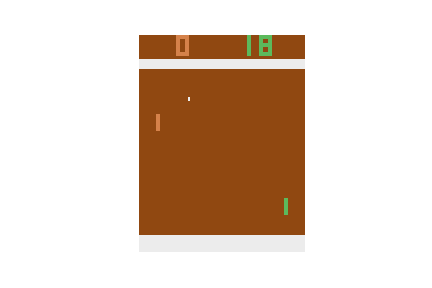
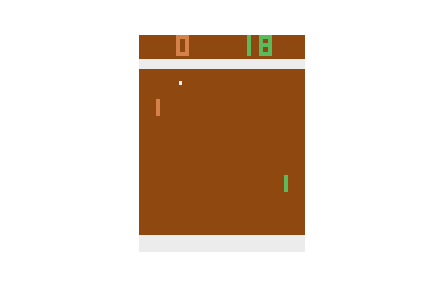
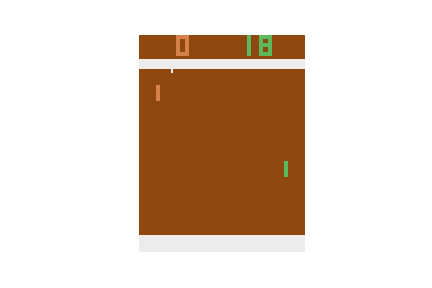
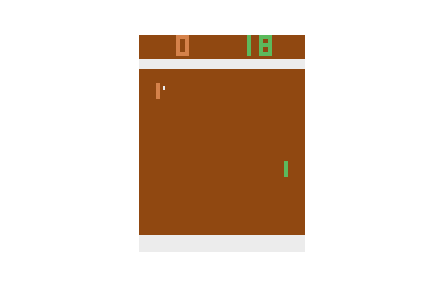
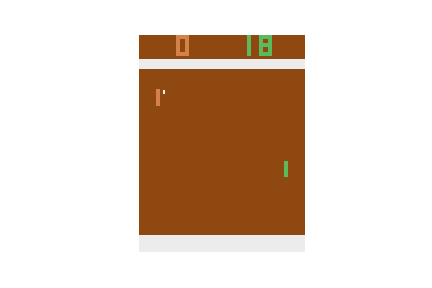
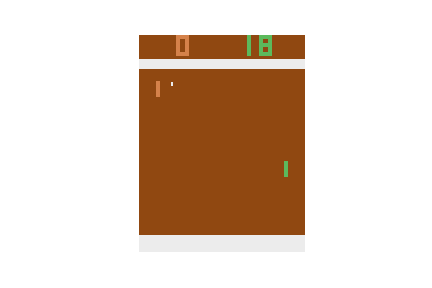
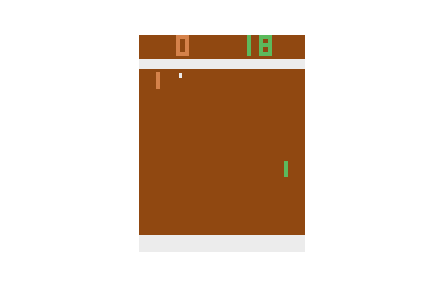
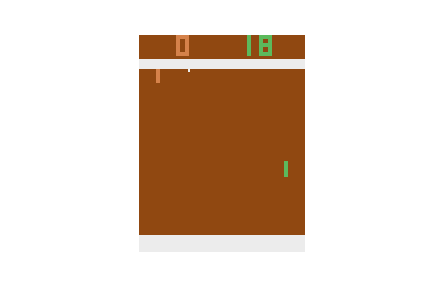
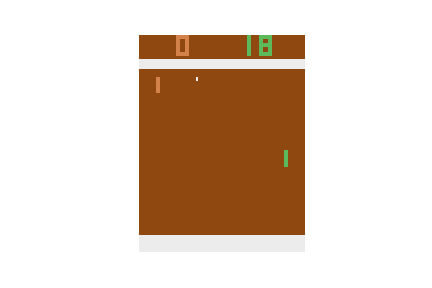
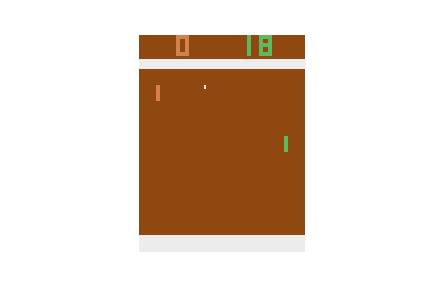
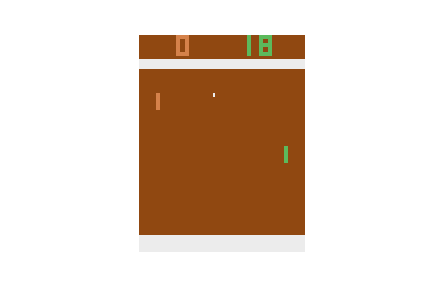
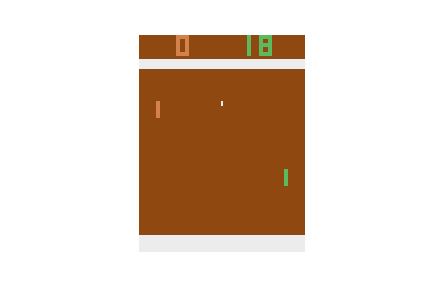
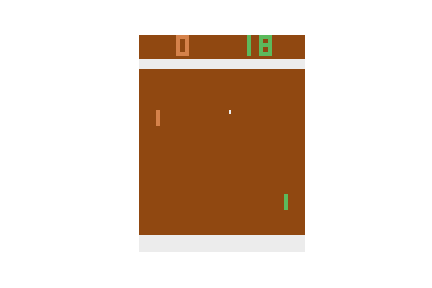
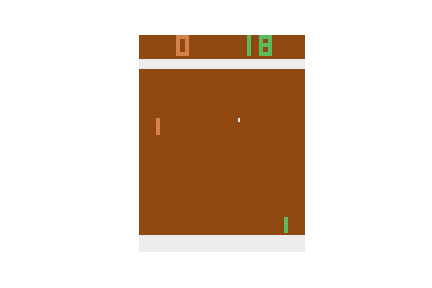
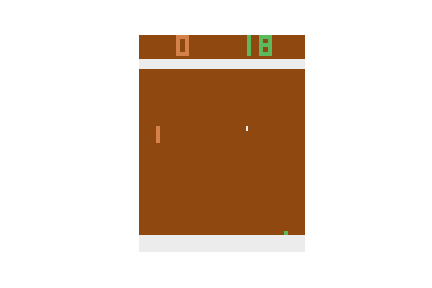
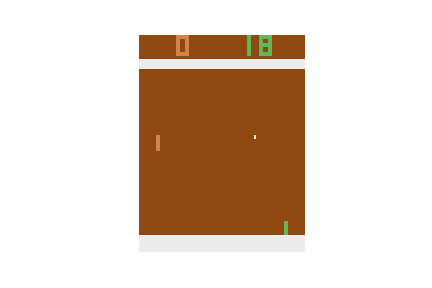
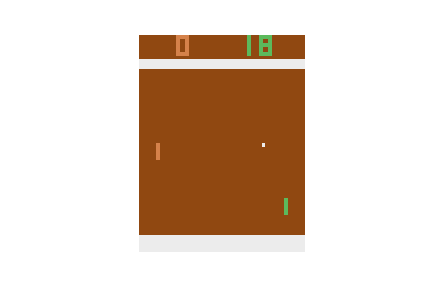
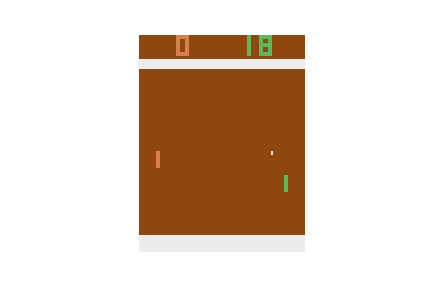
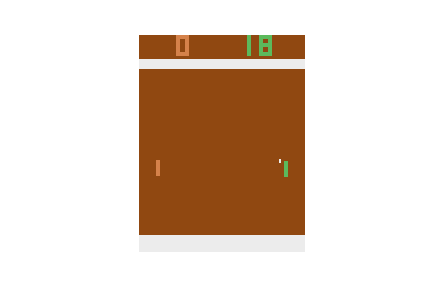
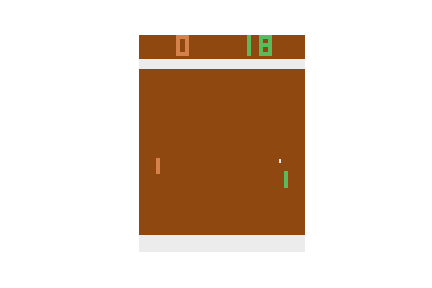
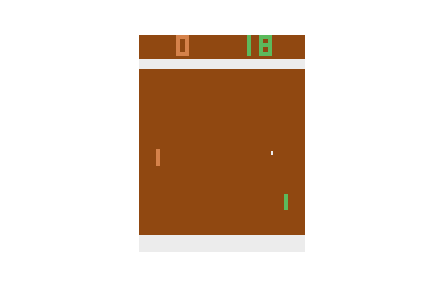
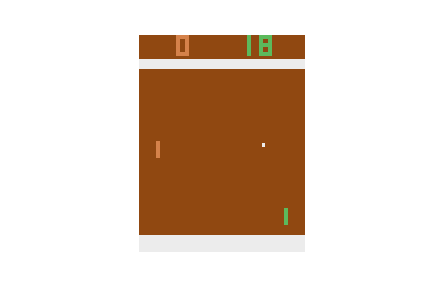
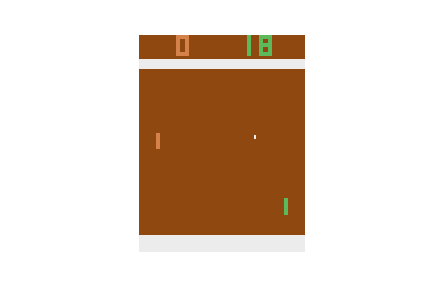
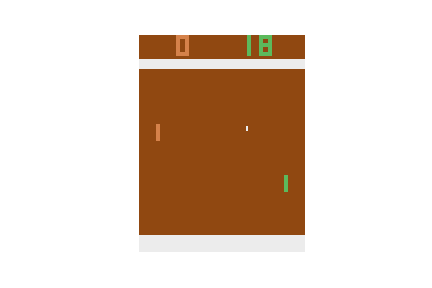
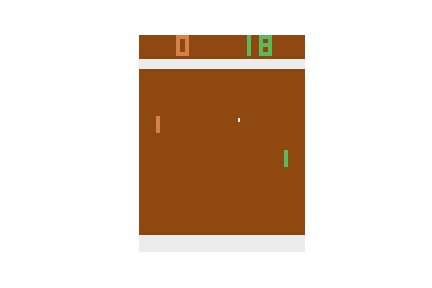
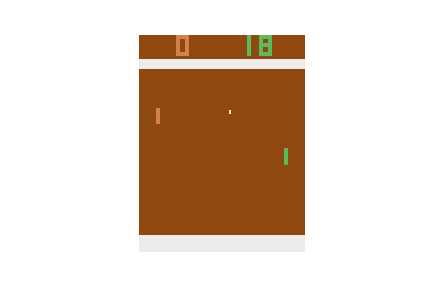
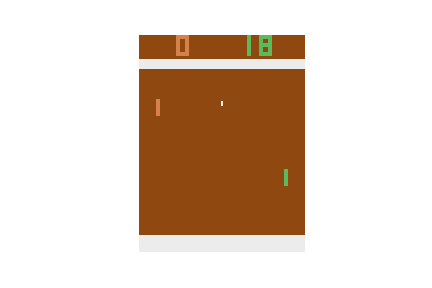
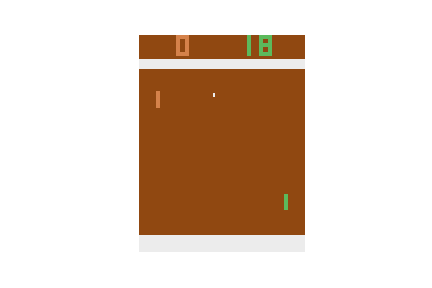
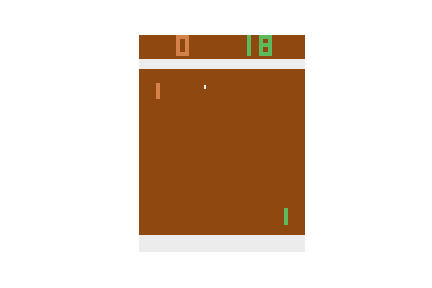
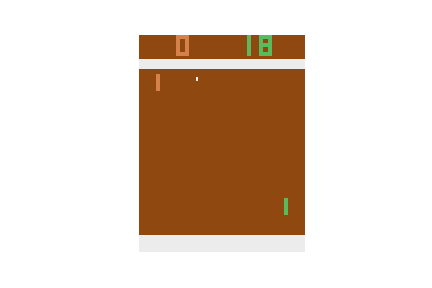
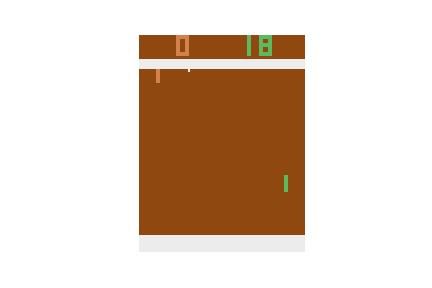
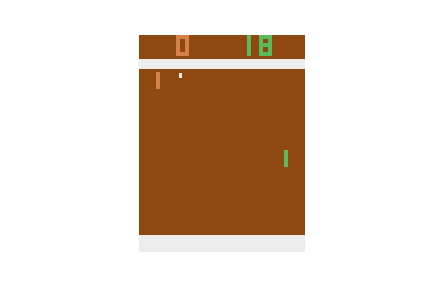
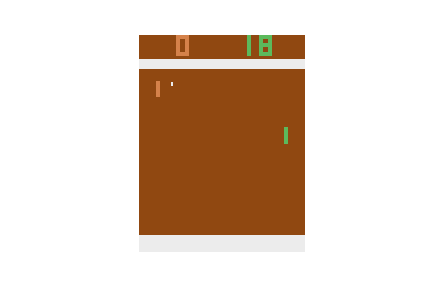
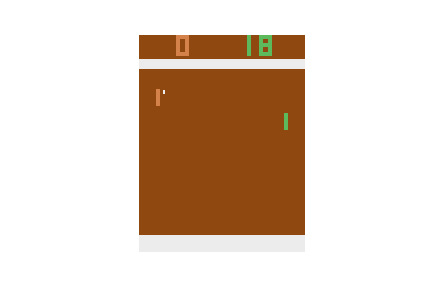
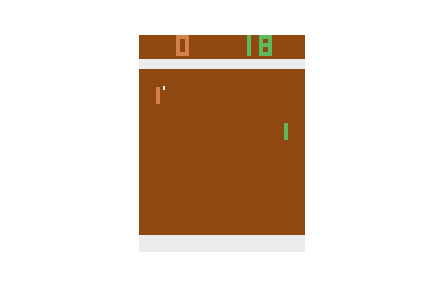
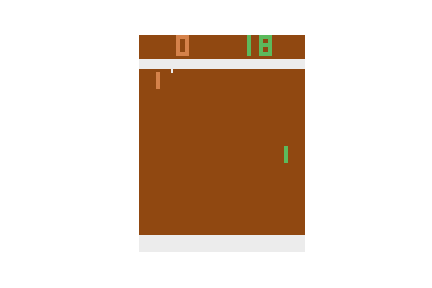
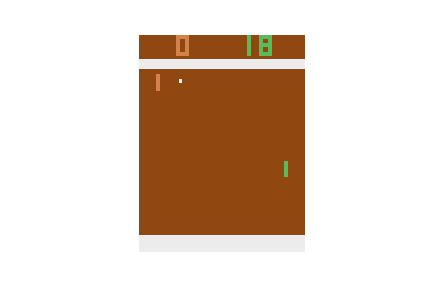
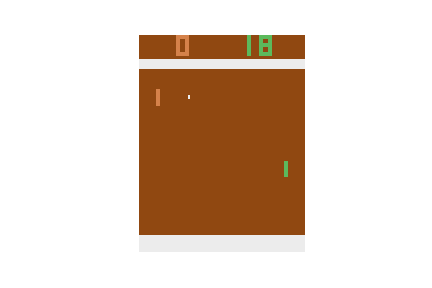
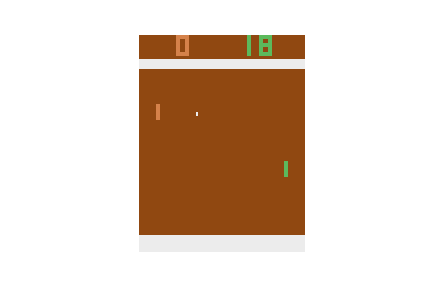
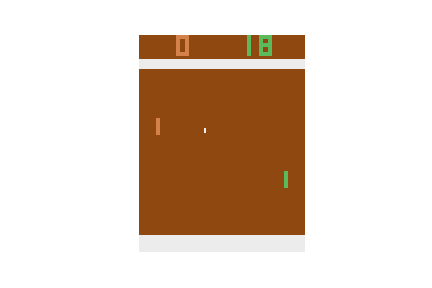
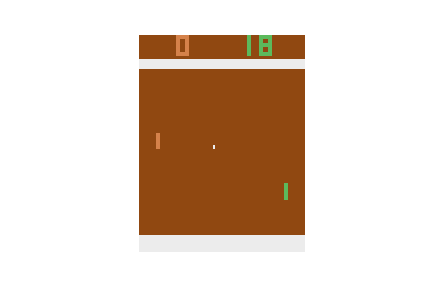
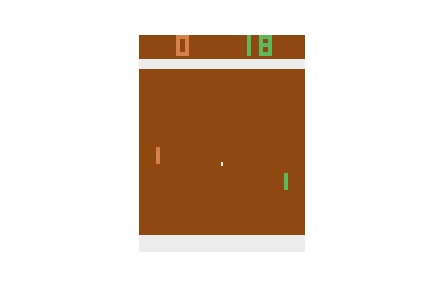
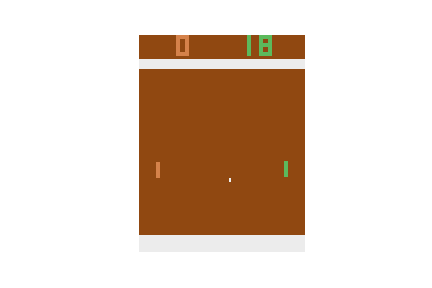
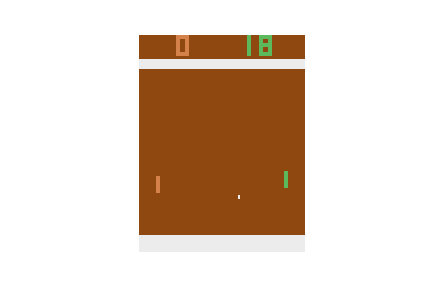
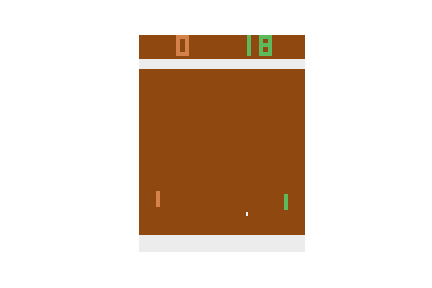
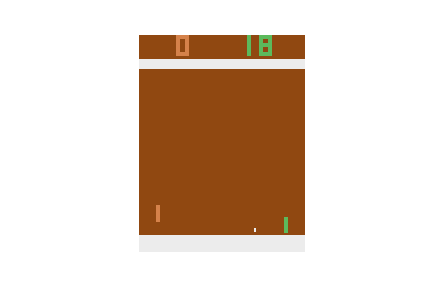
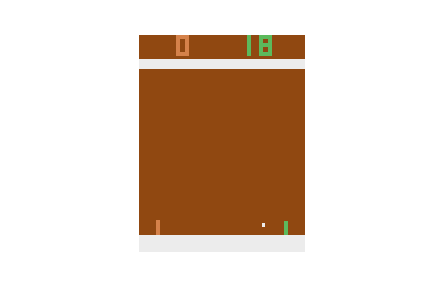
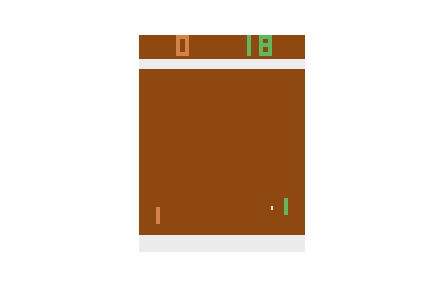
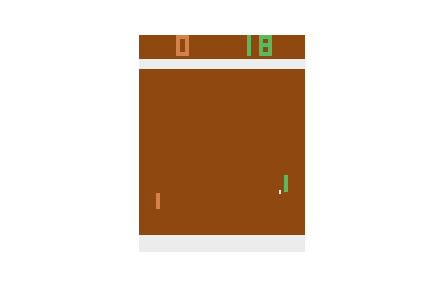
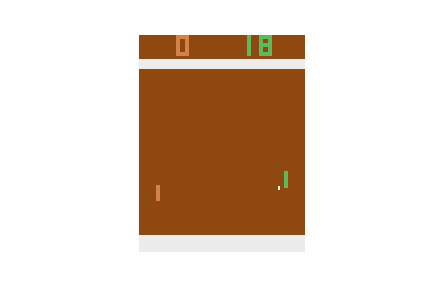
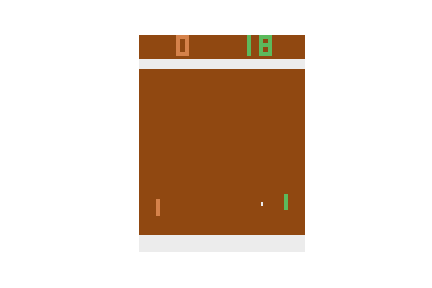
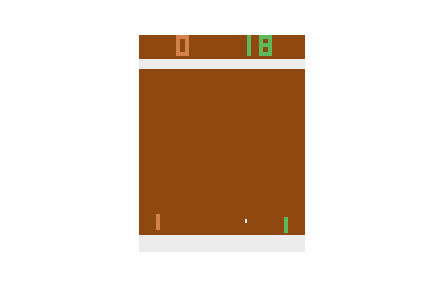
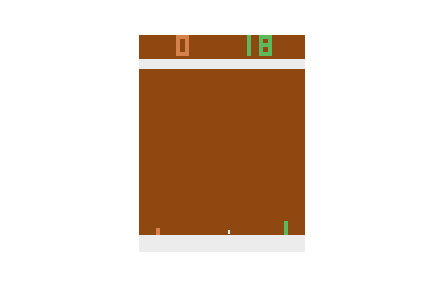
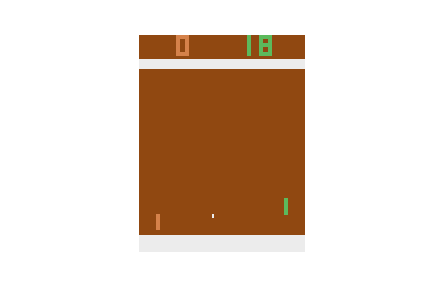
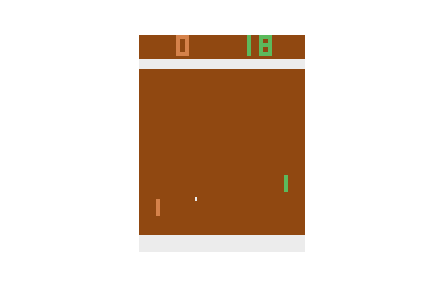
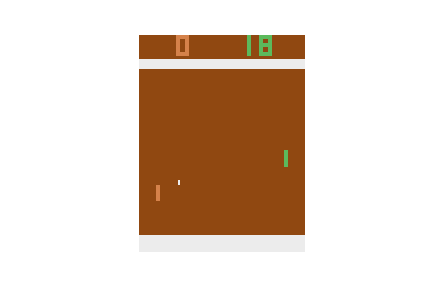
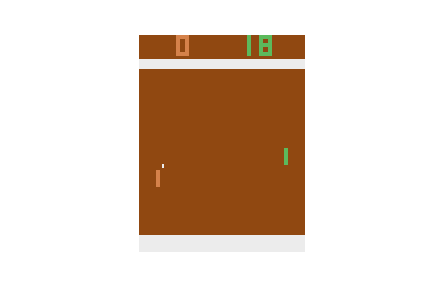
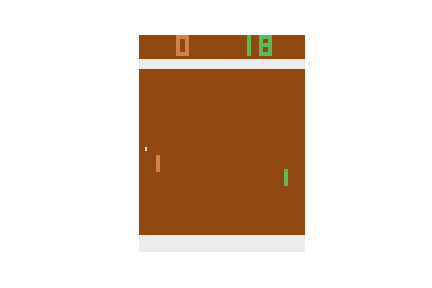
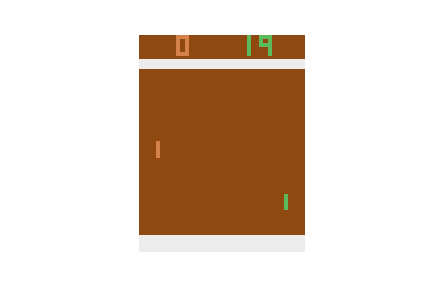
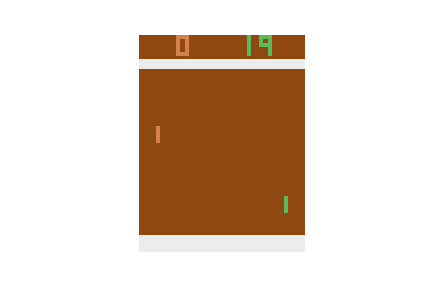
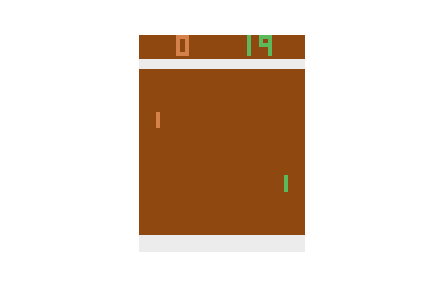
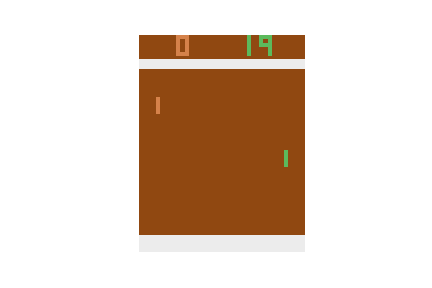
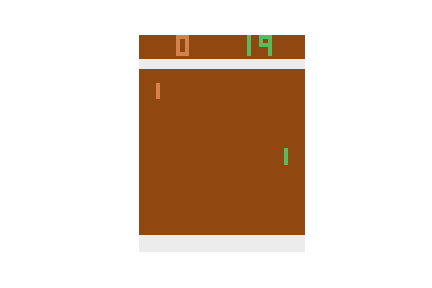
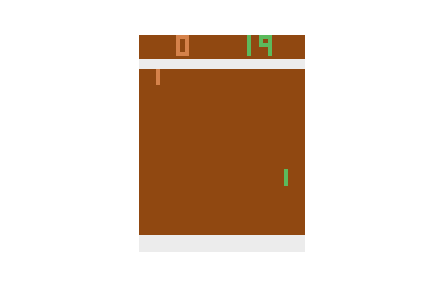
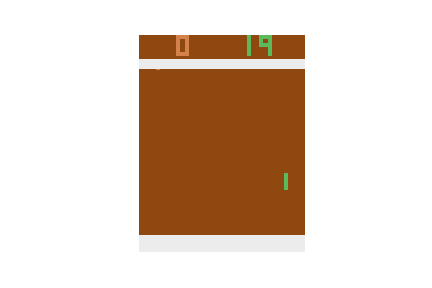
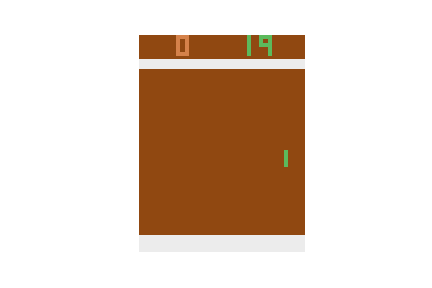
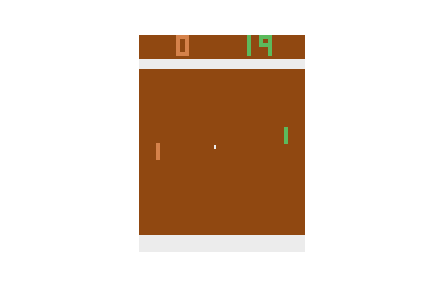
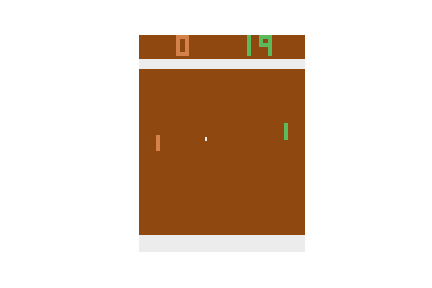
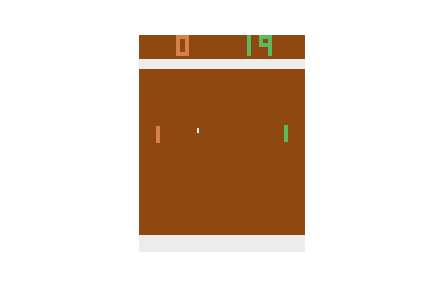
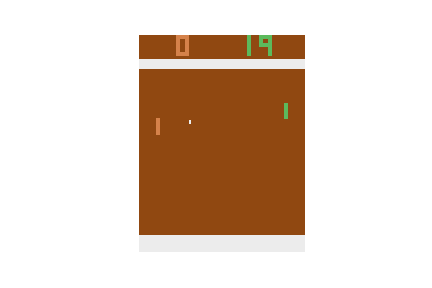
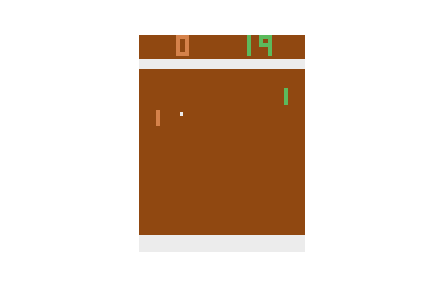
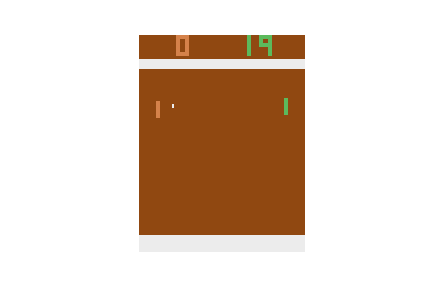
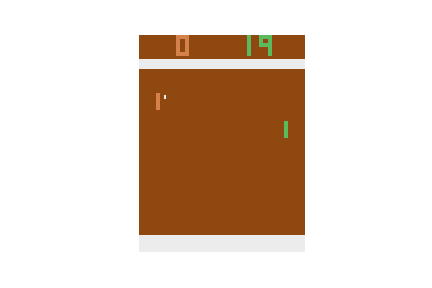
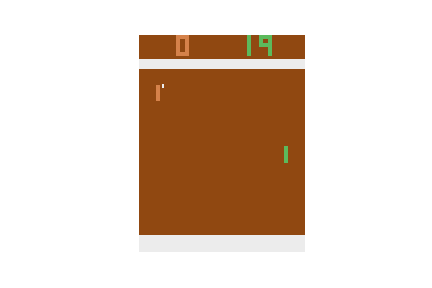
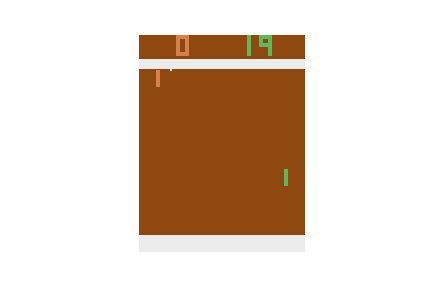
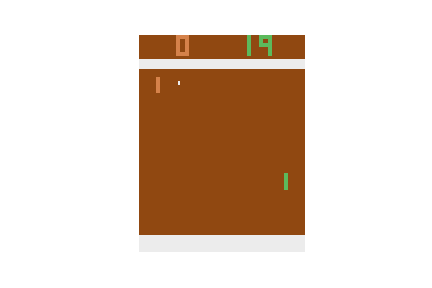
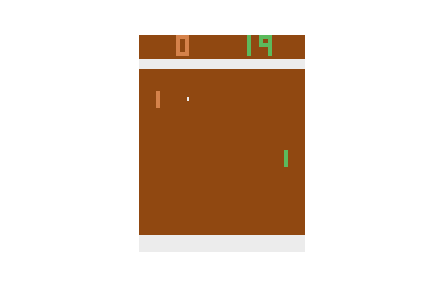
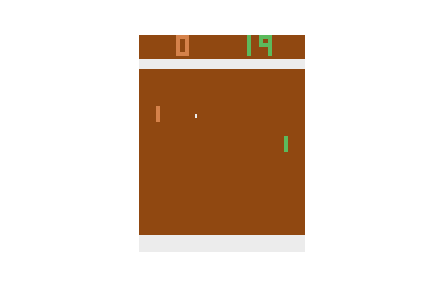
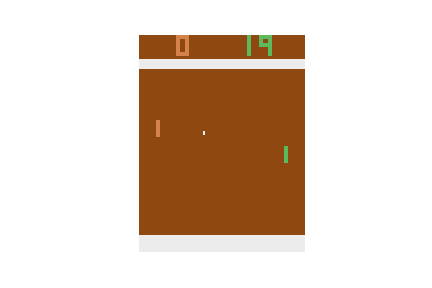
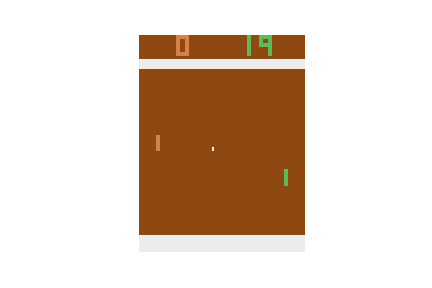
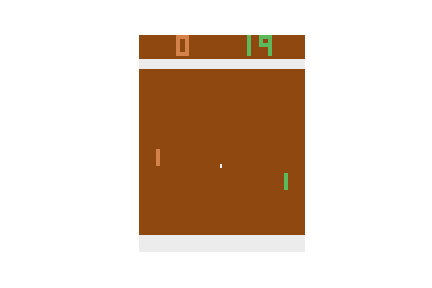
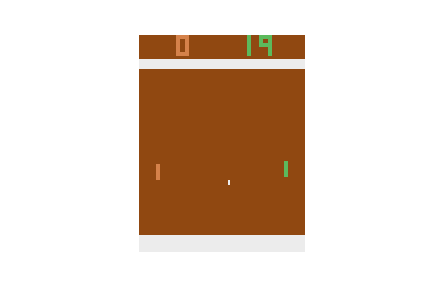
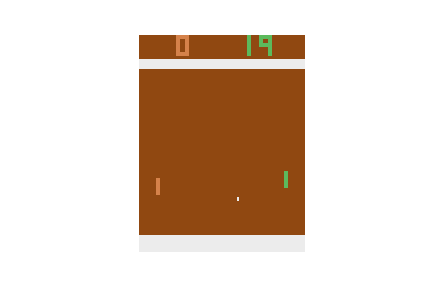
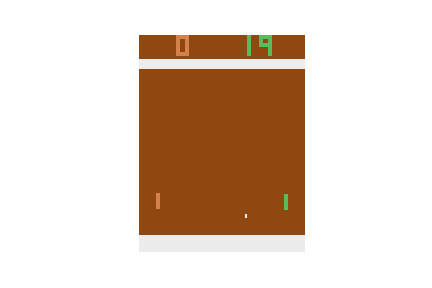
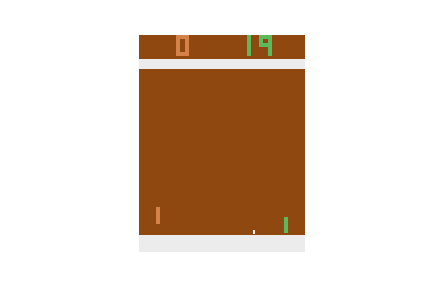
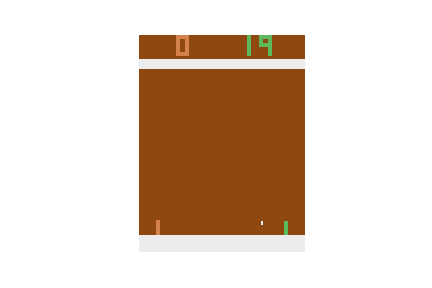
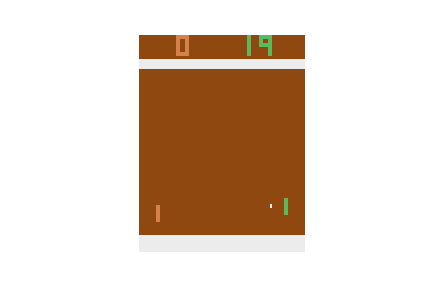
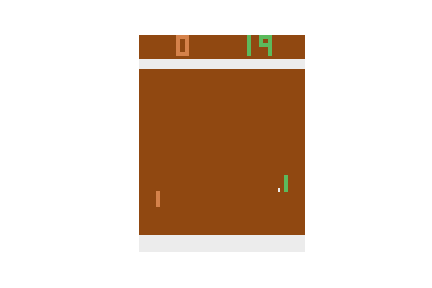
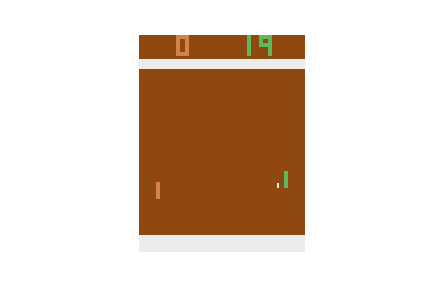
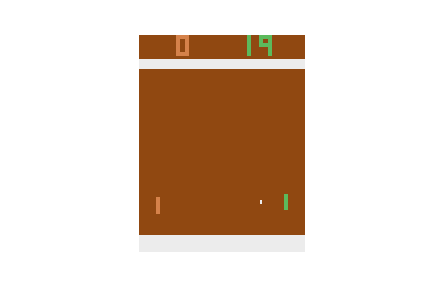
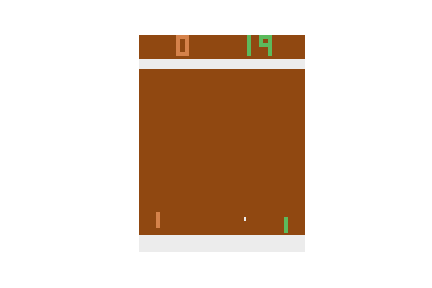
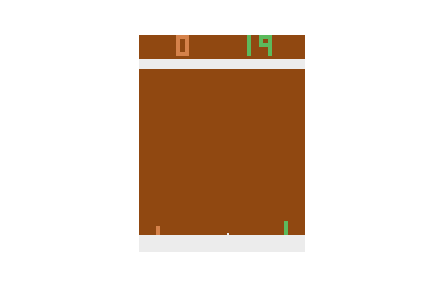
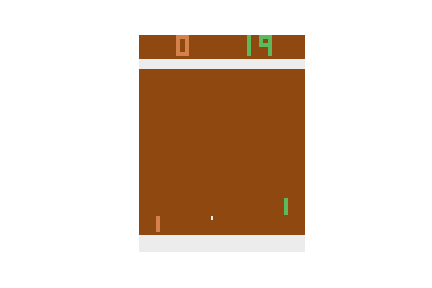
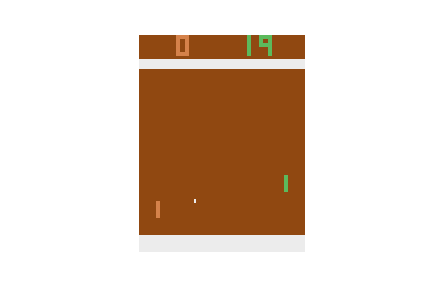
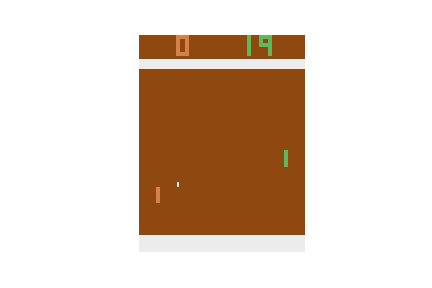
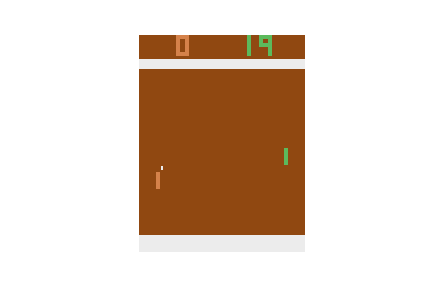
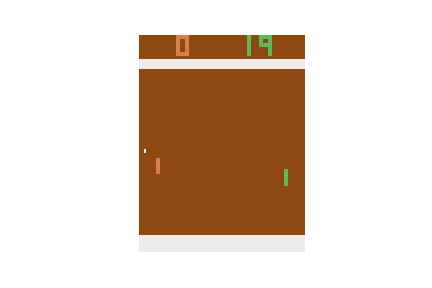
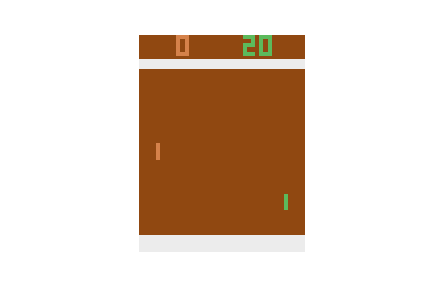
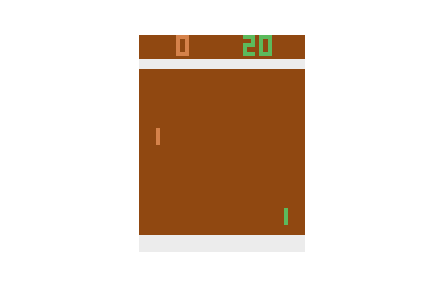
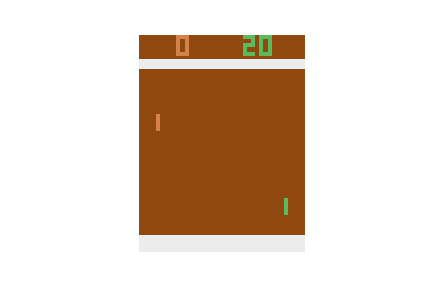
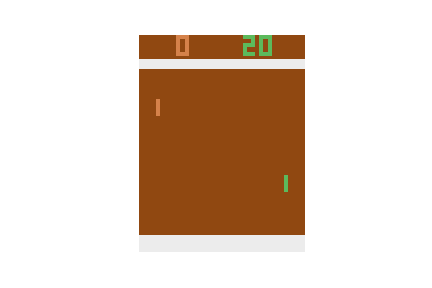
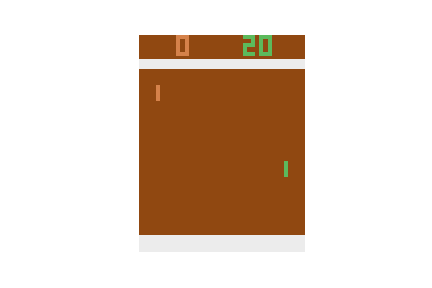
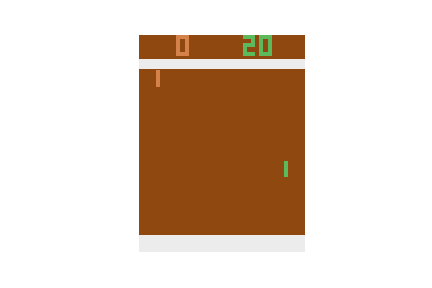
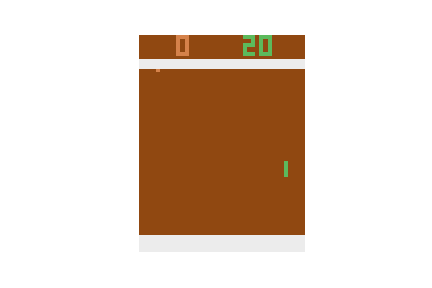
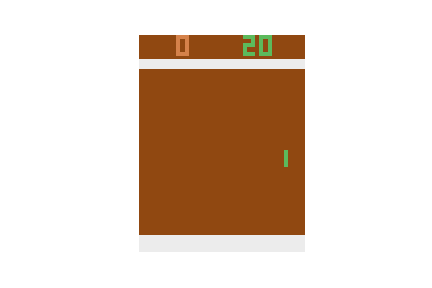
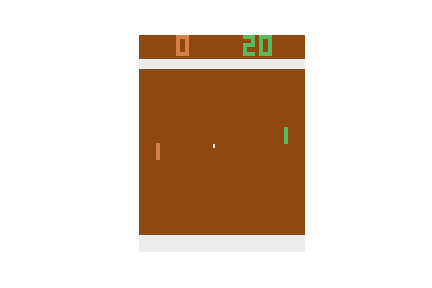
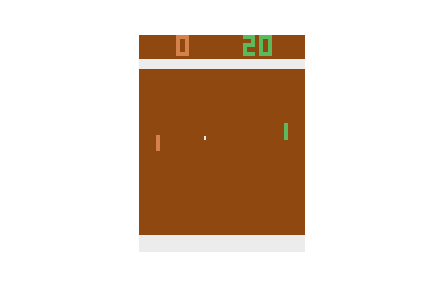
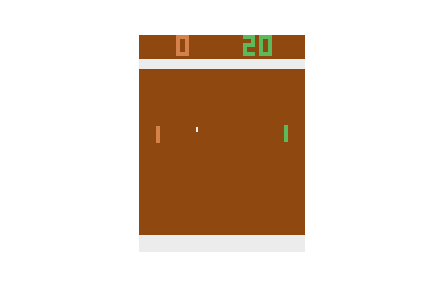
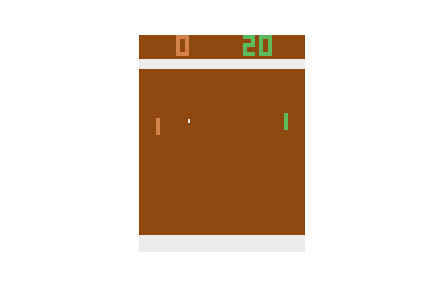
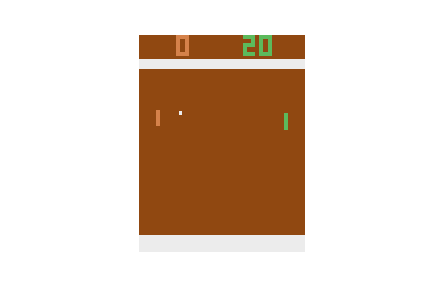
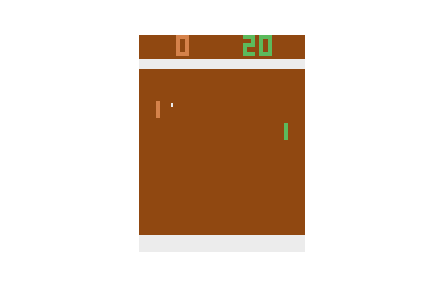
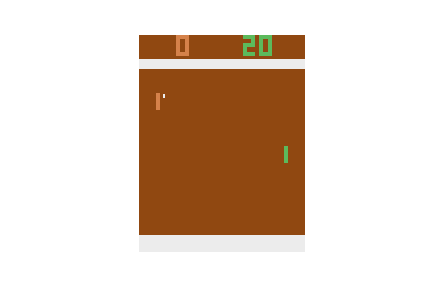
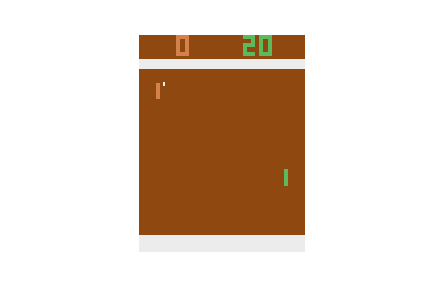
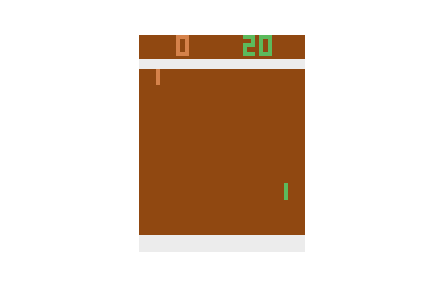
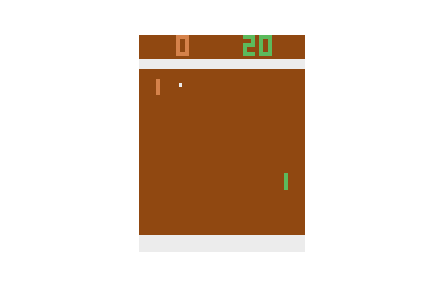
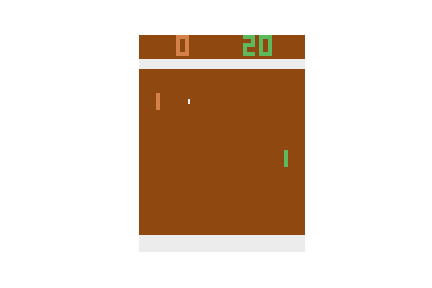
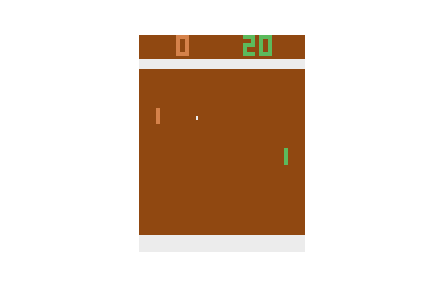
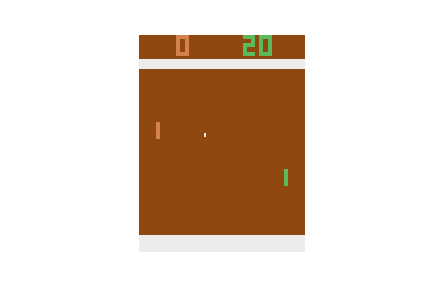
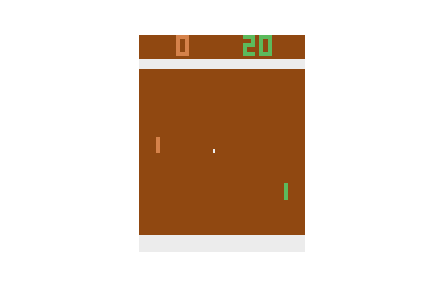
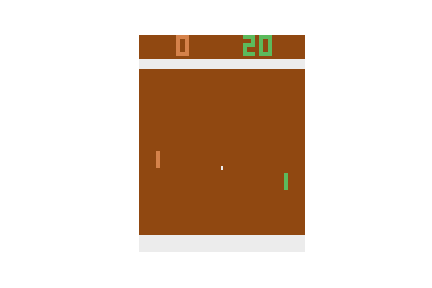
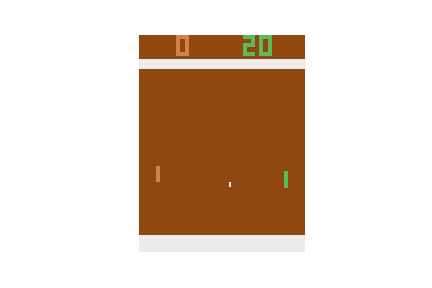
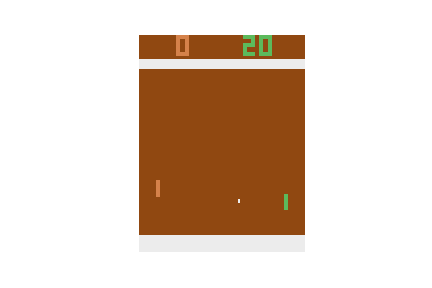
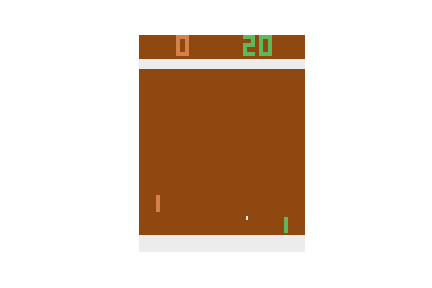
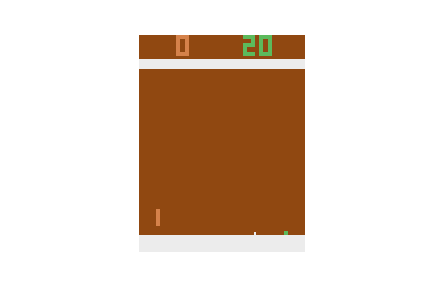
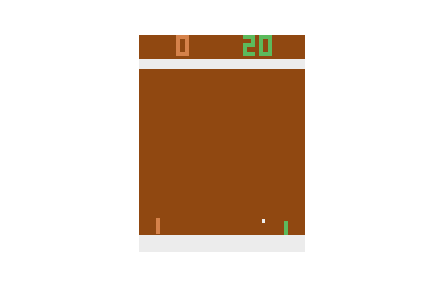
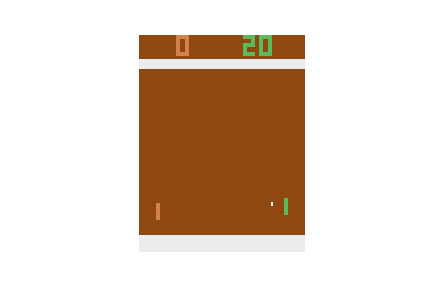
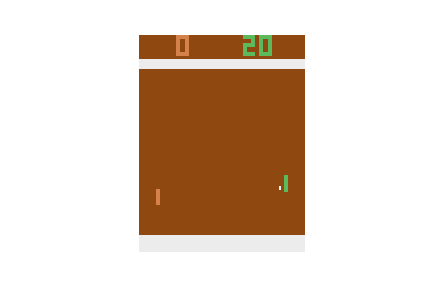
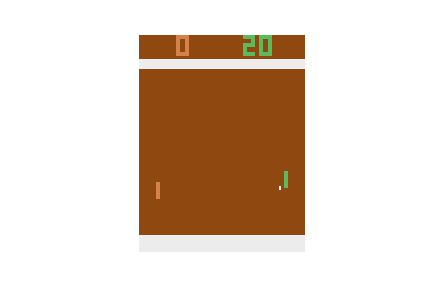
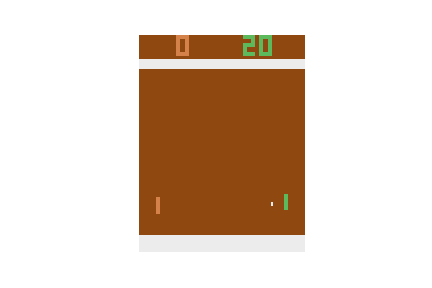
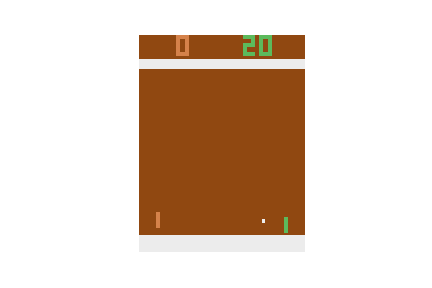
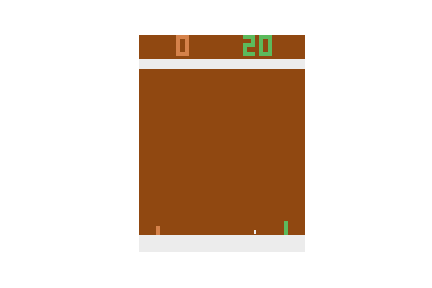
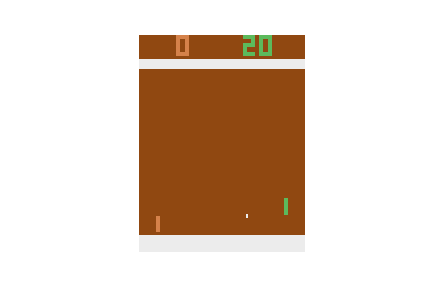
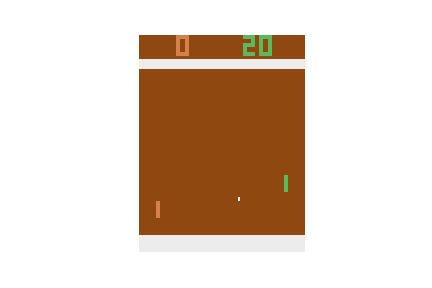
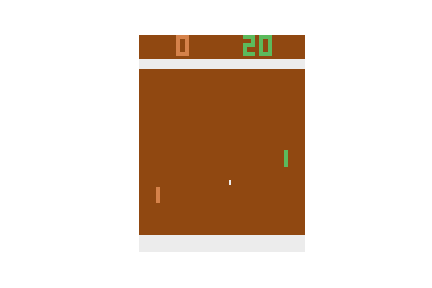
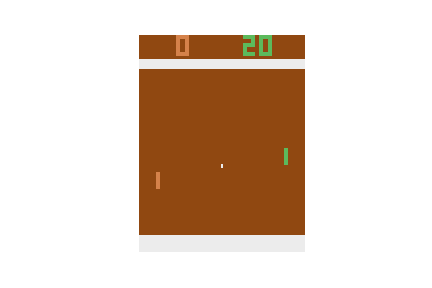
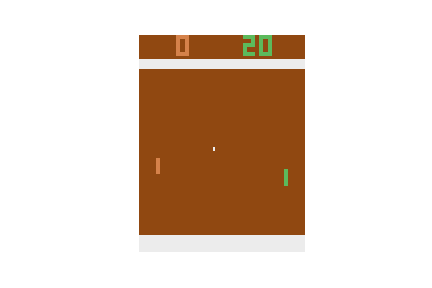
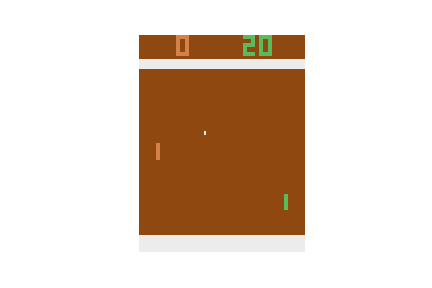
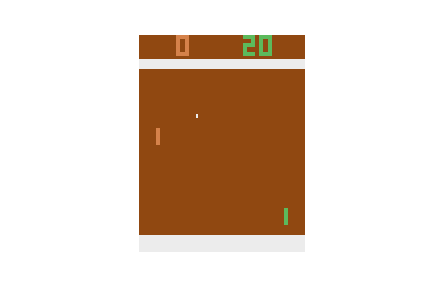
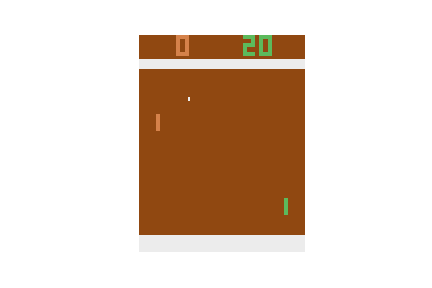
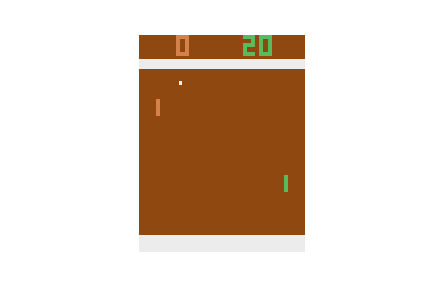
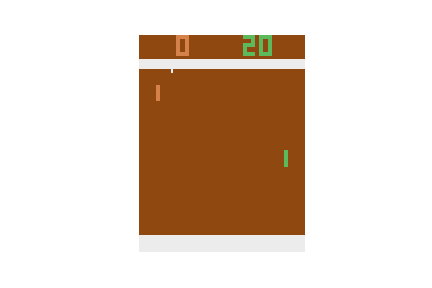
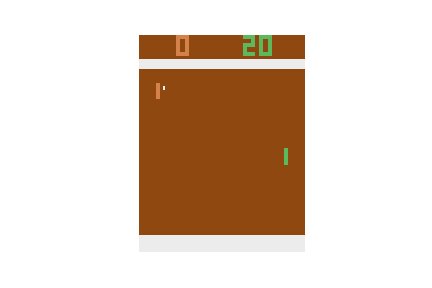
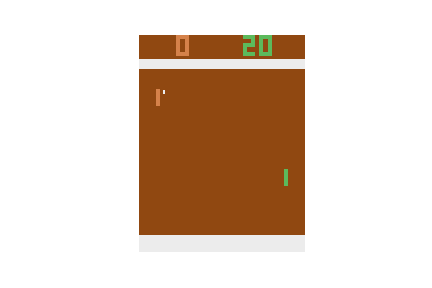
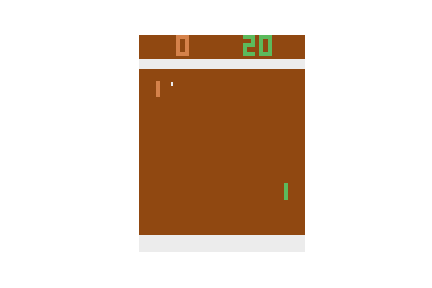
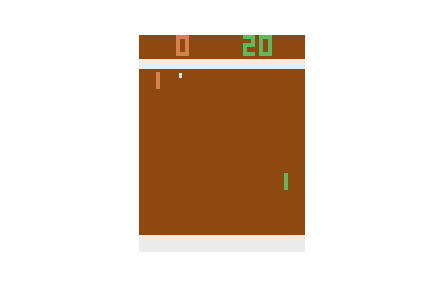
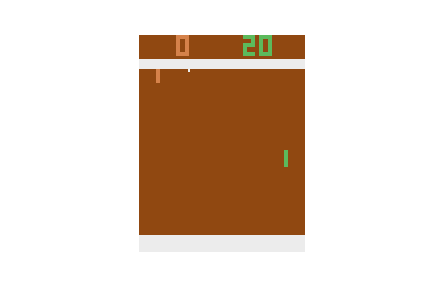
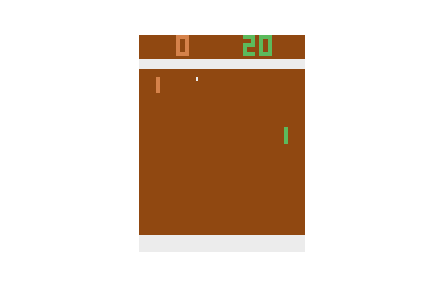
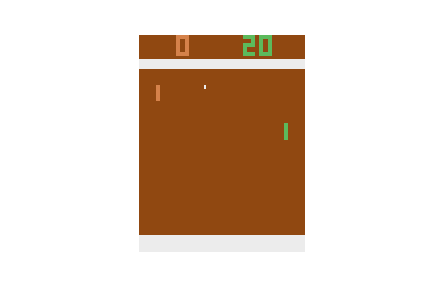
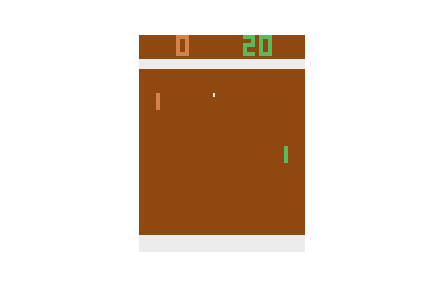
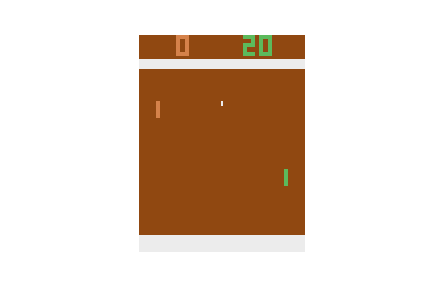
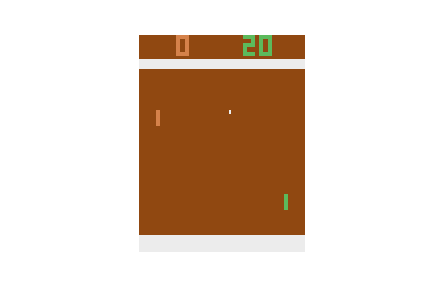
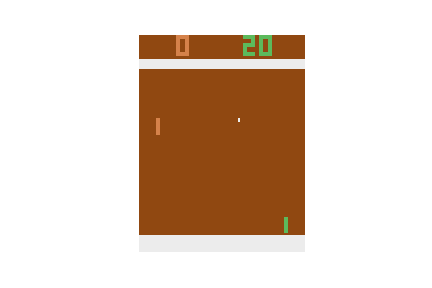
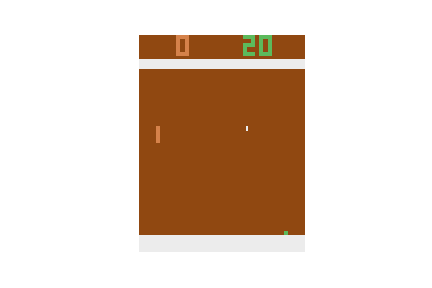
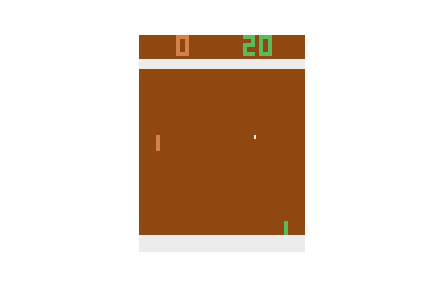
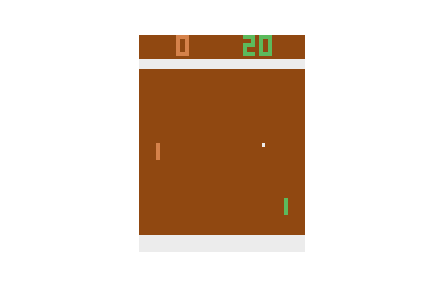
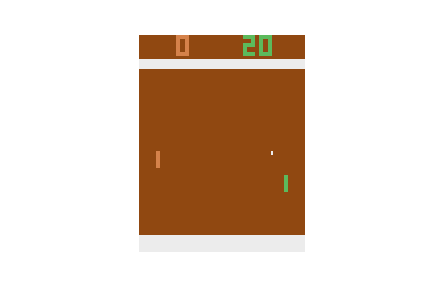
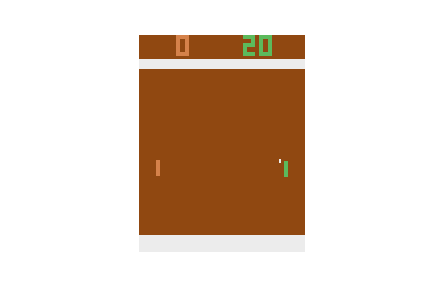
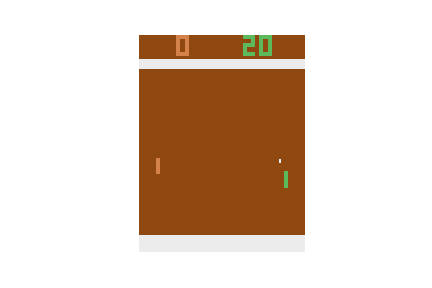
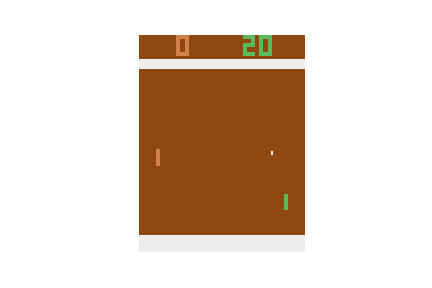
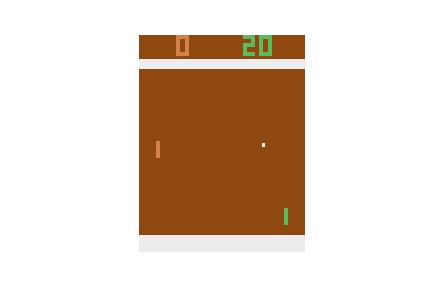
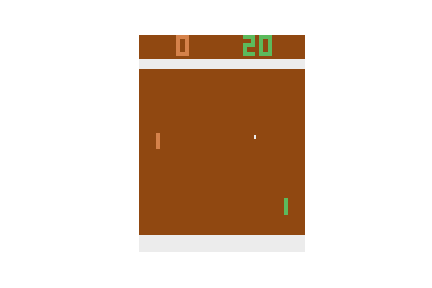
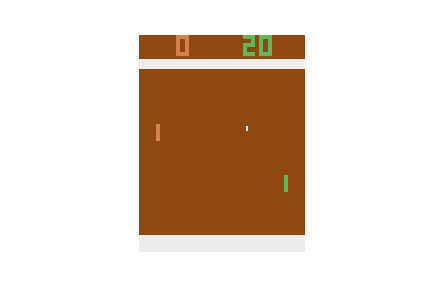
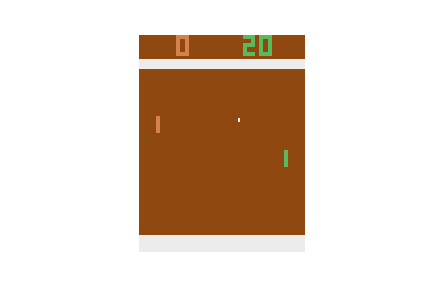
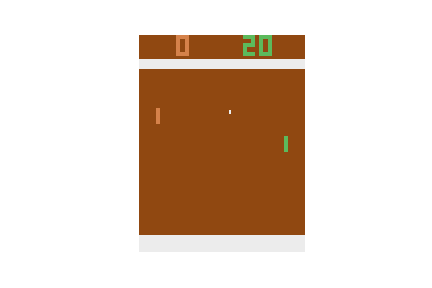
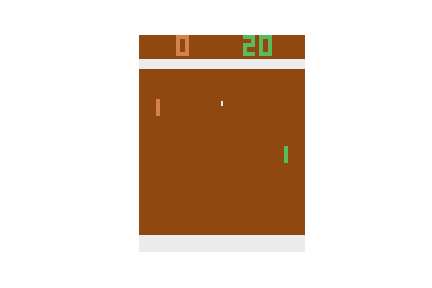
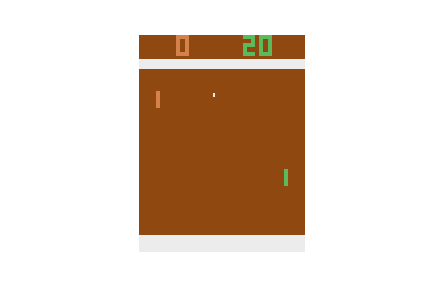
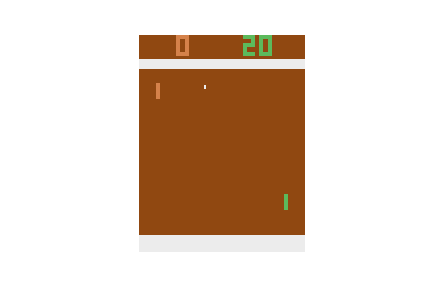
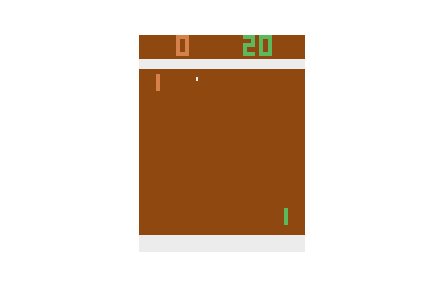
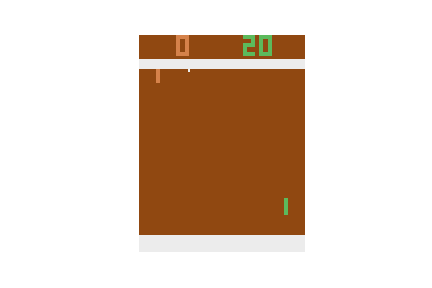
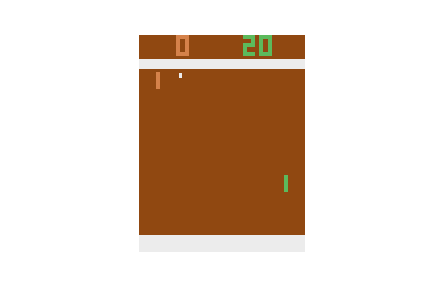
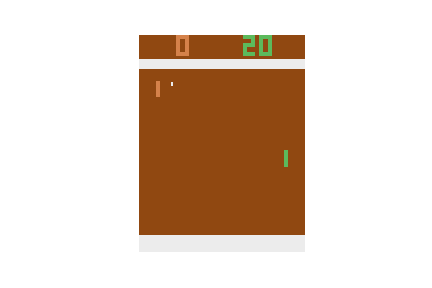
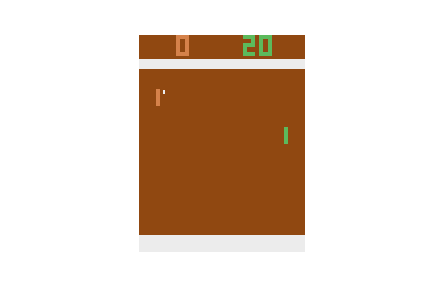
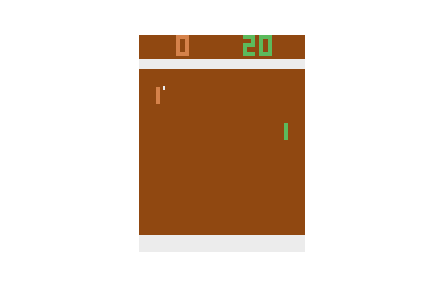
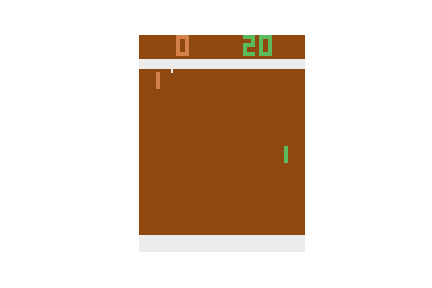
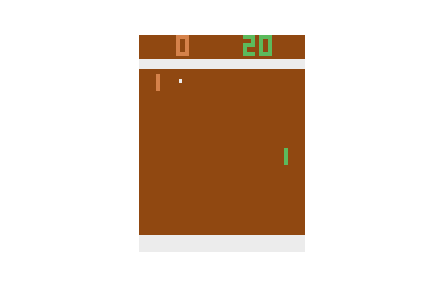
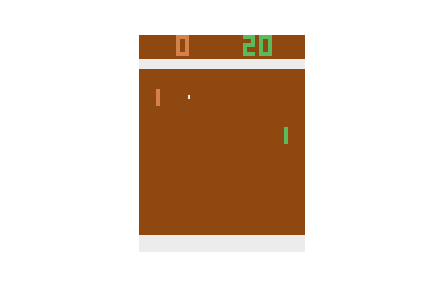
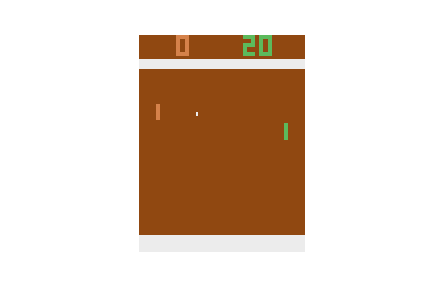
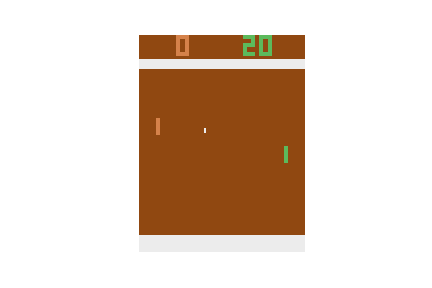
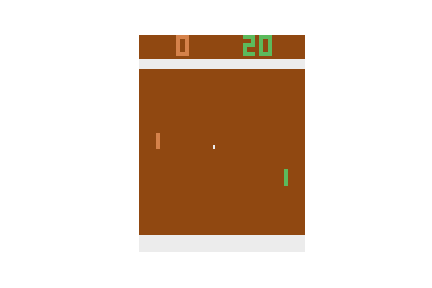
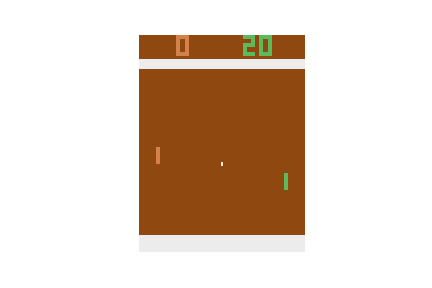
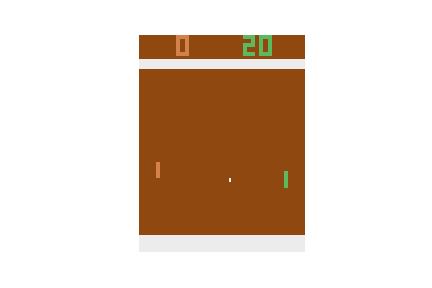
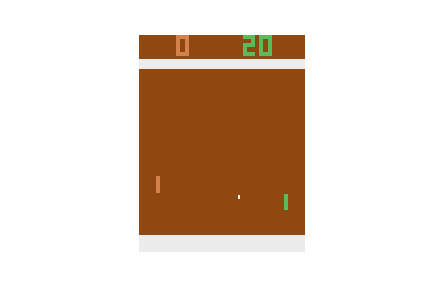
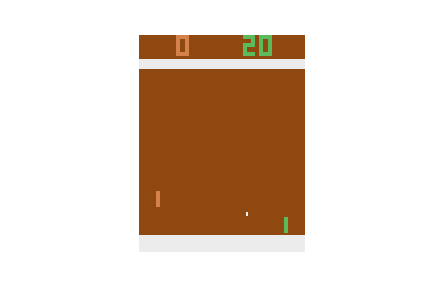
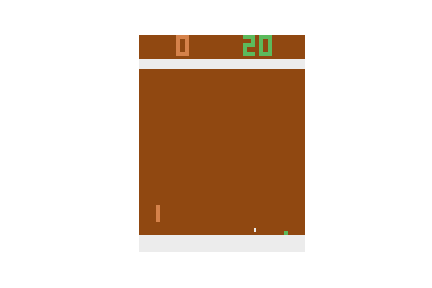
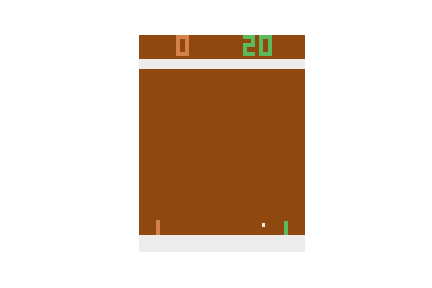
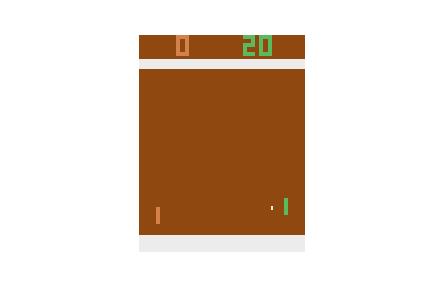
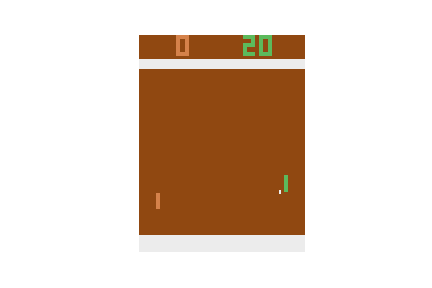
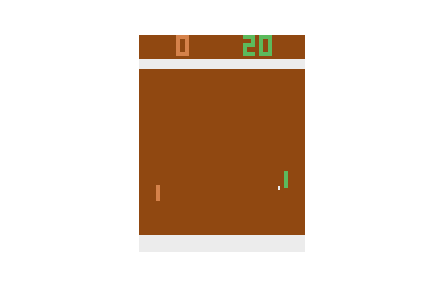
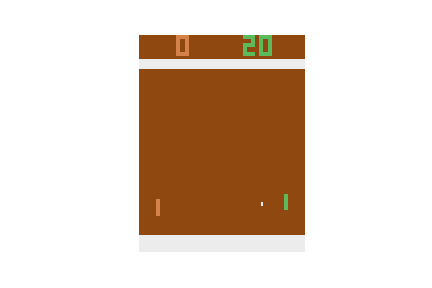
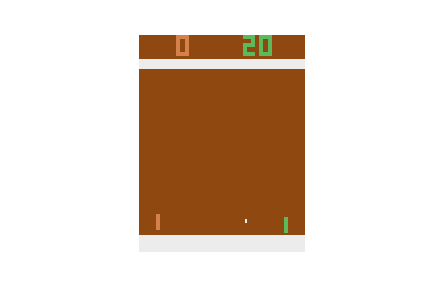
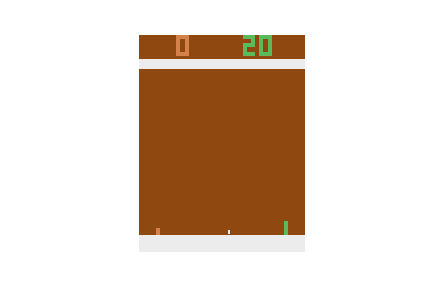
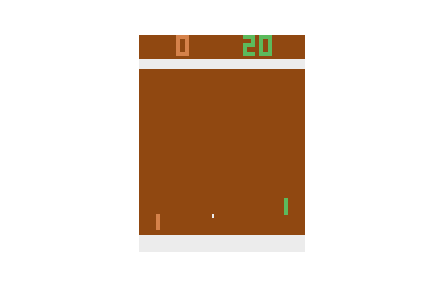
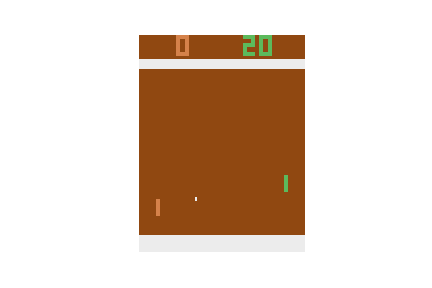
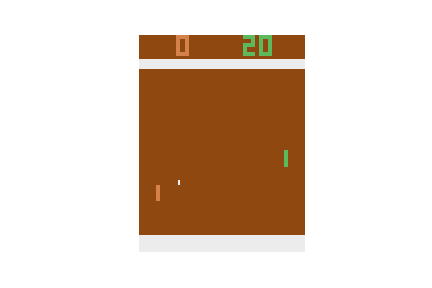
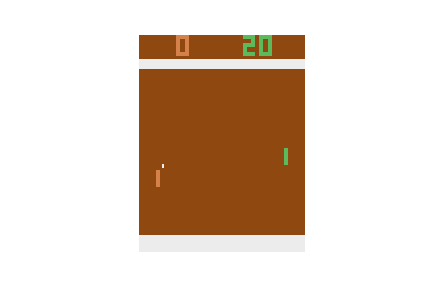
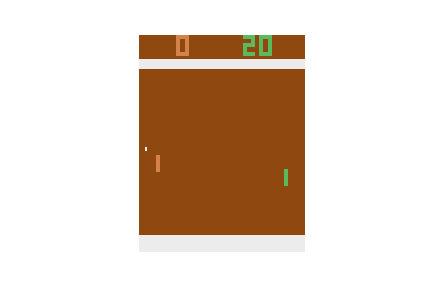
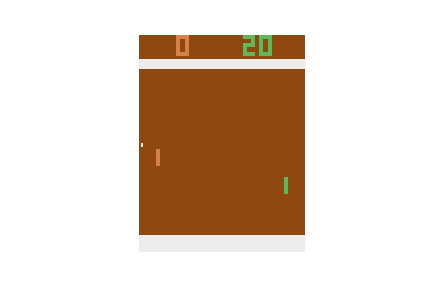

score: 21.0


In [21]:
score = play(env=env, agent=agent, t_max=2000)
print(f"score: {score}")